In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device
from pysr import pysr, best
from tqdm import tqdm
torch.manual_seed(42)
random.seed(42)


print('Loading data')

case='vlarge_all_4t_z0.0_standard_raw'

datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

Loading data


In [2]:
from torch_geometric.data import Data
data=[]

for d in datat:
#     data.append(Data(x=d.x[:,[0,3,4,19,20]], edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))
    

try:
    n_targ=len(data[0].y)
except:
    n_targ=1
n_feat=len(data[0].x[0])
n_feat, n_targ

print('Loaded data')

from torch.nn import ReLU, Linear, Module, LayerNorm, Sequential
class MLP(Module):
    def __init__(self, n_in, n_out, hidden=128, nlayers=4, layer_norm=True):
        super().__init__()
        layers = [Linear(n_in, hidden), ReLU()]
        for i in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU()) 
        if layer_norm:
            layers.append(LayerNorm(hidden)) #yay
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

Loaded data


In [3]:
class SageMLP(torch.nn.Module):
    def __init__(self, n_in = 10, n_outs=10, hidden_channels=64):
        super(SageMLP, self).__init__()
        self.node = MLP(n_in, n_outs,  hidden = hidden_channels)
        self.edge = MLP(n_in, n_outs, hidden = hidden_channels)
        
    def forward(self, x, edge_index):
        
        adj = edge_index # zero is sender, 1 is receiver
        
        neighborhood = scatter_add(x[adj[0]],adj[1], dim=0) #this adds only the neighbors, not the node itself
        xe = self.edge( neighborhood ) #ENCODE EDGE SUM
        x = self.node(x)
        x0 = torch.clone(x)
        
        x[adj[1]]+= xe[adj[1]] ##edge added node
        ## maybe add a joint decoder here
        return x, x0, xe

In [4]:
class SageMLP_extra(torch.nn.Module):
    def __init__(self, n_outs=2, hidden_channels=64):
        super(SageMLP, self).__init__()
        self.node = MLP(n_outs, n_outs,  hidden = hidden_channels)
        self.edge = MLP(n_outs, n_outs, hidden = hidden_channels)
        self.both = MLP(n_outs, n_outs, hidden = hidden_channels)
        
    def forward(self, x, edge_index):
        
        adj = edge_index # zero is sender, 1 is receiver
        
        neighborhood = scatter_add(x[adj[0]],adj[1], dim=0) #this adds only the neighbors, not the node itself
        xe = self.edge( neighborhood ) #ENCODE EDGE SUM
        x = self.node(x)
        
        x[adj[1]]+= xe[adj[1]] ##edge added node
        
        x = self.both(x)
        
        return x

In [5]:
from torch_geometric.nn import global_add_pool
from torch_scatter import scatter_add, scatter_mean



class PySRNet(torch.nn.Module):
    def __init__(self, n_m=10, hidden_channels=64, n_feat=43, n_targ=1):
        super(PySRNet, self).__init__()
        self.n0 = MLP(n_feat, n_m, hidden = hidden_channels)
        self.conv = SageMLP( n_m, n_m, hidden_channels = hidden_channels) 
    
        self.decode = MLP(n_m, n_targ,  hidden = hidden_channels)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        
        x = self.n0(x) # NODE ENCODER
        x0 = torch.clone(x)
        
        x, xn, xe = self.conv(x, edge_index)
        x1 = torch.clone(x)
        
        x = global_add_pool(x, batch)

        x = self.decode(x)

        return x, x0, x1, xn, xe
    
model = PySRNet(hidden_channels=128)
next(model.parameters()).is_cuda ##check number one

from sklearn.model_selection import train_test_split
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
# criterion = torch.nn.SmoothL1Loss(beta=0.3)


In [6]:
src = torch.Tensor([[2, 0, 1, 4, 3], [0, 2, 1, 3, 4]])
index = torch.tensor([[4, 5, 4, 2, 3], [0, 0, 2, 2, 1]])
out = src.new_zeros((2, 6))

out = scatter_add(src, index, out=out)

In [7]:
a = torch.ones(10)
index = torch.tensor([0,0,0,1,3,3,4,5,5,5])

scatter_add(a, index)

tensor([3., 1., 0., 2., 1., 3.])

In [11]:
# data=data
n_epochs=50
n_trials=1
batch_size=int(2**8) # 8 = 256
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
# train_data, test_data=train_test_split(data, test_size=0.2)
l1_lambda = 1e-4
l2_lambda = 0

l1_n0 = 0.1
l1_node = 0.1
l1_edge = 0.1
hidden = 128

yss, preds=[],[]
model = PySRNet(hidden_channels=hidden)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)

test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0, num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function
def train():
    model.train()
    global latent0, latent1, latn, latn
    for data in tqdm(train_loader, total=len(train_loader)): 
#         print('batch')
        out, latent0, latent1, latn, late = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        
#         n_lat = torch.sum(torch.isclose(latent0, torch.zeros_like(latent0), atol=0.01), axis=1)
#         l1_norm_latent = torch.mean(torch.abs(n_lat - torch.ones_like(n_lat)*2.))
        
        n0_latent = torch.mean(torch.abs(latent0))
        node_latent = torch.mean(torch.abs(latn))
        edge_latent = torch.mean(torch.abs(late))
        
        
        
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

        print(loss, l1_n0 * n0_latent, l1_node * node_latent, l1_edge * edge_latent)
        loss = loss + l1_n0 * n0_latent + l1_node * node_latent + l1_edge * edge_latent
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in tqdm(loader, total=len(loader)): 
            
            out, latent0, latent1, xn, xe = model(dat.x, dat.edge_index, dat.batch) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss


GPU  False


In [12]:
# model.parameters

In [13]:
tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):
    print(epoch)
    train()
    if (epoch+1)%2==0:
        train_acc, _ , _ = test(train_loader)
        test_acc, _ , _ = test(test_loader)
        tr_acc.append(train_acc.cpu())
        te_acc.append(test_acc.cpu())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
        Test scatter: {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")



0


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(3.6066, grad_fn=<MseLossBackward>) tensor(0.0442, grad_fn=<MulBackward0>) tensor(0.0330, grad_fn=<MulBackward0>) tensor(0.0444, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<09:20,  1.65s/it]

tensor(3.2434, grad_fn=<MseLossBackward>) tensor(0.1097, grad_fn=<MulBackward0>) tensor(0.0702, grad_fn=<MulBackward0>) tensor(0.0864, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:57,  1.23s/it]

tensor(1.0901, grad_fn=<MseLossBackward>) tensor(0.1455, grad_fn=<MulBackward0>) tensor(0.0902, grad_fn=<MulBackward0>) tensor(0.1085, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:01,  1.07s/it]

tensor(0.9798, grad_fn=<MseLossBackward>) tensor(0.1580, grad_fn=<MulBackward0>) tensor(0.1054, grad_fn=<MulBackward0>) tensor(0.1210, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:19,  1.06it/s]

tensor(0.7356, grad_fn=<MseLossBackward>) tensor(0.1599, grad_fn=<MulBackward0>) tensor(0.1156, grad_fn=<MulBackward0>) tensor(0.1277, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:04,  1.10it/s]

tensor(0.9779, grad_fn=<MseLossBackward>) tensor(0.1564, grad_fn=<MulBackward0>) tensor(0.1204, grad_fn=<MulBackward0>) tensor(0.1302, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:20,  1.04it/s]

tensor(0.8706, grad_fn=<MseLossBackward>) tensor(0.1509, grad_fn=<MulBackward0>) tensor(0.1211, grad_fn=<MulBackward0>) tensor(0.1301, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:59,  1.08s/it]

tensor(0.9257, grad_fn=<MseLossBackward>) tensor(0.1416, grad_fn=<MulBackward0>) tensor(0.1199, grad_fn=<MulBackward0>) tensor(0.1271, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:29,  1.01it/s]

tensor(0.8037, grad_fn=<MseLossBackward>) tensor(0.1295, grad_fn=<MulBackward0>) tensor(0.1179, grad_fn=<MulBackward0>) tensor(0.1231, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:21,  1.03it/s]

tensor(0.9903, grad_fn=<MseLossBackward>) tensor(0.1128, grad_fn=<MulBackward0>) tensor(0.1151, grad_fn=<MulBackward0>) tensor(0.1161, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<05:20,  1.03it/s]

tensor(0.9287, grad_fn=<MseLossBackward>) tensor(0.0945, grad_fn=<MulBackward0>) tensor(0.1113, grad_fn=<MulBackward0>) tensor(0.1079, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:11<05:25,  1.01it/s]

tensor(0.9961, grad_fn=<MseLossBackward>) tensor(0.0779, grad_fn=<MulBackward0>) tensor(0.1068, grad_fn=<MulBackward0>) tensor(0.0965, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:12<05:32,  1.01s/it]

tensor(0.8716, grad_fn=<MseLossBackward>) tensor(0.0654, grad_fn=<MulBackward0>) tensor(0.1014, grad_fn=<MulBackward0>) tensor(0.0846, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:13<05:26,  1.01it/s]

tensor(0.9610, grad_fn=<MseLossBackward>) tensor(0.0575, grad_fn=<MulBackward0>) tensor(0.0955, grad_fn=<MulBackward0>) tensor(0.0722, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:14<05:09,  1.05it/s]

tensor(0.9690, grad_fn=<MseLossBackward>) tensor(0.0480, grad_fn=<MulBackward0>) tensor(0.0888, grad_fn=<MulBackward0>) tensor(0.0632, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<04:50,  1.12it/s]

tensor(0.9238, grad_fn=<MseLossBackward>) tensor(0.0390, grad_fn=<MulBackward0>) tensor(0.0831, grad_fn=<MulBackward0>) tensor(0.0550, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:15<04:39,  1.16it/s]

tensor(0.7240, grad_fn=<MseLossBackward>) tensor(0.0329, grad_fn=<MulBackward0>) tensor(0.0790, grad_fn=<MulBackward0>) tensor(0.0495, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:16<04:07,  1.31it/s]

tensor(0.8507, grad_fn=<MseLossBackward>) tensor(0.0322, grad_fn=<MulBackward0>) tensor(0.0778, grad_fn=<MulBackward0>) tensor(0.0433, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:17<04:30,  1.19it/s]

tensor(0.8544, grad_fn=<MseLossBackward>) tensor(0.0340, grad_fn=<MulBackward0>) tensor(0.0760, grad_fn=<MulBackward0>) tensor(0.0406, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:12,  1.28it/s]

tensor(0.9132, grad_fn=<MseLossBackward>) tensor(0.0343, grad_fn=<MulBackward0>) tensor(0.0732, grad_fn=<MulBackward0>) tensor(0.0414, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<04:18,  1.24it/s]

tensor(0.9832, grad_fn=<MseLossBackward>) tensor(0.0316, grad_fn=<MulBackward0>) tensor(0.0696, grad_fn=<MulBackward0>) tensor(0.0414, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:19<04:15,  1.25it/s]

tensor(0.7202, grad_fn=<MseLossBackward>) tensor(0.0266, grad_fn=<MulBackward0>) tensor(0.0656, grad_fn=<MulBackward0>) tensor(0.0395, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<03:51,  1.38it/s]

tensor(0.8195, grad_fn=<MseLossBackward>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0615, grad_fn=<MulBackward0>) tensor(0.0358, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<03:26,  1.54it/s]

tensor(1.0033, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0580, grad_fn=<MulBackward0>) tensor(0.0313, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<03:40,  1.44it/s]

tensor(0.8695, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0542, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:22<03:52,  1.36it/s]

tensor(0.8850, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0498, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<03:59,  1.31it/s]

tensor(0.7794, grad_fn=<MseLossBackward>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0448, grad_fn=<MulBackward0>) tensor(0.0178, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<03:44,  1.40it/s]

tensor(0.9606, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0394, grad_fn=<MulBackward0>) tensor(0.0164, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:24<04:10,  1.25it/s]

tensor(0.7658, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0335, grad_fn=<MulBackward0>) tensor(0.0152, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<03:37,  1.43it/s]

tensor(0.8900, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0288, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:25<03:38,  1.42it/s]

tensor(0.8385, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:26<03:23,  1.52it/s]

tensor(0.8744, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0230, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<03:22,  1.53it/s]

tensor(0.9686, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0217, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<03:21,  1.53it/s]

tensor(0.7656, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<03:16,  1.56it/s]

tensor(0.8570, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:29<03:47,  1.35it/s]

tensor(0.7493, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:26,  1.48it/s]

tensor(0.9126, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<03:28,  1.46it/s]

tensor(0.7006, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:30<03:12,  1.57it/s]

tensor(0.9375, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:31<03:24,  1.48it/s]

tensor(0.8299, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:32<03:12,  1.57it/s]

tensor(0.7537, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:32<03:21,  1.49it/s]

tensor(0.7482, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:33<03:07,  1.60it/s]

tensor(0.6336, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:33<02:48,  1.77it/s]

tensor(0.6561, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:34<02:47,  1.78it/s]

tensor(0.9514, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:35<02:55,  1.69it/s]

tensor(0.8217, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0242, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:35<03:07,  1.57it/s]

tensor(0.8496, grad_fn=<MseLossBackward>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0307, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:36<03:18,  1.48it/s]

tensor(0.7578, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0366, grad_fn=<MulBackward0>) tensor(0.0443, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:37<03:36,  1.36it/s]

tensor(0.7193, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0415, grad_fn=<MulBackward0>) tensor(0.0503, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:37<03:11,  1.52it/s]

tensor(0.9812, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0455, grad_fn=<MulBackward0>) tensor(0.0549, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:38<03:22,  1.44it/s]

tensor(0.7195, grad_fn=<MseLossBackward>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0486, grad_fn=<MulBackward0>) tensor(0.0583, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:39<03:22,  1.43it/s]

tensor(0.8837, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0511, grad_fn=<MulBackward0>) tensor(0.0615, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:39<03:06,  1.55it/s]

tensor(0.8790, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0529, grad_fn=<MulBackward0>) tensor(0.0644, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:40<02:59,  1.61it/s]

tensor(0.8819, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0541, grad_fn=<MulBackward0>) tensor(0.0665, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:41<02:49,  1.70it/s]

tensor(0.8891, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0547, grad_fn=<MulBackward0>) tensor(0.0680, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:41<02:58,  1.61it/s]

tensor(0.9356, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0548, grad_fn=<MulBackward0>) tensor(0.0687, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:42<03:33,  1.34it/s]

tensor(0.8012, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0544, grad_fn=<MulBackward0>) tensor(0.0690, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:43<03:08,  1.51it/s]

tensor(0.7816, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0537, grad_fn=<MulBackward0>) tensor(0.0687, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:43<02:51,  1.65it/s]

tensor(0.7293, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0525, grad_fn=<MulBackward0>) tensor(0.0680, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:44<02:39,  1.77it/s]

tensor(0.9461, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0506, grad_fn=<MulBackward0>) tensor(0.0669, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:44<02:42,  1.72it/s]

tensor(0.9241, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0483, grad_fn=<MulBackward0>) tensor(0.0655, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:45<02:54,  1.60it/s]

tensor(0.8027, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0453, grad_fn=<MulBackward0>) tensor(0.0638, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:46<02:53,  1.61it/s]

tensor(0.7944, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0428, grad_fn=<MulBackward0>) tensor(0.0617, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:46<02:44,  1.69it/s]

tensor(0.8998, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0399, grad_fn=<MulBackward0>) tensor(0.0593, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:47<02:52,  1.61it/s]

tensor(0.9160, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0364, grad_fn=<MulBackward0>) tensor(0.0567, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:48<03:01,  1.52it/s]

tensor(0.8264, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0331, grad_fn=<MulBackward0>) tensor(0.0537, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:48<03:04,  1.49it/s]

tensor(0.7227, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>) tensor(0.0519, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:49<02:49,  1.61it/s]

tensor(1.0161, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0271, grad_fn=<MulBackward0>) tensor(0.0511, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:50<02:55,  1.56it/s]

tensor(0.9305, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0248, grad_fn=<MulBackward0>) tensor(0.0504, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:50<02:55,  1.55it/s]

tensor(0.7825, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>) tensor(0.0491, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:51<02:46,  1.63it/s]

tensor(0.8969, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0472, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:51<02:58,  1.51it/s]

tensor(0.8484, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0450, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:52<02:57,  1.52it/s]

tensor(0.8427, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0432, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:53<02:50,  1.57it/s]

tensor(0.6893, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0409, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:53<02:39,  1.68it/s]

tensor(1.1511, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0387, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:54<03:05,  1.43it/s]

tensor(0.8390, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0374, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [00:55<03:03,  1.45it/s]

tensor(0.8004, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0369, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [00:55<02:55,  1.51it/s]

tensor(0.7524, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0201, grad_fn=<MulBackward0>) tensor(0.0333, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [00:56<02:48,  1.56it/s]

tensor(1.2773, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0306, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [00:57<03:45,  1.16it/s]

tensor(0.8986, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0281, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [00:58<03:30,  1.24it/s]

tensor(0.7522, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0266, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [00:59<03:12,  1.35it/s]

tensor(0.7819, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0254, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [00:59<03:08,  1.38it/s]

tensor(0.8424, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0239, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:00<03:01,  1.42it/s]

tensor(0.7517, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0231, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:01<02:46,  1.54it/s]

tensor(0.8741, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0218, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:01<02:55,  1.46it/s]

tensor(0.7760, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:02<02:48,  1.51it/s]

tensor(0.7880, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:02<02:38,  1.60it/s]

tensor(0.7276, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:03<03:05,  1.37it/s]

tensor(0.8271, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:04<03:20,  1.26it/s]

tensor(0.6663, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:05<03:27,  1.21it/s]

tensor(0.8387, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:06<03:38,  1.14it/s]

tensor(0.3515, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:07<03:59,  1.04it/s]

tensor(0.6117, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:08<04:04,  1.01it/s]

tensor(0.6134, grad_fn=<MseLossBackward>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:09<03:58,  1.03it/s]

tensor(1.0735, grad_fn=<MseLossBackward>) tensor(0.0217, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>) tensor(0.0259, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:10<03:48,  1.08it/s]

tensor(1.0200, grad_fn=<MseLossBackward>) tensor(0.0233, grad_fn=<MulBackward0>) tensor(0.0356, grad_fn=<MulBackward0>) tensor(0.0348, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:11<03:20,  1.22it/s]

tensor(0.8001, grad_fn=<MseLossBackward>) tensor(0.0228, grad_fn=<MulBackward0>) tensor(0.0411, grad_fn=<MulBackward0>) tensor(0.0427, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:11<03:11,  1.28it/s]

tensor(0.7949, grad_fn=<MseLossBackward>) tensor(0.0211, grad_fn=<MulBackward0>) tensor(0.0457, grad_fn=<MulBackward0>) tensor(0.0492, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:12<03:06,  1.31it/s]

tensor(0.8590, grad_fn=<MseLossBackward>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0500, grad_fn=<MulBackward0>) tensor(0.0548, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:13<03:11,  1.27it/s]

tensor(0.9924, grad_fn=<MseLossBackward>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0538, grad_fn=<MulBackward0>) tensor(0.0594, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:14<03:32,  1.14it/s]

tensor(0.7919, grad_fn=<MseLossBackward>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0570, grad_fn=<MulBackward0>) tensor(0.0631, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:15<03:07,  1.28it/s]

tensor(0.8435, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0598, grad_fn=<MulBackward0>) tensor(0.0660, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:15<02:47,  1.43it/s]

tensor(0.8096, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0621, grad_fn=<MulBackward0>) tensor(0.0682, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:16<02:36,  1.52it/s]

tensor(0.8731, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0640, grad_fn=<MulBackward0>) tensor(0.0698, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:16<02:37,  1.51it/s]

tensor(1.0113, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0655, grad_fn=<MulBackward0>) tensor(0.0710, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:17<02:49,  1.39it/s]

tensor(0.7113, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0666, grad_fn=<MulBackward0>) tensor(0.0717, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:18<02:50,  1.38it/s]

tensor(0.8917, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0674, grad_fn=<MulBackward0>) tensor(0.0719, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:19<02:38,  1.48it/s]

tensor(0.6556, grad_fn=<MseLossBackward>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0677, grad_fn=<MulBackward0>) tensor(0.0717, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:19<02:24,  1.61it/s]

tensor(0.8129, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0677, grad_fn=<MulBackward0>) tensor(0.0712, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:20<02:43,  1.42it/s]

tensor(0.8616, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0675, grad_fn=<MulBackward0>) tensor(0.0707, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:21<02:55,  1.32it/s]

tensor(0.6933, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0671, grad_fn=<MulBackward0>) tensor(0.0704, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:22<02:49,  1.36it/s]

tensor(0.6608, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0665, grad_fn=<MulBackward0>) tensor(0.0703, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:22<02:47,  1.37it/s]

tensor(0.6932, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0656, grad_fn=<MulBackward0>) tensor(0.0700, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:23<02:56,  1.29it/s]

tensor(0.4755, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0642, grad_fn=<MulBackward0>) tensor(0.0692, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:24<03:04,  1.23it/s]

tensor(0.6865, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0626, grad_fn=<MulBackward0>) tensor(0.0682, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:25<03:00,  1.25it/s]

tensor(1.4535, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0590, grad_fn=<MulBackward0>) tensor(0.0655, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:25<02:34,  1.45it/s]

tensor(0.9000, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0578, grad_fn=<MulBackward0>) tensor(0.0656, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:26<02:29,  1.50it/s]

tensor(0.7776, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0586, grad_fn=<MulBackward0>) tensor(0.0666, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:27<02:53,  1.28it/s]

tensor(0.9118, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0587, grad_fn=<MulBackward0>) tensor(0.0670, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:27<02:37,  1.41it/s]

tensor(0.8220, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0587, grad_fn=<MulBackward0>) tensor(0.0666, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:28<02:37,  1.40it/s]

tensor(0.7678, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0586, grad_fn=<MulBackward0>) tensor(0.0658, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:29<03:04,  1.19it/s]

tensor(0.9325, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0582, grad_fn=<MulBackward0>) tensor(0.0646, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:30<02:56,  1.24it/s]

tensor(0.8247, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0576, grad_fn=<MulBackward0>) tensor(0.0632, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:31<02:54,  1.25it/s]

tensor(0.7375, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0567, grad_fn=<MulBackward0>) tensor(0.0616, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:32<02:47,  1.30it/s]

tensor(0.6835, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0556, grad_fn=<MulBackward0>) tensor(0.0597, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:32<02:28,  1.45it/s]

tensor(0.7171, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0542, grad_fn=<MulBackward0>) tensor(0.0574, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:33<02:28,  1.45it/s]

tensor(0.8732, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0524, grad_fn=<MulBackward0>) tensor(0.0547, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:34<03:07,  1.14it/s]

tensor(0.6403, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0502, grad_fn=<MulBackward0>) tensor(0.0517, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:35<03:05,  1.15it/s]

tensor(0.6860, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0478, grad_fn=<MulBackward0>) tensor(0.0485, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:36<03:09,  1.12it/s]

tensor(0.5767, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0453, grad_fn=<MulBackward0>) tensor(0.0451, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:37<03:04,  1.14it/s]

tensor(0.6526, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0427, grad_fn=<MulBackward0>) tensor(0.0416, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:38<03:16,  1.07it/s]

tensor(0.3900, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0396, grad_fn=<MulBackward0>) tensor(0.0380, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:38<02:45,  1.26it/s]

tensor(0.3059, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0357, grad_fn=<MulBackward0>) tensor(0.0338, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:39<02:29,  1.39it/s]

tensor(0.2602, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0319, grad_fn=<MulBackward0>) tensor(0.0306, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:40<02:35,  1.34it/s]

tensor(0.3185, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0289, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:41<02:56,  1.17it/s]

tensor(1.1153, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:41<02:46,  1.23it/s]

tensor(0.6362, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0276, grad_fn=<MulBackward0>) tensor(0.0255, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:42<02:42,  1.26it/s]

tensor(0.4840, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0292, grad_fn=<MulBackward0>) tensor(0.0250, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:44<03:26,  1.02s/it]

tensor(0.3787, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>) tensor(0.0236, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:44<03:06,  1.08it/s]

tensor(0.3714, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0322, grad_fn=<MulBackward0>) tensor(0.0249, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:45<02:41,  1.25it/s]

tensor(0.3049, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0351, grad_fn=<MulBackward0>) tensor(0.0265, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:46<02:46,  1.20it/s]

tensor(0.5110, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0374, grad_fn=<MulBackward0>) tensor(0.0272, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:47<02:44,  1.21it/s]

tensor(0.2166, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0370, grad_fn=<MulBackward0>) tensor(0.0269, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:47<02:43,  1.21it/s]

tensor(0.3019, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0366, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:48<02:49,  1.17it/s]

tensor(0.2798, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>) tensor(0.0266, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:50<03:06,  1.05it/s]

tensor(0.2381, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:51<03:07,  1.04it/s]

tensor(0.2408, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:52<03:15,  1.01s/it]

tensor(0.2083, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0373, grad_fn=<MulBackward0>) tensor(0.0278, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:52<02:49,  1.14it/s]

tensor(0.1700, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0372, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:53<02:37,  1.22it/s]

tensor(0.1866, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:54<02:48,  1.13it/s]

tensor(0.1394, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0363, grad_fn=<MulBackward0>) tensor(0.0275, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:55<02:46,  1.14it/s]

tensor(0.1442, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0357, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:56<02:40,  1.17it/s]

tensor(0.1202, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0348, grad_fn=<MulBackward0>) tensor(0.0259, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:56<02:36,  1.20it/s]

tensor(0.1837, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0338, grad_fn=<MulBackward0>) tensor(0.0255, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [01:57<02:27,  1.27it/s]

tensor(0.1370, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0326, grad_fn=<MulBackward0>) tensor(0.0246, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [01:58<02:31,  1.22it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0320, grad_fn=<MulBackward0>) tensor(0.0240, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [01:59<02:28,  1.25it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0319, grad_fn=<MulBackward0>) tensor(0.0236, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:00<02:35,  1.19it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0317, grad_fn=<MulBackward0>) tensor(0.0232, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:00<02:25,  1.26it/s]

tensor(0.1112, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0313, grad_fn=<MulBackward0>) tensor(0.0225, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:01<02:27,  1.23it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0307, grad_fn=<MulBackward0>) tensor(0.0217, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:02<02:30,  1.21it/s]

tensor(0.1554, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0298, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:03<02:38,  1.13it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0289, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:04<02:41,  1.11it/s]

tensor(0.1101, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0285, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:05<02:31,  1.18it/s]

tensor(0.1125, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:06<02:33,  1.15it/s]

tensor(0.1029, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0270, grad_fn=<MulBackward0>) tensor(0.0157, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:06<02:12,  1.33it/s]

tensor(0.1210, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0260, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:07<02:19,  1.25it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0250, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:08<02:16,  1.28it/s]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0245, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:08<02:09,  1.34it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0237, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:09<01:57,  1.47it/s]

tensor(0.1095, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:10<02:02,  1.39it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0219, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:11<02:05,  1.35it/s]

tensor(0.1666, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:11<01:58,  1.42it/s]

tensor(0.1019, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:12<01:59,  1.41it/s]

tensor(0.0875, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:13<02:06,  1.32it/s]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:13<01:52,  1.48it/s]

tensor(0.1175, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:14<01:57,  1.41it/s]

tensor(0.1301, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:15<02:27,  1.11it/s]

tensor(0.1106, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:16<02:28,  1.10it/s]

tensor(0.1246, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:17<02:15,  1.20it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:18<02:05,  1.28it/s]

tensor(0.1164, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:18<02:02,  1.31it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:19<02:07,  1.24it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:20<02:16,  1.16it/s]

tensor(0.1216, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:21<02:15,  1.16it/s]

tensor(0.1120, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:22<02:11,  1.19it/s]

tensor(0.0947, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:23<02:33,  1.01it/s]

tensor(0.1154, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:24<02:19,  1.11it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:24<02:00,  1.27it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0007, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:25<01:53,  1.34it/s]

tensor(0.0875, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:26<01:52,  1.34it/s]

tensor(0.1147, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:27<01:57,  1.28it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:27<01:52,  1.33it/s]

tensor(0.1262, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:28<02:03,  1.20it/s]

tensor(0.0890, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:29<01:48,  1.35it/s]

tensor(0.1214, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:29<01:35,  1.53it/s]

tensor(0.0859, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:30<01:41,  1.43it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:31<01:37,  1.48it/s]

tensor(0.1016, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:31<01:35,  1.49it/s]

tensor(0.1118, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:32<01:31,  1.56it/s]

tensor(0.1172, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:33<01:42,  1.38it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:33<01:30,  1.55it/s]

tensor(0.1006, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:34<01:39,  1.40it/s]

tensor(0.1185, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:35<01:41,  1.36it/s]

tensor(0.0960, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:36<01:46,  1.28it/s]

tensor(0.1281, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:37<01:59,  1.14it/s]

tensor(0.1228, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:38<02:01,  1.12it/s]

tensor(0.1422, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:39<01:50,  1.21it/s]

tensor(0.0790, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:39<01:38,  1.35it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:40<01:32,  1.43it/s]

tensor(0.1068, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:41<01:34,  1.38it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:41<01:31,  1.43it/s]

tensor(0.1517, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:42<01:22,  1.56it/s]

tensor(0.1664, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:42<01:23,  1.53it/s]

tensor(0.1120, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:43<01:29,  1.42it/s]

tensor(0.1251, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:44<01:19,  1.58it/s]

tensor(0.1153, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:44<01:19,  1.56it/s]

tensor(0.1263, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:45<01:26,  1.43it/s]

tensor(0.1144, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:46<01:20,  1.53it/s]

tensor(0.1169, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:47<01:23,  1.46it/s]

tensor(0.1072, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:47<01:25,  1.42it/s]

tensor(0.1501, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:49<01:53,  1.05it/s]

tensor(0.1270, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:49<01:38,  1.21it/s]

tensor(0.1172, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:50<01:30,  1.31it/s]

tensor(0.1490, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:51<01:33,  1.25it/s]

tensor(0.0890, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:51<01:27,  1.33it/s]

tensor(0.1052, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:52<01:25,  1.34it/s]

tensor(0.1196, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:53<01:30,  1.26it/s]

tensor(0.1071, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:54<01:27,  1.29it/s]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:55<01:31,  1.23it/s]

tensor(0.1224, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:55<01:20,  1.38it/s]

tensor(0.0942, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [02:56<01:23,  1.32it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [02:57<01:14,  1.47it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [02:57<01:14,  1.44it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [02:58<01:26,  1.24it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [02:59<01:33,  1.13it/s]

tensor(0.0913, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:00<01:19,  1.32it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:00<01:12,  1.44it/s]

tensor(0.1027, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:01<01:01,  1.67it/s]

tensor(0.1952, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:01<00:57,  1.76it/s]

tensor(0.1055, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:02<01:06,  1.51it/s]

tensor(0.1346, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:03<01:15,  1.33it/s]

tensor(0.1112, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:04<01:22,  1.20it/s]

tensor(0.0782, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:05<01:26,  1.14it/s]

tensor(0.0973, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:06<01:15,  1.28it/s]

tensor(0.1187, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:07<01:27,  1.10it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:07<01:12,  1.30it/s]

tensor(0.1201, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:08<01:04,  1.45it/s]

tensor(0.0994, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:09<01:06,  1.40it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:09<01:00,  1.51it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:10<01:01,  1.49it/s]

tensor(0.1042, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:11<01:03,  1.42it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:11<01:03,  1.40it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:12<00:57,  1.53it/s]

tensor(0.1040, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:13<00:58,  1.48it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:13<01:00,  1.41it/s]

tensor(0.1239, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:14<00:56,  1.52it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:15<00:56,  1.49it/s]

tensor(0.1088, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:15<00:51,  1.61it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:16<01:02,  1.32it/s]

tensor(0.1024, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:17<01:00,  1.34it/s]

tensor(0.1102, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:18<00:54,  1.48it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:18<00:54,  1.44it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:19<00:57,  1.37it/s]

tensor(0.1158, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:20<00:58,  1.33it/s]

tensor(0.1042, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:20<00:51,  1.46it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:21<00:50,  1.47it/s]

tensor(0.0872, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:22<00:45,  1.64it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:23<00:52,  1.38it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:23<00:55,  1.31it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:24<00:55,  1.27it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:25<00:51,  1.36it/s]

tensor(0.0892, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:26<01:02,  1.10it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:27<00:58,  1.16it/s]

tensor(0.0940, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:28<01:00,  1.11it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:29<00:57,  1.15it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:29<00:52,  1.23it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:30<00:52,  1.21it/s]

tensor(0.0824, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:31<00:47,  1.34it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:31<00:44,  1.39it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:32<00:43,  1.40it/s]

tensor(0.0883, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:33<00:38,  1.54it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:34<00:50,  1.17it/s]

tensor(0.1126, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:34<00:42,  1.37it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:35<00:38,  1.48it/s]

tensor(0.0757, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:35<00:34,  1.63it/s]

tensor(0.1206, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:36<00:38,  1.43it/s]

tensor(0.1099, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:37<00:39,  1.37it/s]

tensor(0.1131, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:38<00:38,  1.38it/s]

tensor(0.0968, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:38<00:36,  1.44it/s]

tensor(0.1185, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:39<00:34,  1.47it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:40<00:33,  1.48it/s]

tensor(0.1167, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:40<00:29,  1.64it/s]

tensor(0.0828, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:41<00:29,  1.63it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:42<00:33,  1.39it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:43<00:33,  1.36it/s]

tensor(0.0846, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:44<00:37,  1.18it/s]

tensor(0.0913, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:44<00:34,  1.27it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:45<00:29,  1.44it/s]

tensor(0.1119, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:45<00:26,  1.58it/s]

tensor(0.0836, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:46<00:27,  1.47it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:47<00:25,  1.55it/s]

tensor(0.1181, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:48<00:27,  1.42it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:48<00:26,  1.44it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:49<00:28,  1.31it/s]

tensor(0.1193, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:50<00:25,  1.42it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:50<00:25,  1.36it/s]

tensor(0.0907, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:51<00:22,  1.54it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [03:52<00:21,  1.52it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [03:53<00:25,  1.25it/s]

tensor(0.0852, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [03:53<00:24,  1.27it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0007, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [03:55<00:26,  1.13it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [03:55<00:24,  1.20it/s]

tensor(0.1190, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [03:56<00:25,  1.09it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [03:58<00:26,  1.03it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [03:58<00:23,  1.10it/s]

tensor(0.1372, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [03:59<00:20,  1.24it/s]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:00<00:18,  1.30it/s]

tensor(0.1168, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:00<00:16,  1.36it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:01<00:14,  1.54it/s]

tensor(0.1409, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:01<00:13,  1.54it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:02<00:13,  1.47it/s]

tensor(0.1077, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:03<00:13,  1.41it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:04<00:13,  1.30it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:05<00:13,  1.28it/s]

tensor(0.1293, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:05<00:13,  1.21it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:06<00:12,  1.21it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:07<00:12,  1.16it/s]

tensor(0.1174, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:08<00:09,  1.32it/s]

tensor(0.1058, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:09<00:09,  1.33it/s]

tensor(0.1130, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:10<00:09,  1.19it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:10<00:08,  1.15it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:11<00:07,  1.18it/s]

tensor(0.0882, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:12<00:07,  1.11it/s]

tensor(0.1170, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:13<00:06,  1.13it/s]

tensor(0.1062, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:14<00:04,  1.22it/s]

tensor(0.1076, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:15<00:04,  1.16it/s]

tensor(0.1186, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:15<00:03,  1.25it/s]

tensor(0.1197, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:16<00:02,  1.27it/s]

tensor(0.0950, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:17<00:01,  1.35it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:17<00:00,  1.50it/s]

tensor(0.0560, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:18<00:00,  1.32it/s]


1


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1195, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<11:02,  1.95s/it]

tensor(0.1114, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:32,  1.16s/it]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:08,  1.09it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:17,  1.06it/s]

tensor(0.1118, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:04<04:59,  1.12it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:39,  1.20it/s]

tensor(0.1122, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:25,  1.26it/s]

tensor(0.0752, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<05:29,  1.01it/s]

tensor(0.1372, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<05:28,  1.01it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<05:26,  1.01it/s]

tensor(0.0870, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<05:18,  1.04it/s]

tensor(0.1337, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<05:14,  1.05it/s]

tensor(0.0965, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:44,  1.15it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:43,  1.16it/s]

tensor(0.1191, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<05:04,  1.07it/s]

tensor(0.1071, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:29,  1.20it/s]

tensor(0.1164, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<03:52,  1.39it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:06,  1.31it/s]

tensor(0.1100, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<04:08,  1.30it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<03:44,  1.43it/s]

tensor(0.0910, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<03:44,  1.43it/s]

tensor(0.0862, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<03:44,  1.42it/s]

tensor(0.1297, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:19<03:32,  1.50it/s]

tensor(0.1449, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<03:53,  1.36it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<03:46,  1.40it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<03:39,  1.44it/s]

tensor(0.1061, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:22<03:34,  1.46it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:22<03:29,  1.49it/s]

tensor(0.1012, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<03:20,  1.55it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<03:37,  1.43it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<04:06,  1.26it/s]

tensor(0.1222, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<03:49,  1.35it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:26<03:30,  1.46it/s]

tensor(0.0947, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:27<03:19,  1.54it/s]

tensor(0.0833, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:27<03:22,  1.51it/s]

tensor(0.1002, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:28<03:37,  1.40it/s]

tensor(0.0899, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:29<03:34,  1.41it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:29<03:13,  1.56it/s]

tensor(0.0943, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:30<03:16,  1.54it/s]

tensor(0.0902, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:31<03:35,  1.39it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:32<04:02,  1.24it/s]

tensor(0.1100, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:33<04:28,  1.11it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:34<03:56,  1.26it/s]

tensor(0.1136, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:35<04:16,  1.16it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:36<04:19,  1.14it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:36<03:49,  1.29it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:37<03:57,  1.24it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:38<04:01,  1.21it/s]

tensor(0.1086, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:39<04:19,  1.13it/s]

tensor(0.0873, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:40<04:15,  1.14it/s]

tensor(0.0819, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:41<04:27,  1.08it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:41<04:07,  1.17it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:42<03:42,  1.29it/s]

tensor(0.0807, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:43<04:11,  1.14it/s]

tensor(0.1029, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:44<03:55,  1.21it/s]

tensor(0.1027, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:44<03:31,  1.35it/s]

tensor(0.0868, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:45<03:50,  1.23it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:46<03:39,  1.29it/s]

tensor(0.1000, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:47<03:43,  1.26it/s]

tensor(0.1020, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:48<04:15,  1.10it/s]

tensor(0.0942, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:49<04:26,  1.05it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:50<04:08,  1.12it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:51<03:51,  1.20it/s]

tensor(0.0924, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:51<03:41,  1.25it/s]

tensor(0.1320, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:52<03:32,  1.30it/s]

tensor(0.0963, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:53<03:16,  1.40it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:53<03:12,  1.42it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:54<03:29,  1.30it/s]

tensor(0.1588, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:55<03:23,  1.34it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:56<03:18,  1.37it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:56<03:30,  1.28it/s]

tensor(0.0888, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:57<03:26,  1.30it/s]

tensor(0.1101, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:58<03:02,  1.47it/s]

tensor(0.0886, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:58<03:07,  1.42it/s]

tensor(0.1159, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:59<03:05,  1.43it/s]

tensor(0.1055, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:00<03:08,  1.41it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:01<03:14,  1.36it/s]

tensor(0.0967, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:01<03:12,  1.37it/s]

tensor(0.0867, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:02<03:12,  1.36it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:03<02:55,  1.49it/s]

tensor(0.1262, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:03<02:53,  1.50it/s]

tensor(0.0800, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:04<03:13,  1.34it/s]

tensor(0.1136, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:05<03:27,  1.24it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:06<03:26,  1.25it/s]

tensor(0.0797, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:07<03:23,  1.26it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:08<03:36,  1.18it/s]

tensor(0.1179, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:08<03:21,  1.26it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:09<03:32,  1.19it/s]

tensor(0.0996, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:10<03:05,  1.36it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:11<03:12,  1.31it/s]

tensor(0.0915, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:12<03:19,  1.26it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:12<03:20,  1.24it/s]

tensor(0.1054, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:13<02:56,  1.40it/s]

tensor(0.0847, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:14<02:53,  1.42it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:14<03:03,  1.34it/s]

tensor(0.1092, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:15<03:09,  1.29it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:16<03:05,  1.31it/s]

tensor(0.1118, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:17<03:05,  1.31it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:18<03:24,  1.18it/s]

tensor(0.0809, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:19<03:43,  1.08it/s]

tensor(0.1396, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:20<03:45,  1.07it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:20<03:12,  1.24it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:21<03:17,  1.21it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:22<02:51,  1.38it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:22<02:29,  1.57it/s]

tensor(0.0950, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:23<02:19,  1.69it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:23<02:39,  1.47it/s]

tensor(0.1573, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:24<02:29,  1.56it/s]

tensor(0.0904, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:25<02:28,  1.56it/s]

tensor(0.0943, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:25<02:32,  1.51it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:26<02:43,  1.41it/s]

tensor(0.1269, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:27<02:37,  1.46it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:28<02:42,  1.40it/s]

tensor(0.1945, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:28<02:48,  1.34it/s]

tensor(0.0980, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:29<02:48,  1.34it/s]

tensor(0.1251, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:30<02:51,  1.31it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:31<02:54,  1.28it/s]

tensor(0.0946, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:32<02:54,  1.28it/s]

tensor(0.0808, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:32<02:34,  1.43it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:33<02:55,  1.26it/s]

tensor(0.1167, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:34<02:55,  1.25it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:35<03:00,  1.22it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:35<02:40,  1.35it/s]

tensor(0.0973, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:36<02:57,  1.22it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:37<02:48,  1.28it/s]

tensor(0.1148, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:38<02:39,  1.35it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:39<02:47,  1.28it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<03:03,  1.16it/s]

tensor(0.0905, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:40<02:51,  1.24it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:41<02:46,  1.27it/s]

tensor(0.0888, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:42<02:48,  1.25it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:43<03:04,  1.14it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<02:56,  1.18it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:44<02:44,  1.26it/s]

tensor(0.1165, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:45<03:01,  1.13it/s]

tensor(0.1002, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:46<03:04,  1.11it/s]

tensor(0.1266, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:47<03:03,  1.11it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:48<02:42,  1.25it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:49<02:41,  1.25it/s]

tensor(0.1099, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:49<02:17,  1.46it/s]

tensor(0.0883, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:50<02:53,  1.16it/s]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:51<02:59,  1.11it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:52<02:55,  1.13it/s]

tensor(0.1114, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:53<02:48,  1.17it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:54<02:59,  1.09it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:55<02:35,  1.26it/s]

tensor(0.0811, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:55<02:35,  1.25it/s]

tensor(0.1029, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:56<02:27,  1.31it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:57<02:21,  1.35it/s]

tensor(0.1213, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:58<02:23,  1.33it/s]

tensor(0.1055, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:58<02:28,  1.28it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:59<02:25,  1.30it/s]

tensor(0.0932, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:00<02:18,  1.36it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:00<02:06,  1.47it/s]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:01<01:59,  1.56it/s]

tensor(0.1012, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:02<02:01,  1.52it/s]

tensor(0.1066, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:02<02:08,  1.43it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:03<02:09,  1.41it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:04<01:57,  1.55it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:04<02:08,  1.41it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:05<02:04,  1.44it/s]

tensor(0.1128, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:06<02:16,  1.31it/s]

tensor(0.0883, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:07<02:09,  1.37it/s]

tensor(0.1147, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:08<02:27,  1.20it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:09<02:31,  1.17it/s]

tensor(0.1256, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:09<02:17,  1.28it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:10<02:22,  1.22it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:11<02:38,  1.09it/s]

tensor(0.1283, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:12<02:25,  1.18it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:13<02:17,  1.24it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:13<01:59,  1.42it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:14<01:50,  1.53it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:14<01:43,  1.62it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:15<01:44,  1.61it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:15<01:36,  1.72it/s]

tensor(0.0874, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:16<01:33,  1.77it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:16<01:34,  1.73it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:17<01:35,  1.71it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:18<01:33,  1.74it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:18<01:38,  1.63it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:19<01:42,  1.56it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:20<01:45,  1.51it/s]

tensor(0.0855, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:20<01:43,  1.52it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:21<01:38,  1.60it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:22<01:56,  1.34it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:23<02:05,  1.23it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:24<01:53,  1.35it/s]

tensor(0.1188, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:24<01:47,  1.42it/s]

tensor(0.1196, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:25<01:45,  1.44it/s]

tensor(0.0828, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:26<01:50,  1.36it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:26<01:48,  1.38it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:27<01:47,  1.38it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:28<01:47,  1.38it/s]

tensor(0.0844, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:29<01:48,  1.36it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:29<01:45,  1.38it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:31<02:09,  1.12it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:31<01:59,  1.21it/s]

tensor(0.1237, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:32<01:57,  1.22it/s]

tensor(0.1159, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:33<01:57,  1.21it/s]

tensor(0.0845, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:34<01:56,  1.21it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:34<01:43,  1.36it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:35<01:48,  1.28it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:36<01:39,  1.38it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:36<01:41,  1.35it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:37<01:31,  1.48it/s]

tensor(0.1208, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:38<01:31,  1.47it/s]

tensor(0.1158, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:39<01:46,  1.26it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:40<01:45,  1.26it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:40<01:34,  1.39it/s]

tensor(0.0994, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:41<01:40,  1.30it/s]

tensor(0.0870, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:42<01:40,  1.30it/s]

tensor(0.1031, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:43<02:02,  1.05it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:44<01:43,  1.24it/s]

tensor(0.0900, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:44<01:40,  1.27it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:45<01:51,  1.13it/s]

tensor(0.0927, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:46<01:48,  1.15it/s]

tensor(0.1165, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:47<01:47,  1.16it/s]

tensor(0.1028, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:48<01:35,  1.29it/s]

tensor(0.0958, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:49<01:37,  1.25it/s]

tensor(0.0827, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:50<01:50,  1.09it/s]

tensor(0.0875, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:50<01:43,  1.16it/s]

tensor(0.1085, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:51<01:42,  1.16it/s]

tensor(0.1310, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:52<01:36,  1.23it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:53<01:24,  1.39it/s]

tensor(0.1275, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:53<01:31,  1.27it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:54<01:31,  1.25it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:55<01:26,  1.31it/s]

tensor(0.1180, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:56<01:27,  1.30it/s]

tensor(0.1228, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:56<01:16,  1.47it/s]

tensor(0.0907, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:57<01:17,  1.44it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [02:58<01:27,  1.25it/s]

tensor(0.1076, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [02:59<01:25,  1.28it/s]

tensor(0.1125, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:00<01:31,  1.18it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:00<01:20,  1.33it/s]

tensor(0.1587, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:01<01:13,  1.44it/s]

tensor(0.1336, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:01<01:07,  1.55it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:02<01:07,  1.53it/s]

tensor(0.1328, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:03<01:00,  1.69it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:03<01:00,  1.68it/s]

tensor(0.1079, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:04<01:08,  1.47it/s]

tensor(0.1141, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:05<01:07,  1.49it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:05<01:08,  1.44it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:06<01:07,  1.45it/s]

tensor(0.1188, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:07<01:05,  1.47it/s]

tensor(0.1244, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:08<01:09,  1.38it/s]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:08<01:07,  1.40it/s]

tensor(0.0867, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:09<01:05,  1.44it/s]

tensor(0.0897, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:10<01:02,  1.49it/s]

tensor(0.1041, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:10<01:04,  1.43it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:11<01:05,  1.38it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:12<01:04,  1.41it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:13<01:15,  1.17it/s]

tensor(0.0822, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:13<01:06,  1.32it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:14<01:11,  1.22it/s]

tensor(0.0878, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:15<01:12,  1.18it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:16<01:04,  1.32it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:16<00:54,  1.54it/s]

tensor(0.0890, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:17<00:49,  1.69it/s]

tensor(0.1076, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:17<00:49,  1.66it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:18<00:46,  1.74it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:19<01:05,  1.23it/s]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:20<01:03,  1.25it/s]

tensor(0.1052, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:21<00:57,  1.36it/s]

tensor(0.1978, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:21<00:55,  1.38it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:22<00:55,  1.37it/s]

tensor(0.0917, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:23<00:56,  1.32it/s]

tensor(0.0855, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:23<00:48,  1.52it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:24<00:49,  1.46it/s]

tensor(0.0946, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:25<00:51,  1.40it/s]

tensor(0.0933, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:26<00:50,  1.42it/s]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:26<00:52,  1.33it/s]

tensor(0.0927, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:27<00:55,  1.25it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:28<00:57,  1.18it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:29<00:51,  1.29it/s]

tensor(0.1118, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:30<00:49,  1.34it/s]

tensor(0.1055, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:30<00:44,  1.45it/s]

tensor(0.1105, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:31<00:39,  1.63it/s]

tensor(0.0897, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:31<00:42,  1.48it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:32<00:46,  1.34it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:33<00:45,  1.35it/s]

tensor(0.1165, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:34<00:47,  1.26it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:34<00:42,  1.39it/s]

tensor(0.1168, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:35<00:41,  1.39it/s]

tensor(0.1322, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:36<00:49,  1.14it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:37<00:44,  1.27it/s]

tensor(0.1061, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:38<00:44,  1.24it/s]

tensor(0.1351, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:39<00:43,  1.24it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:39<00:40,  1.32it/s]

tensor(0.1282, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:40<00:39,  1.32it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:41<00:39,  1.30it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:42<00:38,  1.30it/s]

tensor(0.1006, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:43<00:41,  1.17it/s]

tensor(0.1141, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:44<00:47,  1.01it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:44<00:39,  1.20it/s]

tensor(0.0839, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:45<00:35,  1.28it/s]

tensor(0.1168, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:46<00:40,  1.10it/s]

tensor(0.1109, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:47<00:33,  1.30it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:48<00:38,  1.13it/s]

tensor(0.1052, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:49<00:40,  1.05it/s]

tensor(0.1014, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:49<00:32,  1.24it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:50<00:31,  1.27it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:51<00:28,  1.37it/s]

tensor(0.0830, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:52<00:30,  1.25it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:52<00:26,  1.38it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:53<00:27,  1.29it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:54<00:25,  1.35it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:55<00:24,  1.37it/s]

tensor(0.1104, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [03:55<00:22,  1.50it/s]

tensor(0.1199, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [03:56<00:20,  1.57it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [03:56<00:18,  1.67it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [03:57<00:18,  1.60it/s]

tensor(0.1140, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [03:57<00:17,  1.63it/s]

tensor(0.1166, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [03:58<00:18,  1.48it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [03:59<00:17,  1.57it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:00<00:16,  1.54it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:00<00:17,  1.46it/s]

tensor(0.0981, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:01<00:15,  1.56it/s]

tensor(0.1177, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:01<00:13,  1.66it/s]

tensor(0.1083, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:02<00:12,  1.70it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:03<00:14,  1.48it/s]

tensor(0.1199, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:04<00:17,  1.16it/s]

tensor(0.1011, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:05<00:15,  1.25it/s]

tensor(0.1032, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:05<00:14,  1.27it/s]

tensor(0.1183, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:06<00:12,  1.41it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:07<00:11,  1.40it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:07<00:10,  1.39it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:08<00:11,  1.24it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:09<00:10,  1.20it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:10<00:09,  1.29it/s]

tensor(0.1232, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:11<00:07,  1.42it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:11<00:07,  1.40it/s]

tensor(0.1012, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:12<00:07,  1.15it/s]

tensor(0.1028, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:13<00:07,  1.12it/s]

tensor(0.0979, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:14<00:06,  1.08it/s]

tensor(0.1099, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:15<00:04,  1.29it/s]

tensor(0.0838, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:15<00:03,  1.47it/s]

tensor(0.1187, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:16<00:02,  1.65it/s]

tensor(0.1027, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:16<00:01,  1.82it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:17<00:01,  1.83it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:17<00:00,  1.69it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 002, Train scatter: [0.3166] 
         Test scatter: [0.3149]
2


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<11:18,  2.00s/it]

tensor(0.0839, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:51,  1.39s/it]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:04<06:59,  1.24s/it]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<06:15,  1.11s/it]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:06<06:28,  1.16s/it]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:07<06:19,  1.13s/it]

tensor(0.1144, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:08<05:40,  1.02s/it]

tensor(0.0897, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:09<05:57,  1.07s/it]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:10<05:47,  1.05s/it]

tensor(0.1186, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:11<06:08,  1.11s/it]

tensor(0.0917, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:12<05:28,  1.00it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:13<05:55,  1.08s/it]

tensor(0.1145, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:14<06:03,  1.11s/it]

tensor(0.0981, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:15<05:20,  1.02it/s]

tensor(0.0912, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:16<05:00,  1.08it/s]

tensor(0.0886, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:16<04:23,  1.23it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:17<04:11,  1.29it/s]

tensor(0.1063, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:18<04:45,  1.13it/s]

tensor(0.1441, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:19<04:18,  1.25it/s]

tensor(0.0885, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:20<04:29,  1.19it/s]

tensor(0.1088, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:20<04:20,  1.23it/s]

tensor(0.0943, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:21<03:50,  1.38it/s]

tensor(0.1039, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:22<04:08,  1.28it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:23<04:34,  1.15it/s]

tensor(0.0819, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:24<04:19,  1.22it/s]

tensor(0.1177, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:24<04:30,  1.16it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:25<04:00,  1.30it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:26<03:42,  1.41it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:26<03:17,  1.58it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:27<03:35,  1.44it/s]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<03:50,  1.34it/s]

tensor(0.0924, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<03:58,  1.29it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:29<03:55,  1.31it/s]

tensor(0.1099, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:30<03:48,  1.35it/s]

tensor(0.0931, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:31<04:18,  1.18it/s]

tensor(0.1309, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:32<03:48,  1.33it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:32<03:39,  1.38it/s]

tensor(0.1032, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:33<03:48,  1.33it/s]

tensor(0.0748, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:34<03:19,  1.51it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:35<03:45,  1.33it/s]

tensor(0.0765, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:35<03:17,  1.52it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:36<03:24,  1.46it/s]

tensor(0.1067, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:36<03:22,  1.47it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:37<03:30,  1.41it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:38<03:36,  1.37it/s]

tensor(0.0803, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:38<03:20,  1.47it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:39<03:03,  1.60it/s]

tensor(0.0916, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:40<03:04,  1.59it/s]

tensor(0.1277, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:41<03:40,  1.32it/s]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:41<03:34,  1.36it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:42<03:29,  1.38it/s]

tensor(0.0980, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:43<03:46,  1.28it/s]

tensor(0.1100, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:44<03:34,  1.34it/s]

tensor(0.0932, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<03:24,  1.40it/s]

tensor(0.1072, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:45<03:31,  1.35it/s]

tensor(0.1041, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:46<03:39,  1.30it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<03:28,  1.36it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:47<03:08,  1.50it/s]

tensor(0.1331, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:48<03:47,  1.24it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:49<03:57,  1.18it/s]

tensor(0.1136, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<03:47,  1.23it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:50<03:22,  1.38it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:51<03:30,  1.32it/s]

tensor(0.1004, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:52<03:09,  1.46it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:52<02:59,  1.54it/s]

tensor(0.0981, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:53<03:12,  1.43it/s]

tensor(0.0963, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:54<03:31,  1.30it/s]

tensor(0.1257, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:55<03:47,  1.20it/s]

tensor(0.1067, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:56<03:44,  1.21it/s]

tensor(0.0794, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:57<03:34,  1.26it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<04:10,  1.08it/s]

tensor(0.0836, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:53,  1.15it/s]

tensor(0.1020, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<04:11,  1.07it/s]

tensor(0.1145, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:00<04:02,  1.10it/s]

tensor(0.1054, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:01<03:48,  1.16it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:02<03:45,  1.18it/s]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<03:31,  1.25it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:04<04:05,  1.07it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:05<03:49,  1.14it/s]

tensor(0.1079, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:06<03:47,  1.15it/s]

tensor(0.1187, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:06<03:37,  1.19it/s]

tensor(0.1293, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:07<03:16,  1.32it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<02:51,  1.51it/s]

tensor(0.1188, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:08<02:53,  1.48it/s]

tensor(0.0929, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:09<03:19,  1.28it/s]

tensor(0.1193, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:10<03:31,  1.21it/s]

tensor(0.1095, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:11<03:07,  1.36it/s]

tensor(0.1231, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:11<03:01,  1.40it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:12<02:58,  1.41it/s]

tensor(0.1247, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:12<02:41,  1.55it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:13<02:54,  1.43it/s]

tensor(0.1101, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<02:49,  1.47it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:15<03:18,  1.25it/s]

tensor(0.0859, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:16<03:11,  1.29it/s]

tensor(0.0910, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:16<03:03,  1.34it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:17<02:59,  1.37it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:18<03:32,  1.15it/s]

tensor(0.0961, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:19<03:36,  1.12it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:20<03:28,  1.16it/s]

tensor(0.1232, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:20<02:54,  1.38it/s]

tensor(0.1125, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:21<02:45,  1.45it/s]

tensor(0.0955, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:22<02:58,  1.34it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:23<03:08,  1.26it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:23<02:48,  1.41it/s]

tensor(0.1015, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:24<02:53,  1.36it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:25<02:39,  1.47it/s]

tensor(0.1210, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:25<02:24,  1.62it/s]

tensor(0.0834, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:26<02:27,  1.58it/s]

tensor(0.1032, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:26<02:29,  1.55it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:27<02:28,  1.55it/s]

tensor(0.1000, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:28<02:44,  1.40it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:29<02:34,  1.48it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:29<02:24,  1.58it/s]

tensor(0.1249, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:30<02:32,  1.48it/s]

tensor(0.0913, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:30<02:20,  1.61it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:31<02:07,  1.77it/s]

tensor(0.1028, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:32<02:40,  1.39it/s]

tensor(0.0859, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:33<02:40,  1.39it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:33<02:40,  1.38it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:34<02:45,  1.34it/s]

tensor(0.1015, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:35<02:45,  1.33it/s]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:36<02:44,  1.33it/s]

tensor(0.0867, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:36<02:25,  1.50it/s]

tensor(0.1120, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:37<02:19,  1.56it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:37<02:28,  1.45it/s]

tensor(0.0853, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:38<02:45,  1.30it/s]

tensor(0.1167, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:39<02:37,  1.36it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<02:56,  1.21it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:41<02:56,  1.20it/s]

tensor(0.0932, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:42<02:55,  1.20it/s]

tensor(0.0939, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:43<03:02,  1.15it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:44<03:03,  1.14it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<02:37,  1.32it/s]

tensor(0.1092, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:45<02:42,  1.28it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:46<02:36,  1.32it/s]

tensor(0.0918, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:46<02:30,  1.36it/s]

tensor(0.0985, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:47<02:15,  1.51it/s]

tensor(0.0996, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:48<02:46,  1.22it/s]

tensor(0.1108, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:49<02:55,  1.15it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:50<02:32,  1.32it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:50<02:30,  1.33it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:51<02:16,  1.46it/s]

tensor(0.1071, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:52<02:27,  1.34it/s]

tensor(0.1184, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:52<02:23,  1.38it/s]

tensor(0.1029, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:54<02:51,  1.14it/s]

tensor(0.1215, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:55<03:06,  1.05it/s]

tensor(0.0873, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:55<02:52,  1.13it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:56<02:38,  1.21it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:57<02:32,  1.26it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:58<02:35,  1.23it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:58<02:25,  1.30it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:00<02:58,  1.06it/s]

tensor(0.0885, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:01<02:49,  1.11it/s]

tensor(0.1027, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:02<03:01,  1.03it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:03<02:59,  1.04it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:03<02:42,  1.14it/s]

tensor(0.1382, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:04<02:21,  1.30it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:04<02:01,  1.51it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:05<02:12,  1.38it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:06<02:08,  1.41it/s]

tensor(0.1074, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:06<01:57,  1.53it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:07<01:58,  1.51it/s]

tensor(0.1024, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:08<01:51,  1.60it/s]

tensor(0.1278, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:08<02:05,  1.41it/s]

tensor(0.1196, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:09<02:01,  1.45it/s]

tensor(0.0853, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:10<02:24,  1.21it/s]

tensor(0.1272, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:11<02:25,  1.19it/s]

tensor(0.1102, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:12<02:16,  1.27it/s]

tensor(0.1089, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:13<02:26,  1.17it/s]

tensor(0.1255, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:13<02:17,  1.24it/s]

tensor(0.0882, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:14<02:01,  1.39it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:15<02:01,  1.40it/s]

tensor(0.0808, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:15<02:04,  1.35it/s]

tensor(0.0940, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:16<01:55,  1.44it/s]

tensor(0.1085, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:17<01:58,  1.40it/s]

tensor(0.1042, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:17<01:48,  1.53it/s]

tensor(0.0910, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:18<02:11,  1.25it/s]

tensor(0.0933, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:19<02:20,  1.16it/s]

tensor(0.1322, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:20<02:20,  1.15it/s]

tensor(0.1143, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:21<02:20,  1.15it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:22<02:15,  1.18it/s]

tensor(0.0905, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:23<02:08,  1.24it/s]

tensor(0.1086, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:24<02:07,  1.24it/s]

tensor(0.0981, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:25<02:14,  1.17it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:25<01:55,  1.35it/s]

tensor(0.0941, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:26<02:11,  1.18it/s]

tensor(0.1032, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:27<01:58,  1.30it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:27<01:57,  1.31it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:28<01:54,  1.33it/s]

tensor(0.0882, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:29<01:51,  1.35it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:30<01:56,  1.29it/s]

tensor(0.0843, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:30<01:47,  1.39it/s]

tensor(0.1196, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:31<01:49,  1.35it/s]

tensor(0.0786, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:32<01:55,  1.27it/s]

tensor(0.0979, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:33<01:49,  1.34it/s]

tensor(0.0919, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:34<02:13,  1.09it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:34<01:53,  1.27it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:35<01:49,  1.30it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:36<01:53,  1.25it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:37<02:08,  1.10it/s]

tensor(0.0911, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:38<01:45,  1.33it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:38<01:45,  1.32it/s]

tensor(0.1169, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:39<01:37,  1.42it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:40<01:47,  1.28it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:40<01:38,  1.39it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:41<01:29,  1.51it/s]

tensor(0.2177, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:42<01:32,  1.45it/s]

tensor(0.0881, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:43<01:36,  1.38it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:43<01:38,  1.35it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:44<01:39,  1.31it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:45<01:52,  1.16it/s]

tensor(0.1218, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:46<01:48,  1.19it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:47<01:38,  1.30it/s]

tensor(0.0942, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:48<01:48,  1.17it/s]

tensor(0.1012, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:49<01:47,  1.17it/s]

tensor(0.1066, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:49<01:33,  1.34it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:50<01:22,  1.50it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:50<01:11,  1.72it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:50<01:09,  1.75it/s]

tensor(0.1046, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:52<01:27,  1.38it/s]

tensor(0.1430, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:52<01:26,  1.39it/s]

tensor(0.1047, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:53<01:26,  1.37it/s]

tensor(0.0955, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:54<01:27,  1.35it/s]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:55<01:34,  1.24it/s]

tensor(0.1271, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:55<01:30,  1.28it/s]

tensor(0.1232, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:56<01:26,  1.32it/s]

tensor(0.0894, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:57<01:43,  1.10it/s]

tensor(0.0996, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:58<01:31,  1.24it/s]

tensor(0.1184, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:59<01:21,  1.38it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:59<01:17,  1.43it/s]

tensor(0.0950, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:00<01:19,  1.38it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:01<01:19,  1.37it/s]

tensor(0.1387, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:01<01:18,  1.37it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:02<01:17,  1.38it/s]

tensor(0.1209, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:03<01:17,  1.36it/s]

tensor(0.1190, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:04<01:13,  1.43it/s]

tensor(0.0933, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:04<01:10,  1.47it/s]

tensor(0.0950, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:05<01:12,  1.43it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:06<01:16,  1.33it/s]

tensor(0.1205, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:07<01:20,  1.25it/s]

tensor(0.0928, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:08<01:29,  1.12it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:08<01:21,  1.21it/s]

tensor(0.1150, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:09<01:13,  1.33it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:10<01:11,  1.36it/s]

tensor(0.0926, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:11<01:14,  1.29it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:11<01:15,  1.25it/s]

tensor(0.0887, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:12<01:18,  1.19it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:13<01:17,  1.21it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:14<01:08,  1.34it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:15<01:14,  1.22it/s]

tensor(0.1108, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:15<01:05,  1.38it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:16<01:05,  1.36it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:16<00:57,  1.54it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:17<01:01,  1.41it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:18<01:12,  1.19it/s]

tensor(0.0947, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:19<01:11,  1.20it/s]

tensor(0.1131, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:20<01:07,  1.24it/s]

tensor(0.0904, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:21<01:09,  1.20it/s]

tensor(0.1165, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:21<01:01,  1.34it/s]

tensor(0.1040, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:23<01:07,  1.20it/s]

tensor(0.0939, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:23<01:05,  1.22it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:24<00:56,  1.41it/s]

tensor(0.0836, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:25<00:59,  1.30it/s]

tensor(0.0980, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<01:04,  1.20it/s]

tensor(0.1178, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:26<00:55,  1.36it/s]

tensor(0.1068, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:27<00:56,  1.32it/s]

tensor(0.1137, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:28<00:57,  1.29it/s]

tensor(0.1274, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:29<00:59,  1.22it/s]

tensor(0.1115, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:29<00:58,  1.23it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:30<01:00,  1.17it/s]

tensor(0.1019, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:31<00:56,  1.24it/s]

tensor(0.0906, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:32<00:49,  1.38it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:33<00:52,  1.29it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:33<00:52,  1.28it/s]

tensor(0.1171, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:34<00:55,  1.20it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:35<00:54,  1.19it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:36<00:56,  1.14it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:37<00:53,  1.17it/s]

tensor(0.1247, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:37<00:47,  1.31it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:38<00:40,  1.51it/s]

tensor(0.1169, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:39<00:41,  1.45it/s]

tensor(0.0994, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:39<00:41,  1.43it/s]

tensor(0.1164, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:40<00:39,  1.47it/s]

tensor(0.1220, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:41<00:37,  1.50it/s]

tensor(0.0960, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:42<00:45,  1.22it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:43<00:47,  1.16it/s]

tensor(0.0872, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:43<00:39,  1.35it/s]

tensor(0.0818, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:44<00:34,  1.55it/s]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:44<00:33,  1.54it/s]

tensor(0.1145, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:45<00:31,  1.63it/s]

tensor(0.1288, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:46<00:34,  1.43it/s]

tensor(0.1267, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:47<00:36,  1.36it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:48<00:38,  1.26it/s]

tensor(0.1324, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:49<00:40,  1.15it/s]

tensor(0.0934, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:50<00:46,  1.02s/it]

tensor(0.1144, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:51<00:45,  1.01s/it]

tensor(0.1211, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:52<00:38,  1.13it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:52<00:35,  1.20it/s]

tensor(0.1007, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:53<00:30,  1.36it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:54<00:30,  1.32it/s]

tensor(0.1158, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:55<00:33,  1.20it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:55<00:32,  1.18it/s]

tensor(0.0864, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:56<00:33,  1.12it/s]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:57<00:32,  1.16it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:58<00:27,  1.31it/s]

tensor(0.1344, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:59<00:29,  1.20it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:00<00:30,  1.10it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:00<00:26,  1.26it/s]

tensor(0.0899, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:01<00:24,  1.31it/s]

tensor(0.1052, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:02<00:22,  1.37it/s]

tensor(0.1025, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:02<00:21,  1.40it/s]

tensor(0.0839, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:03<00:18,  1.56it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:03<00:16,  1.70it/s]

tensor(0.0874, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:04<00:15,  1.75it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:04<00:14,  1.82it/s]

tensor(0.1011, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:05<00:14,  1.68it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:06<00:14,  1.62it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:06<00:13,  1.65it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:07<00:14,  1.49it/s]

tensor(0.1100, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:08<00:14,  1.42it/s]

tensor(0.1077, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:09<00:14,  1.41it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:09<00:13,  1.36it/s]

tensor(0.0835, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:10<00:12,  1.42it/s]

tensor(0.1007, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:11<00:13,  1.26it/s]

tensor(0.0849, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:12<00:11,  1.41it/s]

tensor(0.0839, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:12<00:11,  1.31it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:13<00:09,  1.48it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:14<00:08,  1.50it/s]

tensor(0.0720, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:14<00:08,  1.49it/s]

tensor(0.1121, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:15<00:08,  1.25it/s]

tensor(0.1031, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:16<00:06,  1.46it/s]

tensor(0.1988, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:16<00:05,  1.54it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:17<00:05,  1.39it/s]

tensor(0.1088, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:18<00:05,  1.20it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:19<00:05,  1.13it/s]

tensor(0.1108, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:20<00:03,  1.32it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:20<00:02,  1.36it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:21<00:02,  1.36it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:22<00:01,  1.48it/s]

tensor(0.0870, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:22<00:00,  1.44it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:23<00:00,  1.30it/s]


3


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<09:30,  1.68s/it]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:35,  1.17s/it]

tensor(0.0948, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:23,  1.13s/it]

tensor(0.1183, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:14,  1.07it/s]

tensor(0.1144, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<04:58,  1.13it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:25,  1.26it/s]

tensor(0.1292, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:20,  1.28it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:45,  1.17it/s]

tensor(0.1114, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:33,  1.22it/s]

tensor(0.0965, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:08<04:11,  1.32it/s]

tensor(0.0934, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:09<04:10,  1.32it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:10<03:50,  1.43it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:10<04:06,  1.33it/s]

tensor(0.1215, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:11<04:00,  1.36it/s]

tensor(0.1190, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:12<04:02,  1.35it/s]

tensor(0.0880, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:13<04:44,  1.14it/s]

tensor(0.1012, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:14<04:47,  1.13it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:15<04:48,  1.12it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<04:54,  1.09it/s]

tensor(0.0853, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<04:32,  1.18it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<04:19,  1.23it/s]

tensor(0.0955, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<04:07,  1.29it/s]

tensor(0.0881, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:19<04:14,  1.25it/s]

tensor(0.0832, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<04:37,  1.14it/s]

tensor(0.0929, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<05:12,  1.01it/s]

tensor(0.1000, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<05:03,  1.04it/s]

tensor(0.1157, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:35,  1.14it/s]

tensor(0.1007, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<04:21,  1.20it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:25<05:13,  1.01s/it]

tensor(0.0996, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:26<04:47,  1.08it/s]

tensor(0.0766, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:26<04:30,  1.14it/s]

tensor(0.0781, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:27<04:44,  1.09it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:28<04:35,  1.12it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:29<04:41,  1.09it/s]

tensor(0.0863, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:30<04:23,  1.16it/s]

tensor(0.1105, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:31<04:17,  1.18it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:31<04:06,  1.23it/s]

tensor(0.1054, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:32<04:13,  1.19it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:33<03:58,  1.26it/s]

tensor(0.0827, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:34<04:08,  1.21it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:35<04:05,  1.22it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:35<03:53,  1.28it/s]

tensor(0.1028, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:36<04:03,  1.22it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:37<03:59,  1.24it/s]

tensor(0.1204, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:38<03:48,  1.29it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:39<04:00,  1.23it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:39<03:34,  1.37it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:40<03:45,  1.30it/s]

tensor(0.0822, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:41<03:56,  1.23it/s]

tensor(0.0948, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:42<03:49,  1.27it/s]

tensor(0.1153, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:42<03:27,  1.40it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:43<03:11,  1.51it/s]

tensor(0.0779, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:43<03:06,  1.54it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<03:15,  1.47it/s]

tensor(0.1261, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:45<03:23,  1.40it/s]

tensor(0.1325, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:46<03:12,  1.48it/s]

tensor(0.1085, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<04:05,  1.16it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:47<03:37,  1.30it/s]

tensor(0.0912, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:48<03:28,  1.35it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:49<03:44,  1.25it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<04:06,  1.13it/s]

tensor(0.0922, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<03:36,  1.29it/s]

tensor(0.0905, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:51<03:13,  1.43it/s]

tensor(0.0918, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:52<03:42,  1.24it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:53<03:29,  1.32it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:54<03:30,  1.31it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:55<03:41,  1.24it/s]

tensor(0.1077, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:55<03:30,  1.30it/s]

tensor(0.0967, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:56<03:47,  1.19it/s]

tensor(0.0883, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:57<03:46,  1.20it/s]

tensor(0.1260, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:42,  1.22it/s]

tensor(0.1108, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:41,  1.21it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<03:43,  1.20it/s]

tensor(0.0947, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:00<03:20,  1.33it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:01<03:05,  1.44it/s]

tensor(0.1268, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:01<02:58,  1.48it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:02<03:37,  1.21it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:03<03:45,  1.17it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:04<03:53,  1.12it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:05<03:43,  1.17it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:06<03:14,  1.34it/s]

tensor(0.1145, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:06<02:58,  1.45it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<03:24,  1.26it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:08<03:04,  1.39it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:09<03:34,  1.19it/s]

tensor(0.0934, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:10<03:37,  1.17it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:11<03:36,  1.17it/s]

tensor(0.0965, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:11<03:26,  1.22it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:12<03:15,  1.29it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:13<03:01,  1.39it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:13<02:43,  1.53it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<02:48,  1.48it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:15<02:54,  1.42it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:15<02:59,  1.38it/s]

tensor(0.0942, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:16<02:47,  1.47it/s]

tensor(0.0868, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:17<02:42,  1.51it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:17<02:48,  1.45it/s]

tensor(0.1237, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:18<02:52,  1.41it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:19<02:40,  1.51it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:19<02:32,  1.58it/s]

tensor(0.0934, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:20<02:38,  1.51it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:21<02:27,  1.62it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:21<02:38,  1.50it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:22<02:39,  1.48it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:23<02:36,  1.51it/s]

tensor(0.1023, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:23<02:33,  1.53it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:24<02:35,  1.51it/s]

tensor(0.0854, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:25<02:52,  1.35it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:25<02:33,  1.51it/s]

tensor(0.0958, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:26<02:34,  1.50it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:27<02:38,  1.45it/s]

tensor(0.1591, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:27<02:33,  1.49it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:28<02:42,  1.40it/s]

tensor(0.0899, grad_fn=<MseLossBackward>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:29<02:38,  1.43it/s]

tensor(0.1135, grad_fn=<MseLossBackward>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:30<02:39,  1.41it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:31<03:00,  1.25it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:31<02:55,  1.27it/s]

tensor(0.0689, grad_fn=<MseLossBackward>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:32<03:03,  1.21it/s]

tensor(0.1150, grad_fn=<MseLossBackward>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:33<03:11,  1.16it/s]

tensor(0.1562, grad_fn=<MseLossBackward>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:34<03:00,  1.22it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0326, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:35<02:51,  1.28it/s]

tensor(0.1686, grad_fn=<MseLossBackward>) tensor(0.0430, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:35<02:43,  1.34it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0486, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:36<02:44,  1.32it/s]

tensor(0.1540, grad_fn=<MseLossBackward>) tensor(0.0513, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:37<02:56,  1.23it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0530, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:38<02:35,  1.39it/s]

tensor(0.1126, grad_fn=<MseLossBackward>) tensor(0.0531, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:38<02:33,  1.40it/s]

tensor(0.1217, grad_fn=<MseLossBackward>) tensor(0.0498, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:39<02:39,  1.34it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0450, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<02:46,  1.28it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.0380, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:41<02:44,  1.29it/s]

tensor(0.1121, grad_fn=<MseLossBackward>) tensor(0.0325, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:41<02:27,  1.43it/s]

tensor(0.0960, grad_fn=<MseLossBackward>) tensor(0.0286, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:42<02:52,  1.22it/s]

tensor(0.1228, grad_fn=<MseLossBackward>) tensor(0.0253, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:43<02:42,  1.29it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0207, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<03:03,  1.13it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:45<03:16,  1.05it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:46<03:07,  1.10it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:48<04:00,  1.17s/it]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:49<03:54,  1.15s/it]

tensor(0.0885, grad_fn=<MseLossBackward>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:49<03:06,  1.09it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:51<03:36,  1.07s/it]

tensor(0.0798, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:52<03:18,  1.01it/s]

tensor(0.0813, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:52<03:09,  1.06it/s]

tensor(0.0908, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:53<03:14,  1.02it/s]

tensor(0.0894, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:54<02:49,  1.17it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:55<03:01,  1.08it/s]

tensor(0.0912, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:56<03:10,  1.03it/s]

tensor(0.1231, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:57<02:52,  1.13it/s]

tensor(0.1119, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:58<03:05,  1.05it/s]

tensor(0.0902, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:59<02:54,  1.10it/s]

tensor(0.1329, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:00<02:51,  1.12it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:00<02:49,  1.13it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:01<02:37,  1.21it/s]

tensor(0.1105, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:02<02:38,  1.19it/s]

tensor(0.1150, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:03<02:27,  1.27it/s]

tensor(0.0848, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:04<02:33,  1.22it/s]

tensor(0.0985, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:04<02:33,  1.22it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:05<02:17,  1.34it/s]

tensor(0.0786, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:06<02:17,  1.34it/s]

tensor(0.0901, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:06<02:15,  1.35it/s]

tensor(0.1320, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:07<02:12,  1.38it/s]

tensor(0.0798, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:08<01:59,  1.51it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:08<01:50,  1.62it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:09<01:58,  1.51it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:10<01:53,  1.56it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:10<02:01,  1.45it/s]

tensor(0.1015, grad_fn=<MseLossBackward>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:11<02:03,  1.43it/s]

tensor(0.1067, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:12<01:53,  1.54it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:12<02:01,  1.44it/s]

tensor(0.0766, grad_fn=<MseLossBackward>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:13<02:04,  1.39it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:14<02:17,  1.25it/s]

tensor(0.0780, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:15<02:02,  1.40it/s]

tensor(0.0725, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:15<02:00,  1.41it/s]

tensor(0.0777, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:16<01:59,  1.41it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:17<01:57,  1.43it/s]

tensor(0.0851, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:17<01:59,  1.40it/s]

tensor(0.1824, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:19<02:18,  1.20it/s]

tensor(0.2227, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:19<02:15,  1.22it/s]

tensor(0.1240, grad_fn=<MseLossBackward>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:20<02:06,  1.29it/s]

tensor(0.0790, grad_fn=<MseLossBackward>) tensor(0.0272, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:21<01:55,  1.41it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0356, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:21<01:56,  1.39it/s]

tensor(0.1208, grad_fn=<MseLossBackward>) tensor(0.0418, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:22<01:53,  1.42it/s]

tensor(0.1005, grad_fn=<MseLossBackward>) tensor(0.0459, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:23<01:42,  1.56it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0494, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:24<02:12,  1.20it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0495, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:25<02:29,  1.06it/s]

tensor(0.0781, grad_fn=<MseLossBackward>) tensor(0.0492, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:26<02:10,  1.20it/s]

tensor(0.0863, grad_fn=<MseLossBackward>) tensor(0.0489, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:26<02:08,  1.22it/s]

tensor(0.0908, grad_fn=<MseLossBackward>) tensor(0.0475, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:27<02:06,  1.22it/s]

tensor(0.1072, grad_fn=<MseLossBackward>) tensor(0.0461, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:28<02:04,  1.23it/s]

tensor(0.0843, grad_fn=<MseLossBackward>) tensor(0.0428, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:29<01:52,  1.36it/s]

tensor(0.0840, grad_fn=<MseLossBackward>) tensor(0.0399, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:29<01:51,  1.37it/s]

tensor(0.0751, grad_fn=<MseLossBackward>) tensor(0.0350, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:30<01:53,  1.33it/s]

tensor(0.0627, grad_fn=<MseLossBackward>) tensor(0.0314, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:31<02:01,  1.24it/s]

tensor(0.0691, grad_fn=<MseLossBackward>) tensor(0.0287, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:32<02:00,  1.24it/s]

tensor(0.0675, grad_fn=<MseLossBackward>) tensor(0.0249, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:32<01:54,  1.29it/s]

tensor(0.0752, grad_fn=<MseLossBackward>) tensor(0.0206, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:33<01:48,  1.36it/s]

tensor(0.0704, grad_fn=<MseLossBackward>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:34<01:54,  1.28it/s]

tensor(0.0712, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:35<01:39,  1.45it/s]

tensor(0.0716, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:35<01:40,  1.43it/s]

tensor(0.0725, grad_fn=<MseLossBackward>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:36<01:41,  1.41it/s]

tensor(0.0553, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:37<01:41,  1.40it/s]

tensor(0.0764, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:38<01:58,  1.19it/s]

tensor(0.0482, grad_fn=<MseLossBackward>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:38<01:43,  1.36it/s]

tensor(0.0860, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:39<01:39,  1.39it/s]

tensor(0.0703, grad_fn=<MseLossBackward>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:40<01:39,  1.39it/s]

tensor(0.0578, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:41<01:41,  1.35it/s]

tensor(0.0654, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:41<01:44,  1.30it/s]

tensor(0.0574, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:42<01:45,  1.28it/s]

tensor(0.0649, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:43<01:40,  1.33it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:44<01:36,  1.37it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:44<01:40,  1.32it/s]

tensor(0.0585, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:45<01:35,  1.37it/s]

tensor(0.0638, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:46<01:43,  1.26it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:47<01:37,  1.32it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:48<01:49,  1.17it/s]

tensor(0.0613, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:49<01:50,  1.15it/s]

tensor(0.0559, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:50<01:53,  1.11it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:50<01:50,  1.13it/s]

tensor(0.0968, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:51<01:42,  1.21it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:52<01:55,  1.06it/s]

tensor(0.0666, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:53<01:48,  1.13it/s]

tensor(0.0586, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:54<01:39,  1.21it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:55<01:46,  1.12it/s]

tensor(0.0630, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:56<01:48,  1.10it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:56<01:39,  1.19it/s]

tensor(0.0528, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:57<01:26,  1.35it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:57<01:19,  1.46it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:58<01:19,  1.46it/s]

tensor(0.0627, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:59<01:16,  1.49it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:59<01:11,  1.58it/s]

tensor(0.0587, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:00<01:15,  1.48it/s]

tensor(0.0564, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:01<01:20,  1.38it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:02<01:26,  1.28it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:03<01:19,  1.37it/s]

tensor(0.0553, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:03<01:20,  1.34it/s]

tensor(0.0621, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:04<01:27,  1.22it/s]

tensor(0.0595, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:05<01:29,  1.19it/s]

tensor(0.0625, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:06<01:17,  1.35it/s]

tensor(0.0583, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:07<01:20,  1.30it/s]

tensor(0.0370, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:07<01:18,  1.31it/s]

tensor(0.0772, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:08<01:19,  1.28it/s]

tensor(0.0541, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:09<01:17,  1.31it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:10<01:21,  1.23it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:10<01:17,  1.27it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:11<01:10,  1.38it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:12<01:09,  1.39it/s]

tensor(0.0623, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:12<01:08,  1.39it/s]

tensor(0.0719, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:13<01:08,  1.39it/s]

tensor(0.0627, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:15<01:32,  1.01it/s]

tensor(0.0671, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:15<01:18,  1.18it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:16<01:19,  1.16it/s]

tensor(0.0623, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:17<01:07,  1.34it/s]

tensor(0.0567, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:18<01:17,  1.16it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:19<01:16,  1.17it/s]

tensor(0.0586, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:19<01:07,  1.29it/s]

tensor(0.0610, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:20<01:08,  1.27it/s]

tensor(0.0567, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:21<01:05,  1.32it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:22<01:05,  1.29it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:22<01:07,  1.24it/s]

tensor(0.0447, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:23<01:09,  1.20it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:24<01:07,  1.22it/s]

tensor(0.1119, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:25<01:12,  1.12it/s]

tensor(0.0483, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:26<01:03,  1.26it/s]

tensor(0.0494, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:26<00:59,  1.33it/s]

tensor(0.0568, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:27<00:52,  1.48it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:28<00:54,  1.42it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:28<00:48,  1.56it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:29<00:54,  1.37it/s]

tensor(0.0524, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:30<00:52,  1.41it/s]

tensor(0.0665, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:31<00:53,  1.36it/s]

tensor(0.0616, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:31<00:52,  1.37it/s]

tensor(0.0532, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:32<00:52,  1.34it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:33<00:48,  1.43it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:34<00:51,  1.34it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<00:48,  1.39it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:35<00:44,  1.51it/s]

tensor(0.0581, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:36<00:50,  1.32it/s]

tensor(0.0965, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:37<00:50,  1.29it/s]

tensor(0.0511, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:37<00:52,  1.21it/s]

tensor(0.0587, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:38<00:54,  1.15it/s]

tensor(0.0515, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:39<00:52,  1.18it/s]

tensor(0.0561, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:40<00:51,  1.18it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:41<00:52,  1.14it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:42<00:50,  1.16it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:43<00:47,  1.22it/s]

tensor(0.0540, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:43<00:46,  1.24it/s]

tensor(0.0628, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:44<00:44,  1.25it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:45<00:38,  1.42it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:45<00:35,  1.52it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:46<00:37,  1.40it/s]

tensor(0.0758, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:47<00:41,  1.24it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:48<00:40,  1.25it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:48<00:34,  1.44it/s]

tensor(0.0599, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:49<00:35,  1.38it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:50<00:35,  1.34it/s]

tensor(0.0646, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:51<00:39,  1.19it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:52<00:36,  1.27it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:52<00:33,  1.35it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:53<00:39,  1.11it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:55<00:40,  1.06it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:55<00:37,  1.12it/s]

tensor(0.0565, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:56<00:32,  1.25it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:56<00:28,  1.40it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:57<00:28,  1.35it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:58<00:27,  1.40it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:59<00:28,  1.30it/s]

tensor(0.0658, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:59<00:25,  1.42it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:00<00:26,  1.34it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:01<00:27,  1.23it/s]

tensor(0.0459, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:02<00:26,  1.24it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:03<00:25,  1.25it/s]

tensor(0.0518, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:04<00:27,  1.13it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:04<00:23,  1.30it/s]

tensor(0.0560, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:05<00:21,  1.34it/s]

tensor(0.0556, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:06<00:20,  1.37it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:06<00:20,  1.32it/s]

tensor(0.1244, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:07<00:18,  1.39it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:09<00:23,  1.05it/s]

tensor(0.0515, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:09<00:22,  1.08it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:10<00:21,  1.09it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:11<00:18,  1.17it/s]

tensor(0.0529, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:12<00:15,  1.38it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:12<00:15,  1.30it/s]

tensor(0.0542, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:13<00:14,  1.35it/s]

tensor(0.0446, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:14<00:13,  1.35it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:14<00:12,  1.38it/s]

tensor(0.1374, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:15<00:11,  1.40it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:16<00:11,  1.36it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:17<00:11,  1.18it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:18<00:10,  1.24it/s]

tensor(0.0688, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:19<00:10,  1.15it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:19<00:08,  1.29it/s]

tensor(0.0574, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:20<00:08,  1.22it/s]

tensor(0.0606, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:21<00:06,  1.35it/s]

tensor(0.0552, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:05,  1.47it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:22<00:04,  1.48it/s]

tensor(0.0651, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:23<00:04,  1.34it/s]

tensor(0.0624, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:24<00:03,  1.27it/s]

tensor(0.0617, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:25<00:03,  1.18it/s]

tensor(0.0527, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:25<00:02,  1.35it/s]

tensor(0.0503, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:26<00:01,  1.40it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:27<00:00,  1.44it/s]

tensor(0.0556, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 004, Train scatter: [0.2204] 
         Test scatter: [0.2185]
4


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:02,  2.12s/it]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:59,  1.24s/it]

tensor(0.0613, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:26,  1.14s/it]

tensor(0.0632, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:49,  1.04s/it]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<04:51,  1.15it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<04:54,  1.14it/s]

tensor(0.0510, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:09,  1.08it/s]

tensor(0.0605, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:35,  1.21it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:40,  1.02s/it]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<05:12,  1.06it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<05:13,  1.05it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:37,  1.19it/s]

tensor(0.0507, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:41,  1.16it/s]

tensor(0.0562, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:13,  1.29it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:24,  1.23it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:16,  1.27it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:43,  1.14it/s]

tensor(0.0522, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:29,  1.20it/s]

tensor(0.0464, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:28,  1.20it/s]

tensor(0.0742, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<04:31,  1.18it/s]

tensor(0.0525, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<04:08,  1.29it/s]

tensor(0.0791, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<04:08,  1.28it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<03:44,  1.42it/s]

tensor(0.0649, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:02,  1.31it/s]

tensor(0.0501, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<04:17,  1.23it/s]

tensor(0.0645, grad_fn=<MseLossBackward>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<04:37,  1.13it/s]

tensor(0.0600, grad_fn=<MseLossBackward>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:06,  1.27it/s]

tensor(0.0464, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:24<04:23,  1.19it/s]

tensor(0.0689, grad_fn=<MseLossBackward>) tensor(0.0165, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:25<04:22,  1.19it/s]

tensor(0.0604, grad_fn=<MseLossBackward>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:25<03:59,  1.30it/s]

tensor(0.0654, grad_fn=<MseLossBackward>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:26<03:51,  1.34it/s]

tensor(0.0582, grad_fn=<MseLossBackward>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:27<03:33,  1.45it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:28<03:57,  1.30it/s]

tensor(0.0665, grad_fn=<MseLossBackward>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:29<04:20,  1.18it/s]

tensor(0.0730, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:30<05:24,  1.06s/it]

tensor(0.0673, grad_fn=<MseLossBackward>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:31<05:00,  1.02it/s]

tensor(0.0617, grad_fn=<MseLossBackward>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:32<05:18,  1.05s/it]

tensor(0.1347, grad_fn=<MseLossBackward>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:34<05:40,  1.12s/it]

tensor(0.0701, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:35<05:28,  1.09s/it]

tensor(0.0574, grad_fn=<MseLossBackward>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:35<04:50,  1.04it/s]

tensor(0.0598, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:36<04:59,  1.00it/s]

tensor(0.0727, grad_fn=<MseLossBackward>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:37<04:31,  1.10it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:38<03:58,  1.25it/s]

tensor(0.0475, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:39<04:11,  1.18it/s]

tensor(0.0566, grad_fn=<MseLossBackward>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:39<03:46,  1.31it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:40<03:23,  1.45it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:41<04:00,  1.22it/s]

tensor(0.0411, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:41<03:46,  1.30it/s]

tensor(0.0523, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:42<03:18,  1.47it/s]

tensor(0.0564, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:43<04:06,  1.18it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:44<03:38,  1.33it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:45<03:55,  1.23it/s]

tensor(0.0508, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:45<03:45,  1.28it/s]

tensor(0.0682, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:46<03:30,  1.37it/s]

tensor(0.0601, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:47<03:30,  1.36it/s]

tensor(0.0642, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:47<03:31,  1.35it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:48<03:27,  1.37it/s]

tensor(0.0614, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:49<03:09,  1.49it/s]

tensor(0.0596, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:49<03:23,  1.39it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:50<03:31,  1.33it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:51<03:14,  1.44it/s]

tensor(0.0611, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:52<03:31,  1.32it/s]

tensor(0.1445, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:53<03:30,  1.32it/s]

tensor(0.0670, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:54<04:03,  1.14it/s]

tensor(0.0552, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:54<03:34,  1.29it/s]

tensor(0.0784, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:55<03:58,  1.15it/s]

tensor(0.0731, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:57<04:27,  1.03it/s]

tensor(0.0600, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:57<04:17,  1.06it/s]

tensor(0.0681, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:58<03:45,  1.21it/s]

tensor(0.0595, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:59<04:06,  1.10it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:00<03:28,  1.30it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:00<03:23,  1.32it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:01<03:19,  1.34it/s]

tensor(0.0624, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:02<03:21,  1.32it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:03<03:35,  1.24it/s]

tensor(0.0598, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:04<04:04,  1.08it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:04<03:32,  1.24it/s]

tensor(0.0598, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:05<03:25,  1.28it/s]

tensor(0.0468, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:06<03:18,  1.32it/s]

tensor(0.0547, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:07<03:54,  1.11it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:08<03:54,  1.11it/s]

tensor(0.0565, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:09<04:13,  1.02it/s]

tensor(0.0573, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:10<04:16,  1.01it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:11<03:37,  1.18it/s]

tensor(0.0554, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:11<03:34,  1.19it/s]

tensor(0.0563, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:12<03:20,  1.27it/s]

tensor(0.0553, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:13<03:04,  1.38it/s]

tensor(0.0535, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:14<03:21,  1.26it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:15<03:46,  1.11it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:16<03:56,  1.06it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:16<03:26,  1.21it/s]

tensor(0.0511, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:17<03:28,  1.19it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:18<03:27,  1.19it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:19<03:17,  1.25it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<02:58,  1.38it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:20<03:13,  1.27it/s]

tensor(0.1138, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:21<03:09,  1.29it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:22<03:05,  1.31it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:22<02:58,  1.35it/s]

tensor(0.0629, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:23<03:13,  1.25it/s]

tensor(0.0436, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:24<03:20,  1.20it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:25<03:08,  1.27it/s]

tensor(0.0647, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:26<02:59,  1.33it/s]

tensor(0.0556, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:27<03:08,  1.26it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:27<03:02,  1.30it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:28<02:57,  1.32it/s]

tensor(0.0512, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:29<02:42,  1.44it/s]

tensor(0.0577, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:29<02:48,  1.38it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:30<03:02,  1.27it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:31<02:43,  1.41it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:32<02:55,  1.31it/s]

tensor(0.0545, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:32<02:54,  1.31it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:33<03:04,  1.24it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<03:03,  1.23it/s]

tensor(0.0508, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:35<02:55,  1.29it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:36<03:15,  1.15it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<02:43,  1.37it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:37<02:42,  1.37it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:38<02:25,  1.53it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:38<02:10,  1.70it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:39<02:03,  1.77it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:39<02:19,  1.57it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:40<02:27,  1.48it/s]

tensor(0.0533, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:41<02:12,  1.63it/s]

tensor(0.0528, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:41<02:21,  1.52it/s]

tensor(0.0614, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<02:27,  1.45it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:43<02:18,  1.55it/s]

tensor(0.0500, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:43<02:04,  1.71it/s]

tensor(0.0635, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:44<02:08,  1.65it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:45<03:09,  1.11it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:46<02:42,  1.29it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:46<02:30,  1.39it/s]

tensor(0.0760, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:47<02:41,  1.29it/s]

tensor(1.2530, grad_fn=<MseLossBackward>) tensor(0.0269, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0270, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:48<02:34,  1.34it/s]

tensor(0.1326, grad_fn=<MseLossBackward>) tensor(0.0491, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0261, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:49<02:32,  1.35it/s]

tensor(0.6169, grad_fn=<MseLossBackward>) tensor(0.0681, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0256, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:50<02:36,  1.31it/s]

tensor(0.8512, grad_fn=<MseLossBackward>) tensor(0.0845, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:50<02:28,  1.37it/s]

tensor(0.3730, grad_fn=<MseLossBackward>) tensor(0.0980, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0306, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:51<02:37,  1.29it/s]

tensor(0.2856, grad_fn=<MseLossBackward>) tensor(0.1093, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0394, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:52<02:21,  1.42it/s]

tensor(0.5843, grad_fn=<MseLossBackward>) tensor(0.1186, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0425, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:52<02:19,  1.44it/s]

tensor(0.2923, grad_fn=<MseLossBackward>) tensor(0.1262, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0416, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:53<02:25,  1.37it/s]

tensor(0.2952, grad_fn=<MseLossBackward>) tensor(0.1321, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0417, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:54<02:36,  1.27it/s]

tensor(0.1940, grad_fn=<MseLossBackward>) tensor(0.1369, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0440, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:55<02:21,  1.40it/s]

tensor(0.1590, grad_fn=<MseLossBackward>) tensor(0.1403, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0381, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:55<02:08,  1.53it/s]

tensor(0.2070, grad_fn=<MseLossBackward>) tensor(0.1427, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0362, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:56<02:08,  1.53it/s]

tensor(0.1553, grad_fn=<MseLossBackward>) tensor(0.1440, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0334, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:57<02:31,  1.29it/s]

tensor(0.1762, grad_fn=<MseLossBackward>) tensor(0.1445, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0338, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:58<02:43,  1.19it/s]

tensor(0.1311, grad_fn=<MseLossBackward>) tensor(0.1440, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0354, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:58<02:24,  1.33it/s]

tensor(0.1528, grad_fn=<MseLossBackward>) tensor(0.1427, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0371, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:59<02:15,  1.42it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.1404, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0371, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:00<02:19,  1.37it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.1369, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0363, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:00<02:12,  1.43it/s]

tensor(0.1637, grad_fn=<MseLossBackward>) tensor(0.1321, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0344, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:01<02:15,  1.39it/s]

tensor(0.0886, grad_fn=<MseLossBackward>) tensor(0.1261, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0350, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:02<02:03,  1.53it/s]

tensor(0.1665, grad_fn=<MseLossBackward>) tensor(0.1192, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0338, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:02<02:07,  1.47it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.1112, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0323, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:03<01:55,  1.60it/s]

tensor(0.1534, grad_fn=<MseLossBackward>) tensor(0.1017, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0300, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:04<02:01,  1.52it/s]

tensor(0.1223, grad_fn=<MseLossBackward>) tensor(0.0903, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0293, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:05<02:25,  1.26it/s]

tensor(0.1318, grad_fn=<MseLossBackward>) tensor(0.0769, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0304, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:05<02:10,  1.40it/s]

tensor(0.1419, grad_fn=<MseLossBackward>) tensor(0.0601, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:06<02:34,  1.18it/s]

tensor(0.1459, grad_fn=<MseLossBackward>) tensor(0.0435, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0268, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:07<02:20,  1.29it/s]

tensor(0.1264, grad_fn=<MseLossBackward>) tensor(0.0332, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0261, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:08<02:19,  1.29it/s]

tensor(0.1006, grad_fn=<MseLossBackward>) tensor(0.0310, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:08<01:58,  1.51it/s]

tensor(0.1130, grad_fn=<MseLossBackward>) tensor(0.0300, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0230, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:09<02:01,  1.47it/s]

tensor(0.1079, grad_fn=<MseLossBackward>) tensor(0.0257, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:10<02:03,  1.43it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.0197, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:10<02:03,  1.42it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:11<01:55,  1.51it/s]

tensor(0.1215, grad_fn=<MseLossBackward>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:12<02:07,  1.36it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:12<02:04,  1.39it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0203, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:13<01:55,  1.49it/s]

tensor(0.1252, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:14<01:46,  1.61it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:14<01:47,  1.58it/s]

tensor(0.0961, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:15<02:11,  1.28it/s]

tensor(0.1646, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:16<02:02,  1.38it/s]

tensor(0.2036, grad_fn=<MseLossBackward>) tensor(0.0295, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:17<01:59,  1.39it/s]

tensor(0.1224, grad_fn=<MseLossBackward>) tensor(0.0503, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:17<01:57,  1.41it/s]

tensor(0.1129, grad_fn=<MseLossBackward>) tensor(0.0673, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:18<01:46,  1.55it/s]

tensor(0.1357, grad_fn=<MseLossBackward>) tensor(0.0809, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0287, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:18<01:42,  1.60it/s]

tensor(0.1515, grad_fn=<MseLossBackward>) tensor(0.0923, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0282, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:19<01:59,  1.37it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.1017, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0285, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:21<02:20,  1.16it/s]

tensor(0.1703, grad_fn=<MseLossBackward>) tensor(0.1091, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0290, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:21<02:18,  1.17it/s]

tensor(0.1502, grad_fn=<MseLossBackward>) tensor(0.1150, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0287, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:22<02:12,  1.21it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.1192, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0276, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:23<02:08,  1.24it/s]

tensor(0.1718, grad_fn=<MseLossBackward>) tensor(0.1222, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:23<01:58,  1.33it/s]

tensor(0.1416, grad_fn=<MseLossBackward>) tensor(0.1239, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0271, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:24<01:53,  1.38it/s]

tensor(0.1189, grad_fn=<MseLossBackward>) tensor(0.1243, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0288, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:25<01:48,  1.43it/s]

tensor(0.1482, grad_fn=<MseLossBackward>) tensor(0.1237, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:25<01:44,  1.48it/s]

tensor(0.0867, grad_fn=<MseLossBackward>) tensor(0.1224, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:26<01:58,  1.30it/s]

tensor(0.1236, grad_fn=<MseLossBackward>) tensor(0.1203, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0292, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:27<01:54,  1.34it/s]

tensor(0.1235, grad_fn=<MseLossBackward>) tensor(0.1171, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:28<01:50,  1.38it/s]

tensor(0.1112, grad_fn=<MseLossBackward>) tensor(0.1128, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0296, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:29<01:54,  1.32it/s]

tensor(0.1243, grad_fn=<MseLossBackward>) tensor(0.1073, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0300, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:29<01:43,  1.45it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.1010, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0296, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:30<01:48,  1.37it/s]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0940, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:31<01:42,  1.44it/s]

tensor(0.1128, grad_fn=<MseLossBackward>) tensor(0.0862, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0261, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:32<02:00,  1.22it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0773, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0252, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:33<02:07,  1.15it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0696, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:34<02:06,  1.15it/s]

tensor(0.0963, grad_fn=<MseLossBackward>) tensor(0.0617, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:34<01:52,  1.28it/s]

tensor(0.1040, grad_fn=<MseLossBackward>) tensor(0.0560, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:35<01:50,  1.29it/s]

tensor(0.1077, grad_fn=<MseLossBackward>) tensor(0.0537, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:36<01:45,  1.35it/s]

tensor(0.1302, grad_fn=<MseLossBackward>) tensor(0.0522, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0261, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:37<02:06,  1.12it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0522, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0247, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:38<02:04,  1.13it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0525, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0244, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:38<01:59,  1.16it/s]

tensor(0.1302, grad_fn=<MseLossBackward>) tensor(0.0533, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:39<01:47,  1.29it/s]

tensor(0.1143, grad_fn=<MseLossBackward>) tensor(0.0529, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0235, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:40<01:48,  1.26it/s]

tensor(0.0878, grad_fn=<MseLossBackward>) tensor(0.0509, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0233, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:40<01:36,  1.41it/s]

tensor(0.0968, grad_fn=<MseLossBackward>) tensor(0.0474, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0229, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:42<01:57,  1.15it/s]

tensor(0.1194, grad_fn=<MseLossBackward>) tensor(0.0429, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0233, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:42<01:53,  1.18it/s]

tensor(0.1231, grad_fn=<MseLossBackward>) tensor(0.0393, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0228, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:43<01:41,  1.31it/s]

tensor(0.1110, grad_fn=<MseLossBackward>) tensor(0.0353, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0222, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:44<01:41,  1.30it/s]

tensor(0.1259, grad_fn=<MseLossBackward>) tensor(0.0322, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:44<01:35,  1.37it/s]

tensor(0.1246, grad_fn=<MseLossBackward>) tensor(0.0283, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0218, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:45<01:43,  1.25it/s]

tensor(0.1263, grad_fn=<MseLossBackward>) tensor(0.0304, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:46<01:45,  1.22it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0337, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:47<01:38,  1.30it/s]

tensor(0.1085, grad_fn=<MseLossBackward>) tensor(0.0351, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:48<01:36,  1.32it/s]

tensor(0.1094, grad_fn=<MseLossBackward>) tensor(0.0347, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0214, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:48<01:36,  1.30it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0328, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0214, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:49<01:38,  1.27it/s]

tensor(0.1067, grad_fn=<MseLossBackward>) tensor(0.0303, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:50<01:36,  1.28it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0278, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:51<01:31,  1.34it/s]

tensor(0.1063, grad_fn=<MseLossBackward>) tensor(0.0248, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0201, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:51<01:29,  1.36it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:52<01:36,  1.26it/s]

tensor(0.0871, grad_fn=<MseLossBackward>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0203, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:53<01:25,  1.41it/s]

tensor(0.0963, grad_fn=<MseLossBackward>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:53<01:18,  1.52it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0202, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:54<01:15,  1.56it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:55<01:11,  1.63it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:55<01:18,  1.47it/s]

tensor(0.1198, grad_fn=<MseLossBackward>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:56<01:27,  1.32it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:57<01:20,  1.41it/s]

tensor(0.0837, grad_fn=<MseLossBackward>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:58<01:23,  1.36it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:58<01:19,  1.41it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:59<01:16,  1.45it/s]

tensor(0.0815, grad_fn=<MseLossBackward>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:00<01:24,  1.30it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:01<01:29,  1.22it/s]

tensor(0.0833, grad_fn=<MseLossBackward>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:02<01:37,  1.11it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:03<01:28,  1.21it/s]

tensor(0.1243, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:03<01:18,  1.35it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:04<01:26,  1.21it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:05<01:16,  1.36it/s]

tensor(0.1031, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:05<01:11,  1.44it/s]

tensor(0.1119, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:06<01:16,  1.34it/s]

tensor(0.0838, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:08<01:47,  1.06s/it]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:09<01:47,  1.08s/it]

tensor(0.1167, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:10<01:49,  1.11s/it]

tensor(0.1318, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:11<01:36,  1.02it/s]

tensor(0.1106, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0180, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:12<01:31,  1.06it/s]

tensor(0.1231, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:13<01:29,  1.08it/s]

tensor(0.1165, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:13<01:23,  1.13it/s]

tensor(0.1267, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0187, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:15<01:34,  1.01s/it]

tensor(0.0943, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:15<01:24,  1.10it/s]

tensor(0.1264, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:16<01:17,  1.19it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:17<01:15,  1.20it/s]

tensor(0.1197, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:18<01:11,  1.26it/s]

tensor(0.1098, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:18<01:11,  1.24it/s]

tensor(0.1147, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:19<01:08,  1.29it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:20<01:08,  1.27it/s]

tensor(0.1300, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:21<01:07,  1.27it/s]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:22<01:07,  1.26it/s]

tensor(0.1168, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:22<01:08,  1.22it/s]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:23<01:01,  1.34it/s]

tensor(0.1135, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:23<00:52,  1.58it/s]

tensor(0.0903, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:24<00:48,  1.68it/s]

tensor(0.1255, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:25<00:54,  1.47it/s]

tensor(0.0880, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0165, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:25<00:51,  1.53it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:26<00:46,  1.69it/s]

tensor(0.1114, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<00:42,  1.79it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0165, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:27<00:47,  1.61it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:28<00:58,  1.27it/s]

tensor(0.1086, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:29<00:56,  1.31it/s]

tensor(0.1046, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:30<01:01,  1.19it/s]

tensor(0.1307, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:31<01:00,  1.20it/s]

tensor(0.0840, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<00:51,  1.37it/s]

tensor(0.1027, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:32<00:56,  1.25it/s]

tensor(0.0930, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:33<00:51,  1.34it/s]

tensor(0.0845, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<00:49,  1.37it/s]

tensor(0.1349, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:34<00:49,  1.35it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:35<00:45,  1.46it/s]

tensor(0.1052, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:36<00:45,  1.44it/s]

tensor(0.1135, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:37<00:50,  1.26it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:38<00:53,  1.18it/s]

tensor(0.0933, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:38<00:51,  1.21it/s]

tensor(0.1410, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:39<00:52,  1.16it/s]

tensor(0.1217, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:40<00:47,  1.26it/s]

tensor(0.0905, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:41<00:48,  1.21it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:41<00:42,  1.37it/s]

tensor(0.0804, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:43<00:48,  1.17it/s]

tensor(0.1167, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:44<00:51,  1.09it/s]

tensor(0.1079, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:45<00:54,  1.02it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:46<00:55,  1.02s/it]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:47<00:49,  1.07it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:47<00:44,  1.16it/s]

tensor(0.1086, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:49<00:50,  1.01it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:49<00:47,  1.05it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:50<00:45,  1.08it/s]

tensor(0.1163, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:51<00:42,  1.13it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:52<00:35,  1.32it/s]

tensor(0.1149, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:52<00:33,  1.37it/s]

tensor(0.0880, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:53<00:34,  1.30it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:54<00:33,  1.30it/s]

tensor(0.1011, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:54<00:29,  1.46it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:55<00:32,  1.30it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:56<00:30,  1.34it/s]

tensor(0.1017, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:57<00:31,  1.25it/s]

tensor(0.1222, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:58<00:30,  1.28it/s]

tensor(0.1211, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:58<00:30,  1.26it/s]

tensor(0.1029, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:59<00:25,  1.43it/s]

tensor(0.1115, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:00<00:31,  1.16it/s]

tensor(0.1015, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:01<00:28,  1.22it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:02<00:26,  1.30it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:02<00:24,  1.37it/s]

tensor(0.1172, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:03<00:23,  1.37it/s]

tensor(0.1179, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:03<00:21,  1.47it/s]

tensor(0.0911, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:04<00:22,  1.34it/s]

tensor(0.1068, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:05<00:20,  1.45it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:05<00:18,  1.53it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:06<00:17,  1.51it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:07<00:18,  1.42it/s]

tensor(0.0968, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:08<00:16,  1.51it/s]

tensor(0.1213, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:08<00:16,  1.48it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:09<00:19,  1.20it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:10<00:17,  1.28it/s]

tensor(0.0905, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:11<00:15,  1.33it/s]

tensor(0.1072, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:12<00:15,  1.31it/s]

tensor(0.1089, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:12<00:14,  1.28it/s]

tensor(0.1116, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:13<00:14,  1.23it/s]

tensor(0.1006, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:14<00:12,  1.32it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:15<00:13,  1.17it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:16<00:11,  1.31it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:16<00:09,  1.42it/s]

tensor(0.1455, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:17<00:08,  1.47it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:17<00:07,  1.60it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0238, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:18<00:07,  1.46it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0284, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:19<00:07,  1.30it/s]

tensor(0.1037, grad_fn=<MseLossBackward>) tensor(0.0314, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:20<00:07,  1.27it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0332, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:05,  1.33it/s]

tensor(0.1111, grad_fn=<MseLossBackward>) tensor(0.0341, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:21<00:05,  1.30it/s]

tensor(0.0879, grad_fn=<MseLossBackward>) tensor(0.0337, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:22<00:04,  1.47it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0325, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:22<00:03,  1.62it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0312, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:23<00:02,  1.62it/s]

tensor(0.0981, grad_fn=<MseLossBackward>) tensor(0.0290, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:24<00:01,  1.55it/s]

tensor(0.0992, grad_fn=<MseLossBackward>) tensor(0.0259, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:24<00:01,  1.48it/s]

tensor(0.1001, grad_fn=<MseLossBackward>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:25<00:00,  1.37it/s]

tensor(0.1738, grad_fn=<MseLossBackward>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:26<00:00,  1.28it/s]


5


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1108, grad_fn=<MseLossBackward>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:46,  1.90s/it]

tensor(0.1309, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<08:03,  1.43s/it]

tensor(0.0945, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:29,  1.15s/it]

tensor(0.1346, grad_fn=<MseLossBackward>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:45,  1.03s/it]

tensor(0.1045, grad_fn=<MseLossBackward>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:37,  1.00s/it]

tensor(0.1092, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:12,  1.07it/s]

tensor(0.1089, grad_fn=<MseLossBackward>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<04:39,  1.19it/s]

tensor(0.1064, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:22,  1.03it/s]

tensor(0.1002, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:28,  1.01it/s]

tensor(0.1283, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:51,  1.13it/s]

tensor(0.0927, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<04:56,  1.11it/s]

tensor(0.1290, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:37,  1.19it/s]

tensor(0.1125, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:41,  1.17it/s]

tensor(0.1147, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:13,  1.29it/s]

tensor(0.0871, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<04:36,  1.18it/s]

tensor(0.1087, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:15<04:43,  1.15it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:16<04:56,  1.09it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:17<05:32,  1.03s/it]

tensor(0.1058, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:49,  1.11it/s]

tensor(0.0849, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:19<05:20,  1.00it/s]

tensor(0.0871, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:19<04:58,  1.07it/s]

tensor(0.0869, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<04:23,  1.21it/s]

tensor(0.0895, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:21<04:15,  1.25it/s]

tensor(0.0733, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:22<04:07,  1.28it/s]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:22<04:01,  1.31it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:23<03:52,  1.35it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:24<03:49,  1.37it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:25<04:50,  1.08it/s]

tensor(0.2063, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:26<04:52,  1.07it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:28<05:47,  1.12s/it]

tensor(0.1250, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:29<06:25,  1.24s/it]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:30<06:12,  1.20s/it]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:31<05:40,  1.11s/it]

tensor(0.1087, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:32<05:37,  1.10s/it]

tensor(0.1002, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:33<04:39,  1.09it/s]

tensor(0.0803, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:34<04:37,  1.10it/s]

tensor(0.0774, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:34<04:28,  1.13it/s]

tensor(0.0973, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:35<04:22,  1.16it/s]

tensor(0.0706, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:36<03:52,  1.30it/s]

tensor(0.1179, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:37<04:21,  1.15it/s]

tensor(0.1739, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:38<04:06,  1.22it/s]

tensor(0.0683, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:38<03:57,  1.26it/s]

tensor(0.0873, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:39<03:38,  1.37it/s]

tensor(0.0707, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:40<03:54,  1.27it/s]

tensor(0.0767, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:40<03:44,  1.32it/s]

tensor(0.0833, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:42<05:14,  1.07s/it]

tensor(0.0755, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:43<04:51,  1.01it/s]

tensor(0.0811, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:44<04:33,  1.07it/s]

tensor(0.0639, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:45<04:22,  1.11it/s]

tensor(0.0745, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:45<03:53,  1.25it/s]

tensor(0.0664, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:46<04:02,  1.20it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:47<03:35,  1.34it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:47<03:31,  1.36it/s]

tensor(0.2113, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:48<03:17,  1.46it/s]

tensor(0.9222, grad_fn=<MseLossBackward>) tensor(0.0237, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:49<03:42,  1.28it/s]

tensor(0.3090, grad_fn=<MseLossBackward>) tensor(0.0438, grad_fn=<MulBackward0>) tensor(0.0293, grad_fn=<MulBackward0>) tensor(0.0292, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:50<03:34,  1.33it/s]

tensor(0.2368, grad_fn=<MseLossBackward>) tensor(0.0617, grad_fn=<MulBackward0>) tensor(0.0368, grad_fn=<MulBackward0>) tensor(0.0358, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:51<04:22,  1.08it/s]

tensor(0.2846, grad_fn=<MseLossBackward>) tensor(0.0770, grad_fn=<MulBackward0>) tensor(0.0444, grad_fn=<MulBackward0>) tensor(0.0425, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:52<04:14,  1.11it/s]

tensor(0.7311, grad_fn=<MseLossBackward>) tensor(0.0902, grad_fn=<MulBackward0>) tensor(0.0550, grad_fn=<MulBackward0>) tensor(0.0531, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:52<03:52,  1.21it/s]

tensor(0.2200, grad_fn=<MseLossBackward>) tensor(0.1015, grad_fn=<MulBackward0>) tensor(0.0578, grad_fn=<MulBackward0>) tensor(0.0547, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:53<03:43,  1.25it/s]

tensor(0.2186, grad_fn=<MseLossBackward>) tensor(0.1111, grad_fn=<MulBackward0>) tensor(0.0610, grad_fn=<MulBackward0>) tensor(0.0574, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:54<03:20,  1.40it/s]

tensor(0.2425, grad_fn=<MseLossBackward>) tensor(0.1199, grad_fn=<MulBackward0>) tensor(0.0645, grad_fn=<MulBackward0>) tensor(0.0609, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:54<03:19,  1.40it/s]

tensor(0.3078, grad_fn=<MseLossBackward>) tensor(0.1270, grad_fn=<MulBackward0>) tensor(0.0677, grad_fn=<MulBackward0>) tensor(0.0640, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:55<03:40,  1.26it/s]

tensor(0.2943, grad_fn=<MseLossBackward>) tensor(0.1329, grad_fn=<MulBackward0>) tensor(0.0694, grad_fn=<MulBackward0>) tensor(0.0646, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:57<04:31,  1.02it/s]

tensor(0.1990, grad_fn=<MseLossBackward>) tensor(0.1374, grad_fn=<MulBackward0>) tensor(0.0702, grad_fn=<MulBackward0>) tensor(0.0639, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:58<04:11,  1.10it/s]

tensor(0.2988, grad_fn=<MseLossBackward>) tensor(0.1410, grad_fn=<MulBackward0>) tensor(0.0704, grad_fn=<MulBackward0>) tensor(0.0625, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:58<03:53,  1.18it/s]

tensor(0.1475, grad_fn=<MseLossBackward>) tensor(0.1435, grad_fn=<MulBackward0>) tensor(0.0704, grad_fn=<MulBackward0>) tensor(0.0623, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:59<03:25,  1.33it/s]

tensor(0.1463, grad_fn=<MseLossBackward>) tensor(0.1456, grad_fn=<MulBackward0>) tensor(0.0705, grad_fn=<MulBackward0>) tensor(0.0624, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [01:00<03:21,  1.36it/s]

tensor(0.1245, grad_fn=<MseLossBackward>) tensor(0.1467, grad_fn=<MulBackward0>) tensor(0.0698, grad_fn=<MulBackward0>) tensor(0.0614, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [01:00<03:25,  1.32it/s]

tensor(0.1382, grad_fn=<MseLossBackward>) tensor(0.1469, grad_fn=<MulBackward0>) tensor(0.0687, grad_fn=<MulBackward0>) tensor(0.0598, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:01<03:26,  1.31it/s]

tensor(0.1564, grad_fn=<MseLossBackward>) tensor(0.1467, grad_fn=<MulBackward0>) tensor(0.0669, grad_fn=<MulBackward0>) tensor(0.0584, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:02<03:47,  1.19it/s]

tensor(0.1777, grad_fn=<MseLossBackward>) tensor(0.1456, grad_fn=<MulBackward0>) tensor(0.0654, grad_fn=<MulBackward0>) tensor(0.0574, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:03<03:37,  1.23it/s]

tensor(0.1898, grad_fn=<MseLossBackward>) tensor(0.1439, grad_fn=<MulBackward0>) tensor(0.0634, grad_fn=<MulBackward0>) tensor(0.0551, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:03<03:16,  1.36it/s]

tensor(0.1259, grad_fn=<MseLossBackward>) tensor(0.1419, grad_fn=<MulBackward0>) tensor(0.0623, grad_fn=<MulBackward0>) tensor(0.0539, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:04<03:35,  1.24it/s]

tensor(0.1561, grad_fn=<MseLossBackward>) tensor(0.1392, grad_fn=<MulBackward0>) tensor(0.0615, grad_fn=<MulBackward0>) tensor(0.0529, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:05<03:26,  1.29it/s]

tensor(0.1251, grad_fn=<MseLossBackward>) tensor(0.1363, grad_fn=<MulBackward0>) tensor(0.0593, grad_fn=<MulBackward0>) tensor(0.0507, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:06<03:17,  1.34it/s]

tensor(0.1363, grad_fn=<MseLossBackward>) tensor(0.1329, grad_fn=<MulBackward0>) tensor(0.0564, grad_fn=<MulBackward0>) tensor(0.0480, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:07<03:24,  1.29it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.1291, grad_fn=<MulBackward0>) tensor(0.0538, grad_fn=<MulBackward0>) tensor(0.0454, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:07<03:03,  1.43it/s]

tensor(0.1366, grad_fn=<MseLossBackward>) tensor(0.1249, grad_fn=<MulBackward0>) tensor(0.0516, grad_fn=<MulBackward0>) tensor(0.0431, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:08<03:12,  1.36it/s]

tensor(0.1315, grad_fn=<MseLossBackward>) tensor(0.1205, grad_fn=<MulBackward0>) tensor(0.0492, grad_fn=<MulBackward0>) tensor(0.0403, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:09<03:20,  1.30it/s]

tensor(0.1138, grad_fn=<MseLossBackward>) tensor(0.1157, grad_fn=<MulBackward0>) tensor(0.0458, grad_fn=<MulBackward0>) tensor(0.0370, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:10<03:33,  1.22it/s]

tensor(0.1172, grad_fn=<MseLossBackward>) tensor(0.1103, grad_fn=<MulBackward0>) tensor(0.0428, grad_fn=<MulBackward0>) tensor(0.0347, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:10<03:06,  1.39it/s]

tensor(0.1185, grad_fn=<MseLossBackward>) tensor(0.1053, grad_fn=<MulBackward0>) tensor(0.0406, grad_fn=<MulBackward0>) tensor(0.0333, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:11<03:26,  1.25it/s]

tensor(0.1100, grad_fn=<MseLossBackward>) tensor(0.0998, grad_fn=<MulBackward0>) tensor(0.0387, grad_fn=<MulBackward0>) tensor(0.0319, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:12<03:28,  1.23it/s]

tensor(0.1267, grad_fn=<MseLossBackward>) tensor(0.0940, grad_fn=<MulBackward0>) tensor(0.0360, grad_fn=<MulBackward0>) tensor(0.0307, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:13<03:06,  1.37it/s]

tensor(0.1094, grad_fn=<MseLossBackward>) tensor(0.0881, grad_fn=<MulBackward0>) tensor(0.0324, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:14<03:32,  1.20it/s]

tensor(0.1278, grad_fn=<MseLossBackward>) tensor(0.0818, grad_fn=<MulBackward0>) tensor(0.0301, grad_fn=<MulBackward0>) tensor(0.0287, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:15<03:47,  1.11it/s]

tensor(0.0902, grad_fn=<MseLossBackward>) tensor(0.0753, grad_fn=<MulBackward0>) tensor(0.0297, grad_fn=<MulBackward0>) tensor(0.0276, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:16<03:52,  1.09it/s]

tensor(0.1179, grad_fn=<MseLossBackward>) tensor(0.0684, grad_fn=<MulBackward0>) tensor(0.0291, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:16<03:15,  1.29it/s]

tensor(0.0903, grad_fn=<MseLossBackward>) tensor(0.0616, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>) tensor(0.0239, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:17<03:06,  1.34it/s]

tensor(0.1392, grad_fn=<MseLossBackward>) tensor(0.0542, grad_fn=<MulBackward0>) tensor(0.0239, grad_fn=<MulBackward0>) tensor(0.0219, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:18<03:43,  1.12it/s]

tensor(0.1257, grad_fn=<MseLossBackward>) tensor(0.0477, grad_fn=<MulBackward0>) tensor(0.0239, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:19<03:56,  1.05it/s]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0458, grad_fn=<MulBackward0>) tensor(0.0234, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:20<03:25,  1.21it/s]

tensor(0.0966, grad_fn=<MseLossBackward>) tensor(0.0435, grad_fn=<MulBackward0>) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:20<03:13,  1.27it/s]

tensor(0.1410, grad_fn=<MseLossBackward>) tensor(0.0412, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:22<03:59,  1.03it/s]

tensor(0.1110, grad_fn=<MseLossBackward>) tensor(0.0399, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:22<03:24,  1.20it/s]

tensor(0.1101, grad_fn=<MseLossBackward>) tensor(0.0381, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:23<03:40,  1.11it/s]

tensor(0.0989, grad_fn=<MseLossBackward>) tensor(0.0358, grad_fn=<MulBackward0>) tensor(0.0201, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:24<03:27,  1.17it/s]

tensor(0.1214, grad_fn=<MseLossBackward>) tensor(0.0350, grad_fn=<MulBackward0>) tensor(0.0199, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:25<03:15,  1.24it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0338, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:26<03:47,  1.06it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0327, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:27<03:44,  1.07it/s]

tensor(0.1176, grad_fn=<MseLossBackward>) tensor(0.0323, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:28<03:30,  1.13it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0309, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:29<03:30,  1.13it/s]

tensor(0.1275, grad_fn=<MseLossBackward>) tensor(0.0288, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:29<03:18,  1.19it/s]

tensor(0.1054, grad_fn=<MseLossBackward>) tensor(0.0260, grad_fn=<MulBackward0>) tensor(0.0157, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:30<03:08,  1.25it/s]

tensor(0.1115, grad_fn=<MseLossBackward>) tensor(0.0238, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:31<02:59,  1.31it/s]

tensor(0.1198, grad_fn=<MseLossBackward>) tensor(0.0228, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:32<03:13,  1.21it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:33<03:22,  1.15it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:34<03:22,  1.14it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:34<03:10,  1.21it/s]

tensor(0.1263, grad_fn=<MseLossBackward>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:35<03:17,  1.16it/s]

tensor(0.1155, grad_fn=<MseLossBackward>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:36<03:02,  1.25it/s]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:37<03:09,  1.21it/s]

tensor(0.1227, grad_fn=<MseLossBackward>) tensor(0.0178, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:37<02:50,  1.33it/s]

tensor(0.1067, grad_fn=<MseLossBackward>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:38<02:37,  1.43it/s]

tensor(0.1234, grad_fn=<MseLossBackward>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:39<02:39,  1.41it/s]

tensor(0.1162, grad_fn=<MseLossBackward>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:39<02:34,  1.45it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:40<02:26,  1.53it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:41<02:25,  1.52it/s]

tensor(0.1164, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:41<02:31,  1.46it/s]

tensor(0.1016, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:42<02:51,  1.28it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:43<02:57,  1.23it/s]

tensor(0.1216, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:44<02:53,  1.25it/s]

tensor(0.0865, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:44<02:33,  1.41it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:45<02:35,  1.39it/s]

tensor(0.1322, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:46<02:42,  1.32it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:47<02:43,  1.31it/s]

tensor(0.1039, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:48<02:56,  1.21it/s]

tensor(0.1439, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:48<02:44,  1.29it/s]

tensor(0.5171, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:49<02:48,  1.25it/s]

tensor(0.2067, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:50<02:29,  1.41it/s]

tensor(0.1500, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0354, grad_fn=<MulBackward0>) tensor(0.0282, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:50<02:18,  1.51it/s]

tensor(0.1341, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0447, grad_fn=<MulBackward0>) tensor(0.0357, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:51<02:42,  1.28it/s]

tensor(0.2043, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0540, grad_fn=<MulBackward0>) tensor(0.0430, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:52<02:27,  1.40it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0641, grad_fn=<MulBackward0>) tensor(0.0509, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:53<02:48,  1.22it/s]

tensor(0.1927, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0726, grad_fn=<MulBackward0>) tensor(0.0574, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:54<02:41,  1.27it/s]

tensor(0.1131, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0787, grad_fn=<MulBackward0>) tensor(0.0618, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:54<02:35,  1.31it/s]

tensor(0.1423, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0840, grad_fn=<MulBackward0>) tensor(0.0655, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:55<02:35,  1.30it/s]

tensor(0.1581, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0887, grad_fn=<MulBackward0>) tensor(0.0690, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:56<02:27,  1.37it/s]

tensor(0.1355, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0931, grad_fn=<MulBackward0>) tensor(0.0721, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:57<02:21,  1.42it/s]

tensor(0.1856, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0966, grad_fn=<MulBackward0>) tensor(0.0745, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:57<02:09,  1.55it/s]

tensor(0.1392, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0987, grad_fn=<MulBackward0>) tensor(0.0759, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:58<02:10,  1.53it/s]

tensor(0.1539, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.1004, grad_fn=<MulBackward0>) tensor(0.0768, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:58<02:09,  1.53it/s]

tensor(0.1271, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.1020, grad_fn=<MulBackward0>) tensor(0.0776, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:59<02:07,  1.55it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.1033, grad_fn=<MulBackward0>) tensor(0.0781, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [02:00<02:24,  1.36it/s]

tensor(0.1234, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.1038, grad_fn=<MulBackward0>) tensor(0.0782, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [02:01<02:26,  1.33it/s]

tensor(0.1186, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.1038, grad_fn=<MulBackward0>) tensor(0.0782, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:01<02:19,  1.39it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.1038, grad_fn=<MulBackward0>) tensor(0.0783, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:02<02:05,  1.54it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.1034, grad_fn=<MulBackward0>) tensor(0.0780, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:03<02:34,  1.24it/s]

tensor(0.1359, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.1029, grad_fn=<MulBackward0>) tensor(0.0775, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:04<02:53,  1.10it/s]

tensor(0.1472, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.1022, grad_fn=<MulBackward0>) tensor(0.0769, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:05<02:43,  1.16it/s]

tensor(0.1885, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.1012, grad_fn=<MulBackward0>) tensor(0.0758, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:05<02:25,  1.30it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.1010, grad_fn=<MulBackward0>) tensor(0.0751, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:06<02:19,  1.35it/s]

tensor(0.1760, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.1006, grad_fn=<MulBackward0>) tensor(0.0741, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:07<02:30,  1.25it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0996, grad_fn=<MulBackward0>) tensor(0.0728, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:08<02:16,  1.36it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0984, grad_fn=<MulBackward0>) tensor(0.0712, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:08<02:15,  1.37it/s]

tensor(0.1329, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0972, grad_fn=<MulBackward0>) tensor(0.0698, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:09<02:25,  1.26it/s]

tensor(0.1385, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0961, grad_fn=<MulBackward0>) tensor(0.0689, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:10<02:31,  1.21it/s]

tensor(0.1243, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0947, grad_fn=<MulBackward0>) tensor(0.0677, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:11<02:35,  1.17it/s]

tensor(0.1133, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0935, grad_fn=<MulBackward0>) tensor(0.0662, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:12<02:25,  1.24it/s]

tensor(0.1237, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0924, grad_fn=<MulBackward0>) tensor(0.0648, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:13<02:20,  1.28it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0911, grad_fn=<MulBackward0>) tensor(0.0633, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:13<02:24,  1.24it/s]

tensor(0.1006, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0896, grad_fn=<MulBackward0>) tensor(0.0615, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:15<02:46,  1.07it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0882, grad_fn=<MulBackward0>) tensor(0.0599, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:16<02:51,  1.03it/s]

tensor(0.1163, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0867, grad_fn=<MulBackward0>) tensor(0.0583, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:16<02:38,  1.11it/s]

tensor(0.1186, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0853, grad_fn=<MulBackward0>) tensor(0.0565, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:17<02:17,  1.27it/s]

tensor(0.1011, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0836, grad_fn=<MulBackward0>) tensor(0.0544, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:18<02:28,  1.17it/s]

tensor(0.1235, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0820, grad_fn=<MulBackward0>) tensor(0.0528, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:19<02:50,  1.01it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0807, grad_fn=<MulBackward0>) tensor(0.0514, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:20<02:48,  1.02it/s]

tensor(0.1005, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0795, grad_fn=<MulBackward0>) tensor(0.0504, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:21<02:35,  1.10it/s]

tensor(0.1331, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0780, grad_fn=<MulBackward0>) tensor(0.0493, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:22<02:38,  1.07it/s]

tensor(0.1083, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0759, grad_fn=<MulBackward0>) tensor(0.0479, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:23<02:29,  1.13it/s]

tensor(0.1264, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0738, grad_fn=<MulBackward0>) tensor(0.0464, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:23<02:13,  1.26it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0719, grad_fn=<MulBackward0>) tensor(0.0449, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:24<01:54,  1.45it/s]

tensor(0.1137, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0704, grad_fn=<MulBackward0>) tensor(0.0434, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:24<01:45,  1.58it/s]

tensor(0.1104, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0687, grad_fn=<MulBackward0>) tensor(0.0421, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:25<01:37,  1.70it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0670, grad_fn=<MulBackward0>) tensor(0.0408, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:25<01:35,  1.72it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0654, grad_fn=<MulBackward0>) tensor(0.0393, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:26<01:55,  1.41it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0637, grad_fn=<MulBackward0>) tensor(0.0377, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:27<01:41,  1.60it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0627, grad_fn=<MulBackward0>) tensor(0.0362, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:27<01:38,  1.63it/s]

tensor(0.1248, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0618, grad_fn=<MulBackward0>) tensor(0.0348, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:28<01:53,  1.41it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0609, grad_fn=<MulBackward0>) tensor(0.0336, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:29<01:58,  1.34it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0597, grad_fn=<MulBackward0>) tensor(0.0324, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:30<01:58,  1.33it/s]

tensor(0.1171, grad_fn=<MseLossBackward>) tensor(0.0007, grad_fn=<MulBackward0>) tensor(0.0583, grad_fn=<MulBackward0>) tensor(0.0317, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:31<02:00,  1.30it/s]

tensor(0.0851, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0568, grad_fn=<MulBackward0>) tensor(0.0308, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:31<01:57,  1.32it/s]

tensor(0.1022, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0560, grad_fn=<MulBackward0>) tensor(0.0300, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:32<01:43,  1.50it/s]

tensor(0.1234, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0553, grad_fn=<MulBackward0>) tensor(0.0292, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:33<01:55,  1.34it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0545, grad_fn=<MulBackward0>) tensor(0.0287, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:34<01:54,  1.33it/s]

tensor(0.0970, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0536, grad_fn=<MulBackward0>) tensor(0.0280, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:34<01:45,  1.44it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0526, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:35<01:47,  1.40it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0513, grad_fn=<MulBackward0>) tensor(0.0267, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:35<01:35,  1.57it/s]

tensor(0.1122, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0498, grad_fn=<MulBackward0>) tensor(0.0259, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:36<01:35,  1.56it/s]

tensor(0.1138, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MulBackward0>) tensor(0.0487, grad_fn=<MulBackward0>) tensor(0.0251, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:37<01:36,  1.53it/s]

tensor(0.0880, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0480, grad_fn=<MulBackward0>) tensor(0.0247, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:37<01:31,  1.61it/s]

tensor(0.1216, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0471, grad_fn=<MulBackward0>) tensor(0.0244, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:38<01:47,  1.36it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0459, grad_fn=<MulBackward0>) tensor(0.0239, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:39<02:01,  1.20it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0443, grad_fn=<MulBackward0>) tensor(0.0232, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:40<01:59,  1.20it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0429, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:42<02:39,  1.12s/it]

tensor(0.1362, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0422, grad_fn=<MulBackward0>) tensor(0.0218, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:43<02:32,  1.08s/it]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0417, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:44<02:13,  1.06it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0414, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:44<02:04,  1.13it/s]

tensor(0.1195, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0412, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:45<01:50,  1.25it/s]

tensor(0.1197, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0405, grad_fn=<MulBackward0>) tensor(0.0201, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:46<01:47,  1.29it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0395, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:46<01:48,  1.26it/s]

tensor(0.1020, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0381, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:47<01:43,  1.31it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0367, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:48<01:45,  1.28it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0358, grad_fn=<MulBackward0>) tensor(0.0178, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:49<02:01,  1.10it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0351, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:50<02:04,  1.07it/s]

tensor(0.1152, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0348, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:51<01:54,  1.16it/s]

tensor(0.1206, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0341, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:52<01:46,  1.24it/s]

tensor(0.0851, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0331, grad_fn=<MulBackward0>) tensor(0.0165, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:53<01:53,  1.14it/s]

tensor(0.0863, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0321, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:53<01:43,  1.25it/s]

tensor(0.1157, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0311, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:54<01:33,  1.36it/s]

tensor(0.0940, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0305, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:54<01:31,  1.38it/s]

tensor(0.0926, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:55<01:30,  1.40it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0292, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:56<01:18,  1.59it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0281, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:56<01:21,  1.51it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0268, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:57<01:21,  1.51it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:58<01:19,  1.53it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:58<01:21,  1.48it/s]

tensor(0.0879, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0249, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:59<01:25,  1.41it/s]

tensor(0.0852, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0244, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [03:00<01:27,  1.36it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0236, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [03:00<01:20,  1.47it/s]

tensor(0.1375, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [03:01<01:25,  1.36it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:02<01:25,  1.36it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:03<01:16,  1.50it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:03<01:20,  1.42it/s]

tensor(0.1299, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0207, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:04<01:18,  1.45it/s]

tensor(0.1175, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:05<01:19,  1.42it/s]

tensor(0.0996, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:06<01:27,  1.27it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:07<01:26,  1.27it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0007, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:07<01:28,  1.23it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:08<01:23,  1.29it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:09<01:25,  1.25it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:10<01:28,  1.19it/s]

tensor(0.1104, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:10<01:19,  1.33it/s]

tensor(0.0860, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:11<01:21,  1.27it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:12<01:13,  1.40it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:13<01:17,  1.32it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:14<01:17,  1.30it/s]

tensor(0.1092, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:14<01:15,  1.33it/s]

tensor(0.1079, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:15<01:14,  1.34it/s]

tensor(0.1104, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:16<01:11,  1.37it/s]

tensor(0.0819, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:17<01:20,  1.21it/s]

tensor(0.1105, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:17<01:16,  1.26it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:18<01:08,  1.39it/s]

tensor(0.0819, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:19<01:17,  1.21it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:20<01:11,  1.30it/s]

tensor(0.1095, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:20<01:11,  1.29it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:22<01:20,  1.14it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:22<01:18,  1.14it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:23<01:21,  1.09it/s]

tensor(0.1097, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:24<01:14,  1.18it/s]

tensor(0.0913, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:25<01:10,  1.23it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:25<01:02,  1.37it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:26<01:04,  1.32it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:27<00:56,  1.48it/s]

tensor(0.1199, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:27<00:53,  1.56it/s]

tensor(0.1153, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:28<00:53,  1.52it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:29<00:52,  1.55it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:29<00:56,  1.42it/s]

tensor(0.1074, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:30<00:57,  1.37it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:31<00:56,  1.38it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:32<00:53,  1.44it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:32<00:51,  1.47it/s]

tensor(0.0941, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:33<00:48,  1.55it/s]

tensor(0.1001, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:33<00:47,  1.55it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:34<00:44,  1.63it/s]

tensor(0.0992, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:35<00:47,  1.53it/s]

tensor(0.1614, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:36<00:51,  1.39it/s]

tensor(0.1080, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:36<00:54,  1.30it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:37<00:48,  1.43it/s]

tensor(0.1129, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:38<00:49,  1.38it/s]

tensor(0.1224, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:38<00:47,  1.41it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0008, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:39<00:50,  1.31it/s]

tensor(0.1054, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:40<00:45,  1.43it/s]

tensor(0.1373, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:40<00:41,  1.53it/s]

tensor(0.0885, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:42<00:48,  1.29it/s]

tensor(0.1020, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:42<00:47,  1.30it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:43<00:42,  1.45it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:43<00:39,  1.52it/s]

tensor(0.0892, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:44<00:36,  1.60it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:45<00:47,  1.23it/s]

tensor(0.1529, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:46<00:45,  1.25it/s]

tensor(0.1243, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:47<00:44,  1.26it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:47<00:39,  1.41it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:48<00:38,  1.40it/s]

tensor(0.1031, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:49<00:44,  1.20it/s]

tensor(0.0818, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:50<00:43,  1.20it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:51<00:40,  1.25it/s]

tensor(0.0882, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:51<00:41,  1.22it/s]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:52<00:35,  1.36it/s]

tensor(0.0797, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:53<00:33,  1.42it/s]

tensor(0.0955, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:54<00:36,  1.29it/s]

tensor(0.0960, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:54<00:32,  1.42it/s]

tensor(0.0961, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:55<00:35,  1.27it/s]

tensor(0.1095, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:56<00:36,  1.20it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:57<00:31,  1.34it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:58<00:34,  1.21it/s]

tensor(0.1126, grad_fn=<MseLossBackward>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:59<00:34,  1.18it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:59<00:33,  1.20it/s]

tensor(0.1177, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:00<00:28,  1.36it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:00<00:25,  1.48it/s]

tensor(0.0879, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:01<00:24,  1.51it/s]

tensor(0.1088, grad_fn=<MseLossBackward>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:02<00:24,  1.45it/s]

tensor(0.0915, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:03<00:26,  1.31it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:24,  1.41it/s]

tensor(0.0993, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:26,  1.24it/s]

tensor(0.1035, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:05<00:26,  1.21it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:06<00:26,  1.18it/s]

tensor(0.0917, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:07<00:21,  1.38it/s]

tensor(0.1040, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:21,  1.38it/s]

tensor(0.0847, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:08<00:18,  1.54it/s]

tensor(0.0928, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:09<00:19,  1.37it/s]

tensor(0.0720, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:09<00:18,  1.38it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:10<00:16,  1.49it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:11<00:17,  1.36it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:12<00:17,  1.34it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:16,  1.36it/s]

tensor(0.1247, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:13<00:13,  1.51it/s]

tensor(0.1199, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:13,  1.46it/s]

tensor(0.1232, grad_fn=<MseLossBackward>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:12,  1.57it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0165, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:15<00:12,  1.44it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:16<00:13,  1.29it/s]

tensor(0.0828, grad_fn=<MseLossBackward>) tensor(0.0178, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:17<00:12,  1.28it/s]

tensor(0.0723, grad_fn=<MseLossBackward>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:17<00:12,  1.23it/s]

tensor(0.0676, grad_fn=<MseLossBackward>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:18<00:11,  1.21it/s]

tensor(0.0709, grad_fn=<MseLossBackward>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:19<00:11,  1.16it/s]

tensor(0.0682, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:20<00:09,  1.25it/s]

tensor(0.0587, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:20<00:07,  1.40it/s]

tensor(0.0563, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:21<00:06,  1.50it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:22<00:05,  1.53it/s]

tensor(0.0738, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:23<00:05,  1.39it/s]

tensor(0.0953, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:23<00:04,  1.56it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:23<00:03,  1.70it/s]

tensor(0.0852, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:24<00:03,  1.60it/s]

tensor(0.0614, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:25<00:02,  1.46it/s]

tensor(0.0631, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:26<00:01,  1.56it/s]

tensor(0.0517, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:26<00:01,  1.52it/s]

tensor(0.0728, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:27<00:00,  1.51it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 006, Train scatter: [0.2321] 
         Test scatter: [0.2333]
6


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:53,  2.27s/it]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:03<07:59,  1.42s/it]

tensor(0.0668, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:23,  1.13s/it]

tensor(0.0671, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<06:03,  1.08s/it]

tensor(0.0659, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:36,  1.00s/it]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:05,  1.10it/s]

tensor(0.0689, grad_fn=<MseLossBackward>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<06:05,  1.10s/it]

tensor(0.0538, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:40,  1.02s/it]

tensor(0.0478, grad_fn=<MseLossBackward>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<04:57,  1.11it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<04:52,  1.13it/s]

tensor(0.0569, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<04:32,  1.21it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:28,  1.23it/s]

tensor(0.0611, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:25,  1.23it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<03:59,  1.37it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<04:19,  1.26it/s]

tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:15,  1.27it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:16,  1.26it/s]

tensor(0.0583, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:25,  1.22it/s]

tensor(0.0594, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:01,  1.33it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<03:52,  1.38it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<04:21,  1.22it/s]

tensor(0.0507, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<05:03,  1.05it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:24,  1.20it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:31,  1.17it/s]

tensor(0.0758, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:22<04:29,  1.17it/s]

tensor(0.0451, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:23<04:30,  1.16it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:24<04:41,  1.12it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:25<04:35,  1.14it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:25<04:24,  1.18it/s]

tensor(0.0625, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:26<03:59,  1.30it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:27<03:54,  1.32it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:28<04:12,  1.22it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:28<03:43,  1.38it/s]

tensor(0.0524, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:29<04:19,  1.18it/s]

tensor(0.0571, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:30<04:38,  1.10it/s]

tensor(0.0504, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:31<04:37,  1.10it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:32<04:34,  1.11it/s]

tensor(0.0510, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:33<04:26,  1.14it/s]

tensor(0.0483, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:34<04:08,  1.21it/s]

tensor(0.0538, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:34<04:01,  1.25it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:35<04:04,  1.23it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:36<03:40,  1.36it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:37<03:56,  1.26it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:38<04:01,  1.23it/s]

tensor(0.0642, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:38<03:55,  1.26it/s]

tensor(0.0555, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:39<03:28,  1.42it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:39<03:16,  1.50it/s]

tensor(0.0533, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:40<03:28,  1.41it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:41<03:29,  1.40it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:41<03:11,  1.52it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:42<03:24,  1.42it/s]

tensor(0.0531, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:43<03:39,  1.32it/s]

tensor(0.1365, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:44<03:35,  1.34it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:45<03:27,  1.39it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:45<03:43,  1.28it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:46<03:21,  1.41it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<03:36,  1.31it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:47<03:10,  1.48it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:48<03:24,  1.38it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:49<03:45,  1.25it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<03:49,  1.22it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<04:01,  1.16it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:52<04:11,  1.11it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:53<04:07,  1.12it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:54<04:19,  1.06it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:54<03:40,  1.25it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:55<03:24,  1.34it/s]

tensor(0.0485, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:56<03:24,  1.33it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:57<03:41,  1.23it/s]

tensor(0.0518, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:58<03:51,  1.17it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:43,  1.21it/s]

tensor(0.0503, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:36,  1.24it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<03:29,  1.28it/s]

tensor(0.0534, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:01<03:59,  1.11it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:02<03:37,  1.22it/s]

tensor(0.0652, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:03<04:00,  1.10it/s]

tensor(0.0487, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<03:32,  1.24it/s]

tensor(0.0446, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:04<03:23,  1.29it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:05<03:08,  1.39it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:06<03:42,  1.17it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:07<03:53,  1.12it/s]

tensor(0.0507, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:08<03:53,  1.11it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:08<03:25,  1.26it/s]

tensor(0.0518, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:09<03:21,  1.27it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:10<03:05,  1.38it/s]

tensor(0.0620, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:11<03:13,  1.32it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:11<03:06,  1.36it/s]

tensor(0.0451, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:12<03:20,  1.26it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:13<03:23,  1.24it/s]

tensor(0.0554, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:14<03:22,  1.24it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:15<03:18,  1.26it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:15<03:10,  1.31it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:16<03:26,  1.20it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:17<03:43,  1.11it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:18<03:14,  1.27it/s]

tensor(0.0561, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:18<03:03,  1.33it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:19<02:41,  1.51it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:20<03:08,  1.29it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:21<03:45,  1.07it/s]

tensor(0.0486, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:22<03:40,  1.10it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:23<03:33,  1.13it/s]

tensor(0.0494, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:24<03:21,  1.18it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:24<03:08,  1.27it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:25<03:20,  1.18it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:26<03:14,  1.21it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:27<03:06,  1.26it/s]

tensor(0.0374, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:28<03:00,  1.30it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:28<03:06,  1.25it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:29<03:18,  1.17it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:30<03:09,  1.22it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:32<03:43,  1.03it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:32<03:22,  1.13it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:33<03:38,  1.04it/s]

tensor(0.0482, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<03:42,  1.02it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:35<03:22,  1.12it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:36<02:55,  1.28it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<03:01,  1.24it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:38<03:50,  1.03s/it]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:39<03:27,  1.07it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:39<03:17,  1.12it/s]

tensor(0.0531, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:40<02:52,  1.27it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:41<02:37,  1.39it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:41<02:31,  1.44it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:42<02:42,  1.33it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:43<02:50,  1.27it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:44<02:49,  1.27it/s]

tensor(0.0469, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:44<02:29,  1.43it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:45<02:42,  1.31it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:46<02:46,  1.27it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:47<02:40,  1.31it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:47<02:37,  1.33it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:48<02:51,  1.22it/s]

tensor(0.0494, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:49<02:41,  1.29it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:50<02:40,  1.29it/s]

tensor(0.0617, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:50<02:25,  1.41it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:51<02:11,  1.56it/s]

tensor(0.0783, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:52<02:17,  1.48it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:52<02:26,  1.39it/s]

tensor(0.0685, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:53<02:31,  1.34it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:54<02:31,  1.33it/s]

tensor(0.1829, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:55<02:15,  1.48it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:55<02:21,  1.41it/s]

tensor(0.0760, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:56<02:20,  1.41it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:57<02:05,  1.57it/s]

tensor(0.1693, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:57<02:23,  1.37it/s]

tensor(0.4755, grad_fn=<MseLossBackward>) tensor(0.0291, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:59<02:58,  1.09it/s]

tensor(0.2497, grad_fn=<MseLossBackward>) tensor(0.0588, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:00<02:51,  1.13it/s]

tensor(0.1671, grad_fn=<MseLossBackward>) tensor(0.0857, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:01<03:40,  1.14s/it]

tensor(0.2784, grad_fn=<MseLossBackward>) tensor(0.1097, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:02<03:27,  1.08s/it]

tensor(0.2325, grad_fn=<MseLossBackward>) tensor(0.1308, grad_fn=<MulBackward0>) tensor(0.0232, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:03<02:57,  1.08it/s]

tensor(0.1107, grad_fn=<MseLossBackward>) tensor(0.1498, grad_fn=<MulBackward0>) tensor(0.0325, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:04<02:57,  1.07it/s]

tensor(0.2158, grad_fn=<MseLossBackward>) tensor(0.1664, grad_fn=<MulBackward0>) tensor(0.0406, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:05<02:55,  1.08it/s]

tensor(0.2317, grad_fn=<MseLossBackward>) tensor(0.1808, grad_fn=<MulBackward0>) tensor(0.0451, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:05<02:43,  1.15it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.1934, grad_fn=<MulBackward0>) tensor(0.0469, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:06<02:38,  1.18it/s]

tensor(0.1449, grad_fn=<MseLossBackward>) tensor(0.2043, grad_fn=<MulBackward0>) tensor(0.0481, grad_fn=<MulBackward0>) tensor(0.0229, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:07<02:51,  1.09it/s]

tensor(0.2238, grad_fn=<MseLossBackward>) tensor(0.2137, grad_fn=<MulBackward0>) tensor(0.0499, grad_fn=<MulBackward0>) tensor(0.0237, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:08<02:40,  1.15it/s]

tensor(0.0899, grad_fn=<MseLossBackward>) tensor(0.2214, grad_fn=<MulBackward0>) tensor(0.0529, grad_fn=<MulBackward0>) tensor(0.0251, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:09<02:22,  1.29it/s]

tensor(0.1364, grad_fn=<MseLossBackward>) tensor(0.2282, grad_fn=<MulBackward0>) tensor(0.0561, grad_fn=<MulBackward0>) tensor(0.0266, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:09<02:16,  1.34it/s]

tensor(0.2099, grad_fn=<MseLossBackward>) tensor(0.2344, grad_fn=<MulBackward0>) tensor(0.0580, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:10<02:24,  1.26it/s]

tensor(0.1453, grad_fn=<MseLossBackward>) tensor(0.2392, grad_fn=<MulBackward0>) tensor(0.0573, grad_fn=<MulBackward0>) tensor(0.0269, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:11<02:10,  1.38it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.2433, grad_fn=<MulBackward0>) tensor(0.0554, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:11<01:56,  1.54it/s]

tensor(0.1373, grad_fn=<MseLossBackward>) tensor(0.2467, grad_fn=<MulBackward0>) tensor(0.0539, grad_fn=<MulBackward0>) tensor(0.0248, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:12<01:56,  1.54it/s]

tensor(0.1541, grad_fn=<MseLossBackward>) tensor(0.2493, grad_fn=<MulBackward0>) tensor(0.0533, grad_fn=<MulBackward0>) tensor(0.0243, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:13<01:59,  1.49it/s]

tensor(0.1321, grad_fn=<MseLossBackward>) tensor(0.2514, grad_fn=<MulBackward0>) tensor(0.0534, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:14<02:10,  1.35it/s]

tensor(0.1000, grad_fn=<MseLossBackward>) tensor(0.2527, grad_fn=<MulBackward0>) tensor(0.0539, grad_fn=<MulBackward0>) tensor(0.0242, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:14<02:12,  1.33it/s]

tensor(0.1258, grad_fn=<MseLossBackward>) tensor(0.2535, grad_fn=<MulBackward0>) tensor(0.0538, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:15<02:00,  1.45it/s]

tensor(0.1227, grad_fn=<MseLossBackward>) tensor(0.2541, grad_fn=<MulBackward0>) tensor(0.0525, grad_fn=<MulBackward0>) tensor(0.0235, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:16<02:19,  1.25it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.2543, grad_fn=<MulBackward0>) tensor(0.0502, grad_fn=<MulBackward0>) tensor(0.0226, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:17<02:16,  1.27it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.2544, grad_fn=<MulBackward0>) tensor(0.0477, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:17<02:15,  1.27it/s]

tensor(0.1281, grad_fn=<MseLossBackward>) tensor(0.2543, grad_fn=<MulBackward0>) tensor(0.0455, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:19<02:29,  1.15it/s]

tensor(0.1497, grad_fn=<MseLossBackward>) tensor(0.2535, grad_fn=<MulBackward0>) tensor(0.0442, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:19<02:08,  1.32it/s]

tensor(0.1162, grad_fn=<MseLossBackward>) tensor(0.2525, grad_fn=<MulBackward0>) tensor(0.0437, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:20<01:52,  1.50it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.2514, grad_fn=<MulBackward0>) tensor(0.0433, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:20<01:40,  1.67it/s]

tensor(0.1063, grad_fn=<MseLossBackward>) tensor(0.2502, grad_fn=<MulBackward0>) tensor(0.0428, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:21<01:52,  1.49it/s]

tensor(0.1198, grad_fn=<MseLossBackward>) tensor(0.2498, grad_fn=<MulBackward0>) tensor(0.0420, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:22<01:59,  1.39it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.2492, grad_fn=<MulBackward0>) tensor(0.0406, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:22<01:45,  1.56it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.2485, grad_fn=<MulBackward0>) tensor(0.0392, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:23<01:39,  1.64it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.2478, grad_fn=<MulBackward0>) tensor(0.0380, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:24<02:04,  1.31it/s]

tensor(0.1115, grad_fn=<MseLossBackward>) tensor(0.2465, grad_fn=<MulBackward0>) tensor(0.0370, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:17,  1.18it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.2450, grad_fn=<MulBackward0>) tensor(0.0362, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:25<02:09,  1.24it/s]

tensor(0.0906, grad_fn=<MseLossBackward>) tensor(0.2432, grad_fn=<MulBackward0>) tensor(0.0354, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<01:53,  1.41it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.2418, grad_fn=<MulBackward0>) tensor(0.0341, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<01:54,  1.38it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.2401, grad_fn=<MulBackward0>) tensor(0.0324, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:28<02:00,  1.31it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.2381, grad_fn=<MulBackward0>) tensor(0.0307, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:28<01:48,  1.45it/s]

tensor(0.0849, grad_fn=<MseLossBackward>) tensor(0.2362, grad_fn=<MulBackward0>) tensor(0.0289, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:29<01:44,  1.50it/s]

tensor(0.0950, grad_fn=<MseLossBackward>) tensor(0.2339, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:29<01:41,  1.52it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.2317, grad_fn=<MulBackward0>) tensor(0.0265, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:30<01:45,  1.46it/s]

tensor(0.0939, grad_fn=<MseLossBackward>) tensor(0.2296, grad_fn=<MulBackward0>) tensor(0.0259, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:31<01:54,  1.34it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.2278, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:32<02:00,  1.26it/s]

tensor(0.0862, grad_fn=<MseLossBackward>) tensor(0.2261, grad_fn=<MulBackward0>) tensor(0.0244, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:33<01:52,  1.34it/s]

tensor(0.0906, grad_fn=<MseLossBackward>) tensor(0.2242, grad_fn=<MulBackward0>) tensor(0.0236, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:33<01:41,  1.47it/s]

tensor(0.1163, grad_fn=<MseLossBackward>) tensor(0.2222, grad_fn=<MulBackward0>) tensor(0.0229, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:34<01:35,  1.56it/s]

tensor(0.0945, grad_fn=<MseLossBackward>) tensor(0.2201, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:34<01:34,  1.57it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.2177, grad_fn=<MulBackward0>) tensor(0.0219, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:35<01:25,  1.72it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.2160, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:36<01:37,  1.49it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.2137, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:36<01:40,  1.44it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.2115, grad_fn=<MulBackward0>) tensor(0.0205, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:37<01:58,  1.21it/s]

tensor(0.0797, grad_fn=<MseLossBackward>) tensor(0.2090, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:38<01:45,  1.35it/s]

tensor(0.1788, grad_fn=<MseLossBackward>) tensor(0.2072, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:39<01:39,  1.43it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.2055, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:40<01:48,  1.30it/s]

tensor(0.1013, grad_fn=<MseLossBackward>) tensor(0.2033, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:40<01:52,  1.25it/s]

tensor(0.1163, grad_fn=<MseLossBackward>) tensor(0.2015, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:41<01:49,  1.27it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.2000, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:42<01:47,  1.28it/s]

tensor(0.0861, grad_fn=<MseLossBackward>) tensor(0.1983, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:42<01:37,  1.40it/s]

tensor(0.0941, grad_fn=<MseLossBackward>) tensor(0.1966, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:43<01:40,  1.35it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.1946, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:44<01:32,  1.46it/s]

tensor(0.0980, grad_fn=<MseLossBackward>) tensor(0.1931, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:45<01:36,  1.39it/s]

tensor(0.0915, grad_fn=<MseLossBackward>) tensor(0.1915, grad_fn=<MulBackward0>) tensor(0.0165, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:45<01:34,  1.41it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.1897, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:46<01:34,  1.40it/s]

tensor(0.0971, grad_fn=<MseLossBackward>) tensor(0.1880, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:47<01:37,  1.34it/s]

tensor(0.1274, grad_fn=<MseLossBackward>) tensor(0.1859, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:47<01:29,  1.46it/s]

tensor(0.1061, grad_fn=<MseLossBackward>) tensor(0.1840, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:48<01:28,  1.46it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.1820, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:49<01:30,  1.42it/s]

tensor(0.1061, grad_fn=<MseLossBackward>) tensor(0.1801, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:50<01:31,  1.39it/s]

tensor(0.1115, grad_fn=<MseLossBackward>) tensor(0.1782, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:50<01:25,  1.48it/s]

tensor(0.0968, grad_fn=<MseLossBackward>) tensor(0.1771, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:51<01:23,  1.49it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.1758, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:51<01:17,  1.59it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.1746, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:52<01:10,  1.74it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.1731, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:52<01:03,  1.91it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.1723, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:53<01:07,  1.78it/s]

tensor(0.1039, grad_fn=<MseLossBackward>) tensor(0.1711, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:54<01:16,  1.57it/s]

tensor(0.1003, grad_fn=<MseLossBackward>) tensor(0.1696, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:55<01:28,  1.35it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.1678, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:55<01:24,  1.40it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.1660, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:56<01:16,  1.52it/s]

tensor(0.1021, grad_fn=<MseLossBackward>) tensor(0.1647, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:56<01:12,  1.59it/s]

tensor(0.0793, grad_fn=<MseLossBackward>) tensor(0.1626, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:57<01:03,  1.80it/s]

tensor(0.1014, grad_fn=<MseLossBackward>) tensor(0.1615, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:57<01:07,  1.69it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.1598, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:58<01:04,  1.74it/s]

tensor(0.1154, grad_fn=<MseLossBackward>) tensor(0.1584, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:59<01:12,  1.55it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.1560, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:59<01:06,  1.67it/s]

tensor(0.1137, grad_fn=<MseLossBackward>) tensor(0.1545, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:00<01:09,  1.58it/s]

tensor(0.0989, grad_fn=<MseLossBackward>) tensor(0.1533, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:01<01:18,  1.39it/s]

tensor(0.0914, grad_fn=<MseLossBackward>) tensor(0.1516, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:02<01:20,  1.34it/s]

tensor(0.0953, grad_fn=<MseLossBackward>) tensor(0.1494, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:02<01:12,  1.47it/s]

tensor(0.1007, grad_fn=<MseLossBackward>) tensor(0.1480, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:03<01:15,  1.40it/s]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.1464, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:04<01:25,  1.22it/s]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.1429, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:05<01:14,  1.40it/s]

tensor(0.0903, grad_fn=<MseLossBackward>) tensor(0.1410, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:05<01:10,  1.45it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.1396, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:06<01:18,  1.30it/s]

tensor(0.0882, grad_fn=<MseLossBackward>) tensor(0.1364, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:07<01:33,  1.08it/s]

tensor(0.1085, grad_fn=<MseLossBackward>) tensor(0.1324, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:08<01:21,  1.22it/s]

tensor(0.1038, grad_fn=<MseLossBackward>) tensor(0.1291, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:09<01:16,  1.30it/s]

tensor(0.1128, grad_fn=<MseLossBackward>) tensor(0.1246, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:10<01:29,  1.10it/s]

tensor(0.1128, grad_fn=<MseLossBackward>) tensor(0.1161, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:10<01:16,  1.27it/s]

tensor(0.1091, grad_fn=<MseLossBackward>) tensor(0.1105, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:11<01:17,  1.25it/s]

tensor(0.0931, grad_fn=<MseLossBackward>) tensor(0.1021, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:12<01:13,  1.30it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0940, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:13<01:17,  1.21it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0811, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:13<01:07,  1.38it/s]

tensor(0.0922, grad_fn=<MseLossBackward>) tensor(0.0717, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:14<01:11,  1.29it/s]

tensor(0.0873, grad_fn=<MseLossBackward>) tensor(0.0596, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:15<01:09,  1.31it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0490, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:16<01:09,  1.30it/s]

tensor(0.0931, grad_fn=<MseLossBackward>) tensor(0.0409, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:17<01:19,  1.12it/s]

tensor(0.1044, grad_fn=<MseLossBackward>) tensor(0.0339, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:18<01:14,  1.19it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0289, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:19<01:17,  1.12it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0322, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:20<01:18,  1.10it/s]

tensor(0.0923, grad_fn=<MseLossBackward>) tensor(0.0357, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:20<01:11,  1.18it/s]

tensor(0.0947, grad_fn=<MseLossBackward>) tensor(0.0357, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:21<01:09,  1.21it/s]

tensor(0.1253, grad_fn=<MseLossBackward>) tensor(0.0325, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:22<01:09,  1.20it/s]

tensor(0.0952, grad_fn=<MseLossBackward>) tensor(0.0313, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:23<01:07,  1.22it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0247, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:23<01:02,  1.29it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0187, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:24<00:53,  1.49it/s]

tensor(0.0975, grad_fn=<MseLossBackward>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:25<00:55,  1.41it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:26<01:02,  1.25it/s]

tensor(0.1530, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<00:55,  1.38it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:27<00:55,  1.36it/s]

tensor(0.0972, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:28<01:02,  1.21it/s]

tensor(0.1057, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:29<00:58,  1.25it/s]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:29<00:51,  1.41it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:30<00:55,  1.30it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<00:54,  1.29it/s]

tensor(0.0807, grad_fn=<MseLossBackward>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:32<00:49,  1.41it/s]

tensor(0.0764, grad_fn=<MseLossBackward>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:32<00:50,  1.37it/s]

tensor(0.0800, grad_fn=<MseLossBackward>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:33<00:44,  1.53it/s]

tensor(0.0874, grad_fn=<MseLossBackward>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:33<00:41,  1.61it/s]

tensor(0.0924, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:34<00:43,  1.50it/s]

tensor(0.0909, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:35<00:48,  1.34it/s]

tensor(0.0668, grad_fn=<MseLossBackward>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:36<00:54,  1.17it/s]

tensor(0.0729, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:37<00:58,  1.07it/s]

tensor(0.0860, grad_fn=<MseLossBackward>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:38<00:57,  1.08it/s]

tensor(0.0631, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:39<00:56,  1.09it/s]

tensor(0.0637, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:40<00:54,  1.09it/s]

tensor(0.0663, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:41<00:54,  1.08it/s]

tensor(0.0645, grad_fn=<MseLossBackward>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:42<00:47,  1.22it/s]

tensor(0.0636, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:42<00:45,  1.25it/s]

tensor(0.0551, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:43<00:40,  1.40it/s]

tensor(0.0517, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:44<00:40,  1.34it/s]

tensor(0.0614, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:45<00:45,  1.20it/s]

tensor(0.0529, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:45<00:44,  1.19it/s]

tensor(0.0635, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:46<00:41,  1.25it/s]

tensor(0.0536, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:47<00:42,  1.20it/s]

tensor(0.0600, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:48<00:39,  1.27it/s]

tensor(0.0626, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:48<00:36,  1.33it/s]

tensor(0.0491, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:49<00:37,  1.27it/s]

tensor(0.0531, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:50<00:37,  1.25it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:51<00:37,  1.21it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:52<00:37,  1.21it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:53<00:37,  1.17it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:54<00:38,  1.10it/s]

tensor(0.0640, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:55<00:38,  1.09it/s]

tensor(0.0444, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:56<00:37,  1.11it/s]

tensor(0.0370, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:56<00:35,  1.14it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:58<00:36,  1.06it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:58<00:30,  1.26it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:59<00:31,  1.18it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:00<00:35,  1.01it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:02<00:43,  1.23s/it]

tensor(0.0527, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:36,  1.07s/it]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:31,  1.04it/s]

tensor(0.0503, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:04<00:29,  1.07it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:05<00:25,  1.23it/s]

tensor(0.0579, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:06<00:24,  1.21it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:25,  1.14it/s]

tensor(0.0535, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:08<00:23,  1.17it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:08<00:22,  1.19it/s]

tensor(0.0727, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:09<00:23,  1.12it/s]

tensor(0.0483, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:10<00:19,  1.26it/s]

tensor(0.0571, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:11<00:20,  1.19it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:16,  1.40it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:14,  1.50it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:13<00:14,  1.44it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:13,  1.49it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:12,  1.49it/s]

tensor(0.0646, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:15<00:11,  1.54it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:15<00:10,  1.57it/s]

tensor(0.0489, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:16<00:11,  1.45it/s]

tensor(0.0608, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:17<00:10,  1.45it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:17<00:09,  1.47it/s]

tensor(0.0444, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:18<00:08,  1.46it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:19<00:08,  1.35it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:20<00:08,  1.29it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:21<00:07,  1.28it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:21<00:06,  1.38it/s]

tensor(0.0521, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:22<00:06,  1.20it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:23<00:05,  1.23it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:24<00:05,  1.18it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:24<00:03,  1.33it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:25<00:02,  1.54it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:25<00:01,  1.53it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:26<00:01,  1.50it/s]

tensor(0.0666, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:27<00:00,  1.45it/s]

tensor(0.0973, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:27<00:00,  1.27it/s]


7


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0746, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:20,  1.82s/it]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:21,  1.12s/it]

tensor(0.0644, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:47,  1.03s/it]

tensor(0.0826, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:03<04:49,  1.17it/s]

tensor(0.0762, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:04<04:08,  1.35it/s]

tensor(0.0523, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<05:12,  1.07it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:50,  1.15it/s]

tensor(0.0569, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:51,  1.14it/s]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:19,  1.28it/s]

tensor(0.0447, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:08<04:21,  1.27it/s]

tensor(0.0587, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:09<04:54,  1.12it/s]

tensor(0.0678, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:10<04:59,  1.10it/s]

tensor(0.0503, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:11<04:21,  1.26it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<04:25,  1.23it/s]

tensor(0.0662, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:12<04:14,  1.28it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:13<04:04,  1.33it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:14<04:10,  1.29it/s]

tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:15<04:02,  1.33it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:15<03:45,  1.43it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:16<03:47,  1.41it/s]

tensor(0.0461, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<04:08,  1.29it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<04:06,  1.29it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:18<03:47,  1.40it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<03:52,  1.36it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:20<03:39,  1.44it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:20<03:51,  1.36it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:22<04:43,  1.11it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<04:30,  1.16it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<04:32,  1.14it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<03:57,  1.31it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<04:10,  1.24it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<04:24,  1.17it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<04:45,  1.08it/s]

tensor(0.0557, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<04:22,  1.17it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<04:06,  1.24it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:54,  1.30it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<03:50,  1.32it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:31<04:06,  1.23it/s]

tensor(0.0421, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:31<04:05,  1.23it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:32<03:57,  1.27it/s]

tensor(0.0521, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:33<03:56,  1.27it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:34<03:49,  1.30it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:34<03:30,  1.42it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:35<03:45,  1.31it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:36<04:04,  1.21it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:37<04:06,  1.20it/s]

tensor(0.0515, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:38<03:52,  1.27it/s]

tensor(0.0611, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:39<03:56,  1.24it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:40<04:24,  1.11it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:40<03:47,  1.28it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:41<03:59,  1.21it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:42<04:33,  1.06it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:43<04:39,  1.03it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<04:24,  1.09it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:45<04:30,  1.06it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:46<04:10,  1.14it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<04:25,  1.07it/s]

tensor(0.0475, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:48<04:19,  1.09it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:49<04:19,  1.09it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:50<04:38,  1.01it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:51<04:35,  1.02it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:52<04:06,  1.13it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:52<03:59,  1.16it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:53<03:59,  1.16it/s]

tensor(0.1379, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:54<03:50,  1.20it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:55<03:44,  1.22it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:56<03:49,  1.19it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:57<04:11,  1.08it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:57<03:35,  1.26it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:58<03:23,  1.33it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:59<04:03,  1.11it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:00<04:05,  1.10it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:01<03:47,  1.18it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:02<03:47,  1.17it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:03<03:48,  1.16it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:03<03:25,  1.29it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:04<03:19,  1.33it/s]

tensor(0.0489, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:05<03:15,  1.35it/s]

tensor(0.0515, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:05<03:22,  1.29it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:06<03:28,  1.25it/s]

tensor(0.0518, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:07<03:32,  1.22it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:08<03:23,  1.27it/s]

tensor(0.0374, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:09<03:35,  1.19it/s]

tensor(0.0640, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:10<03:37,  1.18it/s]

tensor(0.0571, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:10<03:34,  1.19it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:11<03:31,  1.21it/s]

tensor(0.0535, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:12<03:16,  1.29it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:12<03:02,  1.39it/s]

tensor(0.0544, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:13<03:06,  1.35it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:14<03:04,  1.36it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:15<03:26,  1.21it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:16<03:33,  1.17it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:17<03:16,  1.26it/s]

tensor(0.0527, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:18<03:50,  1.07it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<03:30,  1.17it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:19<03:29,  1.17it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:20<03:19,  1.22it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:21<02:57,  1.37it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:22<03:08,  1.28it/s]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:22<03:07,  1.28it/s]

tensor(0.0459, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:23<02:53,  1.39it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:24<02:51,  1.39it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:24<02:49,  1.40it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:25<03:16,  1.21it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:27<03:34,  1.10it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:27<03:03,  1.28it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:28<03:04,  1.27it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:28<02:48,  1.38it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:29<02:45,  1.41it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:30<03:09,  1.22it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:31<03:08,  1.22it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:31<02:43,  1.40it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:32<02:29,  1.53it/s]

tensor(0.0639, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<04:15,  1.13s/it]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:35<03:50,  1.02s/it]

tensor(0.0561, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:35<03:18,  1.14it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<03:04,  1.21it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:37<02:46,  1.34it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:38<03:01,  1.23it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:39<03:20,  1.10it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:40<03:18,  1.11it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:41<03:13,  1.13it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:41<02:50,  1.28it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:42<02:48,  1.29it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:43<02:53,  1.25it/s]

tensor(0.0372, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:44<02:57,  1.21it/s]

tensor(0.0495, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:44<02:45,  1.29it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:45<02:40,  1.33it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:46<02:33,  1.38it/s]

tensor(0.0469, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:46<02:24,  1.46it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:47<02:11,  1.60it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:47<02:17,  1.52it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:48<02:26,  1.42it/s]

tensor(0.0422, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:49<02:14,  1.54it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:49<02:16,  1.51it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:50<02:19,  1.47it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:51<02:22,  1.43it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:52<02:42,  1.25it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:53<02:47,  1.21it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:53<02:29,  1.35it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:55<03:28,  1.04s/it]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:56<03:10,  1.05it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:56<02:42,  1.22it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:57<02:44,  1.20it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:58<02:45,  1.18it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:59<02:27,  1.32it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:00<02:35,  1.25it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:00<02:27,  1.31it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:01<02:29,  1.28it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:02<02:16,  1.40it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:02<02:15,  1.41it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:03<02:17,  1.38it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:04<02:13,  1.40it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:05<02:25,  1.28it/s]

tensor(0.0659, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:05<02:21,  1.31it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:06<02:20,  1.31it/s]

tensor(0.0634, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:30,  1.22it/s]

tensor(0.0447, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:08<02:25,  1.26it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:09<02:19,  1.31it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:10<02:42,  1.11it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:10<02:22,  1.26it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:11<02:10,  1.37it/s]

tensor(0.0562, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:12<02:03,  1.44it/s]

tensor(0.0627, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:12<02:13,  1.33it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<02:22,  1.24it/s]

tensor(0.0559, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<02:17,  1.27it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:15<02:10,  1.33it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:16<02:08,  1.35it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:16<02:15,  1.27it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:17<02:03,  1.38it/s]

tensor(0.0582, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:18<02:18,  1.23it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:19<02:45,  1.02it/s]

tensor(0.0639, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:20<02:30,  1.12it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:21<02:17,  1.21it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:21<01:58,  1.40it/s]

tensor(0.0370, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:22<02:08,  1.28it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:23<02:08,  1.28it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:24<02:14,  1.21it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:07,  1.28it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:25<02:14,  1.20it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<02:12,  1.20it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<02:02,  1.30it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:28<02:20,  1.12it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:29<02:11,  1.19it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:30<02:16,  1.15it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:30<01:58,  1.31it/s]

tensor(0.0440, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:31<02:01,  1.27it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:32<01:50,  1.38it/s]

tensor(0.0410, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:33<01:55,  1.32it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:34<02:06,  1.20it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:34<02:08,  1.17it/s]

tensor(0.0522, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:36<02:19,  1.07it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:36<02:08,  1.15it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:37<01:50,  1.33it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:37<01:40,  1.46it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:38<01:36,  1.51it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:39<01:36,  1.49it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:40<01:54,  1.24it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:40<01:49,  1.29it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:41<01:51,  1.26it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:42<01:57,  1.19it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:43<02:01,  1.15it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:44<02:08,  1.07it/s]

tensor(0.1039, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:45<02:17,  1.00s/it]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:46<02:14,  1.01it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:47<02:06,  1.07it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:48<01:54,  1.17it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:49<01:57,  1.13it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:50<02:07,  1.04it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:50<01:49,  1.20it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:51<01:44,  1.25it/s]

tensor(0.0428, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:52<01:54,  1.13it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:53<01:55,  1.10it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:54<01:54,  1.11it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:55<01:54,  1.10it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:56<01:47,  1.16it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:56<01:34,  1.31it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:57<01:33,  1.32it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:58<01:33,  1.30it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:59<01:36,  1.26it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:59<01:33,  1.29it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [03:00<01:31,  1.29it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [03:01<01:21,  1.45it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [03:02<01:32,  1.27it/s]

tensor(0.0624, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:02<01:21,  1.42it/s]

tensor(0.0577, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:03<01:32,  1.24it/s]

tensor(0.0440, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:04<01:25,  1.33it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:05<01:22,  1.37it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:05<01:16,  1.47it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:06<01:25,  1.29it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:07<01:26,  1.27it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:08<01:28,  1.23it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:09<01:40,  1.08it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:10<01:52,  1.05s/it]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:11<01:40,  1.06it/s]

tensor(0.0545, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:12<01:28,  1.19it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:12<01:26,  1.20it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:13<01:14,  1.39it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:14<01:12,  1.41it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:15<01:18,  1.29it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:15<01:12,  1.38it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:16<01:04,  1.54it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:16<01:02,  1.57it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:17<01:11,  1.36it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:18<01:10,  1.35it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:18<01:01,  1.56it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:19<01:07,  1.40it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:20<01:04,  1.44it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:21<01:03,  1.45it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:22<01:13,  1.24it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:22<01:05,  1.37it/s]

tensor(0.0460, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:23<01:08,  1.29it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:24<01:00,  1.44it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:24<00:56,  1.53it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:25<00:52,  1.63it/s]

tensor(0.0410, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:25<00:49,  1.73it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:26<00:49,  1.69it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:26<00:47,  1.76it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:27<00:47,  1.73it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:27<00:45,  1.76it/s]

tensor(0.0487, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:28<00:47,  1.67it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:29<00:44,  1.77it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:29<00:48,  1.62it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:30<00:51,  1.50it/s]

tensor(0.1273, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:31<00:54,  1.39it/s]

tensor(0.0486, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:32<00:51,  1.46it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:32<00:46,  1.60it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:34<01:15,  1.04s/it]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:35<01:04,  1.11it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:35<01:01,  1.16it/s]

tensor(0.0609, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:36<01:03,  1.10it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:37<00:56,  1.21it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:38<00:54,  1.25it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:40<01:17,  1.16s/it]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:40<01:02,  1.06it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:41<00:53,  1.21it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:42<00:52,  1.22it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:42<00:50,  1.24it/s]

tensor(0.0854, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:43<00:43,  1.42it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:43<00:42,  1.45it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:44<00:37,  1.61it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:45<00:41,  1.43it/s]

tensor(0.0421, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:46<00:42,  1.37it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:47<00:45,  1.26it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:47<00:42,  1.32it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:48<00:46,  1.17it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:49<00:44,  1.22it/s]

tensor(0.0440, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:50<00:39,  1.34it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:50<00:33,  1.54it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:51<00:36,  1.39it/s]

tensor(0.0487, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:52<00:40,  1.24it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:52<00:34,  1.43it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:53<00:34,  1.40it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:54<00:33,  1.39it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:55<00:32,  1.43it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:56<00:35,  1.27it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:56<00:34,  1.28it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:57<00:33,  1.29it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:57<00:28,  1.48it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:58<00:25,  1.61it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:59<00:25,  1.59it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:59<00:22,  1.75it/s]

tensor(0.0517, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:00<00:22,  1.66it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:00<00:21,  1.71it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:01<00:22,  1.63it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:02<00:21,  1.60it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:02<00:22,  1.49it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:03<00:20,  1.64it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:04<00:21,  1.52it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:04<00:18,  1.69it/s]

tensor(0.0641, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:05<00:17,  1.73it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:05<00:19,  1.52it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:06<00:19,  1.42it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:07<00:19,  1.39it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:08<00:20,  1.28it/s]

tensor(0.0521, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:09<00:20,  1.19it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:10<00:21,  1.13it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:20,  1.15it/s]

tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:11<00:17,  1.25it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:12<00:15,  1.31it/s]

tensor(0.0489, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:14,  1.37it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:13<00:13,  1.37it/s]

tensor(0.0611, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:14<00:14,  1.25it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:15<00:13,  1.25it/s]

tensor(0.0732, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:16<00:11,  1.34it/s]

tensor(0.0459, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:17<00:12,  1.17it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:17<00:10,  1.35it/s]

tensor(0.0528, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:18<00:08,  1.46it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:19<00:08,  1.44it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:19<00:07,  1.45it/s]

tensor(0.0607, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:20<00:06,  1.56it/s]

tensor(0.0609, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:20<00:05,  1.68it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:05,  1.46it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:22<00:04,  1.58it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:22<00:03,  1.54it/s]

tensor(0.0370, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:23<00:03,  1.64it/s]

tensor(0.0504, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:24<00:02,  1.56it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:24<00:01,  1.58it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:25<00:01,  1.42it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:26<00:00,  1.54it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 008, Train scatter: [0.1945] 
         Test scatter: [0.1929]
8


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:21,  1.83s/it]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:37,  1.35s/it]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:04<07:07,  1.26s/it]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<06:13,  1.11s/it]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:06<06:26,  1.15s/it]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:56,  1.07s/it]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:43,  1.03s/it]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:22,  1.03it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:33,  1.01s/it]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<05:12,  1.06it/s]

tensor(0.0487, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:11<05:29,  1.00it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:12<05:06,  1.07it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:13<04:53,  1.12it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:14<05:04,  1.07it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:15<04:32,  1.19it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:15<04:19,  1.25it/s]

tensor(0.0446, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:16<04:46,  1.13it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:17<04:28,  1.20it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:18<04:29,  1.19it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<03:58,  1.34it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:19<04:08,  1.29it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<04:34,  1.16it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:21<04:06,  1.29it/s]

tensor(0.2488, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:22<04:24,  1.20it/s]

tensor(2.5765, grad_fn=<MseLossBackward>) tensor(0.0225, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:23<04:22,  1.20it/s]

tensor(1.0024, grad_fn=<MseLossBackward>) tensor(0.0445, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:23<04:15,  1.23it/s]

tensor(2.0812, grad_fn=<MseLossBackward>) tensor(0.0636, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:24<04:28,  1.17it/s]

tensor(1.1749, grad_fn=<MseLossBackward>) tensor(0.0799, grad_fn=<MulBackward0>) tensor(0.0230, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:25<03:56,  1.33it/s]

tensor(0.2084, grad_fn=<MseLossBackward>) tensor(0.0929, grad_fn=<MulBackward0>) tensor(0.0290, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:26<04:10,  1.25it/s]

tensor(0.2595, grad_fn=<MseLossBackward>) tensor(0.1036, grad_fn=<MulBackward0>) tensor(0.0375, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:27<04:12,  1.23it/s]

tensor(0.2122, grad_fn=<MseLossBackward>) tensor(0.1118, grad_fn=<MulBackward0>) tensor(0.0405, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<04:28,  1.15it/s]

tensor(0.3861, grad_fn=<MseLossBackward>) tensor(0.1194, grad_fn=<MulBackward0>) tensor(0.0489, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:28<04:16,  1.20it/s]

tensor(0.1351, grad_fn=<MseLossBackward>) tensor(0.1242, grad_fn=<MulBackward0>) tensor(0.0533, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:29<04:23,  1.17it/s]

tensor(0.1818, grad_fn=<MseLossBackward>) tensor(0.1286, grad_fn=<MulBackward0>) tensor(0.0567, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:30<04:27,  1.15it/s]

tensor(0.1972, grad_fn=<MseLossBackward>) tensor(0.1316, grad_fn=<MulBackward0>) tensor(0.0605, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:31<04:01,  1.27it/s]

tensor(0.1428, grad_fn=<MseLossBackward>) tensor(0.1321, grad_fn=<MulBackward0>) tensor(0.0654, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:32<03:56,  1.29it/s]

tensor(0.1242, grad_fn=<MseLossBackward>) tensor(0.1321, grad_fn=<MulBackward0>) tensor(0.0713, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:32<03:46,  1.34it/s]

tensor(0.2142, grad_fn=<MseLossBackward>) tensor(0.1305, grad_fn=<MulBackward0>) tensor(0.0769, grad_fn=<MulBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:33<03:43,  1.35it/s]

tensor(0.0911, grad_fn=<MseLossBackward>) tensor(0.1272, grad_fn=<MulBackward0>) tensor(0.0779, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:34<04:11,  1.20it/s]

tensor(0.1352, grad_fn=<MseLossBackward>) tensor(0.1251, grad_fn=<MulBackward0>) tensor(0.0773, grad_fn=<MulBackward0>) tensor(0.0264, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:35<03:42,  1.35it/s]

tensor(0.1587, grad_fn=<MseLossBackward>) tensor(0.1202, grad_fn=<MulBackward0>) tensor(0.0771, grad_fn=<MulBackward0>) tensor(0.0266, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:36<04:14,  1.18it/s]

tensor(0.1417, grad_fn=<MseLossBackward>) tensor(0.1162, grad_fn=<MulBackward0>) tensor(0.0776, grad_fn=<MulBackward0>) tensor(0.0270, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:36<03:57,  1.26it/s]

tensor(0.1144, grad_fn=<MseLossBackward>) tensor(0.1114, grad_fn=<MulBackward0>) tensor(0.0784, grad_fn=<MulBackward0>) tensor(0.0276, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:37<04:08,  1.20it/s]

tensor(0.1524, grad_fn=<MseLossBackward>) tensor(0.1085, grad_fn=<MulBackward0>) tensor(0.0788, grad_fn=<MulBackward0>) tensor(0.0278, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:38<03:57,  1.25it/s]

tensor(0.1131, grad_fn=<MseLossBackward>) tensor(0.1052, grad_fn=<MulBackward0>) tensor(0.0773, grad_fn=<MulBackward0>) tensor(0.0276, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:39<03:38,  1.35it/s]

tensor(0.1207, grad_fn=<MseLossBackward>) tensor(0.1014, grad_fn=<MulBackward0>) tensor(0.0747, grad_fn=<MulBackward0>) tensor(0.0271, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:39<03:35,  1.37it/s]

tensor(0.1178, grad_fn=<MseLossBackward>) tensor(0.0963, grad_fn=<MulBackward0>) tensor(0.0713, grad_fn=<MulBackward0>) tensor(0.0264, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:40<03:52,  1.26it/s]

tensor(0.1197, grad_fn=<MseLossBackward>) tensor(0.0936, grad_fn=<MulBackward0>) tensor(0.0690, grad_fn=<MulBackward0>) tensor(0.0260, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:41<04:02,  1.21it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0911, grad_fn=<MulBackward0>) tensor(0.0675, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:42<04:06,  1.18it/s]

tensor(0.1087, grad_fn=<MseLossBackward>) tensor(0.0886, grad_fn=<MulBackward0>) tensor(0.0665, grad_fn=<MulBackward0>) tensor(0.0257, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:43<03:55,  1.23it/s]

tensor(0.1628, grad_fn=<MseLossBackward>) tensor(0.0850, grad_fn=<MulBackward0>) tensor(0.0642, grad_fn=<MulBackward0>) tensor(0.0252, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:43<03:48,  1.27it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0811, grad_fn=<MulBackward0>) tensor(0.0601, grad_fn=<MulBackward0>) tensor(0.0243, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:44<03:48,  1.27it/s]

tensor(0.1254, grad_fn=<MseLossBackward>) tensor(0.0763, grad_fn=<MulBackward0>) tensor(0.0552, grad_fn=<MulBackward0>) tensor(0.0232, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:45<04:06,  1.17it/s]

tensor(0.1172, grad_fn=<MseLossBackward>) tensor(0.0730, grad_fn=<MulBackward0>) tensor(0.0517, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:46<03:53,  1.23it/s]

tensor(0.1417, grad_fn=<MseLossBackward>) tensor(0.0689, grad_fn=<MulBackward0>) tensor(0.0501, grad_fn=<MulBackward0>) tensor(0.0217, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:47<03:51,  1.24it/s]

tensor(0.0915, grad_fn=<MseLossBackward>) tensor(0.0661, grad_fn=<MulBackward0>) tensor(0.0486, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:47<03:30,  1.35it/s]

tensor(0.1282, grad_fn=<MseLossBackward>) tensor(0.0625, grad_fn=<MulBackward0>) tensor(0.0469, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:48<03:38,  1.30it/s]

tensor(0.1034, grad_fn=<MseLossBackward>) tensor(0.0587, grad_fn=<MulBackward0>) tensor(0.0432, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:49<03:23,  1.39it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0544, grad_fn=<MulBackward0>) tensor(0.0396, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:50<03:25,  1.37it/s]

tensor(0.1059, grad_fn=<MseLossBackward>) tensor(0.0505, grad_fn=<MulBackward0>) tensor(0.0372, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:50<03:30,  1.33it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0477, grad_fn=<MulBackward0>) tensor(0.0358, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:51<03:42,  1.26it/s]

tensor(0.1973, grad_fn=<MseLossBackward>) tensor(0.0455, grad_fn=<MulBackward0>) tensor(0.0347, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:53<05:06,  1.10s/it]

tensor(0.1240, grad_fn=<MseLossBackward>) tensor(0.0437, grad_fn=<MulBackward0>) tensor(0.0336, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:54<04:42,  1.02s/it]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.0411, grad_fn=<MulBackward0>) tensor(0.0318, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:55<04:23,  1.05it/s]

tensor(0.1134, grad_fn=<MseLossBackward>) tensor(0.0395, grad_fn=<MulBackward0>) tensor(0.0305, grad_fn=<MulBackward0>) tensor(0.0164, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:55<04:00,  1.15it/s]

tensor(0.1445, grad_fn=<MseLossBackward>) tensor(0.0382, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>) tensor(0.0157, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:56<03:30,  1.31it/s]

tensor(0.1087, grad_fn=<MseLossBackward>) tensor(0.0351, grad_fn=<MulBackward0>) tensor(0.0291, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:57<03:32,  1.29it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0326, grad_fn=<MulBackward0>) tensor(0.0285, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:58<03:37,  1.25it/s]

tensor(0.1019, grad_fn=<MseLossBackward>) tensor(0.0309, grad_fn=<MulBackward0>) tensor(0.0279, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:58<03:23,  1.34it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.0291, grad_fn=<MulBackward0>) tensor(0.0274, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:00<04:16,  1.05it/s]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0292, grad_fn=<MulBackward0>) tensor(0.0270, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:00<04:06,  1.10it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.0285, grad_fn=<MulBackward0>) tensor(0.0262, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:01<04:18,  1.04it/s]

tensor(0.1196, grad_fn=<MseLossBackward>) tensor(0.0278, grad_fn=<MulBackward0>) tensor(0.0252, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:02<03:53,  1.15it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0261, grad_fn=<MulBackward0>) tensor(0.0240, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:03<03:52,  1.15it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0245, grad_fn=<MulBackward0>) tensor(0.0230, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:04<03:43,  1.19it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:05<03:50,  1.15it/s]

tensor(0.0995, grad_fn=<MseLossBackward>) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.0214, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:05<03:23,  1.30it/s]

tensor(0.1056, grad_fn=<MseLossBackward>) tensor(0.0209, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:06<03:15,  1.34it/s]

tensor(0.1227, grad_fn=<MseLossBackward>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:07<03:08,  1.39it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:08<03:26,  1.26it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0197, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:08<03:24,  1.27it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:09<03:40,  1.18it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:10<03:28,  1.24it/s]

tensor(0.0988, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:11<03:42,  1.16it/s]

tensor(0.1119, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:12<03:16,  1.30it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:13<03:27,  1.23it/s]

tensor(0.1350, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:13<03:15,  1.30it/s]

tensor(0.1114, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:14<03:09,  1.34it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:15<03:04,  1.36it/s]

tensor(0.0960, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0193, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:15<03:10,  1.32it/s]

tensor(0.0887, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:16<03:18,  1.26it/s]

tensor(0.1093, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:17<03:08,  1.32it/s]

tensor(0.0901, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:18<03:15,  1.27it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:19<03:14,  1.27it/s]

tensor(0.0939, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<02:51,  1.43it/s]

tensor(0.0843, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:20<03:04,  1.32it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:21<03:02,  1.33it/s]

tensor(0.0912, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:22<03:09,  1.28it/s]

tensor(0.0956, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:23<03:37,  1.11it/s]

tensor(0.1151, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:23<03:19,  1.21it/s]

tensor(0.1048, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:24<03:18,  1.21it/s]

tensor(0.0944, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:25<03:21,  1.19it/s]

tensor(0.0827, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:26<02:55,  1.36it/s]

tensor(0.0991, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0188, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:26<02:40,  1.48it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:27<02:38,  1.49it/s]

tensor(0.0900, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:27<02:26,  1.61it/s]

tensor(0.0808, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:28<02:33,  1.53it/s]

tensor(0.0859, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:29<02:46,  1.40it/s]

tensor(0.0781, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:29<02:35,  1.49it/s]

tensor(0.0894, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:30<02:51,  1.35it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:31<02:41,  1.43it/s]

tensor(0.0817, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:32<03:03,  1.24it/s]

tensor(0.0874, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:33<02:53,  1.32it/s]

tensor(0.0802, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:33<02:52,  1.32it/s]

tensor(0.0625, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0187, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:34<02:33,  1.47it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0187, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:35<02:51,  1.31it/s]

tensor(0.0702, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<02:47,  1.34it/s]

tensor(0.0780, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:36<02:31,  1.47it/s]

tensor(0.1055, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:37<02:32,  1.46it/s]

tensor(0.0888, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:38<02:42,  1.36it/s]

tensor(0.0737, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0198, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:38<02:48,  1.31it/s]

tensor(0.0688, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:39<02:37,  1.39it/s]

tensor(0.0795, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:40<02:52,  1.27it/s]

tensor(0.0646, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:41<02:45,  1.31it/s]

tensor(0.0588, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:41<02:28,  1.45it/s]

tensor(0.0541, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<02:23,  1.49it/s]

tensor(0.0576, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:43<02:37,  1.36it/s]

tensor(0.0588, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:43<02:34,  1.38it/s]

tensor(0.0586, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0218, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:44<02:39,  1.33it/s]

tensor(0.0606, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0228, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:45<02:35,  1.36it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0230, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:45<02:18,  1.52it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0225, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:46<02:32,  1.37it/s]

tensor(0.0567, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0225, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:47<02:37,  1.32it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0224, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:48<02:44,  1.26it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:49<02:38,  1.30it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:50<02:46,  1.23it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0217, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:50<02:28,  1.38it/s]

tensor(0.0563, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0213, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:51<02:28,  1.37it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:52<02:35,  1.30it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:53<02:31,  1.32it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:53<02:26,  1.37it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0199, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:54<02:34,  1.29it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:55<02:55,  1.13it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0190, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:56<02:42,  1.22it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:57<02:53,  1.13it/s]

tensor(0.0523, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:58<02:57,  1.10it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:59<03:07,  1.04it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:00<02:51,  1.13it/s]

tensor(0.0521, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:00<02:38,  1.21it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:01<02:41,  1.18it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:02<02:42,  1.17it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:03<02:42,  1.16it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:04<02:50,  1.10it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0178, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:05<02:47,  1.11it/s]

tensor(0.0656, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:06<02:35,  1.20it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:06<02:20,  1.32it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:03,  1.49it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:07<02:03,  1.48it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:08<01:59,  1.52it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:09<02:06,  1.43it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:10<02:17,  1.31it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:10<02:10,  1.37it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:11<02:32,  1.17it/s]

tensor(0.1446, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:12<02:14,  1.32it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<02:12,  1.33it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<02:14,  1.30it/s]

tensor(0.0482, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:14<02:21,  1.23it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:16<02:41,  1.07it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:17<02:45,  1.04it/s]

tensor(0.0644, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:18<02:40,  1.06it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:18<02:29,  1.14it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:19<02:13,  1.26it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:20<02:13,  1.26it/s]

tensor(0.0500, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:20<02:05,  1.33it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:21<02:20,  1.18it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:22<02:02,  1.35it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:23<02:25,  1.13it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:24<02:24,  1.13it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:05,  1.29it/s]

tensor(0.0514, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:26<02:16,  1.18it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<01:58,  1.35it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<01:53,  1.40it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:28<02:12,  1.20it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:29<02:31,  1.03it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:30<02:18,  1.13it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:31<02:07,  1.22it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:31<02:00,  1.27it/s]

tensor(0.0694, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:32<02:12,  1.15it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:33<02:02,  1.25it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:33<01:50,  1.36it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:34<01:52,  1.33it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:35<01:42,  1.45it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:36<02:01,  1.22it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:37<01:55,  1.27it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:37<01:56,  1.25it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:38<01:54,  1.27it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:39<01:42,  1.40it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:39<01:34,  1.51it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:40<01:37,  1.46it/s]

tensor(0.0492, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:41<01:35,  1.48it/s]

tensor(0.0495, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:41<01:38,  1.42it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:42<01:28,  1.57it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:43<01:26,  1.59it/s]

tensor(0.0504, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:43<01:29,  1.53it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:44<01:23,  1.63it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:44<01:14,  1.82it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:45<01:14,  1.79it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:46<01:27,  1.51it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:46<01:27,  1.51it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:47<01:19,  1.65it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:48<01:23,  1.55it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:48<01:17,  1.67it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:49<01:28,  1.45it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:50<01:33,  1.36it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:50<01:26,  1.46it/s]

tensor(0.0649, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:51<01:28,  1.41it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:53<02:08,  1.04s/it]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:54<02:08,  1.05s/it]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:55<01:58,  1.03it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:56<02:02,  1.01s/it]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:57<01:57,  1.02it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:57<01:44,  1.13it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:59<01:53,  1.04it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [03:00<01:53,  1.03it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:01<01:52,  1.03it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:01<01:44,  1.10it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:02<01:39,  1.15it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:03<01:42,  1.11it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:04<01:47,  1.05it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:05<01:38,  1.12it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:06<01:33,  1.18it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:07<01:33,  1.16it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:07<01:23,  1.29it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:08<01:13,  1.45it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:08<01:15,  1.40it/s]

tensor(0.0421, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:09<01:17,  1.35it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:10<01:17,  1.34it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:11<01:13,  1.40it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:11<01:09,  1.47it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:12<01:21,  1.24it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:13<01:26,  1.16it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:14<01:20,  1.23it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:15<01:17,  1.26it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:15<01:08,  1.41it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:16<01:12,  1.33it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:17<01:13,  1.29it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:18<01:14,  1.26it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:18<01:11,  1.30it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:19<01:03,  1.44it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:20<01:08,  1.32it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:21<01:08,  1.32it/s]

tensor(0.0618, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:21<01:01,  1.44it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:22<01:01,  1.42it/s]

tensor(0.0451, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:22<00:57,  1.52it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:24<01:08,  1.26it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:25<01:14,  1.13it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:25<01:06,  1.27it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:26<00:58,  1.43it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:27<01:07,  1.22it/s]

tensor(0.0485, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:28<01:22,  1.02s/it]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:29<01:22,  1.03s/it]

tensor(0.0370, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:30<01:09,  1.14it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:30<00:59,  1.31it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:31<00:52,  1.47it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:31<00:49,  1.54it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:32<00:51,  1.46it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:33<00:46,  1.58it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:34<00:50,  1.45it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:34<00:44,  1.63it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:35<00:49,  1.45it/s]

tensor(0.0552, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:36<00:47,  1.47it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:36<00:40,  1.69it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:37<00:45,  1.49it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:38<00:53,  1.24it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:38<00:48,  1.36it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:40<00:55,  1.18it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:40<00:49,  1.30it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:41<00:49,  1.28it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:42<00:47,  1.30it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:42<00:45,  1.35it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:43<00:48,  1.24it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:44<00:47,  1.24it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:45<00:48,  1.20it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:46<00:44,  1.28it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:46<00:43,  1.30it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:47<00:38,  1.43it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:48<00:39,  1.35it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:49<00:38,  1.37it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:49<00:34,  1.50it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:50<00:36,  1.41it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:51<00:35,  1.42it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:51<00:34,  1.44it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:52<00:35,  1.36it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:53<00:36,  1.29it/s]

tensor(0.0654, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:54<00:33,  1.39it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:54<00:34,  1.30it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:55<00:33,  1.31it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:56<00:33,  1.30it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:57<00:31,  1.35it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:57<00:30,  1.36it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:58<00:31,  1.28it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:59<00:32,  1.18it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:00<00:31,  1.20it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:01<00:30,  1.21it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:02<00:29,  1.23it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:02<00:28,  1.21it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:27,  1.24it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:27,  1.20it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:05<00:26,  1.20it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:06<00:23,  1.32it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:06<00:20,  1.46it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:20,  1.40it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:07<00:17,  1.58it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:08<00:15,  1.70it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:08<00:15,  1.66it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:09<00:15,  1.66it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:10<00:19,  1.23it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:20,  1.14it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:17,  1.29it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:12<00:14,  1.47it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:13,  1.53it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:12,  1.51it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:14<00:11,  1.55it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:15<00:10,  1.70it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:15<00:09,  1.72it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:16<00:08,  1.81it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:16<00:07,  1.78it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:17<00:07,  1.73it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:18<00:07,  1.60it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:18<00:06,  1.68it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:19<00:06,  1.62it/s]

tensor(0.0548, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:20<00:06,  1.30it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:06,  1.27it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:21<00:05,  1.32it/s]

tensor(0.0526, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:22<00:04,  1.38it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:23<00:03,  1.45it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:23<00:02,  1.41it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:25<00:02,  1.06it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:26<00:01,  1.13it/s]

tensor(0.0658, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:26<00:00,  1.30it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:27<00:00,  1.28it/s]


9


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:53,  2.27s/it]

tensor(0.0708, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:03<07:57,  1.41s/it]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:23,  1.13s/it]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:10,  1.08it/s]

tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<04:55,  1.14it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<04:53,  1.14it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:23,  1.27it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<03:47,  1.46it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:07<03:32,  1.56it/s]

tensor(0.1333, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:08<03:41,  1.49it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:09<03:44,  1.47it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:09<03:41,  1.49it/s]

tensor(0.0436, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:10<03:46,  1.45it/s]

tensor(0.0459, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:11<03:50,  1.42it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:12<04:08,  1.31it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:12<03:57,  1.37it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:13<04:01,  1.34it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:14<04:46,  1.13it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:15<04:52,  1.10it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:16<04:32,  1.18it/s]

tensor(0.0512, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<05:28,  1.03s/it]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<05:13,  1.02it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:19<04:34,  1.16it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<04:01,  1.32it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:20<03:48,  1.39it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<03:41,  1.42it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:21<03:41,  1.42it/s]

tensor(0.0465, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:22<03:34,  1.46it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<03:38,  1.43it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<03:47,  1.37it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<05:04,  1.02it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<05:25,  1.05s/it]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<05:00,  1.02it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<04:36,  1.11it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:29<04:30,  1.13it/s]

tensor(0.0564, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:30<04:40,  1.09it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:31<04:35,  1.10it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:32<04:57,  1.02it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:33<04:35,  1.10it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:34<04:36,  1.09it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:34<04:07,  1.21it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:35<04:06,  1.21it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:36<03:40,  1.35it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:36<03:49,  1.30it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:37<03:56,  1.25it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:38<03:45,  1.31it/s]

tensor(0.0592, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:39<03:42,  1.32it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:39<03:26,  1.42it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:40<03:56,  1.23it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:41<04:01,  1.20it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:42<03:55,  1.23it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:43<03:58,  1.21it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:44<03:50,  1.25it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<03:41,  1.29it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:45<03:45,  1.27it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:46<03:36,  1.31it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<03:53,  1.22it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:48<03:59,  1.18it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:49<04:08,  1.14it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:49<04:00,  1.17it/s]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<04:18,  1.08it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<04:15,  1.09it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:52<03:59,  1.16it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:53<04:01,  1.15it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:54<04:13,  1.09it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:55<04:18,  1.06it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:56<03:46,  1.21it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:56<03:41,  1.23it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:57<03:15,  1.39it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:58<03:20,  1.35it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:21,  1.34it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:39,  1.23it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<03:26,  1.30it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:01<03:25,  1.30it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:02<03:37,  1.22it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:03<03:33,  1.24it/s]

tensor(0.0608, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<03:25,  1.29it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:04<03:46,  1.16it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:05<03:42,  1.18it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:06<03:39,  1.19it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:06<03:14,  1.33it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:08<03:41,  1.17it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:08<03:31,  1.22it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:09<03:32,  1.21it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:10<03:40,  1.16it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:11<03:15,  1.31it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:11<03:15,  1.30it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:12<03:13,  1.31it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:13<03:10,  1.33it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:14<03:21,  1.24it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:14<03:11,  1.30it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:16<03:38,  1.14it/s]

tensor(0.0532, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:16<03:13,  1.28it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:17<03:43,  1.10it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<04:05,  1.00it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:19<03:53,  1.05it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:21<04:05,  1.00s/it]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:21<03:47,  1.07it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:22<04:00,  1.01it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:23<03:52,  1.04it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:24<03:46,  1.06it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:25<03:28,  1.15it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:26<03:28,  1.14it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:27<03:42,  1.06it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:28<03:47,  1.04it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:29<03:31,  1.11it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:29<03:16,  1.19it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:30<02:53,  1.34it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:31<02:57,  1.30it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:32<03:13,  1.20it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:32<02:47,  1.37it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:33<02:59,  1.28it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:34<03:06,  1.22it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:35<02:59,  1.26it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:36<03:15,  1.16it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:36<02:50,  1.32it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:37<02:40,  1.40it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:38<02:37,  1.41it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:39<02:54,  1.27it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:39<02:46,  1.33it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:40<02:53,  1.27it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:41<02:58,  1.23it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:42<02:56,  1.24it/s]

tensor(0.0681, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:43<02:59,  1.21it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:44<03:00,  1.19it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:44<03:03,  1.17it/s]

tensor(0.0672, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:45<02:58,  1.20it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:46<02:58,  1.20it/s]

tensor(0.0532, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:47<02:58,  1.19it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:48<02:49,  1.24it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:48<02:29,  1.40it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:49<02:26,  1.43it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:50<02:46,  1.25it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:51<02:42,  1.28it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:52<02:58,  1.16it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:53<03:15,  1.05it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:53<02:44,  1.24it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:54<02:37,  1.29it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:54<02:21,  1.43it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:55<02:06,  1.59it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:55<02:01,  1.65it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:56<02:18,  1.43it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:57<02:16,  1.45it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:58<02:18,  1.42it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:58<02:07,  1.54it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:59<02:10,  1.50it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:00<02:04,  1.55it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:00<02:16,  1.41it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:01<02:23,  1.34it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:02<02:25,  1.32it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:03<02:44,  1.16it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:04<02:30,  1.25it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:05<02:43,  1.15it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:06<02:28,  1.26it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:06<02:22,  1.30it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:07<02:20,  1.32it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:05,  1.47it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:08<02:07,  1.43it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:09<02:22,  1.28it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:10<02:29,  1.21it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:11<02:19,  1.29it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:11<02:04,  1.44it/s]

tensor(0.0573, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:12<01:53,  1.57it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:12<01:54,  1.55it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<01:59,  1.47it/s]

tensor(0.0468, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<01:59,  1.46it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:14<01:51,  1.57it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:15<02:00,  1.43it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:16<01:59,  1.44it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:17<02:29,  1.15it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:18<02:11,  1.30it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:19<02:18,  1.22it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:19<02:14,  1.25it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:20<01:59,  1.40it/s]

tensor(0.0710, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:21<01:49,  1.52it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:22<02:15,  1.22it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:22<02:04,  1.32it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:23<02:04,  1.31it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:24<01:57,  1.38it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:25<02:11,  1.22it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<02:49,  1.06s/it]

tensor(0.0374, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:28<03:01,  1.14s/it]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:28<02:30,  1.05it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:29<02:22,  1.10it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:30<02:00,  1.29it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:30<01:49,  1.41it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:31<01:59,  1.29it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:32<01:59,  1.28it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:32<01:54,  1.33it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:34<02:06,  1.19it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:34<01:49,  1.37it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:35<02:01,  1.23it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:35<01:46,  1.39it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:36<01:46,  1.37it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:37<01:45,  1.39it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:38<01:55,  1.26it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:39<01:57,  1.23it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:40<01:54,  1.25it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:40<01:52,  1.26it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:41<01:45,  1.33it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:41<01:33,  1.49it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:42<01:42,  1.36it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:43<01:31,  1.52it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:43<01:23,  1.64it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:44<01:26,  1.57it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:45<01:34,  1.43it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:45<01:27,  1.54it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:46<01:36,  1.38it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:47<01:33,  1.41it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:48<01:30,  1.45it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:48<01:28,  1.47it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:49<01:28,  1.47it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:50<01:36,  1.32it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:51<01:36,  1.32it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:52<01:39,  1.26it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:53<01:52,  1.11it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:53<01:45,  1.18it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:54<01:32,  1.33it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:55<01:33,  1.31it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:55<01:23,  1.45it/s]

tensor(0.1286, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:56<01:24,  1.41it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:57<01:18,  1.51it/s]

tensor(0.0548, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:57<01:19,  1.49it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:58<01:27,  1.34it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:59<01:19,  1.46it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:59<01:18,  1.46it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:00<01:13,  1.55it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:01<01:16,  1.47it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:02<01:28,  1.27it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:02<01:20,  1.38it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:03<01:20,  1.37it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:04<01:24,  1.29it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:04<01:15,  1.43it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:05<01:14,  1.44it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:06<01:13,  1.44it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:06<01:07,  1.55it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:07<01:10,  1.48it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:08<01:19,  1.30it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:09<01:23,  1.22it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:10<01:25,  1.19it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:11<01:23,  1.20it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:11<01:11,  1.38it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:12<01:17,  1.26it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:13<01:08,  1.42it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:13<01:01,  1.55it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:14<01:10,  1.36it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:15<01:09,  1.36it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:16<01:09,  1.34it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:16<01:06,  1.38it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:17<01:09,  1.31it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:18<01:08,  1.31it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:19<01:17,  1.15it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:20<01:11,  1.24it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:20<01:04,  1.35it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:21<01:01,  1.40it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:22<01:00,  1.40it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:23<01:11,  1.18it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:23<01:03,  1.31it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:24<01:00,  1.37it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:25<00:55,  1.46it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:25<00:56,  1.41it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:26<01:04,  1.23it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:27<01:03,  1.23it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:28<01:01,  1.24it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:29<00:59,  1.28it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<01:01,  1.22it/s]

tensor(0.0444, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:31<01:10,  1.04it/s]

tensor(0.0562, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:32<01:16,  1.05s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:33<01:08,  1.05it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:34<01:09,  1.02it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:35<00:59,  1.18it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:55,  1.23it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:36<01:04,  1.06it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:37<01:03,  1.06it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:38<00:59,  1.11it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:40<01:07,  1.04s/it]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:41<01:04,  1.01s/it]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:41<00:58,  1.08it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:42<00:54,  1.13it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:43<00:54,  1.12it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:43<00:46,  1.29it/s]

tensor(0.0590, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:44<00:45,  1.29it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:45<00:43,  1.34it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:46<00:44,  1.28it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:47<00:43,  1.29it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:47<00:37,  1.45it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:48<00:40,  1.34it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:48<00:37,  1.42it/s]

tensor(0.0410, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:50<00:45,  1.13it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:50<00:38,  1.31it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:51<00:38,  1.29it/s]

tensor(0.0564, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:52<00:38,  1.27it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:53<00:36,  1.30it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:53<00:36,  1.28it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:54<00:32,  1.41it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:55<00:30,  1.50it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:55<00:30,  1.43it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:57<00:38,  1.12it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:57<00:34,  1.22it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:58<00:35,  1.17it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:59<00:33,  1.19it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:00<00:31,  1.25it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:00<00:29,  1.28it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:02<00:34,  1.06it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:03<00:33,  1.06it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:03<00:27,  1.25it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:04<00:27,  1.24it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:05<00:25,  1.28it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:05<00:24,  1.33it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:06<00:21,  1.46it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:07<00:23,  1.29it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:08<00:24,  1.18it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:09<00:24,  1.16it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:10<00:22,  1.20it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:10<00:21,  1.23it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:11<00:18,  1.36it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:12<00:17,  1.38it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:13<00:17,  1.32it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:13<00:16,  1.37it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:14<00:14,  1.49it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:14<00:13,  1.49it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:15<00:11,  1.60it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:16<00:13,  1.36it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:17<00:13,  1.23it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:18<00:12,  1.25it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:19<00:14,  1.07it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:20<00:12,  1.10it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:21<00:11,  1.14it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:21<00:09,  1.22it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:22<00:08,  1.27it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:23<00:08,  1.24it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:24<00:07,  1.13it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:25<00:06,  1.23it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:26<00:07,  1.13s/it]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:27<00:06,  1.08s/it]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:28<00:04,  1.01it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:29<00:03,  1.09it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:30<00:02,  1.17it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:30<00:01,  1.15it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:31<00:00,  1.27it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:27<00:00,  3.11it/s]


Epoch: 010, Train scatter: [0.1802] 
         Test scatter: [0.1784]
10


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:06,  2.14s/it]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:41,  1.36s/it]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:43,  1.19s/it]

tensor(0.0469, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:26,  1.03it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:30,  1.02it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:10,  1.08it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<04:59,  1.12it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:14,  1.31it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<03:50,  1.44it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:19,  1.28it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<04:18,  1.28it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<05:42,  1.04s/it]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<05:08,  1.06it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<04:29,  1.21it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:26,  1.22it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:30,  1.20it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:42,  1.15it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:42,  1.14it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:25,  1.21it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<04:26,  1.20it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<04:12,  1.27it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<03:59,  1.33it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:27,  1.19it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:09,  1.27it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<04:15,  1.24it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<04:11,  1.25it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:02,  1.30it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:24<04:34,  1.14it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:25<04:08,  1.26it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:27<05:54,  1.14s/it]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<06:33,  1.27s/it]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<05:50,  1.14s/it]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:31<06:47,  1.32s/it]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:32<07:11,  1.40s/it]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:33<06:13,  1.22s/it]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:34<05:19,  1.05s/it]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:35<05:07,  1.01s/it]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:35<04:35,  1.10it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:36<04:13,  1.19it/s]

tensor(0.0896, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:37<03:57,  1.27it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:38<04:09,  1.20it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:38<03:44,  1.33it/s]

tensor(0.0495, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:39<04:00,  1.24it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:40<04:04,  1.22it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:42<05:14,  1.06s/it]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:42<04:43,  1.04it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:43<04:36,  1.06it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:44<04:35,  1.06it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:45<04:11,  1.16it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:46<04:34,  1.06it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:47<04:21,  1.11it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:48<04:08,  1.16it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:48<03:43,  1.29it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:49<03:34,  1.34it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:50<03:40,  1.30it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:50<03:43,  1.28it/s]

tensor(0.0507, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:51<03:48,  1.24it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:52<03:51,  1.22it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:53<03:40,  1.28it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:54<03:36,  1.30it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:54<03:31,  1.32it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:55<03:38,  1.28it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:56<03:30,  1.32it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:57<03:45,  1.23it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:58<03:50,  1.20it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:59<04:09,  1.10it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:59<03:49,  1.19it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [01:00<03:26,  1.32it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [01:01<03:36,  1.25it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:02<03:38,  1.24it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:02<03:15,  1.38it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:03<03:17,  1.36it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:04<03:12,  1.39it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:05<03:34,  1.25it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:06<04:13,  1.05it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:07<03:38,  1.21it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:07<03:33,  1.24it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:08<03:30,  1.25it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:09<03:31,  1.24it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:09<03:07,  1.39it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:10<03:18,  1.31it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:11<03:09,  1.36it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:11<02:55,  1.47it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:12<02:40,  1.61it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:13<02:50,  1.50it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:13<02:40,  1.59it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:14<03:01,  1.40it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:15<02:46,  1.52it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:16<03:32,  1.19it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:17<03:38,  1.15it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:18<03:29,  1.19it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:19<03:41,  1.12it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:19<03:08,  1.32it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:20<03:01,  1.36it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:20<02:42,  1.52it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:21<02:32,  1.60it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:21<02:16,  1.79it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:22<02:16,  1.78it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:22<02:19,  1.73it/s]

tensor(0.0475, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:23<02:23,  1.68it/s]

tensor(0.1251, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:24<02:40,  1.50it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:25<02:41,  1.48it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:25<02:36,  1.52it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:26<02:44,  1.44it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:27<02:31,  1.56it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:27<02:38,  1.48it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:28<02:55,  1.33it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:29<03:28,  1.12it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:30<03:31,  1.10it/s]

tensor(0.0422, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:32<03:44,  1.03it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:32<03:28,  1.10it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:33<02:58,  1.28it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:33<02:34,  1.48it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<02:39,  1.42it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:34<02:28,  1.52it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:35<02:22,  1.58it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<02:24,  1.55it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:37<02:31,  1.47it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:38<03:07,  1.18it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:38<02:48,  1.31it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:40<03:39,  1.00it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:41<04:00,  1.10s/it]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:42<03:42,  1.02s/it]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:43<03:10,  1.14it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:43<02:49,  1.27it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:44<02:28,  1.45it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:44<02:11,  1.62it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:45<02:06,  1.68it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:46<02:50,  1.24it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:47<02:48,  1.25it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:47<02:39,  1.31it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:48<02:26,  1.43it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:49<02:23,  1.45it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:49<02:12,  1.56it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:50<02:34,  1.33it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:51<02:31,  1.36it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:51<02:17,  1.49it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:52<02:12,  1.53it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:53<02:15,  1.49it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:53<02:13,  1.51it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:54<02:22,  1.40it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:55<02:06,  1.57it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:56<02:23,  1.38it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:56<02:17,  1.43it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:57<02:08,  1.53it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:58<02:29,  1.30it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:59<02:59,  1.08it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:00<03:08,  1.02it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:01<02:45,  1.16it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:02<02:52,  1.11it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:02<02:34,  1.23it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:03<02:16,  1.38it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:03<02:01,  1.54it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:04<02:12,  1.42it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:05<02:20,  1.33it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:06<02:22,  1.30it/s]

tensor(0.0613, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:19,  1.32it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:07<02:12,  1.38it/s]

tensor(0.0681, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:08<02:08,  1.41it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:09<02:31,  1.19it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:10<02:29,  1.20it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:11<02:33,  1.17it/s]

tensor(0.0531, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:12<02:42,  1.09it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:12<02:22,  1.24it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<02:14,  1.31it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<02:26,  1.20it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:15<02:10,  1.33it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:16<02:21,  1.22it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:17<02:32,  1.13it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:17<02:23,  1.19it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:19<02:42,  1.05it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:20<02:44,  1.03it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:20<02:35,  1.08it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:21<02:23,  1.16it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:22<02:16,  1.22it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:23<02:09,  1.27it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:24<02:17,  1.19it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:24<02:15,  1.20it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:14,  1.21it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:26<02:06,  1.27it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<01:49,  1.46it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<01:40,  1.58it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:27<01:34,  1.67it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:28<01:36,  1.62it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:29<01:42,  1.52it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:29<01:33,  1.65it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:30<01:34,  1.63it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:30<01:28,  1.73it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:31<01:31,  1.66it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:32<01:39,  1.51it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:33<01:47,  1.40it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:33<01:37,  1.53it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:35<02:22,  1.04it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:36<02:25,  1.01it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:37<02:21,  1.03it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:38<02:24,  1.01it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:38<02:04,  1.16it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:40<02:19,  1.03it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:40<02:07,  1.12it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:41<02:11,  1.07it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:42<01:59,  1.18it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:43<01:59,  1.16it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:44<01:59,  1.16it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:45<01:53,  1.21it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:46<02:17,  1.01s/it]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:47<02:06,  1.07it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:47<01:54,  1.17it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:48<01:42,  1.30it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:49<01:38,  1.34it/s]

tensor(0.0705, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:49<01:29,  1.46it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:50<01:28,  1.46it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:50<01:24,  1.53it/s]

tensor(0.0501, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:52<01:40,  1.28it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:52<01:43,  1.23it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:54<01:52,  1.12it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:54<01:37,  1.28it/s]

tensor(0.0530, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:55<01:45,  1.18it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:56<01:33,  1.32it/s]

tensor(0.0823, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:56<01:29,  1.36it/s]

tensor(0.0537, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:57<01:34,  1.28it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:58<01:30,  1.33it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:58<01:22,  1.44it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:59<01:27,  1.35it/s]

tensor(2.1613, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [03:00<01:30,  1.29it/s]

tensor(0.7645, grad_fn=<MseLossBackward>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:01<01:22,  1.41it/s]

tensor(1.1675, grad_fn=<MseLossBackward>) tensor(0.0285, grad_fn=<MulBackward0>) tensor(0.0232, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:02<01:30,  1.27it/s]

tensor(0.8973, grad_fn=<MseLossBackward>) tensor(0.0405, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:02<01:25,  1.34it/s]

tensor(1.0575, grad_fn=<MseLossBackward>) tensor(0.0504, grad_fn=<MulBackward0>) tensor(0.0279, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:03<01:22,  1.37it/s]

tensor(1.1268, grad_fn=<MseLossBackward>) tensor(0.0587, grad_fn=<MulBackward0>) tensor(0.0294, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:03<01:15,  1.49it/s]

tensor(0.8430, grad_fn=<MseLossBackward>) tensor(0.0655, grad_fn=<MulBackward0>) tensor(0.0300, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:04<01:08,  1.63it/s]

tensor(0.7221, grad_fn=<MseLossBackward>) tensor(0.0709, grad_fn=<MulBackward0>) tensor(0.0308, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:04<01:01,  1.78it/s]

tensor(1.1252, grad_fn=<MseLossBackward>) tensor(0.0745, grad_fn=<MulBackward0>) tensor(0.0313, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:05<01:10,  1.54it/s]

tensor(0.9102, grad_fn=<MseLossBackward>) tensor(0.0767, grad_fn=<MulBackward0>) tensor(0.0312, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:06<01:15,  1.44it/s]

tensor(0.9360, grad_fn=<MseLossBackward>) tensor(0.0781, grad_fn=<MulBackward0>) tensor(0.0308, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:07<01:12,  1.48it/s]

tensor(0.8059, grad_fn=<MseLossBackward>) tensor(0.0793, grad_fn=<MulBackward0>) tensor(0.0303, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:07<01:13,  1.43it/s]

tensor(0.7921, grad_fn=<MseLossBackward>) tensor(0.0802, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:08<01:14,  1.40it/s]

tensor(1.0811, grad_fn=<MseLossBackward>) tensor(0.0808, grad_fn=<MulBackward0>) tensor(0.0283, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:09<01:14,  1.40it/s]

tensor(0.8127, grad_fn=<MseLossBackward>) tensor(0.0805, grad_fn=<MulBackward0>) tensor(0.0268, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:10<01:11,  1.45it/s]

tensor(0.9358, grad_fn=<MseLossBackward>) tensor(0.0789, grad_fn=<MulBackward0>) tensor(0.0256, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:10<01:14,  1.37it/s]

tensor(0.8965, grad_fn=<MseLossBackward>) tensor(0.0770, grad_fn=<MulBackward0>) tensor(0.0242, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:11<01:14,  1.35it/s]

tensor(0.8643, grad_fn=<MseLossBackward>) tensor(0.0765, grad_fn=<MulBackward0>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:12<01:25,  1.17it/s]

tensor(0.8347, grad_fn=<MseLossBackward>) tensor(0.0772, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:13<01:15,  1.31it/s]

tensor(0.8661, grad_fn=<MseLossBackward>) tensor(0.0775, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:14<01:20,  1.22it/s]

tensor(1.0019, grad_fn=<MseLossBackward>) tensor(0.0772, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:14<01:15,  1.29it/s]

tensor(0.8835, grad_fn=<MseLossBackward>) tensor(0.0766, grad_fn=<MulBackward0>) tensor(0.0177, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:15<01:08,  1.39it/s]

tensor(0.7460, grad_fn=<MseLossBackward>) tensor(0.0769, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:16<01:11,  1.32it/s]

tensor(0.8497, grad_fn=<MseLossBackward>) tensor(0.0769, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:16<01:07,  1.40it/s]

tensor(0.8041, grad_fn=<MseLossBackward>) tensor(0.0759, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:17<01:06,  1.39it/s]

tensor(0.7327, grad_fn=<MseLossBackward>) tensor(0.0755, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:18<00:59,  1.54it/s]

tensor(0.7932, grad_fn=<MseLossBackward>) tensor(0.0747, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:18<00:55,  1.65it/s]

tensor(0.9149, grad_fn=<MseLossBackward>) tensor(0.0739, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:19<00:54,  1.65it/s]

tensor(0.8367, grad_fn=<MseLossBackward>) tensor(0.0723, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:20<00:58,  1.52it/s]

tensor(0.9105, grad_fn=<MseLossBackward>) tensor(0.0705, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:20<01:02,  1.41it/s]

tensor(0.9452, grad_fn=<MseLossBackward>) tensor(0.0694, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:21<01:05,  1.33it/s]

tensor(0.8684, grad_fn=<MseLossBackward>) tensor(0.0697, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:22<01:03,  1.35it/s]

tensor(0.8652, grad_fn=<MseLossBackward>) tensor(0.0702, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:23<00:58,  1.46it/s]

tensor(0.9010, grad_fn=<MseLossBackward>) tensor(0.0698, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:23<00:58,  1.44it/s]

tensor(1.0137, grad_fn=<MseLossBackward>) tensor(0.0690, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:24<01:00,  1.38it/s]

tensor(0.6492, grad_fn=<MseLossBackward>) tensor(0.0683, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:25<00:54,  1.52it/s]

tensor(0.9297, grad_fn=<MseLossBackward>) tensor(0.0669, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:25<00:52,  1.53it/s]

tensor(0.6915, grad_fn=<MseLossBackward>) tensor(0.0652, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:26<00:48,  1.64it/s]

tensor(0.7930, grad_fn=<MseLossBackward>) tensor(0.0632, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:26<00:49,  1.61it/s]

tensor(1.0099, grad_fn=<MseLossBackward>) tensor(0.0615, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:27<00:58,  1.33it/s]

tensor(1.1154, grad_fn=<MseLossBackward>) tensor(0.0601, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:28<01:01,  1.25it/s]

tensor(0.8568, grad_fn=<MseLossBackward>) tensor(0.0589, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:29<00:58,  1.29it/s]

tensor(0.7961, grad_fn=<MseLossBackward>) tensor(0.0573, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<00:55,  1.35it/s]

tensor(0.6855, grad_fn=<MseLossBackward>) tensor(0.0553, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:30<00:53,  1.38it/s]

tensor(0.7548, grad_fn=<MseLossBackward>) tensor(0.0532, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:31<00:56,  1.30it/s]

tensor(0.8065, grad_fn=<MseLossBackward>) tensor(0.0515, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:32<00:53,  1.34it/s]

tensor(0.7747, grad_fn=<MseLossBackward>) tensor(0.0496, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:33<00:58,  1.22it/s]

tensor(0.8646, grad_fn=<MseLossBackward>) tensor(0.0475, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:34<01:00,  1.16it/s]

tensor(0.7407, grad_fn=<MseLossBackward>) tensor(0.0451, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:58,  1.17it/s]

tensor(0.7127, grad_fn=<MseLossBackward>) tensor(0.0432, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:36<00:56,  1.20it/s]

tensor(0.5961, grad_fn=<MseLossBackward>) tensor(0.0406, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:36<00:53,  1.26it/s]

tensor(0.2861, grad_fn=<MseLossBackward>) tensor(0.0386, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:37<00:56,  1.16it/s]

tensor(0.3691, grad_fn=<MseLossBackward>) tensor(0.0365, grad_fn=<MulBackward0>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:38<00:55,  1.17it/s]

tensor(0.1508, grad_fn=<MseLossBackward>) tensor(0.0345, grad_fn=<MulBackward0>) tensor(0.0187, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:39<00:50,  1.27it/s]

tensor(0.1931, grad_fn=<MseLossBackward>) tensor(0.0318, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:40<01:06,  1.06s/it]

tensor(0.1282, grad_fn=<MseLossBackward>) tensor(0.0288, grad_fn=<MulBackward0>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:42<01:10,  1.14s/it]

tensor(0.2674, grad_fn=<MseLossBackward>) tensor(0.0264, grad_fn=<MulBackward0>) tensor(0.0209, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:42<01:00,  1.00it/s]

tensor(0.1632, grad_fn=<MseLossBackward>) tensor(0.0237, grad_fn=<MulBackward0>) tensor(0.0206, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:43<00:54,  1.11it/s]

tensor(0.1498, grad_fn=<MseLossBackward>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0213, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:44<00:49,  1.19it/s]

tensor(0.1523, grad_fn=<MseLossBackward>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0229, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:44<00:46,  1.25it/s]

tensor(0.1340, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0225, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:46<00:54,  1.05it/s]

tensor(0.1556, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0221, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:46<00:45,  1.22it/s]

tensor(0.1230, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0219, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:47<00:43,  1.26it/s]

tensor(0.1400, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0216, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:48<00:44,  1.22it/s]

tensor(0.1333, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:49<00:43,  1.21it/s]

tensor(0.1070, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:50<00:48,  1.08it/s]

tensor(0.1553, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0214, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:50<00:41,  1.22it/s]

tensor(0.1967, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:52<00:44,  1.12it/s]

tensor(0.1134, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0202, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:53<00:45,  1.08it/s]

tensor(0.0967, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0196, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:53<00:42,  1.14it/s]

tensor(0.1329, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:54<00:39,  1.18it/s]

tensor(0.1313, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:55<00:34,  1.33it/s]

tensor(0.1304, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0170, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:56<00:35,  1.27it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:56<00:34,  1.27it/s]

tensor(0.1298, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:57<00:34,  1.23it/s]

tensor(0.1982, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:58<00:32,  1.28it/s]

tensor(0.2209, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0183, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:59<00:38,  1.07it/s]

tensor(0.7438, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [04:00<00:31,  1.29it/s]

tensor(0.4175, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:00<00:31,  1.25it/s]

tensor(0.1743, grad_fn=<MseLossBackward>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0221, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:01<00:27,  1.41it/s]

tensor(0.5767, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0257, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:02<00:26,  1.41it/s]

tensor(0.3433, grad_fn=<MseLossBackward>) tensor(0.0157, grad_fn=<MulBackward0>) tensor(0.0265, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:03<00:27,  1.32it/s]

tensor(0.1976, grad_fn=<MseLossBackward>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0254, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:04<00:29,  1.20it/s]

tensor(0.2958, grad_fn=<MseLossBackward>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0244, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:04<00:24,  1.37it/s]

tensor(0.4174, grad_fn=<MseLossBackward>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0246, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:05<00:25,  1.32it/s]

tensor(0.2691, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0261, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:06<00:26,  1.20it/s]

tensor(0.1436, grad_fn=<MseLossBackward>) tensor(0.0162, grad_fn=<MulBackward0>) tensor(0.0282, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:06<00:22,  1.37it/s]

tensor(0.2640, grad_fn=<MseLossBackward>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0299, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:07<00:21,  1.38it/s]

tensor(0.3027, grad_fn=<MseLossBackward>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0302, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:08<00:21,  1.37it/s]

tensor(0.1739, grad_fn=<MseLossBackward>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0295, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:09<00:21,  1.30it/s]

tensor(0.1445, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0281, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:09<00:18,  1.47it/s]

tensor(0.1952, grad_fn=<MseLossBackward>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0273, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:10<00:16,  1.57it/s]

tensor(0.1823, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0273, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:11<00:19,  1.29it/s]

tensor(0.0926, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0281, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:11<00:18,  1.31it/s]

tensor(0.1659, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0286, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:12<00:15,  1.44it/s]

tensor(0.1820, grad_fn=<MseLossBackward>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0282, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:13<00:14,  1.57it/s]

tensor(0.1141, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0268, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:13<00:15,  1.39it/s]

tensor(0.1367, grad_fn=<MseLossBackward>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0254, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:14<00:15,  1.32it/s]

tensor(0.1419, grad_fn=<MseLossBackward>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0246, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:15<00:13,  1.37it/s]

tensor(0.0957, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0242, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:16<00:13,  1.29it/s]

tensor(0.1211, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:17<00:12,  1.32it/s]

tensor(0.0979, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0238, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:17<00:11,  1.36it/s]

tensor(0.1207, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0231, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:18<00:10,  1.44it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0219, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:19<00:09,  1.43it/s]

tensor(0.1209, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:19<00:09,  1.37it/s]

tensor(0.1122, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:20<00:08,  1.41it/s]

tensor(0.0997, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:21<00:08,  1.30it/s]

tensor(0.1203, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0211, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:22<00:09,  1.11it/s]

tensor(0.1039, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:23<00:07,  1.23it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:23<00:05,  1.46it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0207, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:24<00:04,  1.48it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0201, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:25<00:04,  1.33it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0195, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:25<00:03,  1.37it/s]

tensor(0.1078, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:26<00:02,  1.49it/s]

tensor(0.1358, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0187, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:27<00:02,  1.47it/s]

tensor(0.1212, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:27<00:01,  1.44it/s]

tensor(0.1095, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:28<00:00,  1.43it/s]

tensor(0.0642, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:28<00:00,  1.27it/s]


11


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1030, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:22,  1.83s/it]

tensor(0.0903, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:05,  1.25s/it]

tensor(0.0936, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:39,  1.00s/it]

tensor(0.1046, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:19,  1.05it/s]

tensor(0.0669, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0175, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<04:56,  1.14it/s]

tensor(0.0916, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:15,  1.31it/s]

tensor(0.0728, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<03:57,  1.41it/s]

tensor(0.0740, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:27,  1.24it/s]

tensor(0.0782, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:33,  1.21it/s]

tensor(0.1036, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:08<04:08,  1.33it/s]

tensor(0.0885, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0162, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:09<04:12,  1.30it/s]

tensor(0.0906, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:10<04:16,  1.28it/s]

tensor(0.1136, grad_fn=<MseLossBackward>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:11<04:23,  1.24it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:11<04:16,  1.28it/s]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:12<04:01,  1.35it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:12<03:28,  1.56it/s]

tensor(0.0986, grad_fn=<MseLossBackward>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:13<03:27,  1.56it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:14<04:17,  1.26it/s]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0157, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:15<04:05,  1.31it/s]

tensor(0.0967, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:15<03:48,  1.40it/s]

tensor(0.2076, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<04:22,  1.22it/s]

tensor(0.1049, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:17<04:30,  1.18it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:18<03:57,  1.34it/s]

tensor(0.1138, grad_fn=<MseLossBackward>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<03:58,  1.33it/s]

tensor(0.0881, grad_fn=<MseLossBackward>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:19<03:37,  1.45it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:20<03:15,  1.61it/s]

tensor(0.0969, grad_fn=<MseLossBackward>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:20<03:25,  1.53it/s]

tensor(0.0790, grad_fn=<MseLossBackward>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:21<03:25,  1.52it/s]

tensor(0.0734, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:22<04:08,  1.25it/s]

tensor(0.0807, grad_fn=<MseLossBackward>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:23<04:42,  1.10it/s]

tensor(0.0815, grad_fn=<MseLossBackward>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:24<04:06,  1.26it/s]

tensor(0.0802, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:25<03:48,  1.35it/s]

tensor(0.0868, grad_fn=<MseLossBackward>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:25<03:51,  1.33it/s]

tensor(0.0787, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:26<03:40,  1.40it/s]

tensor(0.0958, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:27<03:45,  1.36it/s]

tensor(0.0663, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:27<03:43,  1.37it/s]

tensor(0.0729, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:28<03:22,  1.50it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:29<03:23,  1.49it/s]

tensor(0.0803, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:29<03:11,  1.58it/s]

tensor(0.0662, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:30<03:40,  1.36it/s]

tensor(0.0763, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:31<04:22,  1.14it/s]

tensor(0.0781, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:32<04:32,  1.10it/s]

tensor(0.0568, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:33<04:10,  1.19it/s]

tensor(0.0649, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:34<04:32,  1.09it/s]

tensor(0.0644, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:35<04:11,  1.18it/s]

tensor(0.0578, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:36<04:10,  1.18it/s]

tensor(0.0581, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:36<03:46,  1.30it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:37<03:45,  1.30it/s]

tensor(0.0525, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:38<03:40,  1.32it/s]

tensor(0.0736, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:39<03:51,  1.26it/s]

tensor(0.0551, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:39<03:17,  1.47it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:40<03:20,  1.44it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:41<03:37,  1.32it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:42<03:52,  1.24it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:42<03:55,  1.21it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:43<03:32,  1.34it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:44<03:54,  1.21it/s]

tensor(0.0822, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:45<03:46,  1.25it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:46<03:40,  1.28it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:46<03:45,  1.25it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:47<03:57,  1.18it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:48<03:33,  1.31it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:49<03:44,  1.24it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:50<04:30,  1.02it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:51<04:07,  1.12it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:52<03:48,  1.21it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:52<03:45,  1.22it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:54<04:10,  1.09it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:54<03:40,  1.23it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:55<04:08,  1.09it/s]

tensor(0.0374, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:56<03:31,  1.28it/s]

tensor(0.0693, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:57<03:44,  1.20it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:57<03:18,  1.35it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:58<03:25,  1.30it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:59<03:21,  1.32it/s]

tensor(0.0436, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:00<03:45,  1.17it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:01<03:58,  1.11it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:02<03:41,  1.19it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:02<03:19,  1.31it/s]

tensor(0.0499, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:03<03:43,  1.17it/s]

tensor(0.0625, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:04<03:21,  1.29it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:05<03:23,  1.27it/s]

tensor(0.0503, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:05<03:26,  1.25it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:06<03:27,  1.24it/s]

tensor(0.0500, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:07<03:29,  1.22it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:08<03:44,  1.13it/s]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:09<03:34,  1.19it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:10<03:53,  1.08it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:11<04:13,  1.01s/it]

tensor(0.0522, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:13<04:50,  1.16s/it]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:14<04:28,  1.07s/it]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<04:15,  1.03s/it]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:15<03:54,  1.06it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:16<03:18,  1.24it/s]

tensor(0.0421, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:17<03:18,  1.24it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:17<02:59,  1.37it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:18<02:57,  1.38it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:18<02:48,  1.44it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:19<02:38,  1.53it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:19<02:23,  1.68it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:20<02:25,  1.65it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:21<02:18,  1.72it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:21<02:34,  1.54it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:22<02:50,  1.39it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:23<02:44,  1.44it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:23<02:25,  1.61it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:24<02:22,  1.64it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:24<02:10,  1.79it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:25<02:08,  1.81it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:26<02:16,  1.69it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:26<02:06,  1.82it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:27<02:17,  1.66it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:28<02:29,  1.53it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:28<02:21,  1.60it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:29<02:31,  1.49it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:30<02:34,  1.46it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:30<02:36,  1.43it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:31<02:32,  1.47it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:32<02:37,  1.41it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:33<03:10,  1.16it/s]

tensor(0.0804, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:34<02:53,  1.27it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:34<02:35,  1.41it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:35<02:38,  1.38it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:36<02:40,  1.35it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:36<02:36,  1.38it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:37<02:24,  1.48it/s]

tensor(0.0493, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:38<02:22,  1.51it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:39<02:47,  1.27it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:39<02:29,  1.42it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:40<02:22,  1.49it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:40<02:09,  1.62it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:41<02:07,  1.64it/s]

tensor(0.1239, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:41<02:04,  1.67it/s]

tensor(0.0677, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:42<02:12,  1.56it/s]

tensor(0.0440, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:43<02:04,  1.66it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:44<02:35,  1.32it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:44<02:33,  1.33it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:45<02:43,  1.24it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:46<02:35,  1.30it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:47<02:58,  1.13it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:48<02:52,  1.16it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:49<02:48,  1.18it/s]

tensor(0.0411, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:50<02:37,  1.26it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:50<02:21,  1.39it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:51<02:26,  1.33it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:52<02:50,  1.14it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:53<02:51,  1.13it/s]

tensor(0.0560, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:54<02:46,  1.16it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:54<02:33,  1.25it/s]

tensor(0.0566, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:55<02:30,  1.27it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:56<02:44,  1.16it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:57<02:55,  1.08it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:58<02:54,  1.08it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [01:59<02:33,  1.22it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [01:59<02:13,  1.40it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:00<02:08,  1.44it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:01<02:08,  1.43it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:01<02:14,  1.36it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:02<02:07,  1.43it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:03<01:58,  1.53it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:03<01:54,  1.58it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:04<01:47,  1.66it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:04<01:47,  1.66it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:05<01:50,  1.60it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:06<01:44,  1.69it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:07<02:06,  1.38it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:08<02:22,  1.22it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:08<02:19,  1.24it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:09<02:10,  1.32it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:10<02:07,  1.35it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:11<02:05,  1.35it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:11<02:15,  1.25it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:12<02:10,  1.29it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:13<02:11,  1.27it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:14<02:23,  1.16it/s]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:15<02:45,  1.00s/it]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:16<02:19,  1.17it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:17<02:36,  1.04it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:18<02:24,  1.12it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:18<02:08,  1.25it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:19<02:01,  1.32it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:20<02:00,  1.32it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:20<01:48,  1.45it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:21<01:56,  1.35it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:22<01:54,  1.37it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:23<01:49,  1.42it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:23<02:00,  1.28it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:24<02:03,  1.24it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:25<02:08,  1.18it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:26<01:58,  1.27it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:27<01:47,  1.39it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:27<01:55,  1.29it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:28<01:51,  1.33it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:29<01:48,  1.35it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:30<01:52,  1.30it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:30<01:53,  1.28it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:32<02:07,  1.13it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:32<01:58,  1.21it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:33<01:51,  1.28it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:34<01:46,  1.32it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:34<01:44,  1.34it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:35<01:51,  1.24it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:36<01:46,  1.30it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:37<01:37,  1.41it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:37<01:37,  1.39it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:38<01:44,  1.30it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:39<01:56,  1.15it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:40<01:50,  1.20it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:41<01:40,  1.32it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:41<01:38,  1.33it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:42<01:34,  1.37it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:43<01:23,  1.54it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:43<01:35,  1.34it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:44<01:36,  1.31it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:45<01:33,  1.34it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:46<01:33,  1.33it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:47<01:47,  1.15it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:48<01:46,  1.16it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:49<01:48,  1.12it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:49<01:41,  1.20it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:50<01:47,  1.12it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:51<01:33,  1.27it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:52<01:24,  1.39it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:52<01:31,  1.29it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:54<01:41,  1.14it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:54<01:26,  1.33it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:55<01:32,  1.23it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:56<01:39,  1.13it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:57<01:28,  1.26it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:57<01:14,  1.48it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [02:58<01:08,  1.61it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [02:58<01:06,  1.65it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [02:59<01:05,  1.65it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [02:59<01:03,  1.69it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:00<01:11,  1.48it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:01<01:15,  1.39it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:02<01:15,  1.37it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:02<01:14,  1.39it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:03<01:18,  1.31it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:04<01:13,  1.38it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:04<01:06,  1.50it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:05<01:10,  1.40it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:06<01:04,  1.51it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:07<01:18,  1.23it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:08<01:29,  1.08it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:09<01:21,  1.16it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:10<01:29,  1.05it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:11<01:41,  1.09s/it]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:13<01:48,  1.18s/it]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:13<01:26,  1.05it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:14<01:20,  1.11it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:15<01:14,  1.20it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:16<01:17,  1.14it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:17<01:20,  1.08it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:17<01:15,  1.14it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:19<01:20,  1.06it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:19<01:11,  1.17it/s]

tensor(0.0513, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:21<01:21,  1.02it/s]

tensor(0.0453, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:21<01:20,  1.02it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:22<01:16,  1.07it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:23<01:16,  1.04it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:24<01:10,  1.12it/s]

tensor(0.0593, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:25<01:08,  1.14it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<01:06,  1.17it/s]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:27<01:05,  1.15it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:27<01:02,  1.21it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:29<01:10,  1.05it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:30<01:09,  1.06it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:30<00:59,  1.22it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<01:10,  1.01it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:32<01:02,  1.12it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:33<01:03,  1.09it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<01:02,  1.09it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:35<01:02,  1.08it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:36<01:02,  1.05it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:37<00:55,  1.17it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:37<00:53,  1.20it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:38<00:46,  1.36it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:38<00:41,  1.48it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:39<00:44,  1.36it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:40<00:38,  1.55it/s]

tensor(0.0619, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:41<00:40,  1.46it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:41<00:41,  1.41it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:42<00:40,  1.42it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:43<00:41,  1.34it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:44<00:41,  1.32it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:44<00:38,  1.39it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:45<00:39,  1.34it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:46<00:34,  1.51it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:46<00:32,  1.58it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:48<00:43,  1.14it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:49<00:46,  1.06it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:49<00:40,  1.20it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:50<00:34,  1.36it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:50<00:31,  1.45it/s]

tensor(0.0539, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:51<00:30,  1.46it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:51<00:27,  1.59it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:52<00:29,  1.46it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:53<00:32,  1.30it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:54<00:30,  1.34it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:55<00:31,  1.27it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:56<00:30,  1.26it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:56<00:30,  1.23it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:57<00:31,  1.17it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:58<00:29,  1.20it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:59<00:30,  1.16it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:00<00:29,  1.17it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:01<00:30,  1.08it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:02<00:25,  1.26it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:02<00:24,  1.25it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:03<00:24,  1.23it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:04<00:22,  1.31it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:04<00:19,  1.45it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:05<00:17,  1.54it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:06<00:17,  1.48it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:07<00:18,  1.35it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:07<00:18,  1.31it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:08<00:17,  1.30it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:09<00:17,  1.24it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:10<00:17,  1.23it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(9.1106e-05, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:11<00:15,  1.28it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:11<00:15,  1.25it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:12<00:14,  1.27it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:13<00:13,  1.29it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:14<00:12,  1.25it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:15<00:12,  1.18it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:16<00:11,  1.20it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:16<00:09,  1.33it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:17<00:11,  1.08it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:18<00:09,  1.16it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:19<00:08,  1.17it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:20<00:07,  1.19it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:06,  1.23it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:21<00:05,  1.19it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:22<00:04,  1.22it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:23<00:03,  1.36it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:24<00:03,  1.20it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:25<00:02,  1.12it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:25<00:01,  1.29it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:26<00:00,  1.32it/s]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.28it/s]


Epoch: 012, Train scatter: [0.1702] 
         Test scatter: [0.1703]
12


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<11:52,  2.09s/it]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:15,  1.29s/it]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:42,  1.19s/it]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:05<06:40,  1.19s/it]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:36,  1.00s/it]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<06:01,  1.08s/it]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:08<06:13,  1.12s/it]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:32,  1.00it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:22,  1.03it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<04:54,  1.12it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:11<04:21,  1.26it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:01,  1.36it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<03:57,  1.38it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<03:37,  1.51it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<03:52,  1.40it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<03:57,  1.37it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:17,  1.26it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:33,  1.18it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<05:00,  1.07it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<04:43,  1.13it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:19<04:26,  1.20it/s]

tensor(0.0464, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<04:42,  1.13it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:37,  1.15it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:23,  1.20it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:22<04:45,  1.11it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:23<04:29,  1.17it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:24<04:14,  1.23it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:25<04:35,  1.14it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:25<04:18,  1.21it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:26<04:30,  1.15it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<04:56,  1.05it/s]

tensor(0.0372, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<05:45,  1.12s/it]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:30<05:58,  1.16s/it]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:32<06:30,  1.27s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:32<05:19,  1.04s/it]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:33<04:33,  1.11it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:34<04:14,  1.19it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:34<03:52,  1.30it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:35<04:14,  1.19it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:36<04:19,  1.16it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:37<04:02,  1.24it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:37<03:45,  1.33it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:38<03:35,  1.38it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:39<03:35,  1.38it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:40<03:44,  1.32it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:40<03:39,  1.34it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:41<04:10,  1.18it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:42<04:11,  1.16it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:43<04:14,  1.15it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:44<04:40,  1.04it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:45<04:16,  1.13it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:46<04:36,  1.04it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:47<04:52,  1.02s/it]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:48<04:07,  1.16it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:49<03:59,  1.19it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:49<03:43,  1.27it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:50<03:17,  1.44it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:50<03:13,  1.46it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:51<03:19,  1.41it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:52<03:40,  1.27it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:53<03:49,  1.22it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:54<04:00,  1.16it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:55<03:36,  1.29it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:56<03:48,  1.21it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:56<03:48,  1.21it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:57<03:39,  1.25it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:58<03:29,  1.31it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:59<03:23,  1.34it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:59<03:08,  1.44it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:00<02:56,  1.54it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:00<02:59,  1.51it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:01<02:44,  1.63it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:01<02:45,  1.62it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:02<03:00,  1.48it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:03<03:30,  1.26it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:04<03:17,  1.34it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:05<03:04,  1.43it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:05<02:55,  1.50it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:06<03:32,  1.23it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:07<03:33,  1.22it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:08<03:36,  1.20it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:09<03:36,  1.20it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:09<03:10,  1.35it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:10<02:58,  1.44it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:11<03:11,  1.34it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:12<03:28,  1.22it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:13<03:37,  1.17it/s]

tensor(0.0507, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:14<03:41,  1.14it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:15<03:43,  1.13it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:15<03:38,  1.15it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:16<03:15,  1.28it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:17<03:06,  1.33it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:18<03:11,  1.30it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:18<02:51,  1.44it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<03:03,  1.34it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:19<02:43,  1.50it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:20<03:02,  1.34it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:21<02:43,  1.49it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:21<02:33,  1.58it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:22<02:20,  1.71it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:22<02:15,  1.77it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:23<02:26,  1.63it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:24<02:47,  1.42it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:24<02:27,  1.60it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:25<02:29,  1.58it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:26<02:33,  1.54it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:26<02:25,  1.61it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:27<02:32,  1.52it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:28<02:51,  1.35it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:29<02:34,  1.49it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:29<02:34,  1.49it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:30<02:34,  1.48it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:31<02:34,  1.48it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:31<02:38,  1.43it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:32<02:56,  1.28it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:33<02:40,  1.40it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:33<02:30,  1.49it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:34<02:20,  1.59it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:35<02:29,  1.49it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:35<02:20,  1.57it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:36<02:31,  1.45it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:37<02:50,  1.28it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:38<02:44,  1.33it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:39<02:45,  1.31it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:39<02:38,  1.36it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:40<02:27,  1.45it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:41<02:32,  1.41it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:41<02:41,  1.32it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:42<02:27,  1.44it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:43<02:21,  1.49it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:44<02:49,  1.24it/s]

tensor(0.1237, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:44<02:41,  1.29it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:45<02:50,  1.22it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:46<02:32,  1.36it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:47<02:37,  1.31it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:47<02:31,  1.36it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:48<02:31,  1.35it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:49<02:52,  1.18it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:50<02:29,  1.35it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:50<02:15,  1.48it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:51<02:15,  1.47it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:51<02:06,  1.57it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:52<02:06,  1.57it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:53<02:26,  1.34it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:54<02:23,  1.37it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:54<02:14,  1.45it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:55<02:07,  1.52it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:56<02:10,  1.48it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:56<02:14,  1.43it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:57<02:03,  1.54it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:58<02:25,  1.31it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:59<02:14,  1.40it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:59<02:13,  1.41it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:00<02:03,  1.51it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:00<01:51,  1.66it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:01<02:05,  1.48it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:02<02:04,  1.48it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:02<01:51,  1.64it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:03<01:49,  1.67it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:04<01:54,  1.58it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:04<01:55,  1.56it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:05<01:58,  1.51it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:06<02:24,  1.23it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:07<02:17,  1.29it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:07<02:00,  1.47it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:08<02:00,  1.45it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:09<02:13,  1.30it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:10<02:19,  1.24it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:10<02:08,  1.34it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:11<01:52,  1.51it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:12<02:17,  1.24it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:13<02:25,  1.16it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:14<02:22,  1.18it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:15<02:16,  1.22it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:15<02:14,  1.24it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:16<02:16,  1.21it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:17<02:11,  1.25it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:18<02:10,  1.25it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:19<02:09,  1.25it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:19<01:56,  1.38it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:20<02:20,  1.14it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:21<02:11,  1.21it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:22<02:10,  1.21it/s]

tensor(0.0727, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:23<02:21,  1.11it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:24<02:08,  1.21it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:24<02:03,  1.26it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:26<02:19,  1.11it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:26<02:02,  1.25it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:27<02:09,  1.18it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:28<02:01,  1.25it/s]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:29<02:07,  1.18it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:29<01:58,  1.26it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:31<02:24,  1.03it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:33<03:28,  1.42s/it]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:34<03:01,  1.25s/it]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:35<02:28,  1.03s/it]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:35<02:21,  1.02it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:37<02:26,  1.02s/it]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:37<02:16,  1.04it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:38<02:04,  1.14it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:39<02:09,  1.08it/s]

tensor(0.0697, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:40<02:10,  1.07it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:41<02:07,  1.08it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:42<01:55,  1.19it/s]

tensor(0.0555, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:42<01:49,  1.24it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:43<01:43,  1.31it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:44<01:39,  1.35it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:44<01:37,  1.37it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:45<01:37,  1.36it/s]

tensor(0.0730, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:46<01:36,  1.35it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:47<01:47,  1.21it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:48<01:50,  1.17it/s]

tensor(0.0843, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:48<01:36,  1.32it/s]

tensor(0.0517, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:49<01:40,  1.26it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:50<01:39,  1.27it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:51<01:29,  1.39it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:51<01:27,  1.42it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:52<01:29,  1.38it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:53<01:26,  1.41it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:53<01:19,  1.53it/s]

tensor(0.0491, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:54<01:12,  1.66it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:54<01:14,  1.60it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:55<01:07,  1.74it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:56<01:11,  1.64it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:56<01:06,  1.75it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:57<01:10,  1.63it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:57<01:07,  1.69it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:58<01:09,  1.62it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:59<01:11,  1.56it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:00<01:26,  1.28it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:00<01:24,  1.31it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:01<01:16,  1.43it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:02<01:09,  1.54it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:02<01:12,  1.48it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:03<01:06,  1.60it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:04<01:17,  1.36it/s]

tensor(0.0501, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:05<01:16,  1.37it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:05<01:12,  1.43it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:06<01:24,  1.21it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:07<01:19,  1.28it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:08<01:18,  1.28it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:08<01:14,  1.33it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:09<01:17,  1.27it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:10<01:15,  1.28it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:11<01:20,  1.20it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:12<01:17,  1.23it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:13<01:31,  1.02it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:14<01:26,  1.07it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:15<01:20,  1.15it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:16<01:19,  1.15it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:16<01:09,  1.29it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:17<01:01,  1.45it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:17<01:04,  1.36it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:18<00:58,  1.49it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:19<01:05,  1.30it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:19<00:57,  1.47it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:20<00:54,  1.53it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:21<00:55,  1.49it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:21<00:54,  1.51it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:22<00:53,  1.51it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:23<00:55,  1.44it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:23<00:51,  1.52it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:24<00:51,  1.50it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:25<00:53,  1.45it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:26<00:56,  1.34it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:26<00:56,  1.32it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:27<00:50,  1.46it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:28<00:51,  1.42it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:28<00:51,  1.39it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:29<00:50,  1.42it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:30<00:59,  1.18it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:31<00:51,  1.34it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:32<00:53,  1.28it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:32<00:51,  1.30it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:34<00:58,  1.14it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:35<01:02,  1.04it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:35<00:51,  1.23it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:36<00:59,  1.06it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:37<00:53,  1.15it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:38<00:47,  1.29it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:39<00:49,  1.21it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:39<00:48,  1.22it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:40<00:45,  1.28it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:41<00:46,  1.23it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:42<00:41,  1.35it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:42<00:36,  1.52it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:43<00:32,  1.65it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:43<00:34,  1.53it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:44<00:34,  1.50it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:45<00:35,  1.43it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:46<00:38,  1.29it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:46<00:36,  1.35it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:47<00:35,  1.34it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:48<00:32,  1.45it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:48<00:31,  1.45it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:49<00:32,  1.36it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:50<00:29,  1.50it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:50<00:28,  1.53it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:51<00:27,  1.53it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:52<00:29,  1.37it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:52<00:27,  1.48it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:53<00:28,  1.37it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:54<00:30,  1.24it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:55<00:32,  1.14it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:56<00:30,  1.20it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:57<00:30,  1.14it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:58<00:28,  1.21it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [03:58<00:25,  1.28it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [03:59<00:24,  1.29it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:00<00:23,  1.33it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:01<00:23,  1.28it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:01<00:20,  1.42it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:02<00:21,  1.29it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:03<00:21,  1.27it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:04<00:21,  1.22it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:05<00:22,  1.11it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:06<00:23,  1.04it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:07<00:22,  1.03it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:08<00:20,  1.07it/s]

tensor(0.0545, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:09<00:17,  1.22it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:09<00:15,  1.30it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:10<00:15,  1.24it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:11<00:14,  1.26it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:12<00:13,  1.26it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:12<00:12,  1.31it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:13<00:12,  1.21it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:14<00:12,  1.14it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:15<00:11,  1.18it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:16<00:10,  1.17it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:17<00:09,  1.18it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:17<00:07,  1.34it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:18<00:07,  1.26it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:19<00:06,  1.18it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:20<00:05,  1.18it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:21<00:04,  1.32it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:22<00:04,  1.14it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:23<00:03,  1.14it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:23<00:02,  1.19it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:24<00:01,  1.25it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:25<00:00,  1.08it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:26<00:00,  1.28it/s]


13


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<09:03,  1.60s/it]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<05:39,  1.00s/it]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:02<04:56,  1.14it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:03<05:09,  1.09it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:04<04:59,  1.12it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:55,  1.13it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<06:03,  1.09s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<06:40,  1.20s/it]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:10<08:08,  1.47s/it]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:11<06:40,  1.21s/it]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:12<06:07,  1.11s/it]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:13<06:39,  1.22s/it]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:14<05:36,  1.02s/it]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:14<04:52,  1.12it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:15<04:42,  1.15it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:16<04:26,  1.22it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:16<04:07,  1.31it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:17<04:02,  1.33it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:18<04:22,  1.23it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:19<04:42,  1.14it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:20<04:14,  1.26it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<04:00,  1.32it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:21<03:49,  1.39it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:22<04:16,  1.23it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:23<04:20,  1.21it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:24<04:40,  1.12it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:25<04:29,  1.17it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:25<04:11,  1.24it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:26<03:56,  1.32it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:27<04:11,  1.23it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<04:17,  1.20it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<04:15,  1.21it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:29<04:11,  1.22it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:30<04:00,  1.28it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:31<03:38,  1.40it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:32<03:54,  1.30it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:33<04:07,  1.23it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:33<04:06,  1.23it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:34<04:06,  1.23it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:35<03:58,  1.26it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:35<03:34,  1.40it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:36<03:52,  1.28it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:37<03:44,  1.33it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:38<03:36,  1.37it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:39<03:59,  1.24it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:40<05:13,  1.06s/it]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:41<04:24,  1.11it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:42<04:26,  1.10it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(7.7803e-05, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:43<04:28,  1.09it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:44<04:09,  1.16it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:44<03:54,  1.24it/s]

tensor(0.0403, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:45<03:30,  1.37it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:46<03:47,  1.27it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:46<03:30,  1.37it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:47<03:11,  1.49it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:47<03:09,  1.50it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:48<03:07,  1.52it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:49<03:50,  1.23it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:50<03:34,  1.32it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:51<03:53,  1.20it/s]

tensor(0.0451, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:52<03:49,  1.22it/s]

tensor(0.0728, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:52<03:40,  1.27it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:53<03:48,  1.22it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:54<03:50,  1.20it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:55<03:19,  1.38it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:56<03:42,  1.23it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:57<03:56,  1.16it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:57<03:36,  1.26it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:58<03:50,  1.18it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:59<03:52,  1.16it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:00<03:29,  1.29it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:01<03:36,  1.24it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:01<03:17,  1.36it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:02<03:33,  1.25it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:03<03:40,  1.21it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:04<03:42,  1.19it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:05<04:01,  1.09it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:06<03:55,  1.12it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:06<03:24,  1.28it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:07<03:27,  1.26it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:08<03:10,  1.37it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:08<02:47,  1.55it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:09<02:36,  1.65it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:09<02:40,  1.60it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:11<03:25,  1.24it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:11<03:00,  1.42it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:11<02:36,  1.62it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:12<02:41,  1.57it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:13<02:30,  1.68it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:14<02:49,  1.49it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:14<02:41,  1.55it/s]

tensor(0.0443, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:15<03:18,  1.25it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:16<03:00,  1.38it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:16<02:55,  1.41it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:17<02:54,  1.41it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:18<02:57,  1.38it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:19<03:12,  1.27it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:20<03:24,  1.19it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:21<03:27,  1.17it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:22<03:39,  1.10it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:23<03:25,  1.17it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:23<03:26,  1.16it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:24<03:35,  1.10it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:25<03:09,  1.25it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:25<02:46,  1.42it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:26<02:48,  1.39it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:27<03:03,  1.27it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:28<02:41,  1.44it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:28<02:37,  1.48it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:29<02:52,  1.34it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:30<02:46,  1.38it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:30<02:39,  1.43it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:31<02:33,  1.49it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:32<02:56,  1.29it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:33<02:50,  1.33it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:33<02:42,  1.38it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:35<03:16,  1.14it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:36<03:12,  1.16it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:36<03:08,  1.18it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:37<03:15,  1.13it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:38<02:57,  1.24it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:39<03:02,  1.20it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:40<03:24,  1.06it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:41<03:18,  1.09it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:41<02:53,  1.25it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<02:42,  1.32it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:43<02:36,  1.37it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:43<02:24,  1.47it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:44<02:27,  1.43it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:45<02:12,  1.59it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:45<02:25,  1.44it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:46<02:35,  1.35it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:47<02:34,  1.34it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:48<02:41,  1.29it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:49<02:53,  1.19it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:50<02:46,  1.23it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:50<02:49,  1.20it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:51<02:45,  1.23it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:52<02:29,  1.35it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:52<02:23,  1.40it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:53<02:39,  1.26it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:54<02:35,  1.28it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:55<02:39,  1.24it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:56<02:31,  1.30it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:56<02:27,  1.33it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:57<02:15,  1.44it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:58<02:06,  1.53it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:58<01:58,  1.63it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:59<02:13,  1.44it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:59<02:01,  1.57it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:00<02:09,  1.47it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:01<02:06,  1.49it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:02<02:37,  1.20it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:03<02:32,  1.23it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:04<02:33,  1.21it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:04<02:19,  1.33it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:05<02:31,  1.21it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:06<02:20,  1.30it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:06<02:07,  1.43it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:07<01:55,  1.57it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:08<02:27,  1.22it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:10<03:41,  1.24s/it]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:12<03:51,  1.30s/it]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:13<03:26,  1.17s/it]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<02:52,  1.02it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<02:43,  1.07it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:15<02:31,  1.15it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:15<02:06,  1.37it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:16<02:14,  1.28it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:17<02:08,  1.33it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:17<01:58,  1.43it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:18<01:51,  1.51it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:19<01:49,  1.53it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:19<01:43,  1.61it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:20<01:37,  1.70it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:20<01:48,  1.53it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:21<01:52,  1.45it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:22<01:42,  1.59it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:23<02:02,  1.33it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:23<01:48,  1.48it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:24<01:57,  1.36it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:24<01:39,  1.59it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:25<01:44,  1.51it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:26<01:37,  1.61it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:27<01:59,  1.30it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:28<02:05,  1.24it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:28<01:51,  1.39it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:30<02:14,  1.14it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:30<02:05,  1.21it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:31<02:16,  1.10it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:32<02:22,  1.05it/s]

tensor(0.1174, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:33<02:13,  1.12it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:34<01:57,  1.26it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:35<01:58,  1.24it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:35<02:02,  1.20it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:36<01:58,  1.23it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:37<01:40,  1.43it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:37<01:34,  1.51it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:38<01:45,  1.34it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:39<01:43,  1.36it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:39<01:30,  1.55it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:40<01:44,  1.33it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:41<01:42,  1.35it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:42<01:42,  1.34it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:43<01:50,  1.23it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:43<01:35,  1.41it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:44<01:40,  1.34it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:45<01:31,  1.46it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:46<01:43,  1.27it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:47<01:48,  1.21it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:47<01:46,  1.22it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:48<01:58,  1.09it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:49<01:40,  1.27it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:50<01:42,  1.23it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:51<01:38,  1.28it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:52<01:48,  1.15it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:53<02:02,  1.01it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:54<01:51,  1.10it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:54<01:38,  1.24it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:55<01:32,  1.30it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:56<01:32,  1.29it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:57<01:43,  1.15it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:58<01:40,  1.17it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:58<01:32,  1.26it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:59<01:30,  1.28it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:00<01:40,  1.15it/s]

tensor(0.0491, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:01<01:45,  1.08it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:02<01:44,  1.08it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:03<01:31,  1.22it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:03<01:32,  1.20it/s]

tensor(0.0417, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:04<01:32,  1.19it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:05<01:22,  1.32it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:06<01:29,  1.21it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:07<01:36,  1.11it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:07<01:23,  1.27it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:08<01:24,  1.24it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:09<01:24,  1.23it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:10<01:25,  1.21it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:11<01:14,  1.37it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:11<01:20,  1.26it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:12<01:15,  1.32it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:13<01:08,  1.45it/s]

tensor(0.0598, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:13<01:09,  1.42it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:14<01:15,  1.29it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:15<01:09,  1.38it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:15<01:00,  1.56it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:16<01:01,  1.52it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:17<00:58,  1.59it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:17<01:01,  1.49it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:18<01:05,  1.38it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:19<01:05,  1.36it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:20<01:00,  1.48it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:20<00:59,  1.47it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:21<00:59,  1.46it/s]

tensor(0.0491, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:22<01:04,  1.33it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:23<01:06,  1.27it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:23<01:03,  1.31it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:24<01:08,  1.22it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:25<01:04,  1.28it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:26<01:00,  1.34it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:26<00:52,  1.51it/s]

tensor(0.0714, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:27<00:57,  1.38it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:28<01:01,  1.26it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:29<01:04,  1.19it/s]

tensor(0.0759, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:29<00:55,  1.37it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<00:51,  1.46it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:31<00:57,  1.29it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:32<00:55,  1.31it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:33<00:59,  1.21it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:33<00:51,  1.37it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:34<00:48,  1.46it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:51,  1.35it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:35<00:49,  1.38it/s]

tensor(0.0477, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:37<00:58,  1.14it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:37<00:51,  1.29it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:38<00:53,  1.22it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:39<00:52,  1.22it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:39<00:45,  1.38it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:40<00:52,  1.19it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:41<00:45,  1.34it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:42<00:47,  1.26it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:42<00:42,  1.38it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:43<00:42,  1.37it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:44<00:38,  1.48it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:44<00:33,  1.65it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:45<00:34,  1.59it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:46<00:37,  1.43it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:47<00:38,  1.36it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:47<00:35,  1.48it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:48<00:31,  1.61it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:49<00:35,  1.41it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:49<00:36,  1.36it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:50<00:33,  1.43it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:51<00:31,  1.47it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:51<00:29,  1.58it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:52<00:28,  1.56it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:52<00:28,  1.53it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:53<00:30,  1.39it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:54<00:29,  1.40it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:54<00:25,  1.60it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:55<00:23,  1.74it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:55<00:22,  1.77it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:56<00:19,  1.91it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:56<00:20,  1.82it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:57<00:21,  1.65it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:58<00:19,  1.82it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:58<00:22,  1.54it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [03:59<00:20,  1.58it/s]

tensor(0.1955, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:00<00:18,  1.71it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:00<00:20,  1.53it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:01<00:20,  1.48it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:02<00:18,  1.53it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:03<00:19,  1.43it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:03<00:17,  1.55it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:04<00:19,  1.34it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:05<00:17,  1.39it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:05<00:17,  1.41it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:06<00:15,  1.46it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:07<00:15,  1.45it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:08<00:15,  1.34it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:08<00:14,  1.36it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:09<00:13,  1.39it/s]

tensor(0.0391, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:11<00:20,  1.14s/it]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:13<00:25,  1.47s/it]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:14<00:21,  1.32s/it]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:15<00:16,  1.09s/it]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:16<00:13,  1.03it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:16<00:11,  1.17it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:17<00:08,  1.34it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:17<00:07,  1.49it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:18<00:06,  1.45it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:18<00:05,  1.53it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:19<00:04,  1.70it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:20<00:04,  1.65it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:20<00:03,  1.75it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:21<00:02,  1.79it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:21<00:02,  1.71it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:22<00:02,  1.41it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:23<00:01,  1.37it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:23<00:00,  1.50it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:28<00:00,  3.07it/s]


Epoch: 014, Train scatter: [0.1583] 
         Test scatter: [0.1587]
14


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<11:15,  1.99s/it]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:12,  1.28s/it]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:21,  1.13s/it]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:45,  1.03s/it]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<04:50,  1.16it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:06,  1.36it/s]

tensor(0.0407, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:10,  1.34it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:06<03:42,  1.50it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:07<04:08,  1.33it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:08<03:48,  1.45it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:08<03:36,  1.53it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:09<03:48,  1.44it/s]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:10<03:46,  1.45it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:11<03:37,  1.51it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:11<03:38,  1.49it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:12<04:08,  1.31it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:13<03:59,  1.35it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:14<04:03,  1.33it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:14<03:50,  1.39it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:15<03:56,  1.36it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:16<03:45,  1.42it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:17<04:00,  1.33it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:18<04:18,  1.23it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<04:42,  1.12it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:19<04:38,  1.13it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<05:14,  1.00it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:22<05:49,  1.11s/it]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<05:10,  1.01it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<04:45,  1.09it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<04:15,  1.22it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<04:01,  1.28it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:25<03:43,  1.38it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<04:12,  1.22it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:27<04:10,  1.22it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<03:56,  1.30it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:36,  1.41it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:29<03:34,  1.42it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:30<03:55,  1.28it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:31<04:14,  1.19it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:32<03:42,  1.35it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:32<03:35,  1.39it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:33<04:08,  1.21it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:34<03:45,  1.32it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:34<03:15,  1.52it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:35<02:56,  1.68it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:36<03:17,  1.49it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:37<04:03,  1.21it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:38<03:56,  1.24it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:38<03:41,  1.32it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:39<03:18,  1.46it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:39<03:02,  1.59it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:40<03:12,  1.50it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:41<03:09,  1.52it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:42<03:26,  1.39it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:42<03:01,  1.58it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:43<03:32,  1.34it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:44<03:37,  1.31it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:44<03:17,  1.43it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:45<03:19,  1.41it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:46<03:36,  1.30it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:47<03:42,  1.26it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:48<03:56,  1.18it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:48<03:29,  1.33it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:49<03:31,  1.31it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:50<03:47,  1.21it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:51<03:38,  1.26it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:51<03:19,  1.37it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:53<03:49,  1.19it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:53<03:24,  1.33it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:54<03:26,  1.31it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:55<03:25,  1.31it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:56<03:36,  1.24it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:56<03:33,  1.25it/s]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:57<03:21,  1.32it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:58<03:30,  1.26it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [00:58<03:12,  1.38it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [00:59<03:19,  1.32it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:00<03:25,  1.28it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:01<03:51,  1.13it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:02<04:10,  1.04it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:03<03:54,  1.11it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:04<03:37,  1.19it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:04<03:17,  1.30it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:05<02:57,  1.45it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:06<03:21,  1.27it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:07<03:30,  1.21it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:08<03:36,  1.17it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:08<03:11,  1.32it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:09<03:20,  1.26it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:10<03:20,  1.25it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:11<03:31,  1.18it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:11<03:04,  1.35it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:12<02:46,  1.49it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:12<02:30,  1.64it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:13<02:37,  1.56it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:14<02:49,  1.45it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:15<02:47,  1.46it/s]

tensor(0.0497, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:16<03:16,  1.23it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:17<03:42,  1.09it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:18<03:18,  1.21it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:18<03:06,  1.28it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:19<02:44,  1.45it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:19<02:44,  1.44it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:20<02:34,  1.53it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:21<02:42,  1.45it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:22<02:57,  1.32it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:22<02:59,  1.30it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:23<02:50,  1.37it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:24<02:41,  1.44it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:24<02:25,  1.59it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:25<02:33,  1.50it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:26<02:35,  1.47it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:26<02:30,  1.52it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:27<02:32,  1.49it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:28<02:49,  1.33it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:28<02:35,  1.44it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:29<02:37,  1.42it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:30<02:31,  1.47it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:31<02:52,  1.29it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:32<03:26,  1.07it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:33<02:58,  1.23it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:34<03:05,  1.18it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:34<02:56,  1.24it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:36<04:29,  1.24s/it]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:38<04:37,  1.29s/it]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:39<04:06,  1.15s/it]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:40<03:48,  1.07s/it]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<03:27,  1.03it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:41<02:56,  1.20it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:42<02:53,  1.22it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:43<03:01,  1.15it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:43<02:38,  1.32it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<02:34,  1.35it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:44<02:25,  1.42it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:46<02:49,  1.22it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:47<03:06,  1.10it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:47<02:56,  1.16it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:48<02:45,  1.22it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:49<02:41,  1.25it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:50<02:42,  1.24it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:50<02:23,  1.39it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:51<02:31,  1.32it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:52<02:35,  1.27it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:53<02:42,  1.21it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:54<02:45,  1.18it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:54<02:29,  1.31it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:55<02:13,  1.45it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:55<02:11,  1.47it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:57<02:32,  1.26it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:58<02:46,  1.15it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:58<02:40,  1.18it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:59<02:37,  1.20it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:00<02:36,  1.20it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:01<03:04,  1.01it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:02<03:01,  1.02it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:03<02:44,  1.12it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:04<02:35,  1.18it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:04<02:19,  1.31it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:05<02:14,  1.35it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:06<02:10,  1.38it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:06<02:14,  1.34it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:07<02:24,  1.24it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:08<02:10,  1.37it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:09<02:18,  1.28it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:10<02:21,  1.24it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:10<02:09,  1.36it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:11<02:17,  1.27it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:12<02:11,  1.32it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:13<02:09,  1.33it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:14<02:22,  1.20it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:15<02:27,  1.15it/s]

tensor(0.1176, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:15<02:18,  1.22it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:16<02:16,  1.23it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:17<02:26,  1.14it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:18<02:21,  1.17it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:18<02:03,  1.33it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:19<01:59,  1.37it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:20<01:50,  1.48it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:20<01:40,  1.61it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:21<01:36,  1.67it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:21<01:28,  1.80it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:22<01:35,  1.67it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:23<01:45,  1.50it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:24<02:20,  1.11it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:25<02:02,  1.28it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:25<01:57,  1.32it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:26<01:41,  1.51it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:27<01:46,  1.44it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:27<01:37,  1.55it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:28<01:31,  1.66it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:28<01:24,  1.78it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:29<01:36,  1.54it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:30<01:39,  1.48it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:30<01:40,  1.46it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:31<01:50,  1.33it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:32<01:40,  1.45it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:33<01:42,  1.40it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:33<01:43,  1.38it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:34<01:39,  1.42it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:35<01:42,  1.38it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:36<01:51,  1.26it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:37<01:52,  1.23it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:37<01:53,  1.22it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:38<01:48,  1.26it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:39<01:44,  1.30it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:40<01:39,  1.35it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:40<01:35,  1.40it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:41<01:28,  1.49it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:41<01:29,  1.48it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:42<01:18,  1.67it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:43<01:27,  1.48it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:43<01:21,  1.59it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:44<01:27,  1.46it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:45<01:33,  1.36it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:46<01:39,  1.27it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:47<01:41,  1.24it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:47<01:35,  1.30it/s]

tensor(0.1110, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:48<01:41,  1.22it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:49<01:30,  1.35it/s]

tensor(0.0817, grad_fn=<MseLossBackward>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:49<01:25,  1.42it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0251, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:50<01:27,  1.36it/s]

tensor(0.0788, grad_fn=<MseLossBackward>) tensor(0.0288, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:51<01:24,  1.41it/s]

tensor(0.0483, grad_fn=<MseLossBackward>) tensor(0.0312, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:52<01:26,  1.36it/s]

tensor(0.0618, grad_fn=<MseLossBackward>) tensor(0.0332, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:52<01:19,  1.47it/s]

tensor(0.0553, grad_fn=<MseLossBackward>) tensor(0.0334, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:53<01:29,  1.29it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0334, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:54<01:36,  1.20it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0323, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:55<01:32,  1.23it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0308, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:56<01:30,  1.24it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0294, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:57<01:36,  1.16it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0277, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:58<01:40,  1.10it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0265, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [02:59<01:45,  1.04it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0263, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:00<01:36,  1.13it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:00<01:33,  1.16it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0244, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:01<01:39,  1.07it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:02<01:31,  1.16it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:03<01:30,  1.16it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0184, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:04<01:23,  1.24it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0176, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:04<01:16,  1.35it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:05<01:18,  1.30it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:06<01:14,  1.36it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:07<01:19,  1.26it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:07<01:16,  1.29it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:08<01:14,  1.32it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:09<01:10,  1.37it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:10<01:24,  1.14it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:11<01:24,  1.13it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:12<01:19,  1.18it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:12<01:15,  1.23it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:13<01:07,  1.37it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:13<00:59,  1.54it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:14<00:59,  1.52it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:15<00:59,  1.50it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:16<01:04,  1.37it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:16<01:03,  1.38it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:17<01:03,  1.36it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:18<01:00,  1.39it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:18<00:57,  1.46it/s]

tensor(0.1145, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:19<00:57,  1.45it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:20<01:04,  1.26it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:21<00:58,  1.39it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:21<00:55,  1.45it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:22<00:50,  1.56it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:23<00:49,  1.58it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:23<00:47,  1.61it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:24<00:54,  1.40it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:25<00:49,  1.50it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:25<00:45,  1.61it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:26<00:47,  1.55it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:26<00:47,  1.52it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:28<00:55,  1.28it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:28<00:57,  1.23it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:29<00:50,  1.38it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:30<00:53,  1.28it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:30<00:46,  1.44it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:32<00:57,  1.14it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:32<00:52,  1.23it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:33<00:47,  1.36it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:34<00:45,  1.39it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:34<00:48,  1.29it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:35<00:45,  1.34it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:36<00:43,  1.37it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:37<00:43,  1.36it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:38<00:48,  1.19it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:40<01:05,  1.15s/it]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:41<01:09,  1.24s/it]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:42<01:02,  1.13s/it]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:42<00:52,  1.04it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:43<00:51,  1.04it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:44<00:46,  1.12it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:45<00:41,  1.22it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:46<00:42,  1.17it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:46<00:37,  1.32it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:47<00:36,  1.32it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:48<00:36,  1.30it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:49<00:40,  1.13it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:50<00:36,  1.24it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:50<00:35,  1.23it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:52<00:39,  1.10it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:52<00:36,  1.15it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:53<00:35,  1.15it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:54<00:29,  1.35it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:54<00:25,  1.52it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:55<00:24,  1.55it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:56<00:26,  1.42it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:57<00:28,  1.24it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:58<00:30,  1.16it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:58<00:27,  1.24it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [03:59<00:25,  1.31it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:00<00:22,  1.45it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:01<00:24,  1.26it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:02<00:29,  1.01it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:03<00:26,  1.11it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:03<00:23,  1.19it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:04<00:20,  1.34it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:05<00:20,  1.28it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:05<00:17,  1.45it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:06<00:15,  1.55it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:06<00:15,  1.51it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:07<00:14,  1.52it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:08<00:13,  1.55it/s]

tensor(0.0808, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:09<00:15,  1.32it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:10<00:15,  1.20it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:11<00:14,  1.23it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:11<00:14,  1.18it/s]

tensor(0.1204, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:12<00:12,  1.25it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:13<00:12,  1.19it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:14<00:11,  1.25it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:15<00:10,  1.23it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:16<00:10,  1.20it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:16<00:09,  1.22it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:17<00:08,  1.23it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:18<00:06,  1.30it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:19<00:06,  1.26it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:19<00:05,  1.34it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:20<00:04,  1.27it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:21<00:03,  1.34it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:22<00:03,  1.27it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:22<00:02,  1.30it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:23<00:01,  1.30it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:24<00:00,  1.18it/s]

tensor(0.0053, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:25<00:00,  1.29it/s]


15


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:13,  1.81s/it]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:15,  1.29s/it]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:22,  1.13s/it]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<06:03,  1.08s/it]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:54,  1.05s/it]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:07<06:34,  1.18s/it]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:08<06:54,  1.24s/it]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:09<05:39,  1.02s/it]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:21,  1.03it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<05:14,  1.05it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:11<04:49,  1.14it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:12<04:15,  1.29it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:31,  1.21it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:25,  1.23it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<04:29,  1.21it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:15<04:39,  1.16it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:16<04:13,  1.28it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:04,  1.32it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<03:41,  1.45it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<03:51,  1.39it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<03:35,  1.48it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<03:17,  1.62it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<03:41,  1.44it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:01,  1.31it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<03:58,  1.32it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<03:36,  1.45it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<03:45,  1.39it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<03:26,  1.52it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<03:44,  1.39it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:25<03:42,  1.40it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<03:41,  1.40it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<03:51,  1.34it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<04:01,  1.28it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<03:50,  1.33it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<03:36,  1.41it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:18,  1.54it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<03:30,  1.44it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:31<03:50,  1.31it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:32<04:03,  1.24it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:32<04:12,  1.19it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:33<03:58,  1.26it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:34<03:33,  1.40it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:34<03:27,  1.44it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:35<03:13,  1.53it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:35<03:07,  1.58it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:36<03:34,  1.38it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:37<03:35,  1.36it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:38<03:25,  1.42it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:38<03:05,  1.58it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:39<03:07,  1.55it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:40<03:06,  1.56it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:40<02:56,  1.64it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:41<02:57,  1.62it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:41<02:52,  1.67it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:42<02:48,  1.70it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:43<03:02,  1.56it/s]

tensor(0.0505, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:43<02:52,  1.65it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:44<03:08,  1.50it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:45<03:03,  1.53it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:45<02:52,  1.63it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:46<02:53,  1.61it/s]

tensor(0.0924, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:47<03:11,  1.46it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:47<03:14,  1.43it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:48<03:02,  1.52it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:49<03:41,  1.25it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:50<03:33,  1.29it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:50<03:34,  1.28it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:51<03:32,  1.28it/s]

tensor(0.1219, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:53<04:13,  1.07it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:53<04:02,  1.12it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:54<03:33,  1.27it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:55<03:21,  1.34it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:55<03:17,  1.36it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:56<03:14,  1.38it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:57<03:09,  1.41it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [00:57<02:50,  1.55it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [00:58<02:47,  1.58it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [00:58<02:51,  1.54it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [00:59<03:11,  1.37it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:00<03:17,  1.32it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:01<03:02,  1.43it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:01<02:45,  1.57it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:02<02:51,  1.50it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:03<02:46,  1.55it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:03<02:33,  1.67it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:04<02:34,  1.65it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:04<02:49,  1.50it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:05<02:43,  1.55it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:06<03:34,  1.18it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:07<03:47,  1.10it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:08<03:29,  1.19it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:09<03:21,  1.24it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:10<03:09,  1.31it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:10<03:00,  1.37it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:11<03:22,  1.22it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:12<03:07,  1.31it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:13<03:05,  1.32it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:13<03:09,  1.28it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:15<03:38,  1.11it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:16<04:32,  1.13s/it]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:18<04:54,  1.23s/it]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:18<04:12,  1.06s/it]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:19<03:32,  1.12it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:20<03:25,  1.15it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:21<03:28,  1.13it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:22<03:35,  1.09it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:22<03:28,  1.12it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:23<03:28,  1.12it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:24<03:22,  1.14it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:25<03:26,  1.12it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:26<03:08,  1.22it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:27<03:04,  1.24it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:27<02:45,  1.38it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:28<02:37,  1.44it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:29<02:55,  1.28it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:29<02:46,  1.35it/s]

tensor(0.1242, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:30<02:36,  1.43it/s]

tensor(0.0445, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:30<02:29,  1.50it/s]

tensor(0.0634, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:31<02:13,  1.66it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:32<02:41,  1.37it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:32<02:25,  1.51it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:33<02:30,  1.45it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:34<02:52,  1.26it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:35<02:42,  1.34it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:36<03:08,  1.15it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:37<03:06,  1.15it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:37<02:46,  1.29it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:38<02:52,  1.23it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:39<02:44,  1.29it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:40<02:40,  1.31it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:41<02:43,  1.28it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:41<02:27,  1.42it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:42<02:18,  1.50it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:42<02:21,  1.47it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:43<02:18,  1.49it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:44<02:19,  1.47it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:44<02:15,  1.51it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:45<02:12,  1.53it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:46<02:10,  1.54it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:46<02:09,  1.55it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:47<02:07,  1.57it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:47<01:58,  1.69it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:48<01:58,  1.67it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:49<02:09,  1.52it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:50<02:11,  1.49it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:50<02:24,  1.35it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:52<02:54,  1.11it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:53<02:56,  1.09it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:53<02:39,  1.20it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:54<02:33,  1.24it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:55<02:26,  1.30it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:55<02:21,  1.34it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:57<02:53,  1.08it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [01:58<02:55,  1.07it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [01:59<02:55,  1.06it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [01:59<02:42,  1.14it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:00<02:19,  1.32it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:01<02:25,  1.26it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:02<02:20,  1.29it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:02<02:13,  1.35it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:03<02:11,  1.37it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:04<02:07,  1.40it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:04<02:03,  1.44it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:05<02:18,  1.28it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:06<02:34,  1.14it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:07<02:16,  1.28it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:08<02:26,  1.19it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:09<02:17,  1.26it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:09<02:19,  1.23it/s]

tensor(0.0741, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:10<02:31,  1.13it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:11<02:13,  1.27it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:12<02:28,  1.14it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:13<02:25,  1.16it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:13<02:06,  1.32it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:14<02:14,  1.24it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:15<01:58,  1.40it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:15<01:50,  1.48it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:17<02:12,  1.23it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:17<02:09,  1.25it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:18<02:17,  1.17it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:20<02:35,  1.03it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:20<02:18,  1.15it/s]

tensor(0.0430, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:21<02:10,  1.21it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:21<01:55,  1.36it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:22<02:05,  1.24it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:23<02:11,  1.18it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:24<02:10,  1.18it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:25<01:53,  1.34it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:26<01:57,  1.30it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:26<01:47,  1.40it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:27<01:56,  1.28it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:28<01:58,  1.26it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:29<01:53,  1.31it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:29<01:52,  1.31it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:30<01:44,  1.40it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:31<01:48,  1.34it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:31<01:37,  1.48it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:32<01:31,  1.57it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:33<01:35,  1.48it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:34<01:46,  1.32it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:34<01:49,  1.28it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:35<01:46,  1.31it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:36<01:59,  1.16it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:37<01:46,  1.29it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:38<01:52,  1.21it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:39<02:03,  1.09it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:39<01:49,  1.23it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:40<01:59,  1.11it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:41<01:49,  1.20it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:43<02:09,  1.01it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:43<01:54,  1.13it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:44<01:48,  1.19it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:45<01:40,  1.28it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:46<01:49,  1.16it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:47<01:52,  1.12it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:47<01:50,  1.14it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:48<01:42,  1.21it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:49<01:47,  1.14it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:51<02:09,  1.06s/it]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:51<01:49,  1.11it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:52<01:42,  1.17it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:53<01:38,  1.21it/s]

tensor(0.0428, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:53<01:32,  1.27it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:54<01:22,  1.41it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:55<01:30,  1.28it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:55<01:26,  1.32it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:56<01:26,  1.32it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:57<01:24,  1.33it/s]

tensor(0.0549, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:58<01:35,  1.17it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:59<01:30,  1.23it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:00<01:31,  1.20it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:00<01:28,  1.23it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:01<01:27,  1.23it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:02<01:26,  1.24it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:03<01:25,  1.25it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:04<01:20,  1.30it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:04<01:21,  1.28it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:05<01:10,  1.46it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:05<01:03,  1.60it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:07<01:21,  1.24it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:07<01:22,  1.21it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:09<01:38,  1.01it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:10<01:36,  1.02it/s]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:11<01:29,  1.08it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:11<01:26,  1.11it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:12<01:20,  1.18it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:13<01:27,  1.07it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:14<01:26,  1.07it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:15<01:15,  1.22it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:15<01:11,  1.26it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:18<02:06,  1.40s/it]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:20<02:18,  1.56s/it]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:21<01:58,  1.35s/it]

tensor(0.0546, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:22<01:41,  1.17s/it]

tensor(0.1489, grad_fn=<MseLossBackward>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:23<01:40,  1.17s/it]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:23<01:21,  1.04it/s]

tensor(0.0723, grad_fn=<MseLossBackward>) tensor(0.0241, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:24<01:10,  1.19it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0292, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:25<01:18,  1.05it/s]

tensor(0.1250, grad_fn=<MseLossBackward>) tensor(0.0327, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:26<01:10,  1.17it/s]

tensor(0.1228, grad_fn=<MseLossBackward>) tensor(0.0357, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:27<01:11,  1.14it/s]

tensor(0.0924, grad_fn=<MseLossBackward>) tensor(0.0382, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:27<00:59,  1.35it/s]

tensor(0.1212, grad_fn=<MseLossBackward>) tensor(0.0405, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:28<00:57,  1.36it/s]

tensor(0.1224, grad_fn=<MseLossBackward>) tensor(0.0418, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:29<00:56,  1.38it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0426, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:29<00:53,  1.44it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0425, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:30<00:47,  1.59it/s]

tensor(0.1439, grad_fn=<MseLossBackward>) tensor(0.0426, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<00:47,  1.59it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0431, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:32<01:03,  1.16it/s]

tensor(0.1178, grad_fn=<MseLossBackward>) tensor(0.0427, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:33<01:00,  1.20it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0421, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:33<00:55,  1.29it/s]

tensor(0.1360, grad_fn=<MseLossBackward>) tensor(0.0417, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:34<00:57,  1.24it/s]

tensor(0.1331, grad_fn=<MseLossBackward>) tensor(0.0413, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:35<00:57,  1.22it/s]

tensor(0.1122, grad_fn=<MseLossBackward>) tensor(0.0404, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:51,  1.33it/s]

tensor(0.1301, grad_fn=<MseLossBackward>) tensor(0.0393, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:36<00:56,  1.21it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0381, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:37<00:49,  1.36it/s]

tensor(0.1217, grad_fn=<MseLossBackward>) tensor(0.0374, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:38<00:46,  1.40it/s]

tensor(0.1422, grad_fn=<MseLossBackward>) tensor(0.0361, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:38<00:48,  1.34it/s]

tensor(0.1016, grad_fn=<MseLossBackward>) tensor(0.0334, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:39<00:42,  1.49it/s]

tensor(0.1514, grad_fn=<MseLossBackward>) tensor(0.0320, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:40<00:42,  1.49it/s]

tensor(0.1061, grad_fn=<MseLossBackward>) tensor(0.0301, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:41<00:47,  1.30it/s]

tensor(0.1259, grad_fn=<MseLossBackward>) tensor(0.0271, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:41<00:44,  1.38it/s]

tensor(0.1397, grad_fn=<MseLossBackward>) tensor(0.0250, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:42<00:40,  1.50it/s]

tensor(0.1053, grad_fn=<MseLossBackward>) tensor(0.0242, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:43<00:41,  1.41it/s]

tensor(0.1205, grad_fn=<MseLossBackward>) tensor(0.0251, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:43<00:43,  1.33it/s]

tensor(0.1259, grad_fn=<MseLossBackward>) tensor(0.0256, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:45<00:51,  1.12it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:46<00:52,  1.06it/s]

tensor(0.1031, grad_fn=<MseLossBackward>) tensor(0.0257, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:47<00:49,  1.12it/s]

tensor(0.1090, grad_fn=<MseLossBackward>) tensor(0.0256, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:48<00:49,  1.08it/s]

tensor(0.1004, grad_fn=<MseLossBackward>) tensor(0.0245, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:48<00:42,  1.25it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0241, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:49<00:41,  1.26it/s]

tensor(0.1073, grad_fn=<MseLossBackward>) tensor(0.0233, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:50<00:41,  1.23it/s]

tensor(0.1042, grad_fn=<MseLossBackward>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:50<00:35,  1.41it/s]

tensor(0.1121, grad_fn=<MseLossBackward>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:51<00:40,  1.22it/s]

tensor(0.1307, grad_fn=<MseLossBackward>) tensor(0.0200, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:52<00:35,  1.34it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0202, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:53<00:36,  1.28it/s]

tensor(0.1024, grad_fn=<MseLossBackward>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:53<00:35,  1.29it/s]

tensor(0.1014, grad_fn=<MseLossBackward>) tensor(0.0201, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:54<00:32,  1.39it/s]

tensor(0.1060, grad_fn=<MseLossBackward>) tensor(0.0203, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:55<00:32,  1.37it/s]

tensor(0.1194, grad_fn=<MseLossBackward>) tensor(0.0200, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:56<00:33,  1.27it/s]

tensor(0.1113, grad_fn=<MseLossBackward>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:56<00:29,  1.43it/s]

tensor(0.1289, grad_fn=<MseLossBackward>) tensor(0.0178, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:57<00:31,  1.29it/s]

tensor(0.0783, grad_fn=<MseLossBackward>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:58<00:27,  1.46it/s]

tensor(0.1051, grad_fn=<MseLossBackward>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:58<00:28,  1.36it/s]

tensor(0.1141, grad_fn=<MseLossBackward>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:59<00:26,  1.45it/s]

tensor(0.0920, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:00<00:26,  1.42it/s]

tensor(0.4546, grad_fn=<MseLossBackward>) tensor(0.0182, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:01<00:25,  1.39it/s]

tensor(0.0680, grad_fn=<MseLossBackward>) tensor(0.0162, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:01<00:27,  1.26it/s]

tensor(0.2959, grad_fn=<MseLossBackward>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:02<00:25,  1.33it/s]

tensor(0.1513, grad_fn=<MseLossBackward>) tensor(0.0191, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:03<00:25,  1.32it/s]

tensor(0.0739, grad_fn=<MseLossBackward>) tensor(0.0220, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:04<00:23,  1.37it/s]

tensor(0.1008, grad_fn=<MseLossBackward>) tensor(0.0235, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:05<00:25,  1.24it/s]

tensor(0.1370, grad_fn=<MseLossBackward>) tensor(0.0257, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:05<00:23,  1.30it/s]

tensor(0.1241, grad_fn=<MseLossBackward>) tensor(0.0261, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:27,  1.07it/s]

tensor(0.0738, grad_fn=<MseLossBackward>) tensor(0.0257, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:07<00:25,  1.08it/s]

tensor(0.1010, grad_fn=<MseLossBackward>) tensor(0.0249, grad_fn=<MulBackward0>) tensor(0.0161, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:08<00:23,  1.17it/s]

tensor(0.1223, grad_fn=<MseLossBackward>) tensor(0.0231, grad_fn=<MulBackward0>) tensor(0.0168, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:09<00:21,  1.18it/s]

tensor(0.0633, grad_fn=<MseLossBackward>) tensor(0.0227, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:10<00:20,  1.21it/s]

tensor(0.0573, grad_fn=<MseLossBackward>) tensor(0.0220, grad_fn=<MulBackward0>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:10<00:18,  1.29it/s]

tensor(0.0935, grad_fn=<MseLossBackward>) tensor(0.0214, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:16,  1.41it/s]

tensor(0.0739, grad_fn=<MseLossBackward>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:16,  1.37it/s]

tensor(0.0468, grad_fn=<MseLossBackward>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:12<00:14,  1.49it/s]

tensor(0.0726, grad_fn=<MseLossBackward>) tensor(0.0200, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:13,  1.44it/s]

tensor(0.0654, grad_fn=<MseLossBackward>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:14,  1.33it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0165, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:15<00:15,  1.19it/s]

tensor(0.0519, grad_fn=<MseLossBackward>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:16<00:12,  1.32it/s]

tensor(0.0622, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:16<00:12,  1.31it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:17<00:11,  1.31it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:18<00:09,  1.42it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0130, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:18<00:09,  1.43it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:19<00:08,  1.45it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:20<00:09,  1.15it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:21<00:09,  1.11it/s]

tensor(0.0428, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:22<00:07,  1.18it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:23<00:07,  1.07it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:24<00:05,  1.25it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:25<00:04,  1.20it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:25<00:03,  1.27it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:26<00:03,  1.24it/s]

tensor(0.0509, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:27<00:02,  1.36it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:27<00:01,  1.55it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:28<00:00,  1.53it/s]

tensor(0.0093, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 016, Train scatter: [0.1957] 
         Test scatter: [0.1968]
16


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<14:58,  2.64s/it]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:03<09:08,  1.62s/it]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:04<07:42,  1.37s/it]

tensor(0.0501, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:05<06:33,  1.17s/it]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:06<06:08,  1.10s/it]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:07<05:34,  1.00it/s]

tensor(0.0478, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:08<05:18,  1.05it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:09<05:36,  1.01s/it]

tensor(0.0452, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:10<05:25,  1.02it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:11<05:57,  1.08s/it]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:12<06:10,  1.12s/it]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:13<05:48,  1.06s/it]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:14<05:15,  1.04it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:15<05:00,  1.09it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:16<04:54,  1.11it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:17<05:01,  1.08it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:17<04:44,  1.14it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:18<04:30,  1.19it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:19<04:42,  1.14it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:20<04:47,  1.12it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:21<04:43,  1.13it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:21<04:23,  1.21it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:23<04:57,  1.07it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:23<04:40,  1.13it/s]

tensor(0.0414, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:24<04:25,  1.19it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:25<04:01,  1.31it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:26<04:13,  1.24it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:26<04:05,  1.27it/s]

tensor(0.0401, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:27<03:45,  1.38it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:28<03:49,  1.36it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:28<03:31,  1.47it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<03:32,  1.46it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:30<04:35,  1.12it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:31<04:44,  1.08it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:32<04:25,  1.15it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:33<04:34,  1.11it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:34<04:16,  1.18it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:35<04:21,  1.16it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:36<04:20,  1.16it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:37<05:35,  1.11s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:39<06:42,  1.34s/it]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:41<06:47,  1.36s/it]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:41<05:38,  1.14s/it]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:42<05:20,  1.08s/it]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:43<05:01,  1.02s/it]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:43<04:16,  1.15it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:44<04:16,  1.15it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:45<04:13,  1.16it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:46<04:18,  1.13it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:47<04:00,  1.21it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:48<04:03,  1.19it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:48<03:35,  1.34it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:49<03:41,  1.30it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:50<03:44,  1.28it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:51<03:51,  1.24it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:52<04:31,  1.05it/s]

tensor(0.0548, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:53<03:57,  1.20it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:54<04:27,  1.06it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:54<04:00,  1.17it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:55<03:35,  1.31it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:55<03:09,  1.48it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:56<03:16,  1.42it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:57<02:51,  1.62it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:57<03:01,  1.52it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:58<03:36,  1.27it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:59<03:25,  1.34it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [01:00<03:23,  1.34it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [01:01<03:26,  1.32it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [01:01<03:05,  1.47it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:02<03:24,  1.33it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:03<03:33,  1.26it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:04<03:13,  1.39it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:04<02:53,  1.54it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:05<03:02,  1.46it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:05<02:59,  1.48it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:06<02:44,  1.61it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:07<02:58,  1.48it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:07<02:58,  1.47it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:08<03:01,  1.45it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:09<03:02,  1.43it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:09<02:48,  1.55it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:10<02:52,  1.51it/s]

tensor(0.0864, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:11<03:16,  1.31it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:12<03:24,  1.26it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:13<03:29,  1.22it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:13<03:12,  1.32it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:14<03:18,  1.28it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:15<03:26,  1.22it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:16<03:22,  1.24it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:17<03:11,  1.31it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:18<03:21,  1.24it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:18<03:01,  1.37it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:19<03:02,  1.36it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:20<03:00,  1.37it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:20<02:55,  1.40it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:21<02:52,  1.42it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:22<03:30,  1.16it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:23<03:28,  1.16it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:24<03:46,  1.07it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:25<03:24,  1.18it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:26<03:49,  1.05it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:26<03:18,  1.20it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:27<03:08,  1.26it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:28<03:05,  1.28it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:29<02:57,  1.33it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:30<03:05,  1.27it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:30<03:04,  1.27it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:31<02:55,  1.33it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:32<02:42,  1.43it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:32<02:29,  1.55it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:33<02:29,  1.54it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:33<02:14,  1.70it/s]

tensor(0.0469, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:34<02:03,  1.85it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<02:19,  1.63it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:35<02:51,  1.32it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:36<02:52,  1.31it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:37<03:03,  1.22it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:38<02:54,  1.28it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:38<02:36,  1.42it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:39<02:48,  1.31it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:40<02:52,  1.27it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:41<02:49,  1.29it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:42<02:47,  1.30it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:42<02:31,  1.43it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:43<02:39,  1.35it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:44<02:51,  1.25it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:45<03:04,  1.16it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:46<02:52,  1.23it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:46<02:50,  1.24it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:48<03:06,  1.13it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:48<02:45,  1.27it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:49<02:37,  1.32it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:49<02:21,  1.47it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:50<02:13,  1.55it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:51<02:21,  1.46it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:52<03:07,  1.09it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:53<02:53,  1.17it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:54<02:51,  1.19it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:55<02:57,  1.14it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:56<03:24,  1.02s/it]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:57<03:05,  1.08it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:57<02:58,  1.12it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:58<02:53,  1.14it/s]

tensor(0.0522, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:59<02:41,  1.22it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:59<02:21,  1.38it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [02:00<02:09,  1.50it/s]

tensor(0.1201, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:00<01:59,  1.63it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:01<02:08,  1.50it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:02<01:56,  1.64it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:03<02:11,  1.45it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:03<02:13,  1.43it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:04<02:07,  1.48it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:05<02:30,  1.25it/s]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:06<02:10,  1.43it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:06<02:01,  1.53it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(9.7810e-05, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:07<02:10,  1.41it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(8.0592e-05, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:01,  1.52it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:08<01:56,  1.57it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:09<01:53,  1.61it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:09<01:57,  1.54it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:10<01:57,  1.53it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:11<02:04,  1.44it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:12<02:20,  1.27it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:12<02:07,  1.38it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:13<02:17,  1.28it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:14<02:01,  1.44it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:14<01:56,  1.49it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:15<01:58,  1.46it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:16<01:58,  1.46it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:17<02:28,  1.15it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(6.7983e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:18<02:11,  1.29it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(8.8941e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:18<02:08,  1.31it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:19<01:55,  1.46it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:20<02:04,  1.35it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:21<02:04,  1.33it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:21<01:59,  1.38it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:23<02:35,  1.06it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:23<02:25,  1.12it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:37,  1.03it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:26<02:45,  1.03s/it]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<02:21,  1.13it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<01:57,  1.35it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:27<01:54,  1.39it/s]

tensor(0.0898, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:28<01:45,  1.48it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:29<01:53,  1.37it/s]

tensor(0.1255, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:29<01:41,  1.53it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:30<01:48,  1.42it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:31<01:53,  1.35it/s]

tensor(0.0607, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:32<01:49,  1.39it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:32<01:43,  1.46it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:33<01:36,  1.55it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:33<01:38,  1.51it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:34<01:30,  1.63it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:34<01:22,  1.79it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:35<01:31,  1.59it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:36<01:36,  1.50it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:37<01:39,  1.44it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:37<01:35,  1.49it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:38<01:39,  1.43it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:40<02:35,  1.10s/it]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:42<02:59,  1.28s/it]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:43<02:58,  1.28s/it]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:44<02:31,  1.10s/it]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:44<02:14,  1.02it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:45<02:08,  1.06it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:46<01:49,  1.23it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:47<01:51,  1.20it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:47<01:44,  1.27it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:48<01:52,  1.18it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:49<01:47,  1.22it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:50<01:48,  1.19it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:51<01:49,  1.17it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:52<02:05,  1.02it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:53<01:59,  1.06it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:54<01:49,  1.15it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:54<01:44,  1.20it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:55<01:38,  1.26it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:56<01:35,  1.29it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:57<01:35,  1.28it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:57<01:34,  1.28it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:58<01:32,  1.30it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:59<01:23,  1.42it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:59<01:21,  1.44it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [03:01<01:38,  1.19it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:01<01:34,  1.23it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:02<01:27,  1.31it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:03<01:24,  1.36it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:04<01:33,  1.21it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:05<01:39,  1.12it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:06<01:34,  1.17it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:06<01:31,  1.21it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:07<01:26,  1.25it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:08<01:24,  1.27it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:09<01:22,  1.29it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:09<01:14,  1.43it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:10<01:11,  1.47it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:11<01:17,  1.35it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:11<01:09,  1.48it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(9.0073e-05, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:12<01:04,  1.58it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:12<01:00,  1.67it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:13<01:01,  1.62it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:14<01:02,  1.58it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:14<01:01,  1.59it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:15<01:02,  1.54it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:16<01:04,  1.48it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:17<01:12,  1.31it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:17<01:15,  1.25it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(7.6924e-05, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:18<01:13,  1.26it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:19<01:10,  1.30it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:20<01:09,  1.31it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:21<01:15,  1.19it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:22<01:15,  1.18it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:23<01:22,  1.07it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:23<01:16,  1.14it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:24<01:12,  1.19it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:26<01:29,  1.05s/it]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:27<01:25,  1.02s/it]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:28<01:23,  1.01s/it]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:28<01:14,  1.10it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:29<01:07,  1.21it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:30<01:13,  1.09it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:31<01:08,  1.15it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:32<01:11,  1.09it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:33<01:09,  1.11it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:34<01:07,  1.13it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:35<01:08,  1.10it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:36<01:08,  1.08it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:36<00:59,  1.23it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:37<01:00,  1.20it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:38<01:09,  1.02it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:39<01:04,  1.09it/s]

tensor(0.0326, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:40<01:00,  1.15it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:40<00:54,  1.25it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:41<00:55,  1.20it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:42<00:48,  1.37it/s]

tensor(0.0538, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:43<00:51,  1.26it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:43<00:45,  1.41it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:44<00:47,  1.32it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:45<00:47,  1.29it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:46<00:46,  1.31it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:46<00:45,  1.33it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:47<00:44,  1.33it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:48<00:47,  1.23it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:49<00:47,  1.21it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:50<00:41,  1.36it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:50<00:42,  1.29it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:52<00:47,  1.14it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:53<00:50,  1.04it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:54<00:49,  1.06it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:54<00:46,  1.09it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:55<00:42,  1.18it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:56<00:44,  1.11it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:57<00:38,  1.26it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:58<00:39,  1.19it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:58<00:37,  1.23it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:59<00:37,  1.19it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [04:00<00:37,  1.18it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [04:01<00:34,  1.26it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [04:02<00:33,  1.24it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:02<00:30,  1.36it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [04:03<00:26,  1.52it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:03<00:23,  1.66it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:04<00:22,  1.70it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:05<00:26,  1.38it/s]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:05<00:23,  1.51it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:06<00:23,  1.46it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:07<00:22,  1.48it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:07<00:19,  1.68it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:08<00:21,  1.48it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:09<00:21,  1.46it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:09<00:19,  1.52it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:10<00:19,  1.47it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(8.5651e-05, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:11<00:18,  1.49it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(4.8891e-05, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:11<00:17,  1.54it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:12<00:16,  1.58it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:12<00:16,  1.55it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(8.1452e-05, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:13<00:17,  1.37it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(9.2190e-05, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:14<00:16,  1.41it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:16<00:22,  1.04s/it]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:17<00:23,  1.14s/it]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(6.2606e-05, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:19<00:23,  1.19s/it]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:20<00:22,  1.18s/it]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:20<00:18,  1.05s/it]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:21<00:16,  1.06it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(9.6452e-05, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:23<00:16,  1.06s/it]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:23<00:13,  1.10it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:24<00:11,  1.23it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:25<00:10,  1.20it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:26<00:11,  1.05it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:26<00:08,  1.22it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:27<00:07,  1.31it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:27<00:06,  1.43it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:28<00:04,  1.61it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:29<00:04,  1.42it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:30<00:04,  1.37it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:30<00:03,  1.40it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:31<00:03,  1.26it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:32<00:02,  1.27it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:33<00:01,  1.28it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:34<00:00,  1.30it/s]

tensor(0.0049, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:34<00:00,  1.24it/s]


17


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:09,  1.79s/it]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:46,  1.20s/it]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:48,  1.03s/it]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<04:52,  1.15it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:09,  1.09it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:14,  1.07it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<05:02,  1.10it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:48,  1.15it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:48,  1.15it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:49,  1.14it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<04:39,  1.18it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:10<04:12,  1.30it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:11<03:47,  1.44it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:11<03:44,  1.45it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:12<03:40,  1.48it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:13<03:52,  1.40it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(9.1296e-05, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:14<03:45,  1.44it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:14<03:41,  1.46it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:15<03:19,  1.61it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(9.8199e-05, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:16<03:49,  1.40it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(7.8817e-05, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:16<03:44,  1.43it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<05:10,  1.03it/s]

tensor(0.0672, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:19<04:42,  1.13it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<04:29,  1.18it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:20<04:24,  1.19it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<03:56,  1.33it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:21<03:52,  1.35it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:22<04:12,  1.24it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<04:13,  1.23it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<04:34,  1.13it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<04:07,  1.25it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:25<03:38,  1.41it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:26<03:38,  1.41it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:27<03:38,  1.41it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<04:21,  1.17it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<04:26,  1.15it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<04:07,  1.23it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:31<04:19,  1.17it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:31<03:57,  1.27it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:33<04:53,  1.02it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:33<04:34,  1.09it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:34<04:36,  1.08it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:35<04:25,  1.12it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:36<04:10,  1.19it/s]

tensor(0.0388, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:36<03:43,  1.33it/s]

tensor(0.0345, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:37<03:34,  1.37it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:38<04:03,  1.21it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:39<04:03,  1.20it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:39<03:33,  1.37it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:40<03:34,  1.36it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:41<03:45,  1.29it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:42<03:58,  1.21it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:43<03:35,  1.34it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:43<03:35,  1.33it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:44<03:40,  1.30it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:45<03:42,  1.28it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:46<04:21,  1.09it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:47<03:51,  1.22it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:48<04:40,  1.00it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:49<04:36,  1.02it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<04:23,  1.06it/s]

tensor(0.0469, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<04:05,  1.14it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:51<03:50,  1.20it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:52<03:50,  1.20it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:53<03:39,  1.26it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:54<03:54,  1.17it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:55<04:02,  1.13it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:56<03:53,  1.17it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:56<03:31,  1.29it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:57<03:35,  1.26it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:31,  1.28it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:31,  1.27it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<03:56,  1.13it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:00<03:31,  1.26it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:01<03:28,  1.27it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:02<03:24,  1.30it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<03:20,  1.31it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:03<03:02,  1.44it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:04<03:01,  1.45it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:05<03:22,  1.29it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:06<03:23,  1.27it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:06<03:24,  1.26it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<03:17,  1.31it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:08<02:56,  1.45it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:09<03:11,  1.34it/s]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:09<02:58,  1.43it/s]

tensor(0.0119, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:10<03:05,  1.37it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:11<03:21,  1.26it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:12<03:14,  1.29it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:12<03:05,  1.36it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:13<02:52,  1.45it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<02:52,  1.45it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:14<02:55,  1.41it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:15<02:51,  1.44it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:16<03:05,  1.33it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:16<02:57,  1.38it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:17<02:38,  1.54it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:18<03:12,  1.26it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:19<03:30,  1.15it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:20<03:41,  1.09it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:21<03:16,  1.22it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:22<03:11,  1.25it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:22<03:09,  1.26it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:23<03:08,  1.26it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:24<02:46,  1.41it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:25<03:01,  1.29it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:25<03:08,  1.24it/s]

tensor(0.0140, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(9.5189e-05, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:26<02:47,  1.39it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:27<02:47,  1.39it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:27<02:47,  1.38it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:28<02:51,  1.34it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:29<02:52,  1.33it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:30<03:09,  1.21it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:31<03:04,  1.23it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:32<03:13,  1.17it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:33<03:14,  1.16it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:34<03:33,  1.05it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:34<03:14,  1.14it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:35<03:14,  1.14it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:36<03:10,  1.16it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:37<03:13,  1.14it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:38<03:06,  1.18it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:38<02:52,  1.26it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:39<02:45,  1.31it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:40<03:07,  1.15it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(5.8425e-05, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<04:05,  1.14s/it]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:44<04:36,  1.29s/it]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:45<04:58,  1.40s/it]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:46<04:03,  1.15s/it]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:47<03:37,  1.03s/it]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:47<03:21,  1.04it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:49<03:27,  1.01it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:49<03:13,  1.08it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:50<03:08,  1.10it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:51<02:54,  1.18it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:52<03:12,  1.06it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:53<03:04,  1.10it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:54<03:15,  1.04it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:55<03:09,  1.07it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:55<02:44,  1.23it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:56<02:48,  1.18it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:57<02:51,  1.16it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:58<02:52,  1.15it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:59<03:10,  1.03it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [02:00<02:43,  1.20it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [02:00<02:26,  1.33it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [02:01<02:33,  1.26it/s]

tensor(0.1194, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:02<02:27,  1.31it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:03<02:19,  1.38it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:03<02:19,  1.37it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:04<02:02,  1.54it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:05<02:19,  1.36it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:06<02:22,  1.32it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:06<02:16,  1.37it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:07<02:15,  1.37it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:08<02:28,  1.25it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:08<02:14,  1.37it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:09<02:17,  1.33it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:10<02:08,  1.42it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:10<01:54,  1.58it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:11<02:01,  1.48it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:12<02:14,  1.33it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:13<02:08,  1.39it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:14<02:18,  1.27it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:14<02:09,  1.36it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:15<02:07,  1.37it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:16<02:01,  1.44it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:16<02:03,  1.40it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:17<01:53,  1.52it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:18<02:09,  1.32it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:18<02:00,  1.41it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:19<02:01,  1.39it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:20<01:51,  1.50it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:20<01:50,  1.51it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:21<01:41,  1.63it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:22<01:52,  1.47it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:23<02:19,  1.17it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(8.9496e-05, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:24<02:30,  1.09it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:25<02:23,  1.13it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:26<02:19,  1.15it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:26<02:01,  1.31it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:27<02:14,  1.19it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:28<02:20,  1.13it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:30<02:57,  1.13s/it]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:31<02:35,  1.00it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:31<02:14,  1.15it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(9.2957e-05, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:32<02:09,  1.19it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:33<02:21,  1.08it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:34<02:04,  1.22it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:35<02:12,  1.14it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:35<02:09,  1.16it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:36<02:15,  1.10it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:37<01:57,  1.26it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:38<01:53,  1.29it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:39<01:52,  1.30it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(7.4445e-05, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:39<01:47,  1.36it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:40<01:37,  1.47it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:40<01:37,  1.46it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:41<01:48,  1.31it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:43<02:04,  1.13it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:43<01:45,  1.33it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:44<01:43,  1.34it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:44<01:31,  1.50it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:45<01:30,  1.51it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:46<01:30,  1.51it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:46<01:35,  1.41it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:48<02:09,  1.03it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:49<02:14,  1.01s/it]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:50<02:00,  1.10it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:50<01:42,  1.27it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:51<01:40,  1.30it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:52<01:42,  1.26it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:52<01:37,  1.32it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:53<01:33,  1.36it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:54<01:26,  1.46it/s]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:54<01:15,  1.67it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:55<01:09,  1.78it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:55<01:10,  1.74it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:56<01:08,  1.78it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:56<01:11,  1.69it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:57<01:09,  1.74it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:58<01:10,  1.68it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:58<01:13,  1.61it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:59<01:18,  1.49it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [03:00<01:21,  1.42it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [03:01<01:22,  1.39it/s]

tensor(0.0863, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:01<01:12,  1.58it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:02<01:15,  1.50it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:03<01:19,  1.42it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:03<01:20,  1.39it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:04<01:23,  1.32it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:05<01:41,  1.08it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:06<01:32,  1.16it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:07<01:26,  1.23it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:08<01:24,  1.26it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:08<01:24,  1.24it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:09<01:22,  1.27it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:10<01:21,  1.26it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:11<01:31,  1.11it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:12<01:20,  1.26it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:13<01:24,  1.19it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:13<01:21,  1.22it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:14<01:25,  1.15it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:15<01:20,  1.20it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:16<01:10,  1.36it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:16<01:12,  1.32it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:17<01:04,  1.45it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:18<01:08,  1.36it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:19<01:13,  1.26it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:20<01:13,  1.24it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:20<01:05,  1.38it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:21<01:00,  1.48it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:21<00:58,  1.49it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:22<01:02,  1.39it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:23<00:57,  1.50it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:23<00:51,  1.66it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:24<00:47,  1.78it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:24<00:53,  1.54it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:25<00:49,  1.67it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:25<00:45,  1.79it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:26<00:51,  1.57it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:27<00:56,  1.39it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:28<00:56,  1.39it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:29<00:54,  1.41it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:29<00:49,  1.53it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<00:54,  1.37it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:31<00:58,  1.26it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:31<00:51,  1.41it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:33<01:02,  1.16it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:33<00:56,  1.27it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:34<00:53,  1.31it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:48,  1.44it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:35<00:49,  1.36it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:36<00:44,  1.51it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:37<00:44,  1.47it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:37<00:48,  1.34it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:39<00:58,  1.09it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:40<00:57,  1.10it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:40<00:48,  1.27it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:41<00:48,  1.26it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:42<00:45,  1.33it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:42<00:44,  1.33it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:43<00:42,  1.37it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:45<00:53,  1.07it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:45<00:47,  1.17it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:46<00:47,  1.17it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:47<00:44,  1.21it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:48<00:46,  1.14it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:49<00:44,  1.17it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:49<00:38,  1.31it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(8.4210e-05, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:50<00:37,  1.33it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:51<00:36,  1.34it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:51<00:35,  1.34it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:52<00:40,  1.17it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(8.5040e-05, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:53<00:38,  1.18it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:54<00:35,  1.26it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:55<00:33,  1.29it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:56<00:37,  1.16it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:56<00:32,  1.30it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:57<00:32,  1.26it/s]

tensor(0.1271, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:58<00:33,  1.18it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:59<00:30,  1.26it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:59<00:26,  1.42it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(7.5749e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:00<00:28,  1.31it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:01<00:27,  1.33it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:02<00:25,  1.37it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:27,  1.26it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:33,  1.01s/it]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:05<00:35,  1.10s/it]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:07<00:39,  1.28s/it]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:08<00:37,  1.25s/it]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:09<00:36,  1.25s/it]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:10<00:28,  1.02s/it]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:11<00:25,  1.06it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:11<00:23,  1.12it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:12<00:20,  1.20it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:13<00:18,  1.30it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:14<00:18,  1.25it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:15<00:18,  1.16it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:15<00:17,  1.22it/s]

tensor(0.0491, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:16<00:16,  1.19it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:17<00:15,  1.22it/s]

tensor(0.0383, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:18<00:16,  1.09it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:19<00:15,  1.11it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(9.6516e-05, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:20<00:13,  1.16it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(8.4562e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:21<00:12,  1.20it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:22<00:13,  1.08it/s]

tensor(0.0416, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:22<00:10,  1.19it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:23<00:08,  1.35it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:24<00:10,  1.04it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:25<00:09,  1.11it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:26<00:07,  1.27it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:26<00:05,  1.41it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:27<00:04,  1.48it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:28<00:04,  1.22it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:29<00:03,  1.28it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:29<00:02,  1.45it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:30<00:02,  1.38it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:31<00:01,  1.23it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:31<00:00,  1.37it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.28it/s]


Epoch: 018, Train scatter: [0.1492] 
         Test scatter: [0.1507]
18


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<09:22,  1.66s/it]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:28,  1.15s/it]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:56,  1.05s/it]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:36,  1.00it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:41,  1.02s/it]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:59,  1.07s/it]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:22,  1.04it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<05:08,  1.08it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:36,  1.20it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:04,  1.35it/s]

tensor(0.0535, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:09<03:41,  1.49it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:10<03:47,  1.45it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:11<04:23,  1.24it/s]

tensor(0.1173, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<04:13,  1.29it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:10,  1.30it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:13<04:16,  1.27it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:14<04:05,  1.32it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:15<04:10,  1.29it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<04:18,  1.25it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:16<03:54,  1.37it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<03:57,  1.35it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<03:50,  1.38it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:18<03:28,  1.53it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:19<03:18,  1.60it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:20<03:28,  1.51it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:20<03:52,  1.36it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:21<04:00,  1.31it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:22<04:10,  1.25it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<03:39,  1.42it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:24<03:57,  1.31it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:24<03:36,  1.43it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:25<03:54,  1.32it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:26<03:37,  1.42it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:27<04:31,  1.13it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<04:09,  1.22it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<04:29,  1.13it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:29<04:01,  1.26it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:30<03:45,  1.34it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:30<03:19,  1.51it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:31<03:08,  1.60it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:32<03:46,  1.32it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:33<03:38,  1.37it/s]

tensor(0.0133, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:33<03:17,  1.51it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:34<03:30,  1.41it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:34<03:10,  1.55it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:35<03:27,  1.42it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:36<03:24,  1.44it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:37<03:23,  1.44it/s]

tensor(0.0147, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:37<03:22,  1.44it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:38<03:32,  1.37it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:39<03:32,  1.37it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:40<03:43,  1.29it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:40<03:36,  1.33it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:42<04:08,  1.16it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:42<03:38,  1.31it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:43<03:38,  1.31it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:44<03:46,  1.25it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:44<03:25,  1.38it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:45<03:43,  1.26it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:46<03:51,  1.21it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:47<03:39,  1.27it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:48<03:45,  1.24it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:48<03:17,  1.41it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:49<03:41,  1.25it/s]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:50<03:49,  1.20it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:51<03:47,  1.21it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:52<03:43,  1.23it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:53<03:55,  1.16it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:54<04:15,  1.07it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:54<03:59,  1.13it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:55<03:44,  1.20it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:56<03:37,  1.24it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:57<03:33,  1.26it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:57<03:13,  1.38it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:58<03:27,  1.28it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:00<04:13,  1.04it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:00<03:54,  1.13it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:01<04:03,  1.08it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:03<04:26,  1.02s/it]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:03<04:20,  1.00it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:04<04:13,  1.03it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:05<03:56,  1.09it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:06<03:40,  1.17it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:07<03:37,  1.18it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:07<03:26,  1.24it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:08<03:07,  1.36it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:09<03:35,  1.18it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:10<03:53,  1.09it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:11<04:03,  1.03it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:12<03:59,  1.05it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:13<03:47,  1.10it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<04:14,  1.02s/it]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:16<05:24,  1.31s/it]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:18<06:15,  1.52s/it]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:19<05:13,  1.27s/it]

tensor(0.0311, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:20<04:32,  1.11s/it]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:20<03:58,  1.02it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:22<04:15,  1.05s/it]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:22<03:54,  1.03it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:23<03:48,  1.06it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:24<03:33,  1.13it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:25<03:50,  1.04it/s]

tensor(0.0442, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(9.3067e-05, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:27<04:15,  1.07s/it]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(9.6030e-05, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:27<03:57,  1.00s/it]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(9.5311e-05, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:28<03:34,  1.10it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:29<03:31,  1.11it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:30<03:33,  1.10it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:30<03:01,  1.28it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:31<02:41,  1.43it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:31<02:22,  1.62it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.4882e-05, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:32<02:35,  1.48it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(6.5005e-05, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:33<02:28,  1.54it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:33<02:21,  1.61it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:34<02:21,  1.60it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:35<02:25,  1.56it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:35<02:29,  1.51it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:36<02:23,  1.56it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:37<02:30,  1.48it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:37<02:38,  1.40it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:38<02:33,  1.44it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:39<02:40,  1.37it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:40<02:42,  1.35it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:40<02:26,  1.48it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:41<02:15,  1.60it/s]

tensor(0.0833, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:41<02:10,  1.65it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<02:29,  1.44it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:43<02:44,  1.30it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(6.4836e-05, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:44<02:50,  1.25it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(6.0947e-05, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:45<03:22,  1.05it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:46<03:01,  1.16it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:46<02:39,  1.32it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.3118e-05, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:47<02:44,  1.27it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(8.7409e-05, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:48<02:25,  1.43it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:49<02:39,  1.30it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:50<02:42,  1.27it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:50<02:35,  1.32it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:51<02:51,  1.19it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:52<02:40,  1.27it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:52<02:20,  1.44it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:53<02:20,  1.43it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:54<02:21,  1.42it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:54<02:12,  1.50it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:55<01:58,  1.68it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:56<02:25,  1.36it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:57<02:20,  1.39it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:57<02:21,  1.38it/s]

tensor(0.0473, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:58<02:23,  1.35it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:59<02:30,  1.28it/s]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:00<02:37,  1.22it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:01<02:29,  1.27it/s]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:01<02:28,  1.28it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:02<02:14,  1.41it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:03<02:30,  1.25it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:04<02:24,  1.29it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:04<02:09,  1.44it/s]

tensor(0.0523, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:05<02:07,  1.45it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:05<02:04,  1.48it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:06<01:57,  1.55it/s]

tensor(0.0332, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:07<01:56,  1.56it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:08<02:11,  1.38it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:08<02:05,  1.43it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:09<02:07,  1.41it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:10<02:04,  1.43it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:10<01:51,  1.59it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:11<01:56,  1.51it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:12<02:07,  1.38it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:13<02:25,  1.20it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:13<02:09,  1.34it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:14<01:59,  1.44it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:15<02:10,  1.31it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:16<02:08,  1.32it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:16<01:57,  1.44it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:17<01:45,  1.59it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:17<01:41,  1.65it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:18<01:55,  1.43it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:19<01:56,  1.42it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:19<01:50,  1.48it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:20<01:57,  1.38it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:21<01:48,  1.50it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:22<02:06,  1.28it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:22<01:54,  1.40it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:23<01:52,  1.41it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:24<01:49,  1.44it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:25<01:57,  1.33it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:25<01:53,  1.38it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:26<01:45,  1.48it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:27<02:04,  1.24it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.9356e-05, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:28<01:54,  1.33it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.2171e-05, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:28<01:49,  1.39it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:29<01:55,  1.31it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:30<01:52,  1.33it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:30<01:49,  1.36it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:32<02:03,  1.19it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:32<01:53,  1.30it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:33<01:42,  1.42it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:33<01:41,  1.43it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:34<01:50,  1.30it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:35<01:57,  1.22it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:36<01:46,  1.34it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:36<01:33,  1.51it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:37<01:44,  1.34it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:38<01:35,  1.45it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:38<01:33,  1.48it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:39<01:44,  1.32it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:41<01:58,  1.15it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:41<01:40,  1.35it/s]

tensor(0.0129, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:42<01:32,  1.44it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.0170e-05, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:42<01:34,  1.40it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.4528e-05, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:43<01:38,  1.33it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:44<01:26,  1.51it/s]

tensor(0.0650, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:44<01:26,  1.50it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:45<01:18,  1.64it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:45<01:16,  1.68it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:46<01:35,  1.34it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:47<01:42,  1.23it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:48<01:31,  1.36it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:49<01:33,  1.33it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:50<01:32,  1.33it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:50<01:23,  1.45it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:51<01:17,  1.55it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:51<01:19,  1.51it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:52<01:16,  1.56it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:52<01:07,  1.74it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:53<01:19,  1.46it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:54<01:23,  1.39it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:55<01:32,  1.24it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:56<01:43,  1.10it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:57<01:31,  1.24it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [02:57<01:23,  1.33it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [02:58<01:27,  1.27it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [02:59<01:38,  1.12it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:00<01:35,  1.14it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:01<01:22,  1.31it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:01<01:19,  1.35it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:02<01:25,  1.23it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:03<01:15,  1.39it/s]

tensor(0.0114, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:04<01:16,  1.36it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:04<01:13,  1.39it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:05<01:06,  1.54it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:06<01:06,  1.53it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:06<01:14,  1.34it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:07<01:12,  1.36it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:08<01:13,  1.34it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:09<01:10,  1.38it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:09<01:04,  1.48it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:10<01:11,  1.33it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:11<01:14,  1.26it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:12<01:14,  1.25it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:13<01:14,  1.24it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:14<01:23,  1.09it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:16<01:53,  1.26s/it]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:18<02:10,  1.46s/it]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:19<02:03,  1.40s/it]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:20<01:47,  1.23s/it]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:20<01:25,  1.01it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:21<01:21,  1.04it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:22<01:21,  1.03it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:23<01:10,  1.18it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:23<01:02,  1.31it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:24<00:55,  1.46it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:24<00:49,  1.61it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:25<00:50,  1.58it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:26<00:58,  1.34it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<00:51,  1.50it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:27<00:51,  1.49it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:28<00:45,  1.63it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:28<00:42,  1.75it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:29<00:49,  1.46it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:30<00:53,  1.35it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<00:53,  1.33it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:32<01:00,  1.16it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:33<00:56,  1.22it/s]

tensor(0.0449, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<00:59,  1.15it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:34<00:51,  1.29it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:35<00:43,  1.50it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:35<00:41,  1.55it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:36<00:47,  1.35it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:37<00:46,  1.34it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:38<00:45,  1.38it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:38<00:48,  1.27it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:39<00:48,  1.23it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:40<00:47,  1.25it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:41<00:44,  1.31it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:41<00:38,  1.47it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:42<00:42,  1.31it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:43<00:37,  1.45it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:43<00:38,  1.39it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:44<00:40,  1.30it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:45<00:38,  1.36it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:46<00:39,  1.28it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:47<00:37,  1.32it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(9.7230e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:47<00:36,  1.35it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.2012e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:48<00:34,  1.39it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:49<00:36,  1.30it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:50<00:34,  1.34it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:50<00:30,  1.45it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:51<00:26,  1.64it/s]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:51<00:25,  1.69it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:52<00:25,  1.65it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:52<00:26,  1.57it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:53<00:24,  1.66it/s]

tensor(0.0141, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:54<00:23,  1.67it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:55<00:31,  1.20it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:56<00:29,  1.25it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:57<00:30,  1.18it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [03:58<00:30,  1.13it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [03:58<00:29,  1.16it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:00<00:30,  1.07it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:01<00:31,  1.01it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(8.1192e-05, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:01<00:27,  1.11it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:02<00:28,  1.04it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:03<00:27,  1.04it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:04<00:22,  1.22it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:05<00:22,  1.20it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:05<00:19,  1.32it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:06<00:21,  1.17it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:07<00:19,  1.20it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:08<00:18,  1.26it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:09<00:21,  1.04it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:10<00:19,  1.07it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.0988e-05, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:11<00:19,  1.01it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.4106e-05, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:12<00:17,  1.11it/s]

tensor(0.1176, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:13<00:15,  1.16it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(8.9581e-05, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:13<00:12,  1.31it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.3337e-05, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:14<00:13,  1.20it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.6280e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:15<00:12,  1.16it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(7.8545e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:16<00:12,  1.15it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(9.6709e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:17<00:10,  1.19it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:18<00:09,  1.22it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:18<00:07,  1.41it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:19<00:07,  1.26it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:20<00:07,  1.16it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:21<00:06,  1.17it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:22<00:05,  1.21it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(8.2296e-05, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:22<00:04,  1.22it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(5.2908e-05, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:23<00:04,  1.18it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(7.8011e-05, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:24<00:03,  1.28it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:25<00:02,  1.27it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:25<00:01,  1.46it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(9.2416e-05, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:26<00:00,  1.42it/s]

tensor(0.0131, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(8.6466e-05, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:26<00:00,  1.28it/s]


19


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(5.6000e-05, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:06,  1.78s/it]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:03<08:22,  1.48s/it]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:30,  1.16s/it]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<06:13,  1.11s/it]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:06<06:21,  1.14s/it]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:07<06:24,  1.15s/it]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:20,  1.04it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<04:42,  1.18it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<04:45,  1.16it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<05:22,  1.03it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:11<05:06,  1.08it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:34,  1.20it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:51,  1.13it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:46,  1.14it/s]

tensor(0.0123, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:14<04:15,  1.28it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:15<04:16,  1.27it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:12,  1.28it/s]

tensor(0.0127, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:02,  1.33it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<03:41,  1.45it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<03:28,  1.54it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<03:43,  1.43it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<03:42,  1.43it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:07,  1.29it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<03:44,  1.41it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<03:40,  1.43it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<04:00,  1.31it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:11,  1.25it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<04:08,  1.26it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(8.4406e-05, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<03:52,  1.34it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:26<05:05,  1.02it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:27<05:38,  1.09s/it]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:29<06:23,  1.24s/it]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:30<06:36,  1.29s/it]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:30<05:20,  1.04s/it]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:32<06:18,  1.24s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:33<05:55,  1.17s/it]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:34<04:59,  1.01it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:34<04:18,  1.17it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:35<04:29,  1.12it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:36<04:03,  1.24it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:37<03:49,  1.31it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:37<04:01,  1.24it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:38<03:37,  1.37it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:39<03:30,  1.41it/s]

tensor(0.0516, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:40<04:00,  1.23it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:40<03:33,  1.38it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:41<03:50,  1.28it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:42<03:30,  1.39it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:42<03:34,  1.36it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:43<03:53,  1.25it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:44<03:31,  1.37it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:45<03:13,  1.50it/s]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:45<03:32,  1.35it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:46<03:18,  1.44it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:47<03:16,  1.45it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:47<03:09,  1.50it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:48<02:46,  1.70it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:48<02:40,  1.77it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:49<02:38,  1.78it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:50<02:57,  1.58it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<03:06,  1.50it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<03:07,  1.49it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:51<02:49,  1.64it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:52<02:39,  1.74it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:53<02:55,  1.57it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:54<03:45,  1.22it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:55<03:36,  1.27it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(9.7882e-05, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:56<03:47,  1.20it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:57<03:49,  1.19it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:57<03:54,  1.16it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:50,  1.17it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:59<03:45,  1.19it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:00<03:52,  1.16it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:00<03:15,  1.36it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:01<03:03,  1.45it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:02<03:44,  1.18it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<03:32,  1.24it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:03<03:13,  1.36it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:04<03:10,  1.38it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:05<03:05,  1.40it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:06<03:09,  1.37it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:06<03:11,  1.35it/s]

tensor(0.0236, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<03:11,  1.34it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:08<02:57,  1.45it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:09<03:24,  1.25it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:09<03:02,  1.39it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:10<03:12,  1.32it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:11<03:29,  1.21it/s]

tensor(0.0134, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:12<03:24,  1.23it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:13<03:07,  1.34it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:13<02:48,  1.49it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:14<02:42,  1.53it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:14<02:38,  1.56it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:15<02:35,  1.59it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:16<02:38,  1.55it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:16<02:27,  1.66it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(8.4418e-05, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:17<02:22,  1.71it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:17<02:24,  1.69it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:19<03:16,  1.23it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:19<03:00,  1.34it/s]

tensor(0.0123, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:20<03:00,  1.33it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:20<02:43,  1.46it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:21<02:28,  1.60it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:21<02:19,  1.70it/s]

tensor(0.0124, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(9.2443e-05, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:22<02:09,  1.82it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(8.2280e-05, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:22<02:09,  1.82it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:23<02:26,  1.60it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:24<02:15,  1.72it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:25<02:43,  1.42it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:25<02:29,  1.54it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:26<02:42,  1.41it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:27<02:37,  1.46it/s]

tensor(0.0458, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:28<03:11,  1.19it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:29<03:23,  1.11it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:30<03:16,  1.15it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:30<02:53,  1.29it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(7.0849e-05, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:31<02:31,  1.48it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(6.3471e-05, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:31<02:27,  1.51it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:32<02:46,  1.34it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:33<03:00,  1.23it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:34<02:49,  1.30it/s]

tensor(0.0375, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:35<02:48,  1.30it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:35<02:36,  1.39it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(8.0262e-05, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:36<02:48,  1.29it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:37<02:51,  1.26it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:38<02:33,  1.40it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:38<02:38,  1.35it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(9.8608e-05, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:39<02:49,  1.26it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:40<02:42,  1.31it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:41<03:00,  1.17it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:42<03:15,  1.07it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:43<03:13,  1.08it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<03:25,  1.01it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:45<03:05,  1.12it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:45<02:39,  1.30it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:46<02:50,  1.20it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:47<02:40,  1.27it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:48<02:23,  1.41it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:48<02:08,  1.57it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:49<02:17,  1.47it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:50<02:50,  1.18it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:51<02:58,  1.12it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:51<02:31,  1.30it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:52<02:24,  1.36it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:53<02:18,  1.42it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:54<02:21,  1.38it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:54<02:05,  1.55it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:55<02:03,  1.56it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:55<02:04,  1.55it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:56<02:17,  1.39it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:57<02:07,  1.49it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:58<02:13,  1.41it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:59<02:32,  1.24it/s]

tensor(0.0463, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:00<02:37,  1.19it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:00<02:30,  1.24it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:01<02:22,  1.30it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:02<02:57,  1.04it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:03<03:02,  1.00it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:04<02:44,  1.11it/s]

tensor(0.0352, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:05<02:21,  1.27it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:05<02:17,  1.31it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:06<02:21,  1.27it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:07<02:15,  1.31it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:08<02:10,  1.36it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:09<02:25,  1.21it/s]

tensor(0.0395, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:09<02:05,  1.39it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:10<02:02,  1.42it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:11<02:07,  1.35it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(9.1766e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:12<02:20,  1.22it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(7.3128e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:12<02:17,  1.25it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:13<02:20,  1.21it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:14<02:07,  1.32it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:15<02:09,  1.29it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:16<02:22,  1.17it/s]

tensor(0.0482, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:16<02:03,  1.35it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:17<02:08,  1.29it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:18<02:08,  1.28it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:19<02:27,  1.11it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:20<02:17,  1.17it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:20<02:12,  1.22it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:21<02:05,  1.27it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:22<02:06,  1.26it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:23<02:11,  1.20it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:24<02:07,  1.23it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:25<02:12,  1.18it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:26<02:55,  1.13s/it]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:28<03:22,  1.31s/it]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:30<03:48,  1.50s/it]

tensor(0.0437, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:31<03:09,  1.25s/it]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:32<03:07,  1.24s/it]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:33<03:08,  1.25s/it]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:34<02:40,  1.08s/it]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:35<02:35,  1.05s/it]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:35<02:13,  1.10it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:36<01:56,  1.25it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:37<01:48,  1.34it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:37<01:42,  1.41it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:38<01:36,  1.48it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:38<01:30,  1.56it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:39<01:30,  1.56it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:39<01:21,  1.72it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:40<01:19,  1.75it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:41<01:27,  1.58it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:41<01:18,  1.75it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:42<01:22,  1.66it/s]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:42<01:13,  1.82it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:43<01:17,  1.74it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:43<01:15,  1.77it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:44<01:22,  1.60it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:45<01:27,  1.49it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:46<01:33,  1.40it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:47<01:48,  1.19it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:48<01:51,  1.15it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(9.1071e-05, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:49<01:39,  1.27it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(9.6480e-05, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:49<01:28,  1.43it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:50<01:35,  1.32it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(8.9363e-05, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:50<01:26,  1.44it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(9.5416e-05, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:51<01:28,  1.38it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:52<01:18,  1.56it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:52<01:22,  1.46it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:54<01:36,  1.25it/s]

tensor(0.0460, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:54<01:31,  1.30it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:55<01:29,  1.32it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:56<01:26,  1.35it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:56<01:24,  1.37it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:58<01:49,  1.05it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:59<01:40,  1.13it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:00<01:45,  1.08it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:01<01:48,  1.03it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:02<01:56,  1.05s/it]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:03<01:44,  1.05it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:03<01:34,  1.15it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:04<01:22,  1.31it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:05<01:21,  1.32it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:05<01:22,  1.28it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:06<01:19,  1.32it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:07<01:19,  1.31it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:08<01:19,  1.30it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:09<01:25,  1.19it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:09<01:18,  1.29it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:10<01:19,  1.26it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:11<01:15,  1.31it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:12<01:16,  1.27it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:12<01:14,  1.30it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:13<01:14,  1.28it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:14<01:16,  1.24it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:15<01:21,  1.16it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:16<01:09,  1.33it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:16<01:07,  1.36it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:17<01:18,  1.16it/s]

tensor(0.0137, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:18<01:09,  1.29it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:19<01:06,  1.33it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:20<01:10,  1.25it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:20<01:07,  1.30it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:21<01:08,  1.25it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:22<01:02,  1.37it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:22<01:00,  1.39it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:23<00:53,  1.54it/s]

tensor(0.1400, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:24<00:53,  1.53it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:24<00:49,  1.65it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:26<01:14,  1.07it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:27<01:15,  1.04it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:28<01:08,  1.13it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:28<01:06,  1.15it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:29<01:07,  1.12it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:30<00:58,  1.28it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:31<01:09,  1.06it/s]

tensor(0.0351, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:32<01:13,  1.00s/it]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:33<01:04,  1.11it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:34<00:57,  1.25it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:34<00:56,  1.23it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:35<00:56,  1.21it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:36<00:52,  1.29it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:37<00:52,  1.27it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:37<00:47,  1.38it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:38<00:43,  1.50it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:39<00:48,  1.33it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:40<00:52,  1.21it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:41<00:53,  1.15it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:41<00:48,  1.27it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:42<00:53,  1.12it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:43<00:49,  1.19it/s]

tensor(0.0128, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:44<00:42,  1.35it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:44<00:40,  1.40it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:45<00:38,  1.46it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:46<00:42,  1.29it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:47<00:44,  1.22it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:48<00:40,  1.30it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:48<00:41,  1.26it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:49<00:36,  1.40it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:49<00:31,  1.57it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:50<00:32,  1.52it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:51<00:29,  1.61it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:51<00:31,  1.48it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(9.1631e-05, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:52<00:28,  1.64it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:53<00:29,  1.55it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:53<00:29,  1.49it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:54<00:29,  1.46it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:55<00:28,  1.48it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:56<00:30,  1.37it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:56<00:30,  1.33it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:57<00:25,  1.50it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [03:57<00:25,  1.51it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [03:58<00:25,  1.44it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [03:59<00:29,  1.23it/s]

tensor(0.0870, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:00<00:32,  1.09it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:01<00:27,  1.25it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:02<00:31,  1.06it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:03<00:28,  1.10it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:04<00:30,  1.01it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:05<00:28,  1.05it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:06<00:25,  1.13it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:07<00:26,  1.05it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:08<00:22,  1.21it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:08<00:21,  1.18it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:09<00:18,  1.34it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:10<00:18,  1.29it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:20,  1.14it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:20,  1.08it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:13<00:18,  1.17it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:16,  1.21it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:14,  1.35it/s]

tensor(0.0116, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:15<00:13,  1.31it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:15<00:12,  1.36it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:16<00:10,  1.49it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:17<00:10,  1.48it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:17<00:10,  1.40it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:18<00:09,  1.33it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:19<00:08,  1.45it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:19<00:07,  1.45it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:20<00:07,  1.42it/s]

tensor(0.0148, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:21<00:06,  1.31it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:22<00:05,  1.37it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:22<00:04,  1.42it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:23<00:04,  1.25it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:24<00:03,  1.35it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:25<00:03,  1.28it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:27<00:03,  1.10s/it]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:29<00:02,  1.30s/it]

tensor(0.0124, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:30<00:01,  1.47s/it]

tensor(0.0034, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:28<00:00,  2.97it/s]


Epoch: 020, Train scatter: [0.1497] 
         Test scatter: [0.1518]
20


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<09:48,  1.73s/it]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:43,  1.37s/it]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:53,  1.22s/it]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:48,  1.03s/it]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.0120e-05, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<06:20,  1.13s/it]

tensor(0.0893, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:40,  1.02s/it]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:39,  1.02s/it]

tensor(0.0661, grad_fn=<MseLossBackward>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<04:56,  1.12it/s]

tensor(0.0511, grad_fn=<MseLossBackward>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<05:27,  1.01it/s]

tensor(0.0440, grad_fn=<MseLossBackward>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<04:48,  1.15it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<04:16,  1.29it/s]

tensor(0.0705, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:23,  1.25it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0142, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<03:56,  1.39it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<03:55,  1.39it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:11,  1.29it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:31,  1.20it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:34,  1.18it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:06,  1.31it/s]

tensor(0.0373, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<04:07,  1.30it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<04:03,  1.32it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<03:47,  1.40it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<04:10,  1.28it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:22,  1.21it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<04:06,  1.29it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<03:35,  1.47it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<03:24,  1.54it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:29,  1.16it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:23<04:17,  1.22it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<03:51,  1.35it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:25<04:08,  1.25it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:26<03:58,  1.30it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:27<04:08,  1.24it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<04:14,  1.21it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<04:10,  1.23it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:29<03:44,  1.36it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:33,  1.43it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:31<04:32,  1.11it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:31<03:56,  1.28it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:32<03:44,  1.35it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:33<03:54,  1.28it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:33<03:25,  1.46it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:34<03:20,  1.49it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:35<03:41,  1.35it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:35<03:32,  1.40it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:37<04:10,  1.18it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:37<03:58,  1.24it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:38<03:53,  1.26it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:39<03:50,  1.27it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:40<03:59,  1.22it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:40<03:32,  1.37it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:41<03:41,  1.31it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:42<03:42,  1.30it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:42<03:11,  1.50it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<04:02,  1.18it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:44<03:57,  1.20it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:45<03:56,  1.20it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:46<03:28,  1.36it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:46<03:11,  1.48it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:47<02:59,  1.57it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:47<02:56,  1.59it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:48<03:10,  1.47it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:49<03:37,  1.28it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:50<03:28,  1.33it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:51<03:46,  1.22it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:52<03:34,  1.29it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:52<03:28,  1.32it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:53<03:37,  1.26it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:54<03:19,  1.37it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(9.9056e-05, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:55<03:37,  1.25it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(8.4566e-05, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:55<03:28,  1.30it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.3086e-05, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:56<03:26,  1.31it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:57<03:18,  1.35it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:57<03:14,  1.38it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [00:58<03:35,  1.24it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [00:59<03:13,  1.37it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:00<02:58,  1.48it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:00<02:48,  1.57it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:01<03:13,  1.36it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:02<03:02,  1.43it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:02<02:58,  1.46it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:03<02:57,  1.47it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:04<03:02,  1.42it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:04<02:46,  1.55it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:05<02:59,  1.43it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:06<03:04,  1.39it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:07<03:01,  1.41it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:07<02:49,  1.49it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:08<02:36,  1.62it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:08<02:26,  1.72it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:09<02:24,  1.73it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:09<02:15,  1.85it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:10<02:35,  1.60it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:11<02:50,  1.45it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:11<02:32,  1.62it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:12<02:31,  1.62it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:12<02:24,  1.69it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:13<02:29,  1.63it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:14<02:21,  1.72it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:15<03:12,  1.25it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:16<03:02,  1.32it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:16<03:05,  1.29it/s]

tensor(0.0253, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:17<03:02,  1.31it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:18<03:19,  1.19it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:19<03:28,  1.14it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:20<03:40,  1.07it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:21<03:44,  1.05it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:22<03:34,  1.09it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:23<03:25,  1.14it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:24<03:31,  1.10it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:24<03:04,  1.25it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:25<03:00,  1.27it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:26<03:18,  1.15it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:27<02:55,  1.30it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:28<03:01,  1.25it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:28<02:42,  1.39it/s]

tensor(0.0128, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:29<03:01,  1.24it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:30<03:03,  1.22it/s]

tensor(0.0824, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:31<03:34,  1.04it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:32<03:18,  1.12it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(7.2515e-05, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:33<03:12,  1.15it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:33<02:59,  1.23it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:34<02:41,  1.36it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:35<02:40,  1.36it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:35<02:38,  1.37it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:36<02:39,  1.35it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.9902e-05, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:37<02:25,  1.48it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(8.4833e-05, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:38<03:17,  1.09it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(7.6003e-05, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<04:07,  1.16s/it]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(6.3822e-05, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:42<05:18,  1.50s/it]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(7.9107e-05, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:43<04:58,  1.41s/it]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(8.2977e-05, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:45<04:35,  1.31s/it]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(7.3898e-05, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:46<04:39,  1.34s/it]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(7.5847e-05, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:47<04:03,  1.17s/it]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(7.3582e-05, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:47<03:31,  1.02s/it]

tensor(0.1233, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(7.9569e-05, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:48<03:34,  1.04s/it]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:49<03:27,  1.01s/it]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:50<03:23,  1.00it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:51<02:55,  1.16it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:51<02:30,  1.34it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:52<02:40,  1.26it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:53<02:29,  1.34it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:54<02:20,  1.42it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:54<02:21,  1.40it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:55<02:36,  1.26it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:56<02:42,  1.20it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:57<02:31,  1.29it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:58<02:32,  1.27it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:59<02:36,  1.24it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:59<02:18,  1.39it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:00<02:14,  1.42it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:00<01:58,  1.61it/s]

tensor(0.1287, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:01<01:59,  1.58it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:02<02:12,  1.42it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:02<02:11,  1.42it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:03<02:26,  1.27it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:04<02:16,  1.35it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:05<02:07,  1.44it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:06<02:31,  1.21it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:07<02:37,  1.16it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:08<02:51,  1.06it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:09<02:46,  1.08it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:09<02:38,  1.13it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:10<02:37,  1.13it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:11<02:34,  1.14it/s]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:12<02:13,  1.32it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:13<02:32,  1.15it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:14<02:32,  1.14it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:15<02:45,  1.04it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:16<02:33,  1.12it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:16<02:23,  1.19it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:17<02:12,  1.28it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:18<02:13,  1.27it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:18<02:00,  1.40it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:19<02:13,  1.25it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:20<02:09,  1.28it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:21<01:58,  1.40it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:21<02:03,  1.32it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:22<01:59,  1.36it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:23<01:56,  1.40it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:24<01:58,  1.36it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:24<01:55,  1.38it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:25<01:57,  1.36it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:26<02:00,  1.31it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:27<02:01,  1.30it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:27<01:50,  1.41it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:28<01:55,  1.34it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:29<02:06,  1.22it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:30<02:12,  1.16it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:31<02:12,  1.14it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:32<02:07,  1.18it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:33<02:22,  1.05it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:34<02:10,  1.14it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:34<02:09,  1.15it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:35<01:55,  1.27it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:36<01:49,  1.33it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:36<01:48,  1.34it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:37<01:40,  1.43it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:38<01:32,  1.55it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:38<01:44,  1.36it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:39<01:37,  1.45it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:40<01:33,  1.50it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:41<01:50,  1.26it/s]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:42<01:48,  1.27it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:42<01:44,  1.31it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:43<01:30,  1.50it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:44<01:35,  1.41it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:45<02:01,  1.10it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:46<01:55,  1.15it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:47<02:01,  1.08it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:48<02:03,  1.06it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:48<01:52,  1.16it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:49<01:48,  1.19it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:50<01:54,  1.12it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:51<01:50,  1.15it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:52<01:44,  1.21it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:52<01:32,  1.35it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:53<01:23,  1.48it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:54<01:35,  1.28it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:55<01:38,  1.24it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.4601e-05, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:55<01:25,  1.42it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:56<01:29,  1.34it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:56<01:17,  1.53it/s]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:57<01:18,  1.49it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:58<01:18,  1.49it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:59<01:26,  1.34it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:59<01:17,  1.48it/s]

tensor(0.0743, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [03:00<01:18,  1.45it/s]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:00<01:12,  1.55it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:01<01:08,  1.63it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:02<01:04,  1.72it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:02<01:00,  1.83it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:03<01:01,  1.77it/s]

tensor(0.0140, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:03<00:57,  1.89it/s]

tensor(0.0145, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:03<00:53,  2.01it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:04<00:54,  1.96it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:05<01:04,  1.63it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:05<01:00,  1.71it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:06<00:56,  1.82it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:07<00:59,  1.72it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:07<01:01,  1.64it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:08<01:10,  1.42it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:09<01:16,  1.30it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.9128e-05, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:10<01:17,  1.27it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:10<01:09,  1.40it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:11<01:02,  1.54it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:11<00:58,  1.63it/s]

tensor(0.0127, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:12<00:54,  1.73it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:13<00:54,  1.72it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:13<00:51,  1.80it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:14<00:56,  1.61it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:15<01:09,  1.30it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:15<01:01,  1.44it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:16<00:57,  1.53it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:17<01:13,  1.18it/s]

tensor(0.0139, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:18<01:13,  1.17it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:19<01:07,  1.26it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:19<01:01,  1.36it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:20<01:03,  1.30it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:21<01:03,  1.29it/s]

tensor(0.0479, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:22<01:11,  1.13it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:23<01:10,  1.14it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:24<01:08,  1.15it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:25<01:04,  1.21it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<01:07,  1.15it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:27<01:17,  1.01s/it]

tensor(0.0130, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:28<01:09,  1.07it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:28<01:03,  1.17it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:29<00:59,  1.23it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:30<00:57,  1.24it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<00:54,  1.30it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:31<00:49,  1.41it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:33<01:08,  1.00it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<01:06,  1.02it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:34<01:00,  1.11it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:35<00:56,  1.16it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:36<00:54,  1.19it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:37<00:51,  1.24it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:39<01:10,  1.11s/it]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:40<01:21,  1.31s/it]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:42<01:29,  1.47s/it]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:43<01:23,  1.38s/it]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:45<01:19,  1.35s/it]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:45<01:09,  1.20s/it]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:46<01:05,  1.14s/it]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.7691e-05, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:47<00:52,  1.06it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(8.5405e-05, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:48<00:52,  1.04it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(8.8422e-05, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:49<00:52,  1.03it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:50<00:48,  1.09it/s]

tensor(0.0138, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.9217e-05, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:50<00:43,  1.20it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.0460e-05, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:51<00:41,  1.23it/s]

tensor(0.0141, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(9.8220e-05, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:52<00:38,  1.29it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(8.7320e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:53<00:36,  1.33it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(7.0970e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:53<00:38,  1.24it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(7.4646e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:54<00:38,  1.21it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.2536e-05, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:55<00:34,  1.32it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:55<00:30,  1.46it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:56<00:33,  1.31it/s]

tensor(0.0360, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:57<00:34,  1.23it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:58<00:32,  1.28it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:59<00:30,  1.33it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:59<00:29,  1.34it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:00<00:25,  1.53it/s]

tensor(0.0124, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:01<00:26,  1.42it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:01<00:26,  1.40it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:02<00:24,  1.45it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:03<00:23,  1.48it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:21,  1.60it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:19,  1.66it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:04<00:19,  1.65it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:05<00:21,  1.48it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:06<00:19,  1.55it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:19,  1.51it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:08<00:22,  1.22it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:09<00:22,  1.19it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:09<00:20,  1.26it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:10<00:20,  1.24it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:11<00:21,  1.10it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:12<00:19,  1.20it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:13<00:18,  1.16it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:14<00:20,  1.03it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:15<00:19,  1.03it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:16<00:17,  1.08it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:17<00:15,  1.15it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:17<00:13,  1.28it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:18<00:12,  1.32it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:18<00:10,  1.44it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:19<00:09,  1.42it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:20<00:09,  1.38it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:21<00:08,  1.42it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:21<00:07,  1.43it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:22<00:08,  1.17it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:23<00:07,  1.17it/s]

tensor(0.0129, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:24<00:07,  1.12it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:25<00:05,  1.18it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:26<00:04,  1.35it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:26<00:03,  1.48it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:27<00:02,  1.41it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:27<00:01,  1.56it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:28<00:01,  1.70it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:28<00:00,  1.73it/s]

tensor(0.0081, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:29<00:00,  1.27it/s]


21


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<11:31,  2.03s/it]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:32,  1.33s/it]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:03,  1.08s/it]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:16,  1.06it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:01,  1.11it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:47,  1.17it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:42,  1.18it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:17,  1.29it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:19,  1.28it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:57,  1.11it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<05:04,  1.08it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:37,  1.19it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:11<04:31,  1.21it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:12<04:39,  1.17it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:30,  1.21it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:19,  1.25it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:24,  1.23it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:58,  1.08it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<04:36,  1.17it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<04:17,  1.25it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:18<04:38,  1.15it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:19<04:31,  1.17it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:32,  1.17it/s]

tensor(0.0147, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<04:07,  1.28it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:21<04:09,  1.27it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:22<03:58,  1.32it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:23<04:00,  1.30it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:24<04:07,  1.27it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:24<03:55,  1.33it/s]

tensor(0.0139, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:25<03:30,  1.48it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:25<03:18,  1.57it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:26<03:45,  1.37it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:27<04:14,  1.21it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:28<03:44,  1.37it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:29<03:50,  1.33it/s]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:29<03:56,  1.29it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<04:08,  1.22it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:31<03:59,  1.27it/s]

tensor(0.0114, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:32<04:10,  1.21it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:33<04:51,  1.03it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:34<04:24,  1.13it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:35<04:25,  1.13it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:36<04:10,  1.19it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:36<04:16,  1.16it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:38<04:41,  1.05it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:38<04:14,  1.16it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:39<03:59,  1.23it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:40<04:11,  1.17it/s]

tensor(0.0132, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:41<04:04,  1.19it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:41<03:53,  1.25it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:42<03:33,  1.36it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:43<03:45,  1.28it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:44<03:35,  1.34it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:44<03:28,  1.38it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:46<04:09,  1.15it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:47<04:34,  1.04it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:47<04:19,  1.09it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:48<03:51,  1.22it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:49<04:05,  1.15it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:50<04:05,  1.15it/s]

tensor(0.0141, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:50<03:34,  1.30it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:51<03:27,  1.35it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:52<03:04,  1.51it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:52<03:05,  1.49it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:53<03:18,  1.39it/s]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:54<03:12,  1.43it/s]

tensor(0.0598, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:55<03:15,  1.40it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:55<03:27,  1.32it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:56<03:06,  1.45it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:57<03:19,  1.36it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [00:58<03:22,  1.34it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [00:58<03:26,  1.31it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [00:59<03:16,  1.36it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:00<03:46,  1.18it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:01<03:45,  1.18it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:02<03:29,  1.26it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:02<03:23,  1.30it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:03<03:03,  1.44it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:04<03:26,  1.27it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:05<03:19,  1.31it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:05<03:19,  1.30it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:06<03:13,  1.34it/s]

tensor(0.0133, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<03:34,  1.20it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:08<03:27,  1.24it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:08<03:10,  1.35it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:10<04:46,  1.12s/it]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:13<06:18,  1.49s/it]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:15<06:37,  1.57s/it]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:16<06:04,  1.45s/it]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:16<05:00,  1.20s/it]

tensor(0.0132, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:17<04:48,  1.15s/it]

tensor(0.0129, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:18<03:59,  1.04it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:19<03:58,  1.04it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:20<04:03,  1.01it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:20<03:32,  1.16it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:21<03:18,  1.23it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:22<02:59,  1.36it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:22<02:44,  1.47it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:23<03:12,  1.25it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:24<02:57,  1.36it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:25<03:01,  1.32it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:26<03:05,  1.29it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:26<02:45,  1.44it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:27<02:34,  1.53it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:27<02:38,  1.49it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:28<02:32,  1.54it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:29<02:44,  1.43it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:29<02:33,  1.51it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:30<02:42,  1.43it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:31<02:28,  1.55it/s]

tensor(0.0233, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:31<02:26,  1.57it/s]

tensor(0.0668, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:32<02:15,  1.69it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:32<02:13,  1.71it/s]

tensor(0.0356, grad_fn=<MseLossBackward>) tensor(0.0178, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:33<02:40,  1.41it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0189, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:34<02:32,  1.49it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0192, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:34<02:22,  1.58it/s]

tensor(0.1228, grad_fn=<MseLossBackward>) tensor(0.0186, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:35<02:32,  1.46it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:36<02:49,  1.31it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0168, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:37<02:33,  1.45it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:37<02:38,  1.40it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0145, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:38<02:29,  1.47it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0147, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:39<02:32,  1.44it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:40<02:42,  1.34it/s]

tensor(0.1480, grad_fn=<MseLossBackward>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:40<02:26,  1.48it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0151, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:41<02:46,  1.30it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:42<02:39,  1.35it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:42<02:30,  1.42it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:43<02:25,  1.47it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:44<02:22,  1.48it/s]

tensor(0.0333, grad_fn=<MseLossBackward>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:44<02:21,  1.49it/s]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0133, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:45<02:44,  1.27it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:46<02:52,  1.21it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:47<02:39,  1.31it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:48<02:22,  1.46it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:48<02:08,  1.60it/s]

tensor(0.0483, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:49<02:11,  1.56it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:49<02:08,  1.59it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:50<02:00,  1.68it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:50<02:04,  1.62it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:51<01:59,  1.68it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:52<02:07,  1.57it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:53<02:17,  1.45it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:54<02:42,  1.22it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:55<02:46,  1.18it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:55<02:37,  1.24it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:56<02:26,  1.33it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:56<02:12,  1.47it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:57<02:15,  1.42it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:58<02:19,  1.38it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:59<02:20,  1.36it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:00<02:22,  1.33it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:01<02:34,  1.22it/s]

tensor(0.0130, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:01<02:16,  1.38it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:02<02:15,  1.38it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:03<02:38,  1.18it/s]

tensor(0.0149, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:03<02:17,  1.34it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:05<02:39,  1.16it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:05<02:36,  1.17it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:06<02:36,  1.17it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:07<02:25,  1.24it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:08<02:40,  1.12it/s]

tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:09<02:26,  1.23it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:09<02:19,  1.28it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:10<02:31,  1.17it/s]

tensor(0.0215, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:11<02:21,  1.24it/s]

tensor(0.0297, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:12<02:23,  1.22it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:13<02:23,  1.21it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:13<02:07,  1.36it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:14<02:25,  1.18it/s]

tensor(0.0227, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:15<02:33,  1.11it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:16<02:34,  1.10it/s]

tensor(0.0257, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:17<02:36,  1.08it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:18<02:24,  1.16it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:19<02:14,  1.24it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:19<01:58,  1.40it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:20<01:50,  1.49it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:21<01:56,  1.41it/s]

tensor(0.0400, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:21<01:56,  1.39it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:22<01:43,  1.56it/s]

tensor(0.0506, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:23<01:50,  1.45it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:23<01:52,  1.42it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:24<01:38,  1.61it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:24<01:36,  1.64it/s]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:25<01:51,  1.40it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:26<02:02,  1.27it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:27<01:49,  1.41it/s]

tensor(0.0134, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:27<01:41,  1.52it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:28<01:40,  1.52it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:29<01:45,  1.44it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:29<01:37,  1.55it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:30<01:31,  1.64it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:30<01:34,  1.58it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:31<01:41,  1.46it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:32<01:40,  1.47it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:33<01:45,  1.38it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:34<02:05,  1.15it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:34<01:49,  1.31it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:35<01:44,  1.36it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:36<01:37,  1.45it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:37<01:51,  1.26it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:37<01:45,  1.33it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:38<01:40,  1.39it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:39<01:52,  1.23it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:40<01:37,  1.40it/s]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:40<01:30,  1.50it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:41<01:26,  1.56it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:41<01:23,  1.60it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:42<01:31,  1.46it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:43<01:35,  1.38it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:44<01:38,  1.33it/s]

tensor(0.0132, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:45<01:42,  1.27it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:46<02:02,  1.05it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:47<01:56,  1.09it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:48<01:48,  1.17it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:48<01:48,  1.16it/s]

tensor(0.0140, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:49<01:46,  1.18it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:50<01:45,  1.18it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:51<01:48,  1.13it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:52<01:39,  1.22it/s]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:52<01:28,  1.37it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:53<01:26,  1.39it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:54<01:30,  1.32it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:55<01:35,  1.24it/s]

tensor(0.0283, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:56<01:35,  1.22it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:56<01:29,  1.29it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:57<01:26,  1.33it/s]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:58<01:36,  1.18it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:59<01:34,  1.20it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:00<01:37,  1.15it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:00<01:28,  1.26it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:01<01:28,  1.24it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:02<01:24,  1.29it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:02<01:16,  1.42it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:03<01:19,  1.34it/s]

tensor(0.0147, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:04<01:27,  1.21it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:05<01:30,  1.15it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:06<01:26,  1.21it/s]

tensor(0.0255, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:07<01:25,  1.21it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:08<01:27,  1.17it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:08<01:18,  1.28it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:10<01:54,  1.15s/it]

tensor(0.0139, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:12<02:05,  1.27s/it]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:14<02:37,  1.60s/it]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:15<02:14,  1.39s/it]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:16<01:49,  1.14s/it]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:17<01:38,  1.04s/it]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:17<01:33,  1.00it/s]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:18<01:23,  1.11it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:19<01:23,  1.10it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:20<01:18,  1.17it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:21<01:13,  1.22it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:21<01:17,  1.15it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:22<01:18,  1.13it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:23<01:08,  1.27it/s]

tensor(0.0306, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:24<01:13,  1.17it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:25<01:04,  1.32it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:25<01:03,  1.32it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:26<01:00,  1.36it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.1510e-05, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:27<01:04,  1.26it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.9607e-05, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:28<01:02,  1.29it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:28<01:04,  1.24it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:29<01:06,  1.19it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(9.5784e-05, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:31<01:11,  1.09it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(6.9679e-05, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:31<01:10,  1.10it/s]

tensor(0.0148, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(7.3176e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:32<01:05,  1.15it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(6.2098e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:33<01:01,  1.21it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(9.4331e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:34<01:10,  1.05it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:35<01:05,  1.11it/s]

tensor(0.0263, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:36<01:05,  1.10it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.9795e-05, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:37<00:59,  1.19it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(9.2680e-05, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:37<00:54,  1.28it/s]

tensor(0.0187, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.9420e-05, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:38<00:49,  1.38it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.0857e-05, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:39<00:52,  1.29it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(7.5514e-05, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:39<00:45,  1.46it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.1728e-05, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:40<00:48,  1.36it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:41<00:44,  1.45it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:41<00:47,  1.35it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:42<00:45,  1.39it/s]

tensor(0.0181, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:43<00:44,  1.40it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.6134e-05, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:44<00:43,  1.39it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(6.9450e-05, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:44<00:47,  1.27it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(7.9143e-05, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:46<00:52,  1.12it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.8467e-05, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:46<00:49,  1.18it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:47<00:51,  1.12it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:48<00:49,  1.13it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(7.7724e-05, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:49<00:54,  1.02it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(8.2978e-05, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:50<00:45,  1.18it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:51<00:43,  1.22it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:52<00:43,  1.21it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:52<00:41,  1.23it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(8.1094e-05, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:53<00:36,  1.39it/s]

tensor(0.0131, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(9.3771e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:53<00:32,  1.52it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:54<00:31,  1.55it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:55<00:32,  1.47it/s]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:56<00:34,  1.32it/s]

tensor(0.0183, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:57<00:35,  1.27it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(9.4648e-05, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:57<00:32,  1.34it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.9255e-05, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:58<00:33,  1.30it/s]

tensor(0.0139, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(7.9978e-05, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:59<00:37,  1.12it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(9.1019e-05, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:00<00:35,  1.17it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(8.6136e-05, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [04:01<00:34,  1.16it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(8.8378e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:02<00:37,  1.04it/s]

tensor(0.1128, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(8.0242e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:03<00:33,  1.14it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(7.3890e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:04<00:32,  1.14it/s]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(8.0427e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:04<00:31,  1.14it/s]

tensor(0.0160, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:05<00:28,  1.21it/s]

tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:06<00:29,  1.17it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(9.7228e-05, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:07<00:27,  1.18it/s]

tensor(0.0140, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:08<00:26,  1.22it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(9.1725e-05, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:09<00:25,  1.21it/s]

tensor(0.0131, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(7.2813e-05, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:09<00:21,  1.38it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:10<00:22,  1.29it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:11<00:21,  1.29it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:12<00:22,  1.19it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:12<00:20,  1.26it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:13<00:18,  1.32it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:14<00:18,  1.30it/s]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:15<00:17,  1.33it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:16<00:18,  1.17it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:16<00:17,  1.20it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:17<00:15,  1.28it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:17<00:12,  1.49it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:19<00:14,  1.28it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:19<00:13,  1.26it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:20<00:12,  1.30it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:21<00:12,  1.17it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:22<00:10,  1.31it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(8.9026e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:22<00:08,  1.47it/s]

tensor(0.0226, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(9.8917e-05, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:23<00:08,  1.37it/s]

tensor(0.0148, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:23<00:07,  1.53it/s]

tensor(0.0177, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:24<00:07,  1.33it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:25<00:06,  1.41it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:26<00:05,  1.43it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:27<00:05,  1.27it/s]

tensor(0.0124, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:27<00:04,  1.41it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:28<00:03,  1.54it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:29<00:03,  1.30it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:30<00:02,  1.13it/s]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:30<00:01,  1.30it/s]

tensor(0.0154, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:31<00:00,  1.38it/s]

tensor(0.0085, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 022, Train scatter: [0.1375] 
         Test scatter: [0.1379]
22


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:14,  2.16s/it]

tensor(0.0310, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<07:31,  1.33s/it]

tensor(0.0150, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<06:34,  1.17s/it]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:47,  1.03s/it]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:14,  1.07it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:06<05:23,  1.04it/s]

tensor(0.0145, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:07<05:15,  1.06it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:08<04:42,  1.18it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:08<04:34,  1.21it/s]

tensor(0.0119, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:09<04:10,  1.32it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<05:14,  1.05it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<05:15,  1.04it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<05:10,  1.06it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:23,  1.24it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:16,  1.27it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:27,  1.22it/s]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<04:56,  1.09it/s]

tensor(0.0130, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:16<04:56,  1.09it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:17<04:53,  1.10it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:18<04:32,  1.18it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:19<04:02,  1.32it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:20<04:21,  1.22it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:20<04:23,  1.21it/s]

tensor(0.0286, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:21<04:39,  1.13it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:23<06:34,  1.25s/it]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:25<06:48,  1.30s/it]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:27<08:23,  1.60s/it]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:28<07:11,  1.38s/it]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:29<06:29,  1.25s/it]

tensor(0.0312, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:30<05:40,  1.09s/it]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:31<05:37,  1.09s/it]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:31<04:46,  1.08it/s]

tensor(0.0211, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:32<04:29,  1.14it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:33<03:56,  1.30it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:33<03:36,  1.41it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:34<03:33,  1.43it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:34<03:12,  1.58it/s]

tensor(0.0201, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:35<02:59,  1.69it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:35<02:51,  1.76it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:36<02:56,  1.71it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:36<02:45,  1.81it/s]

tensor(0.0925, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:38<03:42,  1.35it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:38<03:36,  1.38it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:39<03:21,  1.47it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:40<03:21,  1.47it/s]

tensor(0.0132, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:40<03:15,  1.51it/s]

tensor(0.0194, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(8.3474e-05, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:41<03:25,  1.43it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(9.1247e-05, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:42<03:33,  1.37it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:43<03:36,  1.35it/s]

tensor(0.0179, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:43<03:18,  1.46it/s]

tensor(0.0133, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:44<03:28,  1.39it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:45<03:46,  1.27it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:46<03:38,  1.32it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:46<03:28,  1.38it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(7.3049e-05, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:47<03:22,  1.41it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:48<03:23,  1.40it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:49<03:45,  1.26it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:49<03:26,  1.37it/s]

tensor(0.0152, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:50<03:31,  1.33it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:51<03:55,  1.19it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:52<03:48,  1.23it/s]

tensor(0.0116, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:52<03:20,  1.39it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:53<03:33,  1.30it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:54<03:31,  1.31it/s]

tensor(0.0175, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:55<03:35,  1.28it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:55<03:15,  1.41it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:56<03:02,  1.50it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:57<03:20,  1.36it/s]

tensor(0.0191, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:58<03:38,  1.25it/s]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [00:59<03:42,  1.22it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:00<03:54,  1.15it/s]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:00<03:19,  1.35it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:01<03:04,  1.45it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:01<03:02,  1.46it/s]

tensor(0.0331, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:02<02:56,  1.51it/s]

tensor(0.0131, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:02<02:46,  1.59it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:03<02:59,  1.47it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:04<02:53,  1.51it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:04<02:37,  1.66it/s]

tensor(0.0138, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:05<02:24,  1.81it/s]

tensor(0.0353, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:05<02:41,  1.61it/s]

tensor(0.0166, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:06<02:48,  1.54it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:07<02:44,  1.57it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:07<02:42,  1.58it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:08<02:26,  1.75it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:09<02:47,  1.53it/s]

tensor(0.0565, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:09<02:45,  1.53it/s]

tensor(0.0537, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:10<02:51,  1.48it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:11<02:50,  1.47it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:11<02:51,  1.46it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:12<02:55,  1.42it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:13<02:58,  1.40it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:14<03:00,  1.37it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:14<02:57,  1.39it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:15<02:46,  1.48it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:16<02:55,  1.40it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:17<03:01,  1.35it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:17<03:06,  1.30it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:18<02:51,  1.41it/s]

tensor(0.0196, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:19<03:01,  1.32it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:20<02:56,  1.36it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:20<02:57,  1.34it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:21<03:03,  1.30it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:22<03:00,  1.31it/s]

tensor(0.0188, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:23<02:53,  1.36it/s]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:23<02:46,  1.41it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:24<03:07,  1.25it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:25<03:20,  1.16it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:26<03:08,  1.23it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:27<03:45,  1.02it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:28<03:49,  1.00it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:29<03:25,  1.11it/s]

tensor(0.0223, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:30<03:08,  1.21it/s]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:30<02:58,  1.27it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:31<02:41,  1.40it/s]

tensor(0.0239, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:31<02:23,  1.56it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:32<02:35,  1.44it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:33<02:41,  1.38it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:34<02:37,  1.41it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:34<02:29,  1.48it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:35<02:30,  1.47it/s]

tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:36<02:56,  1.24it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:37<02:35,  1.40it/s]

tensor(0.0193, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:37<02:28,  1.46it/s]

tensor(0.0161, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:38<02:19,  1.55it/s]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:38<02:08,  1.67it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:39<02:10,  1.64it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:40<02:16,  1.56it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:40<02:23,  1.48it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:41<02:36,  1.35it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:42<02:46,  1.26it/s]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:43<03:05,  1.13it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:44<02:44,  1.27it/s]

tensor(0.0151, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:44<02:23,  1.44it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:45<02:23,  1.44it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:46<02:19,  1.47it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:46<02:08,  1.59it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:47<02:12,  1.54it/s]

tensor(0.0157, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:48<02:16,  1.48it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(9.3007e-05, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:48<02:31,  1.33it/s]

tensor(0.0176, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:49<02:18,  1.45it/s]

tensor(0.0123, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:50<02:12,  1.50it/s]

tensor(0.0147, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:50<02:09,  1.53it/s]

tensor(0.0159, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:51<02:32,  1.29it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:52<02:23,  1.37it/s]

tensor(0.0170, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:53<02:39,  1.23it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:54<02:51,  1.13it/s]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [01:55<02:54,  1.11it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [01:55<02:34,  1.24it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [01:56<02:13,  1.43it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [01:57<02:12,  1.43it/s]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [01:58<02:24,  1.31it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [01:58<02:18,  1.36it/s]

tensor(0.0212, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:00<02:57,  1.05it/s]

tensor(0.1096, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:01<02:51,  1.08it/s]

tensor(0.0244, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:01<02:36,  1.18it/s]

tensor(0.0139, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:02<02:24,  1.27it/s]

tensor(0.0228, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:03<02:45,  1.11it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:04<02:25,  1.25it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:05<02:33,  1.18it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:05<02:34,  1.16it/s]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(8.6174e-05, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:06<02:16,  1.31it/s]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:07<02:25,  1.23it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:08<02:21,  1.25it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:09<02:27,  1.19it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:09<02:18,  1.27it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:10<02:03,  1.41it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:10<01:54,  1.51it/s]

tensor(0.0178, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(9.8975e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:11<02:07,  1.35it/s]

tensor(0.0195, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(9.0431e-05, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:12<02:04,  1.38it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:13<02:17,  1.24it/s]

tensor(0.0203, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:14<02:35,  1.09it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:15<02:19,  1.20it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:15<02:05,  1.34it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:16<02:02,  1.36it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:17<01:51,  1.48it/s]

tensor(0.0169, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:17<01:54,  1.43it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:18<02:05,  1.30it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:19<01:57,  1.38it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:20<02:13,  1.21it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:21<02:13,  1.20it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:22<02:49,  1.07s/it]

tensor(0.0290, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:24<03:31,  1.34s/it]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:27<04:32,  1.74s/it]

tensor(0.4560, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:28<03:56,  1.51s/it]

tensor(0.9207, grad_fn=<MseLossBackward>) tensor(0.0210, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:29<03:09,  1.22s/it]

tensor(0.5658, grad_fn=<MseLossBackward>) tensor(0.0412, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:29<02:47,  1.09s/it]

tensor(0.2143, grad_fn=<MseLossBackward>) tensor(0.0594, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:30<02:20,  1.09it/s]

tensor(0.6044, grad_fn=<MseLossBackward>) tensor(0.0756, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:31<02:07,  1.19it/s]

tensor(0.2966, grad_fn=<MseLossBackward>) tensor(0.0892, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:31<01:58,  1.27it/s]

tensor(0.2440, grad_fn=<MseLossBackward>) tensor(0.1008, grad_fn=<MulBackward0>) tensor(0.0200, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:32<01:48,  1.38it/s]

tensor(0.1905, grad_fn=<MseLossBackward>) tensor(0.1106, grad_fn=<MulBackward0>) tensor(0.0215, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:33<01:49,  1.36it/s]

tensor(0.1140, grad_fn=<MseLossBackward>) tensor(0.1189, grad_fn=<MulBackward0>) tensor(0.0223, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:33<01:50,  1.34it/s]

tensor(0.0848, grad_fn=<MseLossBackward>) tensor(0.1256, grad_fn=<MulBackward0>) tensor(0.0231, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:34<01:50,  1.32it/s]

tensor(0.1223, grad_fn=<MseLossBackward>) tensor(0.1312, grad_fn=<MulBackward0>) tensor(0.0236, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:35<01:42,  1.43it/s]

tensor(0.2672, grad_fn=<MseLossBackward>) tensor(0.1359, grad_fn=<MulBackward0>) tensor(0.0241, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:35<01:30,  1.60it/s]

tensor(0.2459, grad_fn=<MseLossBackward>) tensor(0.1400, grad_fn=<MulBackward0>) tensor(0.0242, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:36<01:40,  1.43it/s]

tensor(0.1271, grad_fn=<MseLossBackward>) tensor(0.1425, grad_fn=<MulBackward0>) tensor(0.0228, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:37<01:50,  1.29it/s]

tensor(0.1700, grad_fn=<MseLossBackward>) tensor(0.1443, grad_fn=<MulBackward0>) tensor(0.0226, grad_fn=<MulBackward0>) tensor(0.0130, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:38<01:46,  1.34it/s]

tensor(0.1419, grad_fn=<MseLossBackward>) tensor(0.1450, grad_fn=<MulBackward0>) tensor(0.0240, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:39<02:01,  1.16it/s]

tensor(0.1909, grad_fn=<MseLossBackward>) tensor(0.1445, grad_fn=<MulBackward0>) tensor(0.0256, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:39<01:43,  1.35it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.1435, grad_fn=<MulBackward0>) tensor(0.0256, grad_fn=<MulBackward0>) tensor(0.0145, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:40<01:47,  1.29it/s]

tensor(0.1548, grad_fn=<MseLossBackward>) tensor(0.1414, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:41<01:33,  1.48it/s]

tensor(0.1337, grad_fn=<MseLossBackward>) tensor(0.1389, grad_fn=<MulBackward0>) tensor(0.0258, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:41<01:26,  1.59it/s]

tensor(0.1295, grad_fn=<MseLossBackward>) tensor(0.1356, grad_fn=<MulBackward0>) tensor(0.0265, grad_fn=<MulBackward0>) tensor(0.0141, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:42<01:28,  1.54it/s]

tensor(0.1461, grad_fn=<MseLossBackward>) tensor(0.1312, grad_fn=<MulBackward0>) tensor(0.0265, grad_fn=<MulBackward0>) tensor(0.0139, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:42<01:29,  1.51it/s]

tensor(0.1124, grad_fn=<MseLossBackward>) tensor(0.1262, grad_fn=<MulBackward0>) tensor(0.0260, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:43<01:31,  1.46it/s]

tensor(0.1543, grad_fn=<MseLossBackward>) tensor(0.1208, grad_fn=<MulBackward0>) tensor(0.0255, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:44<01:25,  1.56it/s]

tensor(0.1220, grad_fn=<MseLossBackward>) tensor(0.1155, grad_fn=<MulBackward0>) tensor(0.0253, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:45<01:31,  1.45it/s]

tensor(0.1324, grad_fn=<MseLossBackward>) tensor(0.1092, grad_fn=<MulBackward0>) tensor(0.0252, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:45<01:34,  1.39it/s]

tensor(0.1876, grad_fn=<MseLossBackward>) tensor(0.1019, grad_fn=<MulBackward0>) tensor(0.0247, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:46<01:26,  1.50it/s]

tensor(0.1288, grad_fn=<MseLossBackward>) tensor(0.0937, grad_fn=<MulBackward0>) tensor(0.0235, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:47<01:31,  1.41it/s]

tensor(0.1655, grad_fn=<MseLossBackward>) tensor(0.0901, grad_fn=<MulBackward0>) tensor(0.0221, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:47<01:21,  1.57it/s]

tensor(0.1763, grad_fn=<MseLossBackward>) tensor(0.0899, grad_fn=<MulBackward0>) tensor(0.0212, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:48<01:34,  1.34it/s]

tensor(0.1311, grad_fn=<MseLossBackward>) tensor(0.0903, grad_fn=<MulBackward0>) tensor(0.0208, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:49<01:38,  1.28it/s]

tensor(0.1803, grad_fn=<MseLossBackward>) tensor(0.0906, grad_fn=<MulBackward0>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:50<01:47,  1.16it/s]

tensor(0.1614, grad_fn=<MseLossBackward>) tensor(0.0901, grad_fn=<MulBackward0>) tensor(0.0194, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:51<01:42,  1.20it/s]

tensor(0.1076, grad_fn=<MseLossBackward>) tensor(0.0887, grad_fn=<MulBackward0>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:52<01:52,  1.09it/s]

tensor(0.1552, grad_fn=<MseLossBackward>) tensor(0.0856, grad_fn=<MulBackward0>) tensor(0.0174, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:53<01:46,  1.15it/s]

tensor(0.1264, grad_fn=<MseLossBackward>) tensor(0.0824, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:54<01:44,  1.16it/s]

tensor(0.1195, grad_fn=<MseLossBackward>) tensor(0.0784, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:54<01:38,  1.22it/s]

tensor(0.0949, grad_fn=<MseLossBackward>) tensor(0.0732, grad_fn=<MulBackward0>) tensor(0.0169, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:55<01:36,  1.24it/s]

tensor(0.1134, grad_fn=<MseLossBackward>) tensor(0.0678, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:56<01:31,  1.29it/s]

tensor(0.0959, grad_fn=<MseLossBackward>) tensor(0.0623, grad_fn=<MulBackward0>) tensor(0.0163, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:56<01:24,  1.39it/s]

tensor(0.1169, grad_fn=<MseLossBackward>) tensor(0.0602, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:57<01:28,  1.31it/s]

tensor(0.1245, grad_fn=<MseLossBackward>) tensor(0.0585, grad_fn=<MulBackward0>) tensor(0.0155, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:58<01:17,  1.48it/s]

tensor(0.1149, grad_fn=<MseLossBackward>) tensor(0.0583, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:59<01:24,  1.35it/s]

tensor(0.1227, grad_fn=<MseLossBackward>) tensor(0.0606, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [02:59<01:15,  1.49it/s]

tensor(0.1156, grad_fn=<MseLossBackward>) tensor(0.0612, grad_fn=<MulBackward0>) tensor(0.0153, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:00<01:23,  1.35it/s]

tensor(0.1028, grad_fn=<MseLossBackward>) tensor(0.0608, grad_fn=<MulBackward0>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:01<01:32,  1.20it/s]

tensor(0.1065, grad_fn=<MseLossBackward>) tensor(0.0588, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:02<01:31,  1.20it/s]

tensor(0.1149, grad_fn=<MseLossBackward>) tensor(0.0561, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:02<01:25,  1.27it/s]

tensor(0.1209, grad_fn=<MseLossBackward>) tensor(0.0528, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:03<01:26,  1.24it/s]

tensor(0.0954, grad_fn=<MseLossBackward>) tensor(0.0496, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:04<01:15,  1.42it/s]

tensor(0.1319, grad_fn=<MseLossBackward>) tensor(0.0491, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:05<01:20,  1.31it/s]

tensor(0.1188, grad_fn=<MseLossBackward>) tensor(0.0498, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:06<01:23,  1.26it/s]

tensor(0.0932, grad_fn=<MseLossBackward>) tensor(0.0485, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:06<01:23,  1.24it/s]

tensor(0.1089, grad_fn=<MseLossBackward>) tensor(0.0465, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:07<01:18,  1.31it/s]

tensor(0.1237, grad_fn=<MseLossBackward>) tensor(0.0453, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:08<01:14,  1.38it/s]

tensor(0.1154, grad_fn=<MseLossBackward>) tensor(0.0443, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:09<01:17,  1.31it/s]

tensor(0.1000, grad_fn=<MseLossBackward>) tensor(0.0421, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:09<01:16,  1.31it/s]

tensor(0.1336, grad_fn=<MseLossBackward>) tensor(0.0412, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:10<01:16,  1.29it/s]

tensor(0.1358, grad_fn=<MseLossBackward>) tensor(0.0409, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:11<01:11,  1.37it/s]

tensor(0.1138, grad_fn=<MseLossBackward>) tensor(0.0404, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:11<01:07,  1.44it/s]

tensor(0.1075, grad_fn=<MseLossBackward>) tensor(0.0396, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:12<01:16,  1.26it/s]

tensor(0.1235, grad_fn=<MseLossBackward>) tensor(0.0379, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:13<01:11,  1.33it/s]

tensor(0.1062, grad_fn=<MseLossBackward>) tensor(0.0354, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:14<01:04,  1.47it/s]

tensor(0.0766, grad_fn=<MseLossBackward>) tensor(0.0335, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:14<01:02,  1.50it/s]

tensor(0.1103, grad_fn=<MseLossBackward>) tensor(0.0315, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:15<01:11,  1.29it/s]

tensor(0.1268, grad_fn=<MseLossBackward>) tensor(0.0305, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:16<01:08,  1.32it/s]

tensor(0.1024, grad_fn=<MseLossBackward>) tensor(0.0301, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:17<01:07,  1.33it/s]

tensor(0.1123, grad_fn=<MseLossBackward>) tensor(0.0289, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:17<00:59,  1.49it/s]

tensor(0.1468, grad_fn=<MseLossBackward>) tensor(0.0278, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:18<01:04,  1.36it/s]

tensor(0.1063, grad_fn=<MseLossBackward>) tensor(0.0262, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:19<00:57,  1.51it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0246, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:20<01:06,  1.29it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0229, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:20<00:58,  1.47it/s]

tensor(0.0955, grad_fn=<MseLossBackward>) tensor(0.0220, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:21<00:59,  1.42it/s]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0217, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:21<00:56,  1.47it/s]

tensor(0.1082, grad_fn=<MseLossBackward>) tensor(0.0204, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:22<01:00,  1.35it/s]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0185, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:23<01:06,  1.22it/s]

tensor(0.1117, grad_fn=<MseLossBackward>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:24<01:01,  1.30it/s]

tensor(0.0823, grad_fn=<MseLossBackward>) tensor(0.0172, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:25<01:01,  1.29it/s]

tensor(0.0877, grad_fn=<MseLossBackward>) tensor(0.0148, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:26<01:00,  1.28it/s]

tensor(0.0850, grad_fn=<MseLossBackward>) tensor(0.0143, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:26<01:01,  1.26it/s]

tensor(0.0789, grad_fn=<MseLossBackward>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:28<01:11,  1.06it/s]

tensor(0.0983, grad_fn=<MseLossBackward>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:29<01:12,  1.04it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:29<01:04,  1.15it/s]

tensor(0.0964, grad_fn=<MseLossBackward>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:30<01:00,  1.21it/s]

tensor(0.1084, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:31<00:56,  1.27it/s]

tensor(0.0978, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:31<00:55,  1.29it/s]

tensor(0.1024, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:33<01:03,  1.11it/s]

tensor(0.0984, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:33<00:58,  1.18it/s]

tensor(0.0881, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:34<01:00,  1.13it/s]

tensor(0.1162, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:35<00:56,  1.19it/s]

tensor(0.1019, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:36<00:52,  1.26it/s]

tensor(0.1018, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:37<00:56,  1.15it/s]

tensor(0.1203, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:38<01:02,  1.02it/s]

tensor(0.2039, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:39<00:55,  1.13it/s]

tensor(0.1413, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:40<00:56,  1.10it/s]

tensor(0.1094, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:41<00:53,  1.13it/s]

tensor(0.1089, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:42<00:54,  1.09it/s]

tensor(0.1357, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:42<00:52,  1.13it/s]

tensor(0.0891, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:43<00:47,  1.21it/s]

tensor(0.1173, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:44<00:49,  1.16it/s]

tensor(0.1218, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:45<00:45,  1.24it/s]

tensor(0.0990, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:45<00:44,  1.24it/s]

tensor(0.1076, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:47<00:47,  1.14it/s]

tensor(0.0876, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:47<00:44,  1.19it/s]

tensor(0.1081, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:48<00:43,  1.18it/s]

tensor(0.1033, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:49<00:43,  1.18it/s]

tensor(0.0946, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:50<00:42,  1.17it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:50<00:36,  1.34it/s]

tensor(0.0974, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:51<00:34,  1.38it/s]

tensor(0.1011, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:52<00:37,  1.27it/s]

tensor(0.1292, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:53<00:40,  1.14it/s]

tensor(0.1014, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:54<00:37,  1.21it/s]

tensor(0.0848, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:54<00:34,  1.26it/s]

tensor(0.0880, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:56<00:41,  1.03it/s]

tensor(0.1026, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:57<00:41,  1.01it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:58<00:39,  1.03it/s]

tensor(0.1139, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [03:59<00:37,  1.07it/s]

tensor(0.0918, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0111, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [03:59<00:31,  1.25it/s]

tensor(0.0841, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:00<00:32,  1.18it/s]

tensor(0.0877, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:01<00:28,  1.30it/s]

tensor(0.0858, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:01<00:27,  1.31it/s]

tensor(0.0998, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:02<00:27,  1.28it/s]

tensor(0.1009, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:03<00:24,  1.41it/s]

tensor(0.0723, grad_fn=<MseLossBackward>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:04<00:24,  1.35it/s]

tensor(0.0690, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:04<00:23,  1.36it/s]

tensor(0.0840, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:05<00:24,  1.24it/s]

tensor(0.0848, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:06<00:22,  1.36it/s]

tensor(0.1050, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:07<00:22,  1.29it/s]

tensor(0.0994, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:07<00:20,  1.40it/s]

tensor(0.0911, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:08<00:18,  1.43it/s]

tensor(0.0770, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:09<00:19,  1.33it/s]

tensor(0.0666, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:10<00:18,  1.35it/s]

tensor(0.0842, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:10<00:17,  1.36it/s]

tensor(0.1198, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:11<00:18,  1.24it/s]

tensor(0.1715, grad_fn=<MseLossBackward>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:12<00:15,  1.41it/s]

tensor(0.0663, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0113, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:12<00:14,  1.41it/s]

tensor(0.1250, grad_fn=<MseLossBackward>) tensor(0.0131, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:13<00:15,  1.31it/s]

tensor(0.0677, grad_fn=<MseLossBackward>) tensor(0.0139, grad_fn=<MulBackward0>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:14<00:16,  1.18it/s]

tensor(0.1143, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:15<00:14,  1.26it/s]

tensor(0.0921, grad_fn=<MseLossBackward>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:16<00:13,  1.28it/s]

tensor(0.0937, grad_fn=<MseLossBackward>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:17<00:13,  1.19it/s]

tensor(0.0946, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:18<00:12,  1.21it/s]

tensor(0.0795, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:19<00:12,  1.12it/s]

tensor(0.0778, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:19<00:11,  1.16it/s]

tensor(0.0756, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0122, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:20<00:09,  1.23it/s]

tensor(0.0658, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:21<00:08,  1.37it/s]

tensor(0.0793, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:22<00:10,  1.00s/it]

tensor(0.0679, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:25<00:12,  1.39s/it]

tensor(0.0589, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:26<00:11,  1.38s/it]

tensor(0.0607, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:27<00:09,  1.37s/it]

tensor(0.0611, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:28<00:07,  1.18s/it]

tensor(0.0644, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:29<00:05,  1.12s/it]

tensor(0.0716, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:30<00:03,  1.06it/s]

tensor(0.0672, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:30<00:02,  1.10it/s]

tensor(0.0447, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:32<00:01,  1.01it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:32<00:00,  1.17it/s]

tensor(0.0111, grad_fn=<MseLossBackward>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [04:32<00:00,  1.25it/s]


23


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0704, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:02<12:46,  2.25s/it]

tensor(0.1283, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:03<08:38,  1.53s/it]

tensor(0.1298, grad_fn=<MseLossBackward>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:04<07:23,  1.31s/it]

tensor(0.0624, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:05<07:02,  1.25s/it]

tensor(0.0821, grad_fn=<MseLossBackward>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0119, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:06<06:25,  1.15s/it]

tensor(0.0471, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:07<05:50,  1.05s/it]

tensor(0.0801, grad_fn=<MseLossBackward>) tensor(0.0150, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:08<05:24,  1.03it/s]

tensor(0.0542, grad_fn=<MseLossBackward>) tensor(0.0154, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:09<05:57,  1.07s/it]

tensor(0.0699, grad_fn=<MseLossBackward>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0126, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:10<05:26,  1.02it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0121, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:11<05:07,  1.08it/s]

tensor(0.0462, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:12<05:51,  1.07s/it]

tensor(0.0744, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:13<05:43,  1.05s/it]

tensor(0.0464, grad_fn=<MseLossBackward>) tensor(0.0114, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:14<05:11,  1.05it/s]

tensor(0.0577, grad_fn=<MseLossBackward>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:14<05:04,  1.08it/s]

tensor(0.0599, grad_fn=<MseLossBackward>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:15<04:56,  1.10it/s]

tensor(0.0505, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:16<05:03,  1.07it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:18<05:45,  1.07s/it]

tensor(0.0406, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:18<05:08,  1.05it/s]

tensor(0.0572, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:19<05:06,  1.05it/s]

tensor(0.0596, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:20<04:39,  1.15it/s]

tensor(0.0533, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:21<04:50,  1.10it/s]

tensor(0.0409, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:22<05:04,  1.05it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:23<04:42,  1.12it/s]

tensor(0.0467, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:24<04:36,  1.14it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:25<05:15,  1.00it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:26<04:53,  1.07it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:26<04:32,  1.15it/s]

tensor(0.0494, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:27<04:21,  1.20it/s]

tensor(0.0504, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:28<04:07,  1.26it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:29<03:57,  1.31it/s]

tensor(0.0466, grad_fn=<MseLossBackward>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:30<04:53,  1.06it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:31<04:15,  1.21it/s]

tensor(0.0550, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:32<04:38,  1.11it/s]

tensor(0.0478, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:32<04:08,  1.24it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:33<04:17,  1.19it/s]

tensor(0.0490, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:34<04:09,  1.22it/s]

tensor(0.0424, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:35<03:59,  1.27it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|██████▉                                                       | 38/341 [00:35<03:59,  1.27it/s]

tensor(0.0488, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 11%|███████                                                       | 39/341 [00:36<04:00,  1.26it/s]

tensor(0.0436, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 12%|███████▎                                                      | 40/341 [00:37<03:37,  1.38it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 12%|███████▍                                                      | 41/341 [00:37<03:15,  1.54it/s]

tensor(0.0438, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 12%|███████▋                                                      | 42/341 [00:38<03:42,  1.34it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|███████▊                                                      | 43/341 [00:39<03:16,  1.52it/s]

tensor(0.0366, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████                                                      | 44/341 [00:40<03:37,  1.37it/s]

tensor(0.0500, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 13%|████████▏                                                     | 45/341 [00:40<03:42,  1.33it/s]

tensor(0.0457, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 13%|████████▎                                                     | 46/341 [00:41<04:08,  1.19it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▌                                                     | 47/341 [00:42<03:44,  1.31it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 14%|████████▋                                                     | 48/341 [00:43<03:42,  1.32it/s]

tensor(0.0597, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 14%|████████▉                                                     | 49/341 [00:44<03:48,  1.28it/s]

tensor(0.0551, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:44<03:56,  1.23it/s]

tensor(0.0432, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 15%|█████████▎                                                    | 51/341 [00:45<03:32,  1.37it/s]

tensor(0.0554, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 15%|█████████▍                                                    | 52/341 [00:46<03:37,  1.33it/s]

tensor(0.0498, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 16%|█████████▋                                                    | 53/341 [00:47<03:54,  1.23it/s]

tensor(0.0451, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|█████████▊                                                    | 54/341 [00:47<03:42,  1.29it/s]

tensor(0.0485, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████                                                    | 55/341 [00:48<03:33,  1.34it/s]

tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 16%|██████████▏                                                   | 56/341 [00:49<03:52,  1.22it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 17%|██████████▎                                                   | 57/341 [00:50<03:23,  1.40it/s]

tensor(0.0381, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▌                                                   | 58/341 [00:51<03:43,  1.27it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 17%|██████████▋                                                   | 59/341 [00:51<03:32,  1.33it/s]

tensor(0.0419, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|██████████▉                                                   | 60/341 [00:52<03:41,  1.27it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████                                                   | 61/341 [00:53<03:44,  1.24it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 18%|███████████▎                                                  | 62/341 [00:54<04:02,  1.15it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 18%|███████████▍                                                  | 63/341 [00:55<04:04,  1.14it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▋                                                  | 64/341 [00:55<03:37,  1.28it/s]

tensor(0.0410, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|███████████▊                                                  | 65/341 [00:56<03:14,  1.42it/s]

tensor(0.0523, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 19%|████████████                                                  | 66/341 [00:57<03:25,  1.34it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▏                                                 | 67/341 [00:58<03:24,  1.34it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▎                                                 | 68/341 [00:58<03:21,  1.36it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 20%|████████████▌                                                 | 69/341 [00:59<03:24,  1.33it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▋                                                 | 70/341 [01:00<03:26,  1.31it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|████████████▉                                                 | 71/341 [01:01<03:25,  1.32it/s]

tensor(0.0436, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████                                                 | 72/341 [01:01<03:20,  1.34it/s]

tensor(0.0480, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 21%|█████████████▎                                                | 73/341 [01:02<03:05,  1.44it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▍                                                | 74/341 [01:02<02:56,  1.51it/s]

tensor(0.0361, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▋                                                | 75/341 [01:03<02:59,  1.49it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 22%|█████████████▊                                                | 76/341 [01:04<03:26,  1.28it/s]

tensor(0.0365, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████                                                | 77/341 [01:05<03:33,  1.24it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▏                                               | 78/341 [01:06<03:23,  1.29it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▎                                               | 79/341 [01:07<03:46,  1.16it/s]

tensor(0.0380, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 23%|██████████████▌                                               | 80/341 [01:08<03:34,  1.22it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|██████████████▋                                               | 81/341 [01:08<03:11,  1.36it/s]

tensor(0.0685, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 24%|██████████████▉                                               | 82/341 [01:09<02:49,  1.53it/s]

tensor(0.0799, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 24%|███████████████                                               | 83/341 [01:09<02:40,  1.61it/s]

tensor(0.0689, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 25%|███████████████▎                                              | 84/341 [01:10<03:04,  1.40it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 25%|███████████████▍                                              | 85/341 [01:11<03:07,  1.36it/s]

tensor(0.0726, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 25%|███████████████▋                                              | 86/341 [01:11<02:59,  1.42it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|███████████████▊                                              | 87/341 [01:12<03:06,  1.36it/s]

tensor(0.0586, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████                                              | 88/341 [01:13<03:33,  1.19it/s]

tensor(0.0429, grad_fn=<MseLossBackward>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 26%|████████████████▏                                             | 89/341 [01:14<03:24,  1.23it/s]

tensor(0.0435, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 26%|████████████████▎                                             | 90/341 [01:15<02:58,  1.40it/s]

tensor(0.0378, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 27%|████████████████▌                                             | 91/341 [01:15<02:40,  1.56it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▋                                             | 92/341 [01:15<02:27,  1.69it/s]

tensor(0.0766, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 27%|████████████████▉                                             | 93/341 [01:16<02:40,  1.55it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████                                             | 94/341 [01:17<02:46,  1.48it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▎                                            | 95/341 [01:17<02:31,  1.62it/s]

tensor(0.0420, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▍                                            | 96/341 [01:18<02:35,  1.57it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 28%|█████████████████▋                                            | 97/341 [01:19<02:34,  1.58it/s]

tensor(0.0280, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▊                                            | 98/341 [01:20<03:04,  1.31it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|██████████████████                                            | 99/341 [01:20<02:53,  1.40it/s]

tensor(0.0379, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:21<03:09,  1.27it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 30%|██████████████████                                           | 101/341 [01:22<03:01,  1.32it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▏                                          | 102/341 [01:23<02:55,  1.36it/s]

tensor(0.0965, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▍                                          | 103/341 [01:23<02:47,  1.42it/s]

tensor(0.0448, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 30%|██████████████████▌                                          | 104/341 [01:24<03:01,  1.31it/s]

tensor(0.0265, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▊                                          | 105/341 [01:25<02:45,  1.43it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|██████████████████▉                                          | 106/341 [01:26<02:52,  1.36it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 31%|███████████████████▏                                         | 107/341 [01:26<02:34,  1.51it/s]

tensor(0.0678, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▎                                         | 108/341 [01:27<02:47,  1.39it/s]

tensor(0.0411, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 32%|███████████████████▍                                         | 109/341 [01:28<02:51,  1.35it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 32%|███████████████████▋                                         | 110/341 [01:29<02:47,  1.38it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 33%|███████████████████▊                                         | 111/341 [01:29<02:38,  1.45it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████                                         | 112/341 [01:30<02:43,  1.40it/s]

tensor(0.1193, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▏                                        | 113/341 [01:31<02:52,  1.32it/s]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 33%|████████████████████▍                                        | 114/341 [01:31<02:36,  1.45it/s]

tensor(0.0588, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▌                                        | 115/341 [01:32<02:58,  1.26it/s]

tensor(0.0382, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 34%|████████████████████▊                                        | 116/341 [01:33<02:49,  1.33it/s]

tensor(0.0415, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 34%|████████████████████▉                                        | 117/341 [01:34<03:01,  1.23it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████                                        | 118/341 [01:35<02:47,  1.33it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▎                                       | 119/341 [01:35<02:37,  1.41it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 35%|█████████████████████▍                                       | 120/341 [01:36<02:25,  1.52it/s]

tensor(0.0472, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 35%|█████████████████████▋                                       | 121/341 [01:36<02:33,  1.44it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|█████████████████████▊                                       | 122/341 [01:37<02:19,  1.57it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████                                       | 123/341 [01:38<02:34,  1.41it/s]

tensor(0.0272, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 36%|██████████████████████▏                                      | 124/341 [01:39<03:01,  1.20it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 37%|██████████████████████▎                                      | 125/341 [01:40<02:59,  1.20it/s]

tensor(0.0274, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▌                                      | 126/341 [01:41<03:00,  1.19it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 37%|██████████████████████▋                                      | 127/341 [01:42<03:16,  1.09it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|██████████████████████▉                                      | 128/341 [01:42<02:52,  1.23it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████                                      | 129/341 [01:43<02:29,  1.41it/s]

tensor(0.0549, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████▎                                     | 130/341 [01:43<02:26,  1.44it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 38%|███████████████████████▍                                     | 131/341 [01:44<02:47,  1.26it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▌                                     | 132/341 [01:45<02:34,  1.36it/s]

tensor(0.0342, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▊                                     | 133/341 [01:46<02:33,  1.36it/s]

tensor(0.0288, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 39%|███████████████████████▉                                     | 134/341 [01:47<02:50,  1.22it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▏                                    | 135/341 [01:48<02:40,  1.29it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▎                                    | 136/341 [01:48<02:22,  1.44it/s]

tensor(0.0390, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▌                                    | 137/341 [01:50<03:36,  1.06s/it]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 40%|████████████████████████▋                                    | 138/341 [01:52<04:06,  1.21s/it]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 41%|████████████████████████▊                                    | 139/341 [01:53<04:26,  1.32s/it]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 41%|█████████████████████████                                    | 140/341 [01:55<04:50,  1.44s/it]

tensor(0.0355, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 41%|█████████████████████████▏                                   | 141/341 [01:55<03:57,  1.19s/it]

tensor(0.0256, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▍                                   | 142/341 [01:56<03:37,  1.09s/it]

tensor(0.0235, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 42%|█████████████████████████▌                                   | 143/341 [01:57<03:25,  1.04s/it]

tensor(0.0323, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 42%|█████████████████████████▊                                   | 144/341 [01:58<03:00,  1.09it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|█████████████████████████▉                                   | 145/341 [01:58<02:41,  1.21it/s]

tensor(0.0418, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 43%|██████████████████████████                                   | 146/341 [01:59<02:24,  1.35it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████▎                                  | 147/341 [01:59<02:06,  1.53it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 43%|██████████████████████████▍                                  | 148/341 [02:00<01:55,  1.67it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 44%|██████████████████████████▋                                  | 149/341 [02:01<02:13,  1.44it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:01<02:06,  1.51it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 44%|███████████████████████████                                  | 151/341 [02:02<02:10,  1.45it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▏                                 | 152/341 [02:03<02:14,  1.40it/s]

tensor(0.0249, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▎                                 | 153/341 [02:04<02:33,  1.23it/s]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 45%|███████████████████████████▌                                 | 154/341 [02:05<02:24,  1.29it/s]

tensor(0.0284, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.7076e-05, grad_fn=<MulBackward0>)


 45%|███████████████████████████▋                                 | 155/341 [02:05<02:12,  1.40it/s]

tensor(0.0285, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 46%|███████████████████████████▉                                 | 156/341 [02:06<02:07,  1.45it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(9.2181e-05, grad_fn=<MulBackward0>)


 46%|████████████████████████████                                 | 157/341 [02:07<02:16,  1.35it/s]

tensor(0.0318, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 46%|████████████████████████████▎                                | 158/341 [02:07<02:13,  1.37it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(9.6749e-05, grad_fn=<MulBackward0>)


 47%|████████████████████████████▍                                | 159/341 [02:08<02:16,  1.34it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▌                                | 160/341 [02:09<02:03,  1.46it/s]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0057, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 47%|████████████████████████████▊                                | 161/341 [02:09<01:57,  1.53it/s]

tensor(0.0525, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 48%|████████████████████████████▉                                | 162/341 [02:10<01:54,  1.56it/s]

tensor(0.0874, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▏                               | 163/341 [02:11<02:05,  1.41it/s]

tensor(0.2031, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▎                               | 164/341 [02:11<01:54,  1.55it/s]

tensor(0.0560, grad_fn=<MseLossBackward>) tensor(0.0141, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 48%|█████████████████████████████▌                               | 165/341 [02:12<01:58,  1.49it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0149, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▋                               | 166/341 [02:13<01:57,  1.49it/s]

tensor(0.0427, grad_fn=<MseLossBackward>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 49%|█████████████████████████████▊                               | 167/341 [02:13<01:55,  1.51it/s]

tensor(0.0541, grad_fn=<MseLossBackward>) tensor(0.0164, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 49%|██████████████████████████████                               | 168/341 [02:14<01:53,  1.53it/s]

tensor(0.0581, grad_fn=<MseLossBackward>) tensor(0.0179, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▏                              | 169/341 [02:15<01:47,  1.61it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0160, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▍                              | 170/341 [02:15<01:42,  1.67it/s]

tensor(0.0399, grad_fn=<MseLossBackward>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▌                              | 171/341 [02:16<01:43,  1.63it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0116, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 50%|██████████████████████████████▊                              | 172/341 [02:17<01:56,  1.45it/s]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 51%|██████████████████████████████▉                              | 173/341 [02:17<01:57,  1.43it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▏                             | 174/341 [02:18<01:41,  1.65it/s]

tensor(0.0367, grad_fn=<MseLossBackward>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 51%|███████████████████████████████▎                             | 175/341 [02:18<01:40,  1.65it/s]

tensor(0.0386, grad_fn=<MseLossBackward>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▍                             | 176/341 [02:19<01:29,  1.84it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0101, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▋                             | 177/341 [02:19<01:34,  1.74it/s]

tensor(0.0339, grad_fn=<MseLossBackward>) tensor(0.0117, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 52%|███████████████████████████████▊                             | 178/341 [02:20<01:39,  1.63it/s]

tensor(0.0423, grad_fn=<MseLossBackward>) tensor(0.0110, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 52%|████████████████████████████████                             | 179/341 [02:21<01:41,  1.59it/s]

tensor(0.0588, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▏                            | 180/341 [02:21<01:43,  1.56it/s]

tensor(0.0521, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▍                            | 181/341 [02:22<02:03,  1.30it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 53%|████████████████████████████████▌                            | 182/341 [02:23<01:54,  1.39it/s]

tensor(0.0334, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▋                            | 183/341 [02:24<02:15,  1.16it/s]

tensor(0.0413, grad_fn=<MseLossBackward>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 54%|████████████████████████████████▉                            | 184/341 [02:25<02:04,  1.27it/s]

tensor(0.0385, grad_fn=<MseLossBackward>) tensor(0.0098, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 54%|█████████████████████████████████                            | 185/341 [02:26<02:05,  1.24it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▎                           | 186/341 [02:27<02:17,  1.12it/s]

tensor(0.0450, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▍                           | 187/341 [02:28<02:12,  1.16it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▋                           | 188/341 [02:28<02:09,  1.18it/s]

tensor(0.0502, grad_fn=<MseLossBackward>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 55%|█████████████████████████████████▊                           | 189/341 [02:30<02:41,  1.06s/it]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|█████████████████████████████████▉                           | 190/341 [02:31<02:17,  1.10it/s]

tensor(0.0335, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▏                          | 191/341 [02:31<02:08,  1.16it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 56%|██████████████████████████████████▎                          | 192/341 [02:32<02:01,  1.23it/s]

tensor(0.0338, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▌                          | 193/341 [02:32<01:47,  1.38it/s]

tensor(0.0346, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▋                          | 194/341 [02:33<01:49,  1.34it/s]

tensor(0.0460, grad_fn=<MseLossBackward>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|██████████████████████████████████▉                          | 195/341 [02:34<01:48,  1.34it/s]

tensor(0.0349, grad_fn=<MseLossBackward>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 57%|███████████████████████████████████                          | 196/341 [02:35<01:45,  1.38it/s]

tensor(0.0872, grad_fn=<MseLossBackward>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▏                         | 197/341 [02:35<01:42,  1.40it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▍                         | 198/341 [02:36<01:51,  1.28it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 58%|███████████████████████████████████▌                         | 199/341 [02:37<01:42,  1.39it/s]

tensor(0.0321, grad_fn=<MseLossBackward>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:38<01:51,  1.27it/s]

tensor(0.0496, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▉                         | 201/341 [02:39<01:55,  1.21it/s]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0067, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 59%|████████████████████████████████████▏                        | 202/341 [02:40<01:52,  1.24it/s]

tensor(0.0279, grad_fn=<MseLossBackward>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▎                        | 203/341 [02:40<01:51,  1.24it/s]

tensor(0.0377, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▍                        | 204/341 [02:41<01:38,  1.39it/s]

tensor(0.0301, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▋                        | 205/341 [02:42<01:50,  1.23it/s]

tensor(0.0456, grad_fn=<MseLossBackward>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████▊                        | 206/341 [02:43<02:02,  1.10it/s]

tensor(0.0384, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████                        | 207/341 [02:44<02:04,  1.07it/s]

tensor(0.0408, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▏                       | 208/341 [02:45<01:53,  1.17it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 61%|█████████████████████████████████████▍                       | 209/341 [02:45<01:44,  1.26it/s]

tensor(0.0209, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▌                       | 210/341 [02:46<01:33,  1.41it/s]

tensor(0.0340, grad_fn=<MseLossBackward>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▋                       | 211/341 [02:47<01:30,  1.43it/s]

tensor(0.0652, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|█████████████████████████████████████▉                       | 212/341 [02:48<01:43,  1.25it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 62%|██████████████████████████████████████                       | 213/341 [02:48<01:41,  1.26it/s]

tensor(0.0470, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▎                      | 214/341 [02:49<01:44,  1.22it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▍                      | 215/341 [02:50<01:47,  1.18it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(9.4031e-05, grad_fn=<MulBackward0>)


 63%|██████████████████████████████████████▋                      | 216/341 [02:51<01:31,  1.37it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(8.7093e-05, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▊                      | 217/341 [02:51<01:28,  1.41it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|██████████████████████████████████████▉                      | 218/341 [02:53<01:51,  1.11it/s]

tensor(0.0454, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 64%|███████████████████████████████████████▏                     | 219/341 [02:53<01:46,  1.15it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(8.9957e-05, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▎                     | 220/341 [02:55<02:00,  1.00it/s]

tensor(0.0315, grad_fn=<MseLossBackward>) tensor(0.0053, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▌                     | 221/341 [02:55<01:42,  1.17it/s]

tensor(0.0368, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(9.7281e-05, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▋                     | 222/341 [02:56<01:37,  1.22it/s]

tensor(0.0293, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 65%|███████████████████████████████████████▉                     | 223/341 [02:56<01:25,  1.38it/s]

tensor(0.0240, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(9.2757e-05, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████                     | 224/341 [02:57<01:19,  1.48it/s]

tensor(0.0431, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(8.3696e-05, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▏                    | 225/341 [02:58<01:15,  1.53it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 66%|████████████████████████████████████████▍                    | 226/341 [02:58<01:14,  1.55it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(8.6909e-05, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▌                    | 227/341 [02:59<01:16,  1.49it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▊                    | 228/341 [03:00<01:29,  1.26it/s]

tensor(0.0264, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(9.8814e-05, grad_fn=<MulBackward0>)


 67%|████████████████████████████████████████▉                    | 229/341 [03:01<01:33,  1.20it/s]

tensor(0.0354, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 67%|█████████████████████████████████████████▏                   | 230/341 [03:02<01:34,  1.17it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▎                   | 231/341 [03:03<01:33,  1.18it/s]

tensor(0.0394, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(8.7873e-05, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▌                   | 232/341 [03:03<01:30,  1.21it/s]

tensor(0.0308, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(8.0283e-05, grad_fn=<MulBackward0>)


 68%|█████████████████████████████████████████▋                   | 233/341 [03:04<01:25,  1.26it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 69%|█████████████████████████████████████████▊                   | 234/341 [03:05<01:16,  1.41it/s]

tensor(0.0291, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(9.0183e-05, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████                   | 235/341 [03:05<01:09,  1.52it/s]

tensor(0.0357, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 69%|██████████████████████████████████████████▏                  | 236/341 [03:06<01:23,  1.26it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▍                  | 237/341 [03:07<01:25,  1.22it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▌                  | 238/341 [03:08<01:24,  1.22it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▊                  | 239/341 [03:09<01:13,  1.39it/s]

tensor(0.0242, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████▉                  | 240/341 [03:09<01:09,  1.45it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████                  | 241/341 [03:10<01:16,  1.31it/s]

tensor(0.0247, grad_fn=<MseLossBackward>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▎                 | 242/341 [03:11<01:06,  1.48it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:11<01:04,  1.53it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▋                 | 244/341 [03:12<01:06,  1.47it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|███████████████████████████████████████████▊                 | 245/341 [03:13<01:10,  1.37it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████                 | 246/341 [03:13<01:04,  1.48it/s]

tensor(0.0364, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 72%|████████████████████████████████████████████▏                | 247/341 [03:14<01:02,  1.50it/s]

tensor(0.0336, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▎                | 248/341 [03:15<01:02,  1.50it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▌                | 249/341 [03:15<01:02,  1.47it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:16<01:02,  1.45it/s]

tensor(0.0329, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|████████████████████████████████████████████▉                | 251/341 [03:17<01:00,  1.48it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████                | 252/341 [03:17<00:54,  1.64it/s]

tensor(0.0402, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▎               | 253/341 [03:18<00:49,  1.77it/s]

tensor(0.0316, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 74%|█████████████████████████████████████████████▍               | 254/341 [03:19<01:00,  1.43it/s]

tensor(0.0396, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▌               | 255/341 [03:19<00:58,  1.46it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▊               | 256/341 [03:20<01:02,  1.37it/s]

tensor(0.0298, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 75%|█████████████████████████████████████████████▉               | 257/341 [03:21<00:57,  1.47it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▏              | 258/341 [03:21<00:52,  1.59it/s]

tensor(0.0341, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▎              | 259/341 [03:22<00:52,  1.57it/s]

tensor(0.0299, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 76%|██████████████████████████████████████████████▌              | 260/341 [03:22<00:51,  1.57it/s]

tensor(0.0243, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▋              | 261/341 [03:23<00:46,  1.72it/s]

tensor(0.0245, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(9.5356e-05, grad_fn=<MulBackward0>)


 77%|██████████████████████████████████████████████▊              | 262/341 [03:24<00:46,  1.68it/s]

tensor(0.0278, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(8.9071e-05, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████              | 263/341 [03:25<00:56,  1.37it/s]

tensor(0.0231, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(8.8432e-05, grad_fn=<MulBackward0>)


 77%|███████████████████████████████████████████████▏             | 264/341 [03:25<00:52,  1.46it/s]

tensor(0.0254, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(7.7973e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▍             | 265/341 [03:26<00:53,  1.43it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(7.7982e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▌             | 266/341 [03:27<00:57,  1.30it/s]

tensor(0.0404, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(7.7459e-05, grad_fn=<MulBackward0>)


 78%|███████████████████████████████████████████████▊             | 267/341 [03:28<01:05,  1.12it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(8.1910e-05, grad_fn=<MulBackward0>)


 79%|███████████████████████████████████████████████▉             | 268/341 [03:29<00:59,  1.23it/s]

tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(8.2007e-05, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████             | 269/341 [03:29<00:55,  1.30it/s]

tensor(0.0275, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(8.5578e-05, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▎            | 270/341 [03:30<00:58,  1.21it/s]

tensor(0.0412, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(8.5105e-05, grad_fn=<MulBackward0>)


 79%|████████████████████████████████████████████████▍            | 271/341 [03:31<00:53,  1.30it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(9.6662e-05, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▋            | 272/341 [03:32<00:57,  1.19it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(9.8279e-05, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████▊            | 273/341 [03:33<00:53,  1.28it/s]

tensor(0.0387, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.7443e-05, grad_fn=<MulBackward0>)


 80%|█████████████████████████████████████████████████            | 274/341 [03:33<00:51,  1.30it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▏           | 275/341 [03:34<00:55,  1.19it/s]

tensor(0.0474, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▎           | 276/341 [03:36<01:02,  1.04it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.8309e-05, grad_fn=<MulBackward0>)


 81%|█████████████████████████████████████████████████▌           | 277/341 [03:37<01:03,  1.01it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0042, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(9.4084e-05, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▋           | 278/341 [03:38<01:02,  1.00it/s]

tensor(0.0433, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|█████████████████████████████████████████████████▉           | 279/341 [03:38<00:52,  1.18it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████           | 280/341 [03:39<00:51,  1.18it/s]

tensor(0.0481, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0062, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 82%|██████████████████████████████████████████████████▎          | 281/341 [03:40<00:54,  1.10it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▍          | 282/341 [03:41<00:49,  1.19it/s]

tensor(0.0234, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▌          | 283/341 [03:42<00:48,  1.19it/s]

tensor(0.0426, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 83%|██████████████████████████████████████████████████▊          | 284/341 [03:42<00:46,  1.23it/s]

tensor(0.0271, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|██████████████████████████████████████████████████▉          | 285/341 [03:43<00:40,  1.39it/s]

tensor(0.0220, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▏         | 286/341 [03:43<00:39,  1.40it/s]

tensor(0.0305, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▎         | 287/341 [03:44<00:34,  1.56it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 84%|███████████████████████████████████████████████████▌         | 288/341 [03:45<00:41,  1.29it/s]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▋         | 289/341 [03:46<00:42,  1.23it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 85%|███████████████████████████████████████████████████▉         | 290/341 [03:47<00:45,  1.12it/s]

tensor(0.0371, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(9.3625e-05, grad_fn=<MulBackward0>)


 85%|████████████████████████████████████████████████████         | 291/341 [03:48<00:53,  1.07s/it]

tensor(0.0319, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(8.6526e-05, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▏        | 292/341 [03:50<01:04,  1.32s/it]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▍        | 293/341 [03:52<01:09,  1.46s/it]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 86%|████████████████████████████████████████████████████▌        | 294/341 [03:54<01:14,  1.59s/it]

tensor(0.0262, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▊        | 295/341 [03:55<00:59,  1.29s/it]

tensor(0.0269, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(8.3572e-05, grad_fn=<MulBackward0>)


 87%|████████████████████████████████████████████████████▉        | 296/341 [03:56<00:56,  1.26s/it]

tensor(0.0320, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▏       | 297/341 [03:57<00:51,  1.18s/it]

tensor(0.0337, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 87%|█████████████████████████████████████████████████████▎       | 298/341 [03:58<00:46,  1.08s/it]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▍       | 299/341 [03:59<00:42,  1.00s/it]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [03:59<00:35,  1.15it/s]

tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▊       | 301/341 [04:00<00:37,  1.06it/s]

tensor(0.0246, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████       | 302/341 [04:01<00:33,  1.18it/s]

tensor(0.0282, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>) tensor(8.8144e-05, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▏      | 303/341 [04:02<00:32,  1.18it/s]

tensor(0.0475, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0081, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▍      | 304/341 [04:03<00:31,  1.19it/s]

tensor(0.0439, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 89%|██████████████████████████████████████████████████████▌      | 305/341 [04:03<00:30,  1.19it/s]

tensor(0.0258, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▋      | 306/341 [04:04<00:28,  1.24it/s]

tensor(0.0260, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████▉      | 307/341 [04:05<00:28,  1.21it/s]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 90%|███████████████████████████████████████████████████████      | 308/341 [04:06<00:25,  1.27it/s]

tensor(0.0200, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▎     | 309/341 [04:06<00:22,  1.41it/s]

tensor(0.1069, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▍     | 310/341 [04:07<00:20,  1.51it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▋     | 311/341 [04:07<00:19,  1.52it/s]

tensor(0.0569, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 91%|███████████████████████████████████████████████████████▊     | 312/341 [04:08<00:20,  1.44it/s]

tensor(0.0484, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 92%|███████████████████████████████████████████████████████▉     | 313/341 [04:09<00:20,  1.36it/s]

tensor(0.0314, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▏    | 314/341 [04:10<00:20,  1.30it/s]

tensor(0.0441, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 92%|████████████████████████████████████████████████████████▎    | 315/341 [04:11<00:21,  1.23it/s]

tensor(0.0295, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>) tensor(0.0008, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▌    | 316/341 [04:11<00:18,  1.36it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▋    | 317/341 [04:12<00:19,  1.24it/s]

tensor(0.0300, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 93%|████████████████████████████████████████████████████████▉    | 318/341 [04:13<00:19,  1.16it/s]

tensor(0.0267, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████    | 319/341 [04:14<00:17,  1.26it/s]

tensor(0.0238, grad_fn=<MseLossBackward>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0006, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▏   | 320/341 [04:15<00:16,  1.28it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0005, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▍   | 321/341 [04:16<00:16,  1.20it/s]

tensor(0.0642, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 94%|█████████████████████████████████████████████████████████▌   | 322/341 [04:16<00:13,  1.37it/s]

tensor(0.0363, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▊   | 323/341 [04:17<00:14,  1.22it/s]

tensor(0.0330, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 95%|█████████████████████████████████████████████████████████▉   | 324/341 [04:18<00:13,  1.29it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 95%|██████████████████████████████████████████████████████████▏  | 325/341 [04:19<00:12,  1.28it/s]

tensor(0.0241, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▎  | 326/341 [04:19<00:10,  1.42it/s]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▍  | 327/341 [04:20<00:10,  1.40it/s]

tensor(0.0252, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▋  | 328/341 [04:21<00:10,  1.30it/s]

tensor(0.0313, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 96%|██████████████████████████████████████████████████████████▊  | 329/341 [04:21<00:08,  1.41it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████  | 330/341 [04:22<00:07,  1.38it/s]

tensor(0.0198, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▏ | 331/341 [04:23<00:06,  1.50it/s]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 97%|███████████████████████████████████████████████████████████▍ | 332/341 [04:23<00:06,  1.47it/s]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▌ | 333/341 [04:24<00:06,  1.26it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▋ | 334/341 [04:25<00:05,  1.33it/s]

tensor(0.0276, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0004, grad_fn=<MulBackward0>)


 98%|███████████████████████████████████████████████████████████▉ | 335/341 [04:26<00:04,  1.39it/s]

tensor(0.0344, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████ | 336/341 [04:27<00:03,  1.31it/s]

tensor(0.0476, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▎| 337/341 [04:27<00:02,  1.33it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▍| 338/341 [04:28<00:02,  1.32it/s]

tensor(0.0359, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 99%|████████████████████████████████████████████████████████████▋| 339/341 [04:29<00:01,  1.36it/s]

tensor(0.0303, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|████████████████████████████████████████████████████████████▊| 340/341 [04:29<00:00,  1.42it/s]

tensor(0.0052, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 024, Train scatter: [0.1625] 
         Test scatter: [0.1608]
24


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  0%|▏                                                              | 1/341 [00:01<10:30,  1.86s/it]

tensor(0.0289, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▎                                                              | 2/341 [00:02<06:25,  1.14s/it]

tensor(0.0393, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▌                                                              | 3/341 [00:03<05:39,  1.00s/it]

tensor(0.0317, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  1%|▋                                                              | 4/341 [00:04<05:20,  1.05it/s]

tensor(0.0309, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  1%|▉                                                              | 5/341 [00:05<05:09,  1.09it/s]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█                                                              | 6/341 [00:05<04:53,  1.14it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


  2%|█▎                                                             | 7/341 [00:06<04:39,  1.20it/s]

tensor(0.0221, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  2%|█▍                                                             | 8/341 [00:07<04:52,  1.14it/s]

tensor(0.0411, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  3%|█▋                                                             | 9/341 [00:09<06:06,  1.10s/it]

tensor(0.0204, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0082, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|█▊                                                            | 10/341 [00:10<05:56,  1.08s/it]

tensor(0.0389, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  3%|██                                                            | 11/341 [00:10<05:26,  1.01it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  4%|██▏                                                           | 12/341 [00:11<04:58,  1.10it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  4%|██▎                                                           | 13/341 [00:12<04:45,  1.15it/s]

tensor(0.0225, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  4%|██▌                                                           | 14/341 [00:13<04:27,  1.22it/s]

tensor(0.0287, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  4%|██▋                                                           | 15/341 [00:13<04:14,  1.28it/s]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|██▉                                                           | 16/341 [00:14<04:08,  1.31it/s]

tensor(0.0294, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(8.6910e-05, grad_fn=<MulBackward0>)


  5%|███                                                           | 17/341 [00:15<03:53,  1.39it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0087, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  5%|███▎                                                          | 18/341 [00:15<03:36,  1.49it/s]

tensor(0.0307, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(8.9661e-05, grad_fn=<MulBackward0>)


  6%|███▍                                                          | 19/341 [00:16<03:43,  1.44it/s]

tensor(0.0358, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>) tensor(8.6488e-05, grad_fn=<MulBackward0>)


  6%|███▋                                                          | 20/341 [00:17<03:51,  1.38it/s]

tensor(0.0392, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  6%|███▊                                                          | 21/341 [00:17<03:35,  1.49it/s]

tensor(0.0292, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(8.3638e-05, grad_fn=<MulBackward0>)


  6%|████                                                          | 22/341 [00:18<03:20,  1.59it/s]

tensor(0.0229, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(9.3590e-05, grad_fn=<MulBackward0>)


  7%|████▏                                                         | 23/341 [00:19<03:26,  1.54it/s]

tensor(0.0259, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(8.2414e-05, grad_fn=<MulBackward0>)


  7%|████▎                                                         | 24/341 [00:20<03:51,  1.37it/s]

tensor(0.0398, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(7.9664e-05, grad_fn=<MulBackward0>)


  7%|████▌                                                         | 25/341 [00:20<03:44,  1.41it/s]

tensor(0.0248, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|████▋                                                         | 26/341 [00:21<04:00,  1.31it/s]

tensor(0.1500, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0090, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  8%|████▉                                                         | 27/341 [00:22<03:56,  1.33it/s]

tensor(0.0266, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  8%|█████                                                         | 28/341 [00:22<03:31,  1.48it/s]

tensor(0.0202, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0079, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▎                                                        | 29/341 [00:23<03:13,  1.62it/s]

tensor(0.0369, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▍                                                        | 30/341 [00:23<03:13,  1.61it/s]

tensor(0.0977, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


  9%|█████▋                                                        | 31/341 [00:24<03:37,  1.42it/s]

tensor(0.0405, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


  9%|█████▊                                                        | 32/341 [00:25<03:54,  1.31it/s]

tensor(0.0795, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 10%|██████                                                        | 33/341 [00:26<03:54,  1.31it/s]

tensor(0.0578, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▏                                                       | 34/341 [00:27<03:59,  1.28it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 10%|██████▎                                                       | 35/341 [00:28<04:01,  1.27it/s]

tensor(0.0376, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▌                                                       | 36/341 [00:28<04:06,  1.24it/s]

tensor(0.0348, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0002, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:29<04:05,  1.24it/s]

tensor(0.0425, grad_fn=<MseLossBackward>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


 11%|██████▋                                                       | 37/341 [00:30<04:13,  1.20it/s]
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiproces

KeyboardInterrupt: 

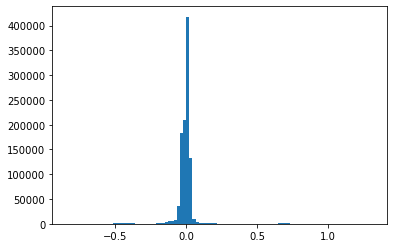

In [17]:
plt.hist(torch.flatten(latent0).detach().numpy(), bins=100);

In [25]:
np.unique(np.sum(abs(latent0.detach().numpy())>0.25, axis=1), return_counts=1)

(array([0, 1, 2, 3, 4]), array([82398, 22367,    49,    28,     3]))

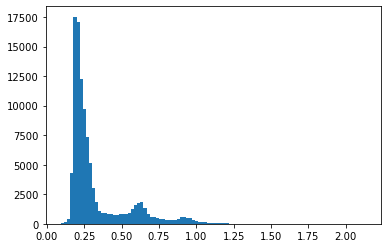

In [27]:
plt.hist(torch.sum(torch.abs(latent0), axis=1).detach().numpy().flatten(), bins = 100);

In [28]:
np.unique(np.sum(abs(latent1.detach().numpy())>0.25, axis=1), return_counts=1)

(array([0, 1, 2]), array([83859,  2746, 18240]))

In [87]:
n_lat = torch.sum(torch.isclose(latent0, torch.zeros_like(latent0), atol=0.01), axis=1)
tot = torch.sum(torch.abs(n_lat - torch.ones_like(n_lat)*2))

tensor(115284)

In [22]:
from datetime import date
today = date.today()

today = today.strftime("%d%m%y")

torch.save(model.state_dict(),f'trained_models/model_{epoch}_{today}.pt') 

In [24]:
load=False
if load:
    model = GCN(hidden_channelse=128)
    model.load_state_dict(torch.load(f'trained_models', f'model_{epoch}_{date}.pt'))

In [25]:
print('decoder', sum(p.abs().sum() for p in model.f.parameters())/sum(p.numel() for p in model.f.parameters())*100)

print('encoder', sum(p.abs().sum() for p in model.g1.parameters())/sum(p.numel() for p in model.g1.parameters())*100)
print('edge', sum(p.abs().sum() for p in model.g2.parameters())/sum(p.numel() for p in model.g2.parameters())*100)
print('both', sum(p.abs().sum() for p in model.g3.parameters())/sum(p.numel() for p in model.g3.parameters())*100)

decoder tensor(1.0244, grad_fn=<MulBackward0>)
encoder tensor(1.0797, grad_fn=<MulBackward0>)
edge tensor(0.5381, grad_fn=<MulBackward0>)
both tensor(1.1271, grad_fn=<MulBackward0>)


In [27]:
# model.load_state_dict(torch.load(osp.join(pointer, model_runs[k], 'trained_model', 'model.pt')))

In [84]:
pysr_loader=DataLoader(test_data[:50], batch_size=batch_size, shuffle=0, num_workers=4)    

y_f = []
y_g1 = []
y_g2 = []
y_g3 = []
x_g1 = []
y_t = []
batch = []
i=0
for dat in pysr_loader:
    print(i)
    x_g1.append(dat.x.cpu().detach().numpy())
    yg1=model.g1(dat.x)
    y_g1.append(yg1.cpu().detach().numpy())
    
    adj = dat.edge_index
    neighbours = yg1
    xg2 = scatter_add(neighbours[adj[0]], adj[1], dim=0)
    x_g2.append(xg2)
    yg2=model.g2(xg2)
    y_g2.append(yg2.cpu().detach().numpy())
    
    yg1[adj[1]]+=yg2[adj[1]]
    
    yg3 = model.g3(yg1)
    y_g3.append(yg3.cpu().detach().numpy())
    x_f = global_add_pool(yg3, dat.batch)
    
    yf = model.f(x_f)
    y_f.append(yf.cpu().detach().numpy())
    
    batch.append(dat.batch.cpu().detach().numpy())
    y_t.append(dat.y.cpu().detach().numpy())
    i+=1

0


In [85]:
N=25
vals, counts = np.unique(batch[0], return_counts=1)
l = np.cumsum(counts)[N-1]
x_g1_pysr=np.vstack(x_g1[0][:l])
y_g1_pysr=np.vstack(y_g1[0][:l])
y_g2_pysr=np.vstack(y_g2[0][:l])
y_g3_pysr=np.vstack(y_g3[0][:l])
y_f_pysr=np.vstack(y_f[0][:l])

b_pysr = batch[0][:l]

In [86]:
##
g1_equations = pysr(
    X=x_g1_pysr, y=y_g1_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div"],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpyc0xp9yp/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 6.440e+03
Head worker occupation: 6.6%
Progress: 3 / 1200 total iterations (0.250%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           9.573e-01  7.446e-02  (-0.39906436 + (2.5171049 * x1))
7           7.673e-01  1.106e-01  (-0.2528663 + (x4 + (2.1287289 * x1)))
8           7.581e-01  1.199e-02  ((2.0636811 * x1) + log_abs(0.94439185 + x4))
9           6.789e-01  1.104e-01  (x1 + ((-0.57546425 * x0) + (3.2942095 * x2)))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.371e+00  2.264e-01  x1
2           9.097e+00  2.968e-02  exp(x1)
3           6.752e+00  2.981e-01  (2.793


Cycles per second: 3.380e+03
Head worker occupation: 0.9%
Progress: 13 / 1200 total iterations (1.083%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.3797928 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.178e-01  9.897e-04  (x1 - (0.009313339 + log10_abs(x2)))
7           6.145e-01  5.290e-03  (x1 - (log_abs(sqrt_abs(x2)) - -0.10132865))
8           5.698e-01  7.561e-02  (1.8673731 + (x1 + (-2.3141558 * sqrt_abs(x2))))
10          5.679e-01  1.624e-03  (x1 + (-1.0557032 * log10_abs(x2 + (-0.1134993 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.088e+00  4.701e-01  (4.234271 * x2)
5           8.302e-01  1.354e-01  (x4 - (x1 / -0.49075502))
7           7.658e-01  4.035e


Cycles per second: 2.680e+03
Head worker occupation: 0.5%
Progress: 21 / 1200 total iterations (1.750%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.990e-01  8.240e-02  (x1 + 0.34660563)
4           6.190e-01  2.553e-01  (x1 - log10_abs(x2))
7           5.908e-01  1.554e-02  ((2.9686167 * x1) + (-3.5632546 * x2))
8           5.679e-01  3.962e-02  ((2.3849034 - log_abs(x1)) * (x1 - x2))
10          5.659e-01  1.701e-03  (x1 + (-1.07813 * log10_abs(x2 + (-0.09936239 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           8.290e-01  1.464e-01  (x4 + (2.076545 * x1))
7           7.673e-01  3.867e-02  (-0.25267908 + (x4 + (2.1288564 * x1)))
9           6.693e-01  6.832e-02  (-0.544885


Cycles per second: 2.770e+03
Head worker occupation: 0.7%
Progress: 30 / 1200 total iterations (2.500%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.37972298 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.140e-01  4.015e-03  (x1 + log10_abs(0.85042274 / x2))
8           6.078e-01  5.104e-03  (x1 + log10_abs(-0.3060487 + (0.8593486 / x2)))
9           5.971e-01  1.785e-02  ((x1 - log10_abs(x2 * sqrt_abs(x1))) - 0.18158987)
10          5.677e-01  5.047e-02  (x1 + log10_abs((-1.0497826 / x2) + (-0.7018149 * x3)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.232e+00  4.080e-01  (x1 / 0.48811185)
5           8.337e-01  1.954e-01  ((x1 + x4) + x1)
8           8.279e-01  2.349e-03 

Killing process... will return when done.


In [87]:
eq = g1_equations[0].sort_values(by='score', ascending=False).iloc[0]
a=eq['lambda_format'](x_g1[0])
eq

Complexity                                                4
MSE                                                0.618991
score                                              0.253895
Equation                               (x1 - log10_abs(x2))
sympy_format                      x1 - log(Abs(x2))/log(10)
lambda_format    PySRFunction(X=>x1 - log(Abs(x2))/log(10))
Name: 2, dtype: object

In [88]:
eq = g1_equations[1].sort_values(by='score', ascending=False).iloc[0]
b=eq['lambda_format'](x_g1[0])
eq

Complexity                                          3
MSE                                          1.143048
score                                        0.445626
Equation                            (x1 / 0.37977126)
sympy_format                      2.63316397349289*x1
lambda_format    PySRFunction(X=>2.63316397349289*x1)
Name: 1, dtype: object

In [89]:
eq = g1_equations[2].sort_values(by='score', ascending=False).iloc[0]
c=eq['lambda_format'](x_g1[0])
eq

Complexity                                   3
MSE                                   6.751929
score                                 0.298143
Equation                      (2.7937005 * x1)
sympy_format                      2.7937005*x1
lambda_format    PySRFunction(X=>2.7937005*x1)
Name: 2, dtype: object

In [90]:
g1_an_pysr = np.vstack([a,b,c])

In [ ]:
g2_equations = pysr(
    X=y_g1_pysr, y=y_g2_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div", 'pow'],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpgyms7yzv/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 5.180e+03
Head worker occupation: 8.3%
Progress: 2 / 1200 total iterations (0.167%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  -0.000e+00  1.2790511
4           8.282e-01  6.981e-02  sqrt_abs(1.3321475 - x0)
5           5.994e-01  3.233e-01  (1.2852532 + (-0.26651594 * x1))
6           5.982e-01  2.089e-03  sqrt_abs(1.9554164 + (-0.6193561 * x1))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.950e+03
Head worker occupation: 5.1%
Progress: 3 / 1200 total iteration


Cycles per second: 3.420e+03
Head worker occupation: 0.7%
Progress: 10 / 1200 total iterations (0.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171164 * x1)
5      


Cycles per second: 5.100e+03
Head worker occupation: 0.5%
Progress: 22 / 1200 total iterations (1.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171337 * x1)
5      


Cycles per second: 4.950e+03
Head worker occupation: 0.4%
Progress: 35 / 1200 total iterations (2.917%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.2517181 * x1)
5       